In [1]:
!pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 11.9 MB/s eta 0:00:00
  Attempting uninstall: jax-cuda12-pjrt
    Found existing installation: jax-cuda12-pjrt 0.4.33
    Uninstalling jax-cuda12-pjrt-0.4.33:
      Successfully uninstalled jax-cuda12-pjrt-0.4.33
  Attempting uninstall: nvidia-cuda-nvcc-cu12
    Found existing installation: nvidia-cuda-nvcc-cu12 12.5.82
    Uninstalling nvidia-cuda-nvcc-cu12-12.5.82:
      Successfully uninstalled nvidia-cuda-nvcc-cu12-12.5.82
  Attempting uninstall: jax-cuda12-plugin
    Found existing installation: jax-cuda12-plugin 0.4.33
    Uninsta

In [2]:
!pip install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 27.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379447 sha256=57f510e2f4759e7b1ffac3a5987bc0635621ca1730e53ecbf8d6637ec121284c
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [3]:
import flax.linen as nn
import gymnasium as gym
from gymnasium.wrappers import FlattenObservation
from gymnasium.utils import seeding

from functools import partial
import numpy as np
import wandb
import jax
import optax
import collections
import jax.numpy as jnp
from flax import struct
from tqdm import trange
import matplotlib.pyplot as plt
from flax.core import frozen_dict
from flax.training.train_state import TrainState

from typing import Optional, Any, Union, Sequence, Dict, Tuple, Type, Iterable, Callable
import moviepy.editor
DataType = Union[np.ndarray, Dict[str, "DataType"]]
DatasetDict = Dict[str, DataType]
default_init = nn.initializers.xavier_uniform

  if event.key is 'enter':



In [4]:
class UniversalSeed(gym.Wrapper):
    def seed(self, seed: int):
        seeds = self.env.seed(seed)
        self.env.observation_space.seed(seed)
        self.env.action_space.seed(seed)
        return seeds

def wrap_gym(env: gym.Env, rescale_actions: bool = True) -> gym.Env:
    # env = SinglePrecision(env)
    env = UniversalSeed(env)
    if rescale_actions:
        env = gym.wrappers.RescaleAction(env, -1, 1)

    if isinstance(env.observation_space, gym.spaces.Dict):
        env = FlattenObservation(env)

    env = gym.wrappers.ClipAction(env)

    return env

In [5]:
env = gym.make("BipedalWalker-v3", render_mode="rgb_array")
env = wrap_gym(env, rescale_actions=True)
env = video = gym.wrappers.RecordVideo(env, 'cartpole_video')
observation, _ = env.reset()
for i in trange(10000):
    action = env.action_space.sample()
    next_observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    if done:
        print('DONE!')
        break
env.close()
moviepy.editor.ipython_display("cartpole_video/rl-video-episode-0.mp4")

 16%|█▌        | 1599/10000 [00:14<01:16, 109.33it/s]


DONE!


In [6]:
@partial(jax.jit, static_argnames="apply_fn")
def _sample_actions(rng, apply_fn, params, observations: np.ndarray) -> np.ndarray:
    key, rng = jax.random.split(rng)
    dist = apply_fn({"params": params}, observations)
    return dist.sample(seed=key), rng

@partial(jax.jit, static_argnames="apply_fn")
def _eval_actions(apply_fn, params, observations: np.ndarray) -> np.ndarray:
    dist = apply_fn({"params": params}, observations)
    return dist.mode()

class Agent(struct.PyTreeNode):
    actor: TrainState
    rng: Any

    def eval_actions(self, observations: np.ndarray) -> np.ndarray:
        actions = _eval_actions(self.actor.apply_fn, self.actor.params, observations)
        return np.asarray(actions), self.replace(rng=self.rng)

    def sample_actions(self, observations: np.ndarray) -> np.ndarray:
        actions, new_rng = _sample_actions(
            self.rng, self.actor.apply_fn, self.actor.params, observations
        )
        return np.asarray(actions), self.replace(rng=new_rng)


In [7]:

def cosine_beta_schedule(timesteps, s = 0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    t = jnp.linspace(0, timesteps, steps) / timesteps
    alphas_cumprod = jnp.cos((t + s) / (1 + s) * jnp.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return jnp.clip(betas, 0, 0.999)

def linear_beta_schedule(timesteps, beta_start=1e-4, beta_end=2e-2):
    betas = jnp.linspace(
        beta_start, beta_end, timesteps
    )
    return betas

def vp_beta_schedule(timesteps):
    t = jnp.arange(1, timesteps + 1)
    T = timesteps
    b_max = 10.
    b_min = 0.1
    alpha = jnp.exp(-b_min / T - 0.5 * (b_max - b_min) * (2 * t - 1) / T ** 2)
    betas = 1 - alpha
    return betas

class FourierFeatures(nn.Module):
    output_size: int
    learnable: bool = True

    @nn.compact
    def __call__(self, x: jnp.ndarray):
        if self.learnable:
            w = self.param('kernel', nn.initializers.normal(0.2),
                           (self.output_size // 2, x.shape[-1]), jnp.float32)
            f = 2 * jnp.pi * x @ w.T
        else:
            half_dim = self.output_size // 2
            f = jnp.log(10000) / (half_dim - 1)
            f = jnp.exp(jnp.arange(half_dim) * -f)
            f = x * f
        return jnp.concatenate([jnp.cos(f), jnp.sin(f)], axis=-1)

class DDPM(nn.Module):
    cond_encoder_cls: Type[nn.Module]
    reverse_encoder_cls: Type[nn.Module]
    time_preprocess_cls: Type[nn.Module]

    @nn.compact
    def __call__(self,
                 s: jnp.ndarray,
                 a: jnp.ndarray,
                 time: jnp.ndarray,
                 training: bool = False):

        t_ff = self.time_preprocess_cls()(time)
        cond = self.cond_encoder_cls()(t_ff, training=training)
        reverse_input = jnp.concatenate([a, s, cond], axis=-1)

        return self.reverse_encoder_cls()(reverse_input, training=training)

@partial(jax.jit, static_argnames=('actor_apply_fn', 'act_dim', 'T', 'clip_sampler', 'training'))
def ddpm_sampler(actor_apply_fn, actor_params, T, rng, act_dim, observations, alphas, alpha_hats, betas, sample_temperature, clip_sampler, training = False):

    batch_size = observations.shape[0]

    def fn(input_tuple, time):
        current_x, rng = input_tuple

        input_time = jnp.expand_dims(
            jnp.array([time]).repeat(current_x.shape[0]), axis=1)
        eps_pred = actor_apply_fn(
            {"params": actor_params},
            observations, current_x,
            input_time, training=training)

        alpha_1 = 1 / jnp.sqrt(alphas[time])
        alpha_2 = ((1 - alphas[time]) / (jnp.sqrt(1 - alpha_hats[time])))
        current_x = alpha_1 * (current_x - alpha_2 * eps_pred)

        rng, key = jax.random.split(rng, 2)
        z = jax.random.normal(
            key, shape=(observations.shape[0], current_x.shape[1]),)

        z_scaled = sample_temperature * z
        current_x = current_x + (time > 0) * (jnp.sqrt(betas[time]) * z_scaled)
        current_x = jnp.clip(current_x, -1, 1) if clip_sampler else current_x
        return (current_x, rng), ()

    key, rng = jax.random.split(rng, 2)
    (action_0, rng), () = jax.lax.scan(
        fn, (jax.random.normal(key, (batch_size, act_dim)), rng),
        jnp.arange(T-1, -1, -1), unroll=5)
    action_0 = jnp.clip(action_0, -1, 1)
    return action_0, rng


In [8]:

def _check_lengths(dataset_dict: DatasetDict, dataset_len: Optional[int] = None) -> int:
    for v in dataset_dict.values():
        if isinstance(v, dict):
            dataset_len = dataset_len or _check_lengths(v, dataset_len)
        elif isinstance(v, np.ndarray):
            item_len = len(v)
            dataset_len = dataset_len or item_len
            assert dataset_len == item_len, "Inconsistent item lengths in the dataset."
        else:
            raise TypeError("Unsupported type.")
    return dataset_len


def _subselect(dataset_dict: DatasetDict, index: np.ndarray) -> DatasetDict:
    new_dataset_dict = {}
    for k, v in dataset_dict.items():
        if isinstance(v, dict):
            new_v = _subselect(v, index)
        elif isinstance(v, np.ndarray):
            new_v = v[index]
        else:
            raise TypeError("Unsupported type.")
        new_dataset_dict[k] = new_v
    return new_dataset_dict


def _sample(
    dataset_dict: Union[np.ndarray, DatasetDict], indx: np.ndarray
) -> DatasetDict:
    if isinstance(dataset_dict, np.ndarray):
        return dataset_dict[indx]
    elif isinstance(dataset_dict, dict):
        batch = {}
        for k, v in dataset_dict.items():
            batch[k] = _sample(v, indx)
    else:
        raise TypeError("Unsupported type.")
    return batch


class Dataset(object):
    def __init__(self, dataset_dict: DatasetDict, seed: Optional[int] = None):
        self.dataset_dict = dataset_dict
        self.dataset_len = _check_lengths(dataset_dict)

        # Seeding similar to OpenAI Gym:
        # https://github.com/openai/gym/blob/master/gym/spaces/space.py#L46
        self._np_random = None
        self._seed = None
        if seed is not None:
            self.seed(seed)

    @property
    def np_random(self) -> np.random.RandomState:
        if self._np_random is None:
            self.seed()
        return self._np_random

    def seed(self, seed: Optional[int] = None) -> list:
        self._np_random, self._seed = seeding.np_random(seed)
        return [self._seed]

    def __len__(self) -> int:
        return self.dataset_len

    def sample(
        self,
        batch_size: int,
        keys: Optional[Iterable[str]] = None,
        indx: Optional[np.ndarray] = None,
    ) -> frozen_dict.FrozenDict:
        if indx is None:
            if hasattr(self.np_random, "integers"):
                indx = self.np_random.integers(len(self), size=batch_size)
            else:
                indx = self.np_random.randint(len(self), size=batch_size)

        batch = dict()

        if keys is None:
            keys = self.dataset_dict.keys()

        for k in keys:
            if isinstance(self.dataset_dict[k], dict):
                batch[k] = _sample(self.dataset_dict[k], indx)
            else:
                batch[k] = self.dataset_dict[k][indx]

        return frozen_dict.freeze(batch)

    def sample_jax(self, batch_size: int, keys: Optional[Iterable[str]] = None):
        if not hasattr(self, "rng"):
            self.rng = jax.random.PRNGKey(self._seed or 42)

            if keys is None:
                keys = self.dataset_dict.keys()

            jax_dataset_dict = {k: self.dataset_dict[k] for k in keys}
            jax_dataset_dict = jax.device_put(jax_dataset_dict)

            @jax.jit
            def _sample_jax(rng):
                key, rng = jax.random.split(rng)
                indx = jax.random.randint(
                    key, (batch_size,), minval=0, maxval=len(self)
                )
                return rng, jax.tree_map(
                    lambda d: jnp.take(d, indx, axis=0), jax_dataset_dict
                )

            self._sample_jax = _sample_jax

        self.rng, sample = self._sample_jax(self.rng)
        return sample

    def split(self, ratio: float) -> Tuple["Dataset", "Dataset"]:
        assert 0 < ratio and ratio < 1
        train_index = np.index_exp[: int(self.dataset_len * ratio)]
        test_index = np.index_exp[int(self.dataset_len * ratio) :]

        index = np.arange(len(self), dtype=np.int32)
        self.np_random.shuffle(index)
        train_index = index[: int(self.dataset_len * ratio)]
        test_index = index[int(self.dataset_len * ratio) :]

        train_dataset_dict = _subselect(self.dataset_dict, train_index)
        test_dataset_dict = _subselect(self.dataset_dict, test_index)
        return Dataset(train_dataset_dict), Dataset(test_dataset_dict)

    def _trajectory_boundaries_and_returns(self) -> Tuple[list, list, list]:
        episode_starts = [0]
        episode_ends = []

        episode_return = 0
        episode_returns = []

        for i in range(len(self)):
            episode_return += self.dataset_dict["rewards"][i]

            if self.dataset_dict["dones"][i]:
                episode_returns.append(episode_return)
                episode_ends.append(i + 1)
                if i + 1 < len(self):
                    episode_starts.append(i + 1)
                episode_return = 0.0

        return episode_starts, episode_ends, episode_returns

    def filter(
        self, take_top: Optional[float] = None, threshold: Optional[float] = None
    ):
        assert (take_top is None and threshold is not None) or (
            take_top is not None and threshold is None
        )

        (
            episode_starts,
            episode_ends,
            episode_returns,
        ) = self._trajectory_boundaries_and_returns()

        if take_top is not None:
            threshold = np.percentile(episode_returns, 100 - take_top)

        bool_indx = np.full((len(self),), False, dtype=bool)

        for i in range(len(episode_returns)):
            if episode_returns[i] >= threshold:
                bool_indx[episode_starts[i] : episode_ends[i]] = True

        self.dataset_dict = _subselect(self.dataset_dict, bool_indx)

        self.dataset_len = _check_lengths(self.dataset_dict)

    def normalize_returns(self, scaling: float = 1000):
        (_, _, episode_returns) = self._trajectory_boundaries_and_returns()
        self.dataset_dict["rewards"] /= np.max(episode_returns) - np.min(
            episode_returns
        )
        self.dataset_dict["rewards"] *= scaling


In [9]:

def _init_replay_dict(
    obs_space: gym.Space, capacity: int
) -> Union[np.ndarray, DatasetDict]:
    if isinstance(obs_space, gym.spaces.Box):
        return np.empty((capacity, *obs_space.shape), dtype=obs_space.dtype)
    elif isinstance(obs_space, gym.spaces.Dict):
        data_dict = {}
        for k, v in obs_space.spaces.items():
            data_dict[k] = _init_replay_dict(v, capacity)
        return data_dict
    else:
        raise TypeError()


def _insert_recursively(
    dataset_dict: DatasetDict, data_dict: DatasetDict, insert_index: int
):
    if isinstance(dataset_dict, np.ndarray):
        dataset_dict[insert_index] = data_dict
    elif isinstance(dataset_dict, dict):
        assert dataset_dict.keys() == data_dict.keys()
        for k in dataset_dict.keys():
            _insert_recursively(dataset_dict[k], data_dict[k], insert_index)
    else:
        raise TypeError()


class ReplayBuffer(Dataset):
    def __init__(
        self,
        observation_space: gym.Space,
        action_space: gym.Space,
        capacity: int,
        next_observation_space: Optional[gym.Space] = None,
    ):
        if next_observation_space is None:
            next_observation_space = observation_space

        observation_data = _init_replay_dict(observation_space, capacity)
        next_observation_data = _init_replay_dict(next_observation_space, capacity)
        dataset_dict = dict(
            observations=observation_data,
            next_observations=next_observation_data,
            actions=np.empty((capacity, *action_space.shape), dtype=action_space.dtype),
            rewards=np.empty((capacity,), dtype=np.float32),
            masks=np.empty((capacity,), dtype=np.float32),
            dones=np.empty((capacity,), dtype=bool),
        )

        super().__init__(dataset_dict)

        self._size = 0
        self._capacity = capacity
        self._insert_index = 0

    def __len__(self) -> int:
        return self._size

    def insert(self, data_dict: DatasetDict):
        _insert_recursively(self.dataset_dict, data_dict, self._insert_index)

        self._insert_index = (self._insert_index + 1) % self._capacity
        self._size = min(self._size + 1, self._capacity)

    def get_iterator(self, queue_size: int = 2, sample_args: dict = {}):
        # See https://flax.readthedocs.io/en/latest/_modules/flax/jax_utils.html#prefetch_to_device
        # queue_size = 2 should be ok for one GPU.

        queue = collections.deque()

        def enqueue(n):
            for _ in range(n):
                data = self.sample(**sample_args)
                queue.append(jax.device_put(data))

        enqueue(queue_size)
        while queue:
            yield queue.popleft()
            enqueue(1)


In [10]:
class MLP(nn.Module):
    hidden_dims: Sequence[int]
    activations: Callable[[jnp.ndarray], jnp.ndarray] = nn.relu
    activate_final: bool = False
    use_layer_norm: bool = False
    scale_final: Optional[float] = None
    dropout_rate: Optional[float] = None

    @nn.compact
    def __call__(self, x: jnp.ndarray, training: bool = False) -> jnp.ndarray:
        if self.use_layer_norm:
            x = nn.LayerNorm()(x)
        for i, size in enumerate(self.hidden_dims):
            if i + 1 == len(self.hidden_dims) and self.scale_final is not None:
                x = nn.Dense(size, kernel_init=default_init(self.scale_final))(x)
            else:
                x = nn.Dense(size, kernel_init=default_init())(x)

            if i + 1 < len(self.hidden_dims) or self.activate_final:
                if self.dropout_rate is not None and self.dropout_rate > 0:
                    x = nn.Dropout(rate=self.dropout_rate)(
                        x, deterministic=not training
                    )
                x = self.activations(x)
        return x


In [11]:
tree_map = jax.tree_util.tree_map
sg = lambda x: tree_map(jax.lax.stop_gradient, x)

def mish(x):
    return x * jnp.tanh(nn.softplus(x))

class StateActionValue(nn.Module):
    base_cls: nn.Module

    @nn.compact
    def __call__(
        self, observations: jnp.ndarray, actions: jnp.ndarray, *args, **kwargs
    ) -> jnp.ndarray:
        inputs = jnp.concatenate([observations, actions], axis=-1)
        outputs = self.base_cls()(inputs, *args, **kwargs)

        value = nn.Dense(1, kernel_init=default_init())(outputs)

        return jnp.squeeze(value, -1)

def tensorstats(tensor, prefix=None):
  assert tensor.size > 0, tensor.shape
  metrics = {
      'mean': tensor.mean(),
      'std': tensor.std(),
      'mag': jnp.abs(tensor).max(),
      'min': tensor.min(),
      'max': tensor.max(),
  }
  if prefix:
    metrics = {f'{prefix}_{k}': v for k, v in metrics.items()}
  return metrics

class ScoreMatchingLearner(Agent):
    score_model: TrainState
    critic_1: TrainState
    critic_2: TrainState
    target_critic_1: TrainState
    target_critic_2: TrainState

    discount: float
    tau: float
    act_dim: int = struct.field(pytree_node=False)
    T: int = struct.field(pytree_node=False)
    clip_sampler: bool = struct.field(pytree_node=False)
    ddpm_temperature: float
    betas: jnp.ndarray
    alphas: jnp.ndarray
    alpha_hats: jnp.ndarray
    # global scaling factor for grad_a Q(s, a)
    M_q: float

    @classmethod
    def create(
        cls,
        seed: int,
        observation_space: gym.spaces.Space,
        action_space: gym.spaces.Box,
        actor_architecture: str = 'mlp',
        actor_lr: Union[float, optax.Schedule] = 3e-4,
        critic_lr: float = 3e-4,
        critic_hidden_dims: Sequence[int] = (256, 256),
        actor_hidden_dims: Sequence[int] = (256, 256, 256),
        discount: float = 0.99,
        tau: float = 0.005,
        ddpm_temperature: float = 1.0,
        actor_layer_norm: bool = False,
        T: int = 5,
        time_dim: int = 64,
        clip_sampler: bool = True,
        beta_schedule: str = 'vp',
        decay_steps: Optional[int] = int(2e6),
        M_q: float = 1,
    ):

        rng = jax.random.PRNGKey(seed)
        rng, actor_key, critic_key = jax.random.split(rng, 3)
        actions = action_space.sample()
        observations = observation_space.sample()
        action_dim = action_space.shape[-1]

        # Time embedding network.
        preprocess_time_cls = partial(
            FourierFeatures, output_size=time_dim, learnable=True)

        cond_model_cls = partial(
            MLP, hidden_dims=(128, 128), activations=mish,
            activate_final=False)

        if decay_steps is not None:
            actor_lr = optax.cosine_decay_schedule(actor_lr, decay_steps)

        if actor_architecture == 'mlp':
            base_model_cls = partial(MLP,
                hidden_dims=tuple(list(actor_hidden_dims) + [action_dim]),
                activations=mish, use_layer_norm=actor_layer_norm,
                activate_final=False)

            actor_def = DDPM(time_preprocess_cls=preprocess_time_cls,
                             cond_encoder_cls=cond_model_cls,
                             reverse_encoder_cls=base_model_cls)
        else:
            raise ValueError(f'Invalid actor architecture: {actor_architecture}')

        time = jnp.zeros((1, 1))
        observations = jnp.expand_dims(observations, axis = 0)
        actions = jnp.expand_dims(actions, axis = 0)
        actor_params = actor_def.init(
            actor_key, observations, actions, time)['params']

        score_model = TrainState.create(
            apply_fn=actor_def.apply, params=actor_params,
            tx=optax.adam(learning_rate=actor_lr))

        # Initialize critics.
        critic_base_cls = partial(
            MLP, hidden_dims=critic_hidden_dims, activate_final=True)
        critic_def = StateActionValue(critic_base_cls)
        critic_key_1, critic_key_2 = jax.random.split(critic_key, 2)
        critic_params_1 = critic_def.init(critic_key_1, observations, actions)["params"]
        critic_params_2 = critic_def.init(critic_key_2, observations, actions)["params"]
        critic_1 = TrainState.create(
            apply_fn=critic_def.apply,
            params=critic_params_1,
            tx=optax.adam(learning_rate=critic_lr))
        critic_2 = TrainState.create(
            apply_fn=critic_def.apply,
            params=critic_params_2,
            tx=optax.adam(learning_rate=critic_lr))

        target_critic_def = StateActionValue(critic_base_cls)
        target_critic_1 = TrainState.create(
            apply_fn=target_critic_def.apply,
            params=critic_params_1,
            tx=optax.GradientTransformation(lambda _: None, lambda _: None),)
        target_critic_2 = TrainState.create(
            apply_fn=target_critic_def.apply,
            params=critic_params_2,
            tx=optax.GradientTransformation(lambda _: None, lambda _: None),)

        if beta_schedule == 'cosine':
            betas = jnp.array(cosine_beta_schedule(T))
        elif beta_schedule == 'linear':
            betas = jnp.linspace(1e-4, 2e-2, T)
        elif beta_schedule == 'vp':
            betas = jnp.array(vp_beta_schedule(T))
        else:
            raise ValueError(f'Invalid beta schedule: {beta_schedule}')

        alphas = 1 - betas
        alpha_hat = jnp.array([jnp.prod(alphas[:i + 1]) for i in range(T)])

        return cls(
            actor=None,
            score_model=score_model,
            critic_1=critic_1,
            critic_2=critic_2,
            target_critic_1=target_critic_1,
            target_critic_2=target_critic_2,
            tau=tau,
            discount=discount,
            rng=rng,
            betas=betas,
            alpha_hats=alpha_hat,
            act_dim=action_dim,
            T=T,
            alphas=alphas,
            ddpm_temperature=ddpm_temperature,
            clip_sampler=clip_sampler,
            M_q=M_q,
        )

    def update_q(agent, batch: DatasetDict) -> Tuple[Agent, Dict[str, float]]:
        (B, _) = batch['observations'].shape
        (_, A) = batch['actions'].shape

        # Sample actions for next state.
        key, rng = jax.random.split(agent.rng)
        next_actions, rng = ddpm_sampler(
            agent.score_model.apply_fn,
            agent.score_model.params,
            agent.T, rng, agent.act_dim,
            batch['next_observations'],
            agent.alphas, agent.alpha_hats,
            agent.betas, agent.ddpm_temperature,
            agent.clip_sampler)
        key, rng = jax.random.split(rng, 2)
        noise = jax.random.normal(key, shape=next_actions.shape) * 0.1
        next_actions = next_actions + noise
        next_actions = jnp.clip(next_actions, -1.0, 1.0)
        key, rng = jax.random.split(rng, 2)
        assert next_actions.shape == (B, A)

        # Compute target q.
        key, rng = jax.random.split(rng)
        next_q_1 = agent.target_critic_1.apply_fn(
            {"params": agent.target_critic_1.params}, batch["next_observations"],
            next_actions, True, rngs={"dropout": key})
        key, rng = jax.random.split(rng)
        next_q_2 = agent.target_critic_2.apply_fn(
            {"params": agent.target_critic_2.params}, batch["next_observations"],
            next_actions, True, rngs={"dropout": key})
        key, rng = jax.random.split(rng)
        next_v = jnp.stack([next_q_1, next_q_2], 0).min(0)
        target_q = batch["rewards"] + agent.discount * batch["masks"] * next_v
        metrics = tensorstats(target_q, 'target_q')
        assert target_q.shape == (B,)

        def critic_loss_fn(critic_params) -> Tuple[jnp.ndarray, Dict[str, float]]:
            q = agent.critic_1.apply_fn(
                {"params": critic_params},
                batch["observations"],
                batch["actions"], training=True)
            loss = ((q - sg(target_q)) ** 2)
            assert loss.shape == (B,)
            metrics = {**tensorstats(loss, 'c_loss'), **tensorstats(q, 'q')}
            return loss.mean(), metrics

        grads_c_1, metrics_c_1 = jax.grad(critic_loss_fn, has_aux=True)(agent.critic_1.params)
        metrics.update({f'{k}_1': v for k, v in metrics_c_1.items()})
        critic_1 = agent.critic_1.apply_gradients(grads=grads_c_1)

        grads_c_2, metrics_c_2 = jax.grad(critic_loss_fn, has_aux=True)(agent.critic_2.params)
        metrics.update({f'{k}_2': v for k, v in metrics_c_2.items()})
        critic_2 = agent.critic_2.apply_gradients(grads=grads_c_2)

        target_critic_1_params = optax.incremental_update(
            critic_1.params, agent.target_critic_1.params, agent.tau)
        target_critic_2_params = optax.incremental_update(
            critic_2.params, agent.target_critic_2.params, agent.tau)
        target_critic_1 = agent.target_critic_1.replace(params=target_critic_1_params)
        target_critic_2 = agent.target_critic_2.replace(params=target_critic_2_params)
        new_agent = agent.replace(
            critic_1=critic_1, critic_2=critic_2,
            target_critic_1=target_critic_1,
            target_critic_2=target_critic_2,
            rng=rng)
        return new_agent, metrics

    def update_actor(agent, batch: DatasetDict) -> Tuple[Agent, Dict[str, float]]:
        B, A = batch['actions'].shape

        # Forward process with RB actions.
        key, rng = jax.random.split(agent.rng, 2)
        time = jax.random.randint(key, (B,), 0, agent.T)
        key, rng = jax.random.split(rng, 2)
        noise_sample = jax.random.normal(
            key, (B, agent.act_dim))
        key, rng = jax.random.split(rng, 2)
        alpha_hats = agent.alpha_hats[time]
        time = jnp.expand_dims(time, axis=1)
        alpha_1 = jnp.expand_dims(jnp.sqrt(alpha_hats), axis=1)
        alpha_2 = jnp.expand_dims(jnp.sqrt(1 - alpha_hats), axis=1)
        noisy_actions = alpha_1 * batch['actions'] + alpha_2 * noise_sample
        key, rng = jax.random.split(rng, 2)

        # Compute dQ/da.
        critic_1_jacobian = jax.grad(lambda actions: agent.critic_1.apply_fn(
            {"params": agent.critic_1.params}, batch['observations'], actions).sum(),
            has_aux=False)(noisy_actions)
        assert critic_1_jacobian.shape == (B, A), (critic_1_jacobian.shape, (B, A))
        critic_2_jacobian = jax.grad(lambda actions: agent.critic_2.apply_fn(
            {"params": agent.critic_2.params}, batch['observations'], actions).sum(),
            has_aux=False)(noisy_actions)
        assert critic_2_jacobian.shape == (B, A), (critic_2_jacobian.shape, (B, A))
        critic_jacobian = jnp.stack([critic_1_jacobian, critic_2_jacobian], 0).mean(0)

        def actor_loss_fn(
                score_model_params) -> Tuple[jnp.ndarray, Dict[str, float]]:
            eps_pred = agent.score_model.apply_fn(
                {'params': score_model_params}, batch['observations'],
                noisy_actions, time, rngs={'dropout': key}, training=True)
            assert eps_pred.shape == (B, A)
            actor_loss = jnp.power(-agent.M_q*sg(critic_jacobian) - eps_pred, 2).mean(-1)
            assert actor_loss.shape == (B,)
            metrics = tensorstats(actor_loss, 'actor_loss')
            metrics.update(tensorstats(eps_pred, 'eps_pred'))
            metrics.update(tensorstats(critic_jacobian, 'critic_jacobian'))
            return actor_loss.mean(0), metrics

        key, rng = jax.random.split(rng, 2)
        grads, metrics = jax.grad(actor_loss_fn, has_aux=True)(
            agent.score_model.params)
        score_model = agent.score_model.apply_gradients(grads=grads)
        new_agent = agent.replace(
            score_model=score_model,
            rng=rng)
        return new_agent, metrics

    @jax.jit
    def sample_actions(self, observations: jnp.ndarray):
        actions, new_agent = self.eval_actions(observations)
        key, rng = jax.random.split(new_agent.rng, 2)
        noise = jax.random.normal(key, shape=actions.shape) * 0.1
        actions = actions + noise
        actions = jnp.clip(actions, -1.0, 1.0)
        key, rng = jax.random.split(rng, 2)
        return actions, new_agent.replace(rng=rng)

    @jax.jit
    def eval_actions(self, observations: jnp.ndarray):
        rng = self.rng
        assert len(observations.shape) == 1
        observations = observations[None]

        actions, rng = ddpm_sampler(
            self.score_model.apply_fn,
            self.score_model.params,
            self.T, rng, self.act_dim, observations,
            self.alphas, self.alpha_hats,
            self.betas, self.ddpm_temperature,
            self.clip_sampler)
        assert actions.shape == (1, self.act_dim)
        _, rng = jax.random.split(rng, 2)
        return jnp.squeeze(actions), self.replace(rng=rng)

    @jax.jit
    def update(self, batch: DatasetDict):
        new_agent = self
        new_agent, critic_info = new_agent.update_q(batch)
        new_agent, actor_info = new_agent.update_actor(batch)
        return new_agent, {**actor_info, **critic_info}

In [12]:
def evaluate(agent, env: gym.Env, num_episodes: int) -> Dict[str, float]:
    for _ in range(num_episodes):
        observation, _ = env.reset()
        done = False
        while not done:
            action, agent = agent.eval_actions(observation)
            observation, _, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
    return {"return": np.mean(env.return_queue)}

In [13]:
max_iter = 100_000
start_step = 50_000
print_interval = 1000
batch_size = 256
num_episodes = 1

### Pendulum-v1

In [ ]:
env = gym.make("Pendulum-v1", render_mode=None)
env = wrap_gym(env, rescale_actions=True)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=1)

eval_env = gym.make("Pendulum-v1", render_mode=None) # "rgb_array"
eval_env = wrap_gym(eval_env, rescale_actions=True)
# eval_env = gym.wrappers.RecordVideo(eval_env, 'cartpole_video')
eval_env = gym.wrappers.RecordEpisodeStatistics(eval_env, buffer_length=1)

agent = ScoreMatchingLearner.create(42, env.observation_space, env.action_space)

replay_buffer = ReplayBuffer(env.observation_space, env.action_space, max_iter)

observation, _ = env.reset()
done = False

rs, ls, ts = [], [], []
rewards = []
rews = 0
rews_arr = []
pbar = trange(1, max_iter+1, desc='Training')
for i in pbar:
    if i < start_step:
        action = env.action_space.sample()
    else:
        action, agent = agent.sample_actions(observation)
        action = np.asarray(action)
    next_observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    rews += reward
    if not done or "TimeLimit.truncated" in info:
        mask = 1.0
    else:
        mask = 0.0

    replay_buffer.insert(
            dict(
                observations=observation,
                actions=action,
                rewards=reward,
                masks=mask,
                dones=done,
                next_observations=next_observation,
            )
        )
    observation = next_observation
    rewards.append(reward)
    if done:
        rews_arr.append(rews)
        rews = 0
        observation, _ = env.reset()
        done = False
        # print("Done Info:", info)
        pbar.set_postfix(info['episode'])
        rs.append(info['episode']['r'])
        ls.append(info['episode']['l'])
        ts.append(info['episode']['t'])

    if i >= start_step:
        batch = replay_buffer.sample(batch_size)
        agent, update_info = agent.update(batch)

        if i % print_interval == 0:
            print("Update Info:", update_info)
            print('rew_arrs : ', rews_arr[-1])


    if i % 100_000 == 0:
        eval_info = evaluate(agent, eval_env, num_episodes=num_episodes)
        print("Eval Info", eval_info)

eval_env.close()
env.close()

Training:  10%|█         | 10000/100000 [00:23<12:24, 120.85it/s, r=-1.41e+3, l=200, t=5.98]

Update Info: {'actor_loss_mag': Array(0.09889767, dtype=float32), 'actor_loss_max': Array(0.09889767, dtype=float32), 'actor_loss_mean': Array(0.02175997, dtype=float32), 'actor_loss_min': Array(7.274769e-05, dtype=float32), 'actor_loss_std': Array(0.01959503, dtype=float32), 'c_loss_mag_1': Array(242.78517, dtype=float32), 'c_loss_mag_2': Array(217.33589, dtype=float32), 'c_loss_max_1': Array(242.78517, dtype=float32), 'c_loss_max_2': Array(217.33589, dtype=float32), 'c_loss_mean_1': Array(54.787468, dtype=float32), 'c_loss_mean_2': Array(51.30783, dtype=float32), 'c_loss_min_1': Array(0.00180556, dtype=float32), 'c_loss_min_2': Array(0.0011935, dtype=float32), 'c_loss_std_1': Array(45.684307, dtype=float32), 'c_loss_std_2': Array(42.626793, dtype=float32), 'critic_jacobian_mag': Array(0.08434854, dtype=float32), 'critic_jacobian_max': Array(0.08434854, dtype=float32), 'critic_jacobian_mean': Array(0.00484109, dtype=float32), 'critic_jacobian_min': Array(-0.0673929, dtype=float32), 'c

Training:  11%|█         | 10631/100000 [00:29<11:30, 129.38it/s, r=-1.55e+3, l=200, t=0.915]

Update Info: {'actor_loss_mag': Array(0.26278314, dtype=float32), 'actor_loss_max': Array(0.26278314, dtype=float32), 'actor_loss_mean': Array(0.02091875, dtype=float32), 'actor_loss_min': Array(9.1286125e-08, dtype=float32), 'actor_loss_std': Array(0.03157086, dtype=float32), 'c_loss_mag_1': Array(146.8265, dtype=float32), 'c_loss_mag_2': Array(149.01935, dtype=float32), 'c_loss_max_1': Array(146.8265, dtype=float32), 'c_loss_max_2': Array(149.01935, dtype=float32), 'c_loss_mean_1': Array(1.5218775, dtype=float32), 'c_loss_mean_2': Array(1.3872778, dtype=float32), 'c_loss_min_1': Array(9.985204e-05, dtype=float32), 'c_loss_min_2': Array(2.0112117e-05, dtype=float32), 'c_loss_std_1': Array(9.203273, dtype=float32), 'c_loss_std_2': Array(9.330945, dtype=float32), 'critic_jacobian_mag': Array(1.6120048, dtype=float32), 'critic_jacobian_max': Array(1.6120048, dtype=float32), 'critic_jacobian_mean': Array(0.10268836, dtype=float32), 'critic_jacobian_min': Array(-1.3237957, dtype=float32), 

Training:  12%|█▏        | 11998/100000 [00:34<08:22, 174.98it/s, r=-719, l=200, t=0.95]     

Update Info: {'actor_loss_mag': Array(0.592218, dtype=float32), 'actor_loss_max': Array(0.592218, dtype=float32), 'actor_loss_mean': Array(0.04346672, dtype=float32), 'actor_loss_min': Array(1.1531657e-05, dtype=float32), 'actor_loss_std': Array(0.0745218, dtype=float32), 'c_loss_mag_1': Array(121.01935, dtype=float32), 'c_loss_mag_2': Array(135.93327, dtype=float32), 'c_loss_max_1': Array(121.01935, dtype=float32), 'c_loss_max_2': Array(135.93327, dtype=float32), 'c_loss_mean_1': Array(1.926292, dtype=float32), 'c_loss_mean_2': Array(1.9062515, dtype=float32), 'c_loss_min_1': Array(5.5218115e-06, dtype=float32), 'c_loss_min_2': Array(4.5634806e-08, dtype=float32), 'c_loss_std_1': Array(10.255685, dtype=float32), 'c_loss_std_2': Array(10.853145, dtype=float32), 'critic_jacobian_mag': Array(3.2920032, dtype=float32), 'critic_jacobian_max': Array(3.2920032, dtype=float32), 'critic_jacobian_mean': Array(-0.06808662, dtype=float32), 'critic_jacobian_min': Array(-2.7135537, dtype=float32), 

Training:  13%|█▎        | 13031/100000 [00:39<07:14, 200.04it/s, r=-0.916, l=200, t=1.01]

Update Info: {'actor_loss_mag': Array(1.1508514, dtype=float32), 'actor_loss_max': Array(1.1508514, dtype=float32), 'actor_loss_mean': Array(0.11446872, dtype=float32), 'actor_loss_min': Array(3.7839095e-06, dtype=float32), 'actor_loss_std': Array(0.175298, dtype=float32), 'c_loss_mag_1': Array(8857.446, dtype=float32), 'c_loss_mag_2': Array(8798.656, dtype=float32), 'c_loss_max_1': Array(8857.446, dtype=float32), 'c_loss_max_2': Array(8798.656, dtype=float32), 'c_loss_mean_1': Array(37.58432, dtype=float32), 'c_loss_mean_2': Array(37.14619, dtype=float32), 'c_loss_min_1': Array(0.00180998, dtype=float32), 'c_loss_min_2': Array(8.185452e-06, dtype=float32), 'c_loss_std_1': Array(552.35345, dtype=float32), 'c_loss_std_2': Array(548.70215, dtype=float32), 'critic_jacobian_mag': Array(5.3970146, dtype=float32), 'critic_jacobian_max': Array(5.3970146, dtype=float32), 'critic_jacobian_mean': Array(0.31609678, dtype=float32), 'critic_jacobian_min': Array(-4.628682, dtype=float32), 'critic_ja

Training:  14%|█▍        | 14035/100000 [00:44<07:22, 194.06it/s, r=-2.3, l=200, t=0.981]

Update Info: {'actor_loss_mag': Array(2.0863109, dtype=float32), 'actor_loss_max': Array(2.0863109, dtype=float32), 'actor_loss_mean': Array(0.1575073, dtype=float32), 'actor_loss_min': Array(2.5841682e-05, dtype=float32), 'actor_loss_std': Array(0.25849667, dtype=float32), 'c_loss_mag_1': Array(8546.58, dtype=float32), 'c_loss_mag_2': Array(8524.078, dtype=float32), 'c_loss_max_1': Array(8546.58, dtype=float32), 'c_loss_max_2': Array(8524.078, dtype=float32), 'c_loss_mean_1': Array(36.414227, dtype=float32), 'c_loss_mean_2': Array(36.172768, dtype=float32), 'c_loss_min_1': Array(4.087598e-05, dtype=float32), 'c_loss_min_2': Array(3.1018863e-05, dtype=float32), 'c_loss_std_1': Array(533.03815, dtype=float32), 'c_loss_std_2': Array(531.64166, dtype=float32), 'critic_jacobian_mag': Array(7.0942483, dtype=float32), 'critic_jacobian_max': Array(7.0942483, dtype=float32), 'critic_jacobian_mean': Array(-0.29117066, dtype=float32), 'critic_jacobian_min': Array(-6.851834, dtype=float32), 'crit

Training:  15%|█▌        | 15018/100000 [00:50<10:34, 133.91it/s, r=-127, l=200, t=1.42]

Update Info: {'actor_loss_mag': Array(2.6312957, dtype=float32), 'actor_loss_max': Array(2.6312957, dtype=float32), 'actor_loss_mean': Array(0.19960478, dtype=float32), 'actor_loss_min': Array(1.08816175e-05, dtype=float32), 'actor_loss_std': Array(0.34646517, dtype=float32), 'c_loss_mag_1': Array(11677.286, dtype=float32), 'c_loss_mag_2': Array(11584.712, dtype=float32), 'c_loss_max_1': Array(11677.286, dtype=float32), 'c_loss_max_2': Array(11584.712, dtype=float32), 'c_loss_mean_1': Array(90.01162, dtype=float32), 'c_loss_mean_2': Array(91.10214, dtype=float32), 'c_loss_min_1': Array(0.00018838, dtype=float32), 'c_loss_min_2': Array(3.6817655e-06, dtype=float32), 'c_loss_std_1': Array(984.2923, dtype=float32), 'c_loss_std_2': Array(994.6261, dtype=float32), 'critic_jacobian_mag': Array(10.425789, dtype=float32), 'critic_jacobian_max': Array(10.425789, dtype=float32), 'critic_jacobian_mean': Array(0.01832403, dtype=float32), 'critic_jacobian_min': Array(-8.594768, dtype=float32), 'cri

Training:  16%|█▌        | 16038/100000 [00:55<06:50, 204.50it/s, r=-115, l=200, t=0.958]

Update Info: {'actor_loss_mag': Array(2.9272778, dtype=float32), 'actor_loss_max': Array(2.9272778, dtype=float32), 'actor_loss_mean': Array(0.28845003, dtype=float32), 'actor_loss_min': Array(8.535637e-06, dtype=float32), 'actor_loss_std': Array(0.48060092, dtype=float32), 'c_loss_mag_1': Array(65.52336, dtype=float32), 'c_loss_mag_2': Array(56.62875, dtype=float32), 'c_loss_max_1': Array(65.52336, dtype=float32), 'c_loss_max_2': Array(56.62875, dtype=float32), 'c_loss_mean_1': Array(4.478868, dtype=float32), 'c_loss_mean_2': Array(4.4057636, dtype=float32), 'c_loss_min_1': Array(2.9960447e-05, dtype=float32), 'c_loss_min_2': Array(5.202216e-05, dtype=float32), 'c_loss_std_1': Array(8.685035, dtype=float32), 'c_loss_std_2': Array(8.695591, dtype=float32), 'critic_jacobian_mag': Array(13.781908, dtype=float32), 'critic_jacobian_max': Array(10.251788, dtype=float32), 'critic_jacobian_mean': Array(0.32970804, dtype=float32), 'critic_jacobian_min': Array(-13.781908, dtype=float32), 'criti

Training:  17%|█▋        | 17028/100000 [01:00<06:59, 197.73it/s, r=-1.03, l=200, t=0.97]

Update Info: {'actor_loss_mag': Array(5.1240172, dtype=float32), 'actor_loss_max': Array(5.1240172, dtype=float32), 'actor_loss_mean': Array(0.4362145, dtype=float32), 'actor_loss_min': Array(4.88472e-08, dtype=float32), 'actor_loss_std': Array(0.7823511, dtype=float32), 'c_loss_mag_1': Array(997.8654, dtype=float32), 'c_loss_mag_2': Array(1201.975, dtype=float32), 'c_loss_max_1': Array(997.8654, dtype=float32), 'c_loss_max_2': Array(1201.975, dtype=float32), 'c_loss_mean_1': Array(9.359338, dtype=float32), 'c_loss_mean_2': Array(10.304897, dtype=float32), 'c_loss_min_1': Array(3.1723936e-05, dtype=float32), 'c_loss_min_2': Array(0.0006084, dtype=float32), 'c_loss_std_1': Array(63.586876, dtype=float32), 'c_loss_std_2': Array(75.82344, dtype=float32), 'critic_jacobian_mag': Array(19.782032, dtype=float32), 'critic_jacobian_max': Array(15.558413, dtype=float32), 'critic_jacobian_mean': Array(0.20594491, dtype=float32), 'critic_jacobian_min': Array(-19.782032, dtype=float32), 'critic_jac

Training:  18%|█▊        | 18025/100000 [01:06<07:28, 182.80it/s, r=-255, l=200, t=1.03]

Update Info: {'actor_loss_mag': Array(21.871725, dtype=float32), 'actor_loss_max': Array(21.871725, dtype=float32), 'actor_loss_mean': Array(0.6017747, dtype=float32), 'actor_loss_min': Array(3.4643417e-06, dtype=float32), 'actor_loss_std': Array(1.8679302, dtype=float32), 'c_loss_mag_1': Array(238.78516, dtype=float32), 'c_loss_mag_2': Array(254.56818, dtype=float32), 'c_loss_max_1': Array(238.78516, dtype=float32), 'c_loss_max_2': Array(254.56818, dtype=float32), 'c_loss_mean_1': Array(6.0405965, dtype=float32), 'c_loss_mean_2': Array(6.554885, dtype=float32), 'c_loss_min_1': Array(9.418832e-05, dtype=float32), 'c_loss_min_2': Array(3.3004268e-05, dtype=float32), 'c_loss_std_1': Array(18.480242, dtype=float32), 'c_loss_std_2': Array(20.002218, dtype=float32), 'critic_jacobian_mag': Array(23.913475, dtype=float32), 'critic_jacobian_max': Array(23.913475, dtype=float32), 'critic_jacobian_mean': Array(0.12898035, dtype=float32), 'critic_jacobian_min': Array(-23.389042, dtype=float32), '

Training:  19%|█▉        | 19022/100000 [01:11<07:12, 187.19it/s, r=-241, l=200, t=0.98]

Update Info: {'actor_loss_mag': Array(20.063278, dtype=float32), 'actor_loss_max': Array(20.063278, dtype=float32), 'actor_loss_mean': Array(0.5620324, dtype=float32), 'actor_loss_min': Array(5.8826616e-05, dtype=float32), 'actor_loss_std': Array(1.7845492, dtype=float32), 'c_loss_mag_1': Array(246.32487, dtype=float32), 'c_loss_mag_2': Array(242.1432, dtype=float32), 'c_loss_max_1': Array(246.32487, dtype=float32), 'c_loss_max_2': Array(242.1432, dtype=float32), 'c_loss_mean_1': Array(6.655712, dtype=float32), 'c_loss_mean_2': Array(7.3209906, dtype=float32), 'c_loss_min_1': Array(1.8253922e-07, dtype=float32), 'c_loss_min_2': Array(9.340895e-06, dtype=float32), 'c_loss_std_1': Array(19.129374, dtype=float32), 'c_loss_std_2': Array(22.932814, dtype=float32), 'critic_jacobian_mag': Array(27.653694, dtype=float32), 'critic_jacobian_max': Array(11.6644745, dtype=float32), 'critic_jacobian_mean': Array(-0.5522598, dtype=float32), 'critic_jacobian_min': Array(-27.653694, dtype=float32), 'c

Training:  20%|██        | 20028/100000 [01:17<08:01, 165.93it/s, r=-323, l=200, t=1.49]

Update Info: {'actor_loss_mag': Array(11.197501, dtype=float32), 'actor_loss_max': Array(11.197501, dtype=float32), 'actor_loss_mean': Array(0.58029366, dtype=float32), 'actor_loss_min': Array(8.5395804e-05, dtype=float32), 'actor_loss_std': Array(1.2257069, dtype=float32), 'c_loss_mag_1': Array(17876.342, dtype=float32), 'c_loss_mag_2': Array(17950.406, dtype=float32), 'c_loss_max_1': Array(17876.342, dtype=float32), 'c_loss_max_2': Array(17950.406, dtype=float32), 'c_loss_mean_1': Array(76.97452, dtype=float32), 'c_loss_mean_2': Array(78.61882, dtype=float32), 'c_loss_min_1': Array(0.0003106, dtype=float32), 'c_loss_min_2': Array(4.6365676e-07, dtype=float32), 'c_loss_std_1': Array(1114.9535, dtype=float32), 'c_loss_std_2': Array(1119.5647, dtype=float32), 'critic_jacobian_mag': Array(27.256857, dtype=float32), 'critic_jacobian_max': Array(27.256857, dtype=float32), 'critic_jacobian_mean': Array(0.7124888, dtype=float32), 'critic_jacobian_min': Array(-17.44541, dtype=float32), 'criti

Training:  21%|██        | 21022/100000 [01:22<06:37, 198.64it/s, r=-230, l=200, t=0.978]

Update Info: {'actor_loss_mag': Array(24.809248, dtype=float32), 'actor_loss_max': Array(24.809248, dtype=float32), 'actor_loss_mean': Array(0.7222671, dtype=float32), 'actor_loss_min': Array(1.7539853e-05, dtype=float32), 'actor_loss_std': Array(2.1383476, dtype=float32), 'c_loss_mag_1': Array(547.80273, dtype=float32), 'c_loss_mag_2': Array(494.17508, dtype=float32), 'c_loss_max_1': Array(547.80273, dtype=float32), 'c_loss_max_2': Array(494.17508, dtype=float32), 'c_loss_mean_1': Array(9.438251, dtype=float32), 'c_loss_mean_2': Array(9.903793, dtype=float32), 'c_loss_min_1': Array(6.894256e-05, dtype=float32), 'c_loss_min_2': Array(9.127893e-06, dtype=float32), 'c_loss_std_1': Array(38.41396, dtype=float32), 'c_loss_std_2': Array(36.88606, dtype=float32), 'critic_jacobian_mag': Array(30.626871, dtype=float32), 'critic_jacobian_max': Array(30.626871, dtype=float32), 'critic_jacobian_mean': Array(0.02171284, dtype=float32), 'critic_jacobian_min': Array(-21.197529, dtype=float32), 'crit

Training:  22%|██▏       | 22023/100000 [01:27<08:08, 159.60it/s, r=-121, l=200, t=1.01]

Update Info: {'actor_loss_mag': Array(22.368994, dtype=float32), 'actor_loss_max': Array(22.368994, dtype=float32), 'actor_loss_mean': Array(0.8558588, dtype=float32), 'actor_loss_min': Array(4.7853755e-06, dtype=float32), 'actor_loss_std': Array(2.3535006, dtype=float32), 'c_loss_mag_1': Array(18121.787, dtype=float32), 'c_loss_mag_2': Array(17909.877, dtype=float32), 'c_loss_max_1': Array(18121.787, dtype=float32), 'c_loss_max_2': Array(17909.877, dtype=float32), 'c_loss_mean_1': Array(100.2675, dtype=float32), 'c_loss_mean_2': Array(101.5845, dtype=float32), 'c_loss_min_1': Array(4.3939544e-06, dtype=float32), 'c_loss_min_2': Array(5.7677727e-05, dtype=float32), 'c_loss_std_1': Array(1157.4004, dtype=float32), 'c_loss_std_2': Array(1144.5316, dtype=float32), 'critic_jacobian_mag': Array(39.110893, dtype=float32), 'critic_jacobian_max': Array(39.110893, dtype=float32), 'critic_jacobian_mean': Array(-0.15169601, dtype=float32), 'critic_jacobian_min': Array(-16.981304, dtype=float32), 

Training:  23%|██▎       | 23029/100000 [01:33<06:34, 195.03it/s, r=-2.26, l=200, t=0.988]

Update Info: {'actor_loss_mag': Array(74.29849, dtype=float32), 'actor_loss_max': Array(74.29849, dtype=float32), 'actor_loss_mean': Array(1.2489885, dtype=float32), 'actor_loss_min': Array(7.832924e-06, dtype=float32), 'actor_loss_std': Array(5.2311177, dtype=float32), 'c_loss_mag_1': Array(158.80505, dtype=float32), 'c_loss_mag_2': Array(191.6377, dtype=float32), 'c_loss_max_1': Array(158.80505, dtype=float32), 'c_loss_max_2': Array(191.6377, dtype=float32), 'c_loss_mean_1': Array(6.8923883, dtype=float32), 'c_loss_mean_2': Array(7.5938797, dtype=float32), 'c_loss_min_1': Array(1.9852072e-05, dtype=float32), 'c_loss_min_2': Array(2.4283108e-06, dtype=float32), 'c_loss_std_1': Array(19.128292, dtype=float32), 'c_loss_std_2': Array(20.4516, dtype=float32), 'critic_jacobian_mag': Array(37.37068, dtype=float32), 'critic_jacobian_max': Array(37.37068, dtype=float32), 'critic_jacobian_mean': Array(-0.41584522, dtype=float32), 'critic_jacobian_min': Array(-35.25759, dtype=float32), 'critic_

Training:  24%|██▍       | 24021/100000 [01:38<06:27, 196.22it/s, r=-124, l=200, t=0.988]

Update Info: {'actor_loss_mag': Array(13.858219, dtype=float32), 'actor_loss_max': Array(13.858219, dtype=float32), 'actor_loss_mean': Array(0.715907, dtype=float32), 'actor_loss_min': Array(4.865804e-07, dtype=float32), 'actor_loss_std': Array(1.536941, dtype=float32), 'c_loss_mag_1': Array(16252.458, dtype=float32), 'c_loss_mag_2': Array(15568.937, dtype=float32), 'c_loss_max_1': Array(16252.458, dtype=float32), 'c_loss_max_2': Array(15568.937, dtype=float32), 'c_loss_mean_1': Array(70.54825, dtype=float32), 'c_loss_mean_2': Array(68.19245, dtype=float32), 'c_loss_min_1': Array(6.520173e-06, dtype=float32), 'c_loss_min_2': Array(0.00017997, dtype=float32), 'c_loss_std_1': Array(1013.51404, dtype=float32), 'c_loss_std_2': Array(970.9121, dtype=float32), 'critic_jacobian_mag': Array(41.527145, dtype=float32), 'critic_jacobian_max': Array(41.527145, dtype=float32), 'critic_jacobian_mean': Array(-0.39675784, dtype=float32), 'critic_jacobian_min': Array(-20.143267, dtype=float32), 'critic

Training:  25%|██▌       | 25033/100000 [01:44<06:26, 194.13it/s, r=-128, l=200, t=0.979]

Update Info: {'actor_loss_mag': Array(13.928923, dtype=float32), 'actor_loss_max': Array(13.928923, dtype=float32), 'actor_loss_mean': Array(0.9302138, dtype=float32), 'actor_loss_min': Array(7.968629e-06, dtype=float32), 'actor_loss_std': Array(1.6438358, dtype=float32), 'c_loss_mag_1': Array(281.23087, dtype=float32), 'c_loss_mag_2': Array(434.73517, dtype=float32), 'c_loss_max_1': Array(281.23087, dtype=float32), 'c_loss_max_2': Array(434.73517, dtype=float32), 'c_loss_mean_1': Array(9.568463, dtype=float32), 'c_loss_mean_2': Array(11.515712, dtype=float32), 'c_loss_min_1': Array(0.000575, dtype=float32), 'c_loss_min_2': Array(0.00043764, dtype=float32), 'c_loss_std_1': Array(31.18206, dtype=float32), 'c_loss_std_2': Array(41.086094, dtype=float32), 'critic_jacobian_mag': Array(29.319166, dtype=float32), 'critic_jacobian_max': Array(28.45708, dtype=float32), 'critic_jacobian_mean': Array(-0.50530213, dtype=float32), 'critic_jacobian_min': Array(-29.319166, dtype=float32), 'critic_ja

Training:  26%|██▌       | 26019/100000 [01:49<06:25, 191.92it/s, r=-248, l=200, t=0.988]

Update Info: {'actor_loss_mag': Array(12.873164, dtype=float32), 'actor_loss_max': Array(12.873164, dtype=float32), 'actor_loss_mean': Array(0.8051716, dtype=float32), 'actor_loss_min': Array(2.5523008e-05, dtype=float32), 'actor_loss_std': Array(1.680663, dtype=float32), 'c_loss_mag_1': Array(253.71849, dtype=float32), 'c_loss_mag_2': Array(405.2564, dtype=float32), 'c_loss_max_1': Array(253.71849, dtype=float32), 'c_loss_max_2': Array(405.2564, dtype=float32), 'c_loss_mean_1': Array(6.2689724, dtype=float32), 'c_loss_mean_2': Array(8.443293, dtype=float32), 'c_loss_min_1': Array(7.018829e-06, dtype=float32), 'c_loss_min_2': Array(0.00013307, dtype=float32), 'c_loss_std_1': Array(23.239222, dtype=float32), 'c_loss_std_2': Array(35.12128, dtype=float32), 'critic_jacobian_mag': Array(30.55686, dtype=float32), 'critic_jacobian_max': Array(22.03032, dtype=float32), 'critic_jacobian_mean': Array(-0.5114286, dtype=float32), 'critic_jacobian_min': Array(-30.55686, dtype=float32), 'critic_jac

Training:  27%|██▋       | 27013/100000 [01:54<10:21, 117.53it/s, r=-126, l=200, t=1.44]

Update Info: {'actor_loss_mag': Array(103.133995, dtype=float32), 'actor_loss_max': Array(103.133995, dtype=float32), 'actor_loss_mean': Array(1.7055143, dtype=float32), 'actor_loss_min': Array(8.79729e-07, dtype=float32), 'actor_loss_std': Array(7.035103, dtype=float32), 'c_loss_mag_1': Array(524.0841, dtype=float32), 'c_loss_mag_2': Array(740.5834, dtype=float32), 'c_loss_max_1': Array(524.0841, dtype=float32), 'c_loss_max_2': Array(740.5834, dtype=float32), 'c_loss_mean_1': Array(9.512341, dtype=float32), 'c_loss_mean_2': Array(11.883076, dtype=float32), 'c_loss_min_1': Array(5.6934136e-05, dtype=float32), 'c_loss_min_2': Array(0.00015506, dtype=float32), 'c_loss_std_1': Array(40.501793, dtype=float32), 'c_loss_std_2': Array(56.511627, dtype=float32), 'critic_jacobian_mag': Array(23.501984, dtype=float32), 'critic_jacobian_max': Array(23.501984, dtype=float32), 'critic_jacobian_mean': Array(-0.5961181, dtype=float32), 'critic_jacobian_min': Array(-20.067976, dtype=float32), 'critic_

Training:  28%|██▊       | 28022/100000 [02:00<06:26, 186.08it/s, r=-6.19, l=200, t=1]

Update Info: {'actor_loss_mag': Array(30.278015, dtype=float32), 'actor_loss_max': Array(30.278015, dtype=float32), 'actor_loss_mean': Array(0.91174304, dtype=float32), 'actor_loss_min': Array(4.592047e-06, dtype=float32), 'actor_loss_std': Array(2.6142616, dtype=float32), 'c_loss_mag_1': Array(350.21396, dtype=float32), 'c_loss_mag_2': Array(469.0976, dtype=float32), 'c_loss_max_1': Array(350.21396, dtype=float32), 'c_loss_max_2': Array(469.0976, dtype=float32), 'c_loss_mean_1': Array(7.86621, dtype=float32), 'c_loss_mean_2': Array(9.402517, dtype=float32), 'c_loss_min_1': Array(0.0003007, dtype=float32), 'c_loss_min_2': Array(3.500046e-05, dtype=float32), 'c_loss_std_1': Array(34.33616, dtype=float32), 'c_loss_std_2': Array(43.03901, dtype=float32), 'critic_jacobian_mag': Array(22.665905, dtype=float32), 'critic_jacobian_max': Array(18.846287, dtype=float32), 'critic_jacobian_mean': Array(-0.3001969, dtype=float32), 'critic_jacobian_min': Array(-22.665905, dtype=float32), 'critic_jac

Training:  29%|██▉       | 29024/100000 [02:06<07:30, 157.41it/s, r=-125, l=200, t=1.04]

Update Info: {'actor_loss_mag': Array(14.003725, dtype=float32), 'actor_loss_max': Array(14.003725, dtype=float32), 'actor_loss_mean': Array(1.0226637, dtype=float32), 'actor_loss_min': Array(2.0010002e-05, dtype=float32), 'actor_loss_std': Array(1.7783421, dtype=float32), 'c_loss_mag_1': Array(16213.427, dtype=float32), 'c_loss_mag_2': Array(16071.531, dtype=float32), 'c_loss_max_1': Array(16213.427, dtype=float32), 'c_loss_max_2': Array(16071.531, dtype=float32), 'c_loss_mean_1': Array(69.76479, dtype=float32), 'c_loss_mean_2': Array(69.30412, dtype=float32), 'c_loss_min_1': Array(0.00012477, dtype=float32), 'c_loss_min_2': Array(0.00100345, dtype=float32), 'c_loss_std_1': Array(1011.13806, dtype=float32), 'c_loss_std_2': Array(1002.376, dtype=float32), 'critic_jacobian_mag': Array(35.814335, dtype=float32), 'critic_jacobian_max': Array(32.356926, dtype=float32), 'critic_jacobian_mean': Array(-0.6117392, dtype=float32), 'critic_jacobian_min': Array(-35.814335, dtype=float32), 'critic

Training:  30%|███       | 30035/100000 [02:11<05:50, 199.46it/s, r=-223, l=200, t=0.997]

Update Info: {'actor_loss_mag': Array(34.267666, dtype=float32), 'actor_loss_max': Array(34.267666, dtype=float32), 'actor_loss_mean': Array(1.1831257, dtype=float32), 'actor_loss_min': Array(6.310126e-05, dtype=float32), 'actor_loss_std': Array(3.3466349, dtype=float32), 'c_loss_mag_1': Array(819.74225, dtype=float32), 'c_loss_mag_2': Array(930.0881, dtype=float32), 'c_loss_max_1': Array(819.74225, dtype=float32), 'c_loss_max_2': Array(930.0881, dtype=float32), 'c_loss_mean_1': Array(7.7039585, dtype=float32), 'c_loss_mean_2': Array(8.875046, dtype=float32), 'c_loss_min_1': Array(4.286287e-05, dtype=float32), 'c_loss_min_2': Array(0.00011942, dtype=float32), 'c_loss_std_1': Array(52.240837, dtype=float32), 'c_loss_std_2': Array(59.675312, dtype=float32), 'critic_jacobian_mag': Array(36.33618, dtype=float32), 'critic_jacobian_max': Array(36.33618, dtype=float32), 'critic_jacobian_mean': Array(0.50003886, dtype=float32), 'critic_jacobian_min': Array(-19.6164, dtype=float32), 'critic_jac

Training:  31%|███       | 31017/100000 [02:16<06:10, 186.07it/s, r=-115, l=200, t=1.01]

Update Info: {'actor_loss_mag': Array(8.356074, dtype=float32), 'actor_loss_max': Array(8.356074, dtype=float32), 'actor_loss_mean': Array(0.75724494, dtype=float32), 'actor_loss_min': Array(5.842096e-06, dtype=float32), 'actor_loss_std': Array(1.2878006, dtype=float32), 'c_loss_mag_1': Array(82452.016, dtype=float32), 'c_loss_mag_2': Array(82375.695, dtype=float32), 'c_loss_max_1': Array(82452.016, dtype=float32), 'c_loss_max_2': Array(82375.695, dtype=float32), 'c_loss_mean_1': Array(326.97992, dtype=float32), 'c_loss_mean_2': Array(327.18494, dtype=float32), 'c_loss_min_1': Array(4.1869703e-07, dtype=float32), 'c_loss_min_2': Array(4.1071326e-07, dtype=float32), 'c_loss_std_1': Array(5142.8926, dtype=float32), 'c_loss_std_2': Array(5138.117, dtype=float32), 'critic_jacobian_mag': Array(36.03151, dtype=float32), 'critic_jacobian_max': Array(23.021297, dtype=float32), 'critic_jacobian_mean': Array(-0.20037445, dtype=float32), 'critic_jacobian_min': Array(-36.03151, dtype=float32), 'cr

Training:  32%|███▏      | 32023/100000 [02:22<05:46, 196.42it/s, r=-242, l=200, t=0.973]

Update Info: {'actor_loss_mag': Array(25.77825, dtype=float32), 'actor_loss_max': Array(25.77825, dtype=float32), 'actor_loss_mean': Array(1.0283185, dtype=float32), 'actor_loss_min': Array(4.62506e-06, dtype=float32), 'actor_loss_std': Array(2.5093987, dtype=float32), 'c_loss_mag_1': Array(840.4549, dtype=float32), 'c_loss_mag_2': Array(825.64984, dtype=float32), 'c_loss_max_1': Array(840.4549, dtype=float32), 'c_loss_max_2': Array(825.64984, dtype=float32), 'c_loss_mean_1': Array(11.3593855, dtype=float32), 'c_loss_mean_2': Array(13.187695, dtype=float32), 'c_loss_min_1': Array(5.6131044e-05, dtype=float32), 'c_loss_min_2': Array(1.7826096e-10, dtype=float32), 'c_loss_std_1': Array(61.616844, dtype=float32), 'c_loss_std_2': Array(66.10164, dtype=float32), 'critic_jacobian_mag': Array(31.40374, dtype=float32), 'critic_jacobian_max': Array(15.025499, dtype=float32), 'critic_jacobian_mean': Array(-0.24595897, dtype=float32), 'critic_jacobian_min': Array(-31.40374, dtype=float32), 'criti

Training:  33%|███▎      | 33028/100000 [02:27<06:00, 185.72it/s, r=-121, l=200, t=0.995]

Update Info: {'actor_loss_mag': Array(45.805096, dtype=float32), 'actor_loss_max': Array(45.805096, dtype=float32), 'actor_loss_mean': Array(1.0244489, dtype=float32), 'actor_loss_min': Array(1.8622472e-07, dtype=float32), 'actor_loss_std': Array(3.3242092, dtype=float32), 'c_loss_mag_1': Array(16225.716, dtype=float32), 'c_loss_mag_2': Array(16401.746, dtype=float32), 'c_loss_max_1': Array(16225.716, dtype=float32), 'c_loss_max_2': Array(16401.746, dtype=float32), 'c_loss_mean_1': Array(67.927284, dtype=float32), 'c_loss_mean_2': Array(69.4541, dtype=float32), 'c_loss_min_1': Array(1.53114e-06, dtype=float32), 'c_loss_min_2': Array(0.00038745, dtype=float32), 'c_loss_std_1': Array(1011.9302, dtype=float32), 'c_loss_std_2': Array(1022.858, dtype=float32), 'critic_jacobian_mag': Array(39.382042, dtype=float32), 'critic_jacobian_max': Array(16.446663, dtype=float32), 'critic_jacobian_mean': Array(-0.9246466, dtype=float32), 'critic_jacobian_min': Array(-39.382042, dtype=float32), 'critic

Training:  34%|███▍      | 34017/100000 [02:33<08:54, 123.44it/s, r=-2.16, l=200, t=1.5]

Update Info: {'actor_loss_mag': Array(26.041258, dtype=float32), 'actor_loss_max': Array(26.041258, dtype=float32), 'actor_loss_mean': Array(1.1627293, dtype=float32), 'actor_loss_min': Array(5.3574354e-07, dtype=float32), 'actor_loss_std': Array(2.472485, dtype=float32), 'c_loss_mag_1': Array(11666.693, dtype=float32), 'c_loss_mag_2': Array(11506.669, dtype=float32), 'c_loss_max_1': Array(11666.693, dtype=float32), 'c_loss_max_2': Array(11506.669, dtype=float32), 'c_loss_mean_1': Array(50.920013, dtype=float32), 'c_loss_mean_2': Array(50.903736, dtype=float32), 'c_loss_min_1': Array(4.980393e-05, dtype=float32), 'c_loss_min_2': Array(1.27761305e-05, dtype=float32), 'c_loss_std_1': Array(727.5765, dtype=float32), 'c_loss_std_2': Array(717.69147, dtype=float32), 'critic_jacobian_mag': Array(37.34793, dtype=float32), 'critic_jacobian_max': Array(30.835289, dtype=float32), 'critic_jacobian_mean': Array(-0.08542654, dtype=float32), 'critic_jacobian_min': Array(-37.34793, dtype=float32), 'c

Training:  35%|███▌      | 35018/100000 [02:38<05:44, 188.82it/s, r=-124, l=200, t=0.998]

Update Info: {'actor_loss_mag': Array(23.281635, dtype=float32), 'actor_loss_max': Array(23.281635, dtype=float32), 'actor_loss_mean': Array(1.1998873, dtype=float32), 'actor_loss_min': Array(1.86925e-05, dtype=float32), 'actor_loss_std': Array(2.6036866, dtype=float32), 'c_loss_mag_1': Array(111.67152, dtype=float32), 'c_loss_mag_2': Array(131.12794, dtype=float32), 'c_loss_max_1': Array(111.67152, dtype=float32), 'c_loss_max_2': Array(131.12794, dtype=float32), 'c_loss_mean_1': Array(3.8792617, dtype=float32), 'c_loss_mean_2': Array(4.700061, dtype=float32), 'c_loss_min_1': Array(1.9496747e-05, dtype=float32), 'c_loss_min_2': Array(4.3489512e-05, dtype=float32), 'c_loss_std_1': Array(10.548719, dtype=float32), 'c_loss_std_2': Array(13.341912, dtype=float32), 'critic_jacobian_mag': Array(46.845722, dtype=float32), 'critic_jacobian_max': Array(46.845722, dtype=float32), 'critic_jacobian_mean': Array(-0.11662189, dtype=float32), 'critic_jacobian_min': Array(-19.214369, dtype=float32), '

Training:  36%|███▌      | 36020/100000 [02:43<05:32, 192.54it/s, r=-121, l=200, t=0.969]

Update Info: {'actor_loss_mag': Array(19.129116, dtype=float32), 'actor_loss_max': Array(19.129116, dtype=float32), 'actor_loss_mean': Array(0.9818202, dtype=float32), 'actor_loss_min': Array(2.7141652e-06, dtype=float32), 'actor_loss_std': Array(1.9914411, dtype=float32), 'c_loss_mag_1': Array(42972.21, dtype=float32), 'c_loss_mag_2': Array(42963.84, dtype=float32), 'c_loss_max_1': Array(42972.21, dtype=float32), 'c_loss_max_2': Array(42963.84, dtype=float32), 'c_loss_mean_1': Array(171.2059, dtype=float32), 'c_loss_mean_2': Array(170.87209, dtype=float32), 'c_loss_min_1': Array(2.6801546e-05, dtype=float32), 'c_loss_min_2': Array(2.0999144e-06, dtype=float32), 'c_loss_std_1': Array(2680.3147, dtype=float32), 'c_loss_std_2': Array(2679.8108, dtype=float32), 'critic_jacobian_mag': Array(23.48991, dtype=float32), 'critic_jacobian_max': Array(23.48991, dtype=float32), 'critic_jacobian_mean': Array(-0.22907177, dtype=float32), 'critic_jacobian_min': Array(-16.50258, dtype=float32), 'criti

Training:  37%|███▋      | 37022/100000 [02:49<05:37, 186.85it/s, r=-4.41, l=200, t=0.993]

Update Info: {'actor_loss_mag': Array(51.84238, dtype=float32), 'actor_loss_max': Array(51.84238, dtype=float32), 'actor_loss_mean': Array(1.3002217, dtype=float32), 'actor_loss_min': Array(0.00018284, dtype=float32), 'actor_loss_std': Array(4.020482, dtype=float32), 'c_loss_mag_1': Array(420.2575, dtype=float32), 'c_loss_mag_2': Array(453.32455, dtype=float32), 'c_loss_max_1': Array(420.2575, dtype=float32), 'c_loss_max_2': Array(453.32455, dtype=float32), 'c_loss_mean_1': Array(6.1541896, dtype=float32), 'c_loss_mean_2': Array(7.056988, dtype=float32), 'c_loss_min_1': Array(0.0015942, dtype=float32), 'c_loss_min_2': Array(7.195206e-05, dtype=float32), 'c_loss_std_1': Array(30.724024, dtype=float32), 'c_loss_std_2': Array(36.984406, dtype=float32), 'critic_jacobian_mag': Array(48.34164, dtype=float32), 'critic_jacobian_max': Array(48.34164, dtype=float32), 'critic_jacobian_mean': Array(-0.02871254, dtype=float32), 'critic_jacobian_min': Array(-15.159607, dtype=float32), 'critic_jacobi

Training:  38%|███▊      | 38021/100000 [02:54<05:16, 196.02it/s, r=-118, l=200, t=0.976]

Update Info: {'actor_loss_mag': Array(73.46113, dtype=float32), 'actor_loss_max': Array(73.46113, dtype=float32), 'actor_loss_mean': Array(1.2424388, dtype=float32), 'actor_loss_min': Array(2.4309122e-06, dtype=float32), 'actor_loss_std': Array(4.8019395, dtype=float32), 'c_loss_mag_1': Array(309.35443, dtype=float32), 'c_loss_mag_2': Array(213.00438, dtype=float32), 'c_loss_max_1': Array(309.35443, dtype=float32), 'c_loss_max_2': Array(213.00438, dtype=float32), 'c_loss_mean_1': Array(4.523395, dtype=float32), 'c_loss_mean_2': Array(4.9614983, dtype=float32), 'c_loss_min_1': Array(3.772002e-07, dtype=float32), 'c_loss_min_2': Array(4.003889e-07, dtype=float32), 'c_loss_std_1': Array(22.14052, dtype=float32), 'c_loss_std_2': Array(18.99434, dtype=float32), 'critic_jacobian_mag': Array(45.518185, dtype=float32), 'critic_jacobian_max': Array(45.518185, dtype=float32), 'critic_jacobian_mean': Array(0.38505766, dtype=float32), 'critic_jacobian_min': Array(-30.86121, dtype=float32), 'critic

Training:  39%|███▉      | 39025/100000 [03:00<05:19, 191.11it/s, r=-125, l=200, t=1.09]

Update Info: {'actor_loss_mag': Array(127.06059, dtype=float32), 'actor_loss_max': Array(127.06059, dtype=float32), 'actor_loss_mean': Array(1.5748053, dtype=float32), 'actor_loss_min': Array(8.553758e-06, dtype=float32), 'actor_loss_std': Array(8.219044, dtype=float32), 'c_loss_mag_1': Array(209.1911, dtype=float32), 'c_loss_mag_2': Array(220.25719, dtype=float32), 'c_loss_max_1': Array(209.1911, dtype=float32), 'c_loss_max_2': Array(220.25719, dtype=float32), 'c_loss_mean_1': Array(4.550264, dtype=float32), 'c_loss_mean_2': Array(4.8122263, dtype=float32), 'c_loss_min_1': Array(1.6800917e-05, dtype=float32), 'c_loss_min_2': Array(1.6233535e-06, dtype=float32), 'c_loss_std_1': Array(19.128984, dtype=float32), 'c_loss_std_2': Array(19.566446, dtype=float32), 'critic_jacobian_mag': Array(42.81926, dtype=float32), 'critic_jacobian_max': Array(42.81926, dtype=float32), 'critic_jacobian_mean': Array(0.15338056, dtype=float32), 'critic_jacobian_min': Array(-23.487597, dtype=float32), 'criti

Training:  40%|████      | 40029/100000 [03:05<05:17, 188.93it/s, r=-234, l=200, t=0.998]

Update Info: {'actor_loss_mag': Array(24.616365, dtype=float32), 'actor_loss_max': Array(24.616365, dtype=float32), 'actor_loss_mean': Array(1.0500443, dtype=float32), 'actor_loss_min': Array(2.3659284e-06, dtype=float32), 'actor_loss_std': Array(2.314292, dtype=float32), 'c_loss_mag_1': Array(114.56064, dtype=float32), 'c_loss_mag_2': Array(253.16318, dtype=float32), 'c_loss_max_1': Array(114.56064, dtype=float32), 'c_loss_max_2': Array(253.16318, dtype=float32), 'c_loss_mean_1': Array(3.9150107, dtype=float32), 'c_loss_mean_2': Array(4.556073, dtype=float32), 'c_loss_min_1': Array(2.9871771e-05, dtype=float32), 'c_loss_min_2': Array(6.686816e-06, dtype=float32), 'c_loss_std_1': Array(12.126275, dtype=float32), 'c_loss_std_2': Array(19.347826, dtype=float32), 'critic_jacobian_mag': Array(34.34662, dtype=float32), 'critic_jacobian_max': Array(34.34662, dtype=float32), 'critic_jacobian_mean': Array(0.04650316, dtype=float32), 'critic_jacobian_min': Array(-28.946154, dtype=float32), 'cri

Training:  41%|████      | 41017/100000 [03:12<08:34, 114.60it/s, r=-232, l=200, t=1.72]

Update Info: {'actor_loss_mag': Array(23.55565, dtype=float32), 'actor_loss_max': Array(23.55565, dtype=float32), 'actor_loss_mean': Array(0.9687593, dtype=float32), 'actor_loss_min': Array(0.00013967, dtype=float32), 'actor_loss_std': Array(2.1609156, dtype=float32), 'c_loss_mag_1': Array(244.79385, dtype=float32), 'c_loss_mag_2': Array(117.423904, dtype=float32), 'c_loss_max_1': Array(244.79385, dtype=float32), 'c_loss_max_2': Array(117.423904, dtype=float32), 'c_loss_mean_1': Array(4.773823, dtype=float32), 'c_loss_mean_2': Array(4.3417096, dtype=float32), 'c_loss_min_1': Array(8.620187e-05, dtype=float32), 'c_loss_min_2': Array(7.12339e-07, dtype=float32), 'c_loss_std_1': Array(17.866055, dtype=float32), 'c_loss_std_2': Array(13.018526, dtype=float32), 'critic_jacobian_mag': Array(21.538975, dtype=float32), 'critic_jacobian_max': Array(21.538975, dtype=float32), 'critic_jacobian_mean': Array(-0.18758541, dtype=float32), 'critic_jacobian_min': Array(-20.781979, dtype=float32), 'crit

Training:  42%|████▏     | 42017/100000 [03:17<05:18, 182.26it/s, r=-122, l=200, t=1.02]

Update Info: {'actor_loss_mag': Array(15.934591, dtype=float32), 'actor_loss_max': Array(15.934591, dtype=float32), 'actor_loss_mean': Array(1.0789942, dtype=float32), 'actor_loss_min': Array(5.4815473e-08, dtype=float32), 'actor_loss_std': Array(2.0154347, dtype=float32), 'c_loss_mag_1': Array(139.14412, dtype=float32), 'c_loss_mag_2': Array(184.17958, dtype=float32), 'c_loss_max_1': Array(139.14412, dtype=float32), 'c_loss_max_2': Array(184.17958, dtype=float32), 'c_loss_mean_1': Array(5.51995, dtype=float32), 'c_loss_mean_2': Array(5.833786, dtype=float32), 'c_loss_min_1': Array(3.8146973e-06, dtype=float32), 'c_loss_min_2': Array(9.336523e-06, dtype=float32), 'c_loss_std_1': Array(15.423875, dtype=float32), 'c_loss_std_2': Array(19.384188, dtype=float32), 'critic_jacobian_mag': Array(31.396208, dtype=float32), 'critic_jacobian_max': Array(31.396208, dtype=float32), 'critic_jacobian_mean': Array(0.209168, dtype=float32), 'critic_jacobian_min': Array(-29.253605, dtype=float32), 'crit

Training:  43%|████▎     | 43014/100000 [03:23<07:36, 124.86it/s, r=-126, l=200, t=1.25]

Update Info: {'actor_loss_mag': Array(18.137138, dtype=float32), 'actor_loss_max': Array(18.137138, dtype=float32), 'actor_loss_mean': Array(1.5254707, dtype=float32), 'actor_loss_min': Array(4.0719126e-05, dtype=float32), 'actor_loss_std': Array(2.7373269, dtype=float32), 'c_loss_mag_1': Array(203.05891, dtype=float32), 'c_loss_mag_2': Array(170.42317, dtype=float32), 'c_loss_max_1': Array(203.05891, dtype=float32), 'c_loss_max_2': Array(170.42317, dtype=float32), 'c_loss_mean_1': Array(4.134433, dtype=float32), 'c_loss_mean_2': Array(4.0723724, dtype=float32), 'c_loss_min_1': Array(0.00039591, dtype=float32), 'c_loss_min_2': Array(0.00025621, dtype=float32), 'c_loss_std_1': Array(14.897562, dtype=float32), 'c_loss_std_2': Array(13.591721, dtype=float32), 'critic_jacobian_mag': Array(37.637405, dtype=float32), 'critic_jacobian_max': Array(37.637405, dtype=float32), 'critic_jacobian_mean': Array(0.22093853, dtype=float32), 'critic_jacobian_min': Array(-22.934452, dtype=float32), 'criti

Training:  44%|████▍     | 44012/100000 [03:29<05:11, 179.78it/s, r=-256, l=200, t=1.01]

Update Info: {'actor_loss_mag': Array(36.276665, dtype=float32), 'actor_loss_max': Array(36.276665, dtype=float32), 'actor_loss_mean': Array(1.133271, dtype=float32), 'actor_loss_min': Array(6.93053e-05, dtype=float32), 'actor_loss_std': Array(2.8188965, dtype=float32), 'c_loss_mag_1': Array(110.305405, dtype=float32), 'c_loss_mag_2': Array(62.802635, dtype=float32), 'c_loss_max_1': Array(110.305405, dtype=float32), 'c_loss_max_2': Array(62.802635, dtype=float32), 'c_loss_mean_1': Array(4.2919188, dtype=float32), 'c_loss_mean_2': Array(3.6519418, dtype=float32), 'c_loss_min_1': Array(2.8029855e-05, dtype=float32), 'c_loss_min_2': Array(4.2426927e-07, dtype=float32), 'c_loss_std_1': Array(11.409463, dtype=float32), 'c_loss_std_2': Array(8.791716, dtype=float32), 'critic_jacobian_mag': Array(32.516125, dtype=float32), 'critic_jacobian_max': Array(32.516125, dtype=float32), 'critic_jacobian_mean': Array(0.06509762, dtype=float32), 'critic_jacobian_min': Array(-13.282904, dtype=float32), '

Training:  45%|████▌     | 45029/100000 [03:34<04:48, 190.62it/s, r=-125, l=200, t=0.988]

Update Info: {'actor_loss_mag': Array(32.247807, dtype=float32), 'actor_loss_max': Array(32.247807, dtype=float32), 'actor_loss_mean': Array(1.376445, dtype=float32), 'actor_loss_min': Array(3.0366596e-06, dtype=float32), 'actor_loss_std': Array(3.114892, dtype=float32), 'c_loss_mag_1': Array(10605.033, dtype=float32), 'c_loss_mag_2': Array(10513.159, dtype=float32), 'c_loss_max_1': Array(10605.033, dtype=float32), 'c_loss_max_2': Array(10513.159, dtype=float32), 'c_loss_mean_1': Array(50.229073, dtype=float32), 'c_loss_mean_2': Array(49.362663, dtype=float32), 'c_loss_min_1': Array(3.6748217e-05, dtype=float32), 'c_loss_min_2': Array(3.892434e-05, dtype=float32), 'c_loss_std_1': Array(661.3788, dtype=float32), 'c_loss_std_2': Array(655.67096, dtype=float32), 'critic_jacobian_mag': Array(36.15211, dtype=float32), 'critic_jacobian_max': Array(31.375742, dtype=float32), 'critic_jacobian_mean': Array(-0.7399436, dtype=float32), 'critic_jacobian_min': Array(-36.15211, dtype=float32), 'crit

Training:  46%|████▌     | 46022/100000 [03:40<04:44, 189.92it/s, r=-234, l=200, t=1.05]

Update Info: {'actor_loss_mag': Array(33.179634, dtype=float32), 'actor_loss_max': Array(33.179634, dtype=float32), 'actor_loss_mean': Array(1.3727281, dtype=float32), 'actor_loss_min': Array(4.2291076e-06, dtype=float32), 'actor_loss_std': Array(3.26419, dtype=float32), 'c_loss_mag_1': Array(6212.1426, dtype=float32), 'c_loss_mag_2': Array(6439.3525, dtype=float32), 'c_loss_max_1': Array(6212.1426, dtype=float32), 'c_loss_max_2': Array(6439.3525, dtype=float32), 'c_loss_mean_1': Array(29.78562, dtype=float32), 'c_loss_mean_2': Array(30.58572, dtype=float32), 'c_loss_min_1': Array(2.822055e-06, dtype=float32), 'c_loss_min_2': Array(1.8951071e-06, dtype=float32), 'c_loss_std_1': Array(387.56522, dtype=float32), 'c_loss_std_2': Array(401.71213, dtype=float32), 'critic_jacobian_mag': Array(29.530756, dtype=float32), 'critic_jacobian_max': Array(21.105032, dtype=float32), 'critic_jacobian_mean': Array(-0.11410328, dtype=float32), 'critic_jacobian_min': Array(-29.530756, dtype=float32), 'cr

Training:  47%|████▋     | 47031/100000 [03:45<04:40, 189.05it/s, r=-124, l=200, t=1]

Update Info: {'actor_loss_mag': Array(72.513985, dtype=float32), 'actor_loss_max': Array(72.513985, dtype=float32), 'actor_loss_mean': Array(1.8121408, dtype=float32), 'actor_loss_min': Array(3.2101052e-05, dtype=float32), 'actor_loss_std': Array(5.8870425, dtype=float32), 'c_loss_mag_1': Array(1160.7009, dtype=float32), 'c_loss_mag_2': Array(1138.4332, dtype=float32), 'c_loss_max_1': Array(1160.7009, dtype=float32), 'c_loss_max_2': Array(1138.4332, dtype=float32), 'c_loss_mean_1': Array(8.310246, dtype=float32), 'c_loss_mean_2': Array(8.1389675, dtype=float32), 'c_loss_min_1': Array(1.5883072e-06, dtype=float32), 'c_loss_min_2': Array(0.00015465, dtype=float32), 'c_loss_std_1': Array(73.98311, dtype=float32), 'c_loss_std_2': Array(72.18902, dtype=float32), 'critic_jacobian_mag': Array(36.46794, dtype=float32), 'critic_jacobian_max': Array(36.46794, dtype=float32), 'critic_jacobian_mean': Array(0.14377344, dtype=float32), 'critic_jacobian_min': Array(-32.600147, dtype=float32), 'critic

Training:  48%|████▊     | 48032/100000 [03:51<04:59, 173.58it/s, r=-237, l=200, t=1.39]

Update Info: {'actor_loss_mag': Array(12.316962, dtype=float32), 'actor_loss_max': Array(12.316962, dtype=float32), 'actor_loss_mean': Array(1.1122929, dtype=float32), 'actor_loss_min': Array(2.7097045e-05, dtype=float32), 'actor_loss_std': Array(1.9519165, dtype=float32), 'c_loss_mag_1': Array(136.126, dtype=float32), 'c_loss_mag_2': Array(145.54237, dtype=float32), 'c_loss_max_1': Array(136.126, dtype=float32), 'c_loss_max_2': Array(145.54237, dtype=float32), 'c_loss_mean_1': Array(5.0616612, dtype=float32), 'c_loss_mean_2': Array(4.7355566, dtype=float32), 'c_loss_min_1': Array(5.0999224e-06, dtype=float32), 'c_loss_min_2': Array(1.2263248e-05, dtype=float32), 'c_loss_std_1': Array(14.081253, dtype=float32), 'c_loss_std_2': Array(14.387177, dtype=float32), 'critic_jacobian_mag': Array(30.761757, dtype=float32), 'critic_jacobian_max': Array(25.841755, dtype=float32), 'critic_jacobian_mean': Array(-0.48863116, dtype=float32), 'critic_jacobian_min': Array(-30.761757, dtype=float32), 'c

Training:  49%|████▉     | 49018/100000 [03:56<04:39, 182.52it/s, r=-124, l=200, t=1.03]

Update Info: {'actor_loss_mag': Array(21.802862, dtype=float32), 'actor_loss_max': Array(21.802862, dtype=float32), 'actor_loss_mean': Array(1.440273, dtype=float32), 'actor_loss_min': Array(1.0062594e-07, dtype=float32), 'actor_loss_std': Array(3.0302494, dtype=float32), 'c_loss_mag_1': Array(344.81458, dtype=float32), 'c_loss_mag_2': Array(421.9968, dtype=float32), 'c_loss_max_1': Array(344.81458, dtype=float32), 'c_loss_max_2': Array(421.9968, dtype=float32), 'c_loss_mean_1': Array(8.8258915, dtype=float32), 'c_loss_mean_2': Array(9.781294, dtype=float32), 'c_loss_min_1': Array(2.0232367e-06, dtype=float32), 'c_loss_min_2': Array(2.6324778e-07, dtype=float32), 'c_loss_std_1': Array(36.535366, dtype=float32), 'c_loss_std_2': Array(44.06371, dtype=float32), 'critic_jacobian_mag': Array(38.027496, dtype=float32), 'critic_jacobian_max': Array(38.027496, dtype=float32), 'critic_jacobian_mean': Array(0.06753315, dtype=float32), 'critic_jacobian_min': Array(-36.584534, dtype=float32), 'cri

Training:  50%|█████     | 50011/100000 [04:02<07:22, 112.91it/s, r=-252, l=200, t=1.55]

Update Info: {'actor_loss_mag': Array(14.877291, dtype=float32), 'actor_loss_max': Array(14.877291, dtype=float32), 'actor_loss_mean': Array(1.3910443, dtype=float32), 'actor_loss_min': Array(0.00020919, dtype=float32), 'actor_loss_std': Array(2.1564748, dtype=float32), 'c_loss_mag_1': Array(92.32158, dtype=float32), 'c_loss_mag_2': Array(124.397064, dtype=float32), 'c_loss_max_1': Array(92.32158, dtype=float32), 'c_loss_max_2': Array(124.397064, dtype=float32), 'c_loss_mean_1': Array(3.915066, dtype=float32), 'c_loss_mean_2': Array(4.1577864, dtype=float32), 'c_loss_min_1': Array(3.4053528e-08, dtype=float32), 'c_loss_min_2': Array(8.583069e-06, dtype=float32), 'c_loss_std_1': Array(11.022575, dtype=float32), 'c_loss_std_2': Array(12.745402, dtype=float32), 'critic_jacobian_mag': Array(26.344055, dtype=float32), 'critic_jacobian_max': Array(26.344055, dtype=float32), 'critic_jacobian_mean': Array(0.33430833, dtype=float32), 'critic_jacobian_min': Array(-20.764309, dtype=float32), 'cri

Training:  51%|█████     | 51023/100000 [04:08<04:19, 189.08it/s, r=-127, l=200, t=1.02]

Update Info: {'actor_loss_mag': Array(19.404417, dtype=float32), 'actor_loss_max': Array(19.404417, dtype=float32), 'actor_loss_mean': Array(1.2872672, dtype=float32), 'actor_loss_min': Array(5.2029038e-05, dtype=float32), 'actor_loss_std': Array(2.5599587, dtype=float32), 'c_loss_mag_1': Array(13545.758, dtype=float32), 'c_loss_mag_2': Array(12509.603, dtype=float32), 'c_loss_max_1': Array(13545.758, dtype=float32), 'c_loss_max_2': Array(12509.603, dtype=float32), 'c_loss_mean_1': Array(105.422, dtype=float32), 'c_loss_mean_2': Array(101.79555, dtype=float32), 'c_loss_min_1': Array(0.00080182, dtype=float32), 'c_loss_min_2': Array(2.7662486e-07, dtype=float32), 'c_loss_std_1': Array(1138.4243, dtype=float32), 'c_loss_std_2': Array(1098.7705, dtype=float32), 'critic_jacobian_mag': Array(32.35146, dtype=float32), 'critic_jacobian_max': Array(32.35146, dtype=float32), 'critic_jacobian_mean': Array(0.30715355, dtype=float32), 'critic_jacobian_min': Array(-29.839787, dtype=float32), 'criti

Training:  52%|█████▏    | 52028/100000 [04:13<04:27, 179.19it/s, r=-118, l=200, t=1.05]

Update Info: {'actor_loss_mag': Array(34.97995, dtype=float32), 'actor_loss_max': Array(34.97995, dtype=float32), 'actor_loss_mean': Array(1.5586255, dtype=float32), 'actor_loss_min': Array(0.00041739, dtype=float32), 'actor_loss_std': Array(3.368008, dtype=float32), 'c_loss_mag_1': Array(316.46432, dtype=float32), 'c_loss_mag_2': Array(464.9368, dtype=float32), 'c_loss_max_1': Array(316.46432, dtype=float32), 'c_loss_max_2': Array(464.9368, dtype=float32), 'c_loss_mean_1': Array(5.155062, dtype=float32), 'c_loss_mean_2': Array(5.4487433, dtype=float32), 'c_loss_min_1': Array(1.1592792e-06, dtype=float32), 'c_loss_min_2': Array(8.0495965e-06, dtype=float32), 'c_loss_std_1': Array(21.880484, dtype=float32), 'c_loss_std_2': Array(29.84549, dtype=float32), 'critic_jacobian_mag': Array(53.73378, dtype=float32), 'critic_jacobian_max': Array(53.73378, dtype=float32), 'critic_jacobian_mean': Array(0.47507852, dtype=float32), 'critic_jacobian_min': Array(-17.489056, dtype=float32), 'critic_jac

Training:  53%|█████▎    | 53034/100000 [04:19<04:08, 188.84it/s, r=-118, l=200, t=1.01]

Update Info: {'actor_loss_mag': Array(23.811693, dtype=float32), 'actor_loss_max': Array(23.811693, dtype=float32), 'actor_loss_mean': Array(1.63814, dtype=float32), 'actor_loss_min': Array(8.622179e-05, dtype=float32), 'actor_loss_std': Array(3.0938973, dtype=float32), 'c_loss_mag_1': Array(86.20988, dtype=float32), 'c_loss_mag_2': Array(78.088356, dtype=float32), 'c_loss_max_1': Array(86.20988, dtype=float32), 'c_loss_max_2': Array(78.088356, dtype=float32), 'c_loss_mean_1': Array(4.204515, dtype=float32), 'c_loss_mean_2': Array(3.3510897, dtype=float32), 'c_loss_min_1': Array(7.2480625e-06, dtype=float32), 'c_loss_min_2': Array(4.3741443e-07, dtype=float32), 'c_loss_std_1': Array(11.793623, dtype=float32), 'c_loss_std_2': Array(10.051445, dtype=float32), 'critic_jacobian_mag': Array(29.029589, dtype=float32), 'critic_jacobian_max': Array(19.744522, dtype=float32), 'critic_jacobian_mean': Array(-0.3947494, dtype=float32), 'critic_jacobian_min': Array(-29.029589, dtype=float32), 'crit

Training:  54%|█████▍    | 54037/100000 [04:24<03:57, 193.44it/s, r=-124, l=200, t=1.02]

Update Info: {'actor_loss_mag': Array(75.56956, dtype=float32), 'actor_loss_max': Array(75.56956, dtype=float32), 'actor_loss_mean': Array(2.0942962, dtype=float32), 'actor_loss_min': Array(1.352028e-06, dtype=float32), 'actor_loss_std': Array(7.293403, dtype=float32), 'c_loss_mag_1': Array(134.1353, dtype=float32), 'c_loss_mag_2': Array(96.83814, dtype=float32), 'c_loss_max_1': Array(134.1353, dtype=float32), 'c_loss_max_2': Array(96.83814, dtype=float32), 'c_loss_mean_1': Array(4.198304, dtype=float32), 'c_loss_mean_2': Array(3.9347408, dtype=float32), 'c_loss_min_1': Array(4.4260174e-05, dtype=float32), 'c_loss_min_2': Array(4.087633e-06, dtype=float32), 'c_loss_std_1': Array(13.941041, dtype=float32), 'c_loss_std_2': Array(11.368223, dtype=float32), 'critic_jacobian_mag': Array(39.66798, dtype=float32), 'critic_jacobian_max': Array(19.139252, dtype=float32), 'critic_jacobian_mean': Array(-0.05295362, dtype=float32), 'critic_jacobian_min': Array(-39.66798, dtype=float32), 'critic_ja

Training:  55%|█████▌    | 55022/100000 [04:30<03:57, 189.20it/s, r=-125, l=200, t=0.978]

Update Info: {'actor_loss_mag': Array(151.91354, dtype=float32), 'actor_loss_max': Array(151.91354, dtype=float32), 'actor_loss_mean': Array(1.9552449, dtype=float32), 'actor_loss_min': Array(1.2390484e-05, dtype=float32), 'actor_loss_std': Array(9.675243, dtype=float32), 'c_loss_mag_1': Array(133.07153, dtype=float32), 'c_loss_mag_2': Array(111.91166, dtype=float32), 'c_loss_max_1': Array(133.07153, dtype=float32), 'c_loss_max_2': Array(111.91166, dtype=float32), 'c_loss_mean_1': Array(3.4829082, dtype=float32), 'c_loss_mean_2': Array(3.473628, dtype=float32), 'c_loss_min_1': Array(4.9375558e-08, dtype=float32), 'c_loss_min_2': Array(1.0298413e-07, dtype=float32), 'c_loss_std_1': Array(13.960664, dtype=float32), 'c_loss_std_2': Array(12.8984375, dtype=float32), 'critic_jacobian_mag': Array(32.217094, dtype=float32), 'critic_jacobian_max': Array(27.735195, dtype=float32), 'critic_jacobian_mean': Array(0.02579022, dtype=float32), 'critic_jacobian_min': Array(-32.217094, dtype=float32), 

Training:  56%|█████▌    | 56037/100000 [04:35<03:44, 196.19it/s, r=-290, l=200, t=0.989]

Update Info: {'actor_loss_mag': Array(51.732662, dtype=float32), 'actor_loss_max': Array(51.732662, dtype=float32), 'actor_loss_mean': Array(1.9727657, dtype=float32), 'actor_loss_min': Array(2.4339337e-05, dtype=float32), 'actor_loss_std': Array(5.1645803, dtype=float32), 'c_loss_mag_1': Array(1174.8861, dtype=float32), 'c_loss_mag_2': Array(1377.3538, dtype=float32), 'c_loss_max_1': Array(1174.8861, dtype=float32), 'c_loss_max_2': Array(1377.3538, dtype=float32), 'c_loss_mean_1': Array(9.009698, dtype=float32), 'c_loss_mean_2': Array(9.993454, dtype=float32), 'c_loss_min_1': Array(4.8007732e-06, dtype=float32), 'c_loss_min_2': Array(0.00019525, dtype=float32), 'c_loss_std_1': Array(73.80925, dtype=float32), 'c_loss_std_2': Array(86.56325, dtype=float32), 'critic_jacobian_mag': Array(43.442993, dtype=float32), 'critic_jacobian_max': Array(16.740355, dtype=float32), 'critic_jacobian_mean': Array(-0.4985802, dtype=float32), 'critic_jacobian_min': Array(-43.442993, dtype=float32), 'criti

Training:  57%|█████▋    | 57021/100000 [04:41<05:46, 124.20it/s, r=-254, l=200, t=1.56]

Update Info: {'actor_loss_mag': Array(13.951262, dtype=float32), 'actor_loss_max': Array(13.951262, dtype=float32), 'actor_loss_mean': Array(1.2952912, dtype=float32), 'actor_loss_min': Array(2.3084289e-05, dtype=float32), 'actor_loss_std': Array(2.1974163, dtype=float32), 'c_loss_mag_1': Array(304.36554, dtype=float32), 'c_loss_mag_2': Array(250.82669, dtype=float32), 'c_loss_max_1': Array(304.36554, dtype=float32), 'c_loss_max_2': Array(250.82669, dtype=float32), 'c_loss_mean_1': Array(5.7227764, dtype=float32), 'c_loss_mean_2': Array(4.97297, dtype=float32), 'c_loss_min_1': Array(6.409757e-07, dtype=float32), 'c_loss_min_2': Array(1.0845397e-06, dtype=float32), 'c_loss_std_1': Array(21.792843, dtype=float32), 'c_loss_std_2': Array(18.104603, dtype=float32), 'critic_jacobian_mag': Array(19.070457, dtype=float32), 'critic_jacobian_max': Array(12.036164, dtype=float32), 'critic_jacobian_mean': Array(-0.02258053, dtype=float32), 'critic_jacobian_min': Array(-19.070457, dtype=float32), '

Training:  58%|█████▊    | 58016/100000 [04:47<03:57, 176.97it/s, r=-118, l=200, t=1.06]

Update Info: {'actor_loss_mag': Array(26.45279, dtype=float32), 'actor_loss_max': Array(26.45279, dtype=float32), 'actor_loss_mean': Array(1.5475488, dtype=float32), 'actor_loss_min': Array(1.3620265e-06, dtype=float32), 'actor_loss_std': Array(3.42597, dtype=float32), 'c_loss_mag_1': Array(215.98764, dtype=float32), 'c_loss_mag_2': Array(223.39658, dtype=float32), 'c_loss_max_1': Array(215.98764, dtype=float32), 'c_loss_max_2': Array(223.39658, dtype=float32), 'c_loss_mean_1': Array(4.0878267, dtype=float32), 'c_loss_mean_2': Array(3.6720767, dtype=float32), 'c_loss_min_1': Array(7.8831454e-07, dtype=float32), 'c_loss_min_2': Array(5.937204e-06, dtype=float32), 'c_loss_std_1': Array(20.125591, dtype=float32), 'c_loss_std_2': Array(20.013733, dtype=float32), 'critic_jacobian_mag': Array(37.776268, dtype=float32), 'critic_jacobian_max': Array(16.346628, dtype=float32), 'critic_jacobian_mean': Array(-0.3786019, dtype=float32), 'critic_jacobian_min': Array(-37.776268, dtype=float32), 'cri

Training:  59%|█████▉    | 59011/100000 [04:52<05:04, 134.65it/s, r=-4.12, l=200, t=1.15]

Update Info: {'actor_loss_mag': Array(23.476698, dtype=float32), 'actor_loss_max': Array(23.476698, dtype=float32), 'actor_loss_mean': Array(1.8500631, dtype=float32), 'actor_loss_min': Array(3.9832253e-06, dtype=float32), 'actor_loss_std': Array(3.2352078, dtype=float32), 'c_loss_mag_1': Array(101.51048, dtype=float32), 'c_loss_mag_2': Array(73.53084, dtype=float32), 'c_loss_max_1': Array(101.51048, dtype=float32), 'c_loss_max_2': Array(73.53084, dtype=float32), 'c_loss_mean_1': Array(3.5583072, dtype=float32), 'c_loss_mean_2': Array(3.1988988, dtype=float32), 'c_loss_min_1': Array(5.9441772e-06, dtype=float32), 'c_loss_min_2': Array(2.7488406e-06, dtype=float32), 'c_loss_std_1': Array(11.328975, dtype=float32), 'c_loss_std_2': Array(9.880533, dtype=float32), 'critic_jacobian_mag': Array(33.22995, dtype=float32), 'critic_jacobian_max': Array(33.22995, dtype=float32), 'critic_jacobian_mean': Array(0.2779914, dtype=float32), 'critic_jacobian_min': Array(-24.910759, dtype=float32), 'crit

Training:  60%|██████    | 60036/100000 [04:59<03:38, 183.24it/s, r=-120, l=200, t=1.1]

Update Info: {'actor_loss_mag': Array(21.775688, dtype=float32), 'actor_loss_max': Array(21.775688, dtype=float32), 'actor_loss_mean': Array(1.2849913, dtype=float32), 'actor_loss_min': Array(8.151382e-08, dtype=float32), 'actor_loss_std': Array(2.3570356, dtype=float32), 'c_loss_mag_1': Array(81.7888, dtype=float32), 'c_loss_mag_2': Array(78.963196, dtype=float32), 'c_loss_max_1': Array(81.7888, dtype=float32), 'c_loss_max_2': Array(78.963196, dtype=float32), 'c_loss_mean_1': Array(2.7878654, dtype=float32), 'c_loss_mean_2': Array(2.93044, dtype=float32), 'c_loss_min_1': Array(9.731085e-06, dtype=float32), 'c_loss_min_2': Array(1.19052165e-05, dtype=float32), 'c_loss_std_1': Array(8.021201, dtype=float32), 'c_loss_std_2': Array(8.938478, dtype=float32), 'critic_jacobian_mag': Array(33.771103, dtype=float32), 'critic_jacobian_max': Array(14.132622, dtype=float32), 'critic_jacobian_mean': Array(0.15468083, dtype=float32), 'critic_jacobian_min': Array(-33.771103, dtype=float32), 'critic_

Training:  61%|██████    | 61030/100000 [05:04<03:37, 179.47it/s, r=-232, l=200, t=1.11]

Update Info: {'actor_loss_mag': Array(23.557535, dtype=float32), 'actor_loss_max': Array(23.557535, dtype=float32), 'actor_loss_mean': Array(1.2289827, dtype=float32), 'actor_loss_min': Array(3.3234778e-07, dtype=float32), 'actor_loss_std': Array(2.2030702, dtype=float32), 'c_loss_mag_1': Array(212.64009, dtype=float32), 'c_loss_mag_2': Array(193.61302, dtype=float32), 'c_loss_max_1': Array(212.64009, dtype=float32), 'c_loss_max_2': Array(193.61302, dtype=float32), 'c_loss_mean_1': Array(4.8726473, dtype=float32), 'c_loss_mean_2': Array(4.346609, dtype=float32), 'c_loss_min_1': Array(9.0015565e-06, dtype=float32), 'c_loss_min_2': Array(1.5258789e-05, dtype=float32), 'c_loss_std_1': Array(18.766356, dtype=float32), 'c_loss_std_2': Array(15.711121, dtype=float32), 'critic_jacobian_mag': Array(37.46131, dtype=float32), 'critic_jacobian_max': Array(37.46131, dtype=float32), 'critic_jacobian_mean': Array(-0.09714042, dtype=float32), 'critic_jacobian_min': Array(-28.876698, dtype=float32), '

Training:  62%|██████▏   | 62018/100000 [05:10<03:23, 186.82it/s, r=-252, l=200, t=1.04]

Update Info: {'actor_loss_mag': Array(37.669388, dtype=float32), 'actor_loss_max': Array(37.669388, dtype=float32), 'actor_loss_mean': Array(1.7124531, dtype=float32), 'actor_loss_min': Array(4.6521658e-05, dtype=float32), 'actor_loss_std': Array(4.0077724, dtype=float32), 'c_loss_mag_1': Array(209.29527, dtype=float32), 'c_loss_mag_2': Array(193.6419, dtype=float32), 'c_loss_max_1': Array(209.29527, dtype=float32), 'c_loss_max_2': Array(193.6419, dtype=float32), 'c_loss_mean_1': Array(3.8116794, dtype=float32), 'c_loss_mean_2': Array(4.4988947, dtype=float32), 'c_loss_min_1': Array(1.3074905e-06, dtype=float32), 'c_loss_min_2': Array(3.3632468e-06, dtype=float32), 'c_loss_std_1': Array(14.972663, dtype=float32), 'c_loss_std_2': Array(16.388102, dtype=float32), 'critic_jacobian_mag': Array(43.945126, dtype=float32), 'critic_jacobian_max': Array(16.69838, dtype=float32), 'critic_jacobian_mean': Array(-0.6960975, dtype=float32), 'critic_jacobian_min': Array(-43.945126, dtype=float32), 'c

Training:  63%|██████▎   | 63019/100000 [05:16<03:26, 179.19it/s, r=-129, l=200, t=1.07]

Update Info: {'actor_loss_mag': Array(36.488132, dtype=float32), 'actor_loss_max': Array(36.488132, dtype=float32), 'actor_loss_mean': Array(1.4370772, dtype=float32), 'actor_loss_min': Array(9.984093e-06, dtype=float32), 'actor_loss_std': Array(3.1310441, dtype=float32), 'c_loss_mag_1': Array(260.10004, dtype=float32), 'c_loss_mag_2': Array(215.21399, dtype=float32), 'c_loss_max_1': Array(260.10004, dtype=float32), 'c_loss_max_2': Array(215.21399, dtype=float32), 'c_loss_mean_1': Array(4.4959207, dtype=float32), 'c_loss_mean_2': Array(4.172739, dtype=float32), 'c_loss_min_1': Array(1.2701247e-05, dtype=float32), 'c_loss_min_2': Array(0.00017436, dtype=float32), 'c_loss_std_1': Array(18.44257, dtype=float32), 'c_loss_std_2': Array(15.733386, dtype=float32), 'critic_jacobian_mag': Array(55.423653, dtype=float32), 'critic_jacobian_max': Array(55.423653, dtype=float32), 'critic_jacobian_mean': Array(-0.08289501, dtype=float32), 'critic_jacobian_min': Array(-19.319014, dtype=float32), 'cri

Training:  64%|██████▍   | 64035/100000 [05:22<03:13, 185.40it/s, r=-126, l=200, t=1.05]

Update Info: {'actor_loss_mag': Array(95.22332, dtype=float32), 'actor_loss_max': Array(95.22332, dtype=float32), 'actor_loss_mean': Array(2.0885668, dtype=float32), 'actor_loss_min': Array(0.00030333, dtype=float32), 'actor_loss_std': Array(6.8321686, dtype=float32), 'c_loss_mag_1': Array(117.29414, dtype=float32), 'c_loss_mag_2': Array(77.503914, dtype=float32), 'c_loss_max_1': Array(117.29414, dtype=float32), 'c_loss_max_2': Array(77.503914, dtype=float32), 'c_loss_mean_1': Array(3.1373453, dtype=float32), 'c_loss_mean_2': Array(2.8853378, dtype=float32), 'c_loss_min_1': Array(6.037546e-06, dtype=float32), 'c_loss_min_2': Array(9.263815e-06, dtype=float32), 'c_loss_std_1': Array(9.624574, dtype=float32), 'c_loss_std_2': Array(7.8968887, dtype=float32), 'critic_jacobian_mag': Array(39.00198, dtype=float32), 'critic_jacobian_max': Array(10.827751, dtype=float32), 'critic_jacobian_mean': Array(-0.36096856, dtype=float32), 'critic_jacobian_min': Array(-39.00198, dtype=float32), 'critic_

Training:  65%|██████▌   | 65036/100000 [05:27<03:12, 181.81it/s, r=-243, l=200, t=1.07]

Update Info: {'actor_loss_mag': Array(85.68944, dtype=float32), 'actor_loss_max': Array(85.68944, dtype=float32), 'actor_loss_mean': Array(2.1470933, dtype=float32), 'actor_loss_min': Array(4.2853506e-05, dtype=float32), 'actor_loss_std': Array(6.9742055, dtype=float32), 'c_loss_mag_1': Array(232.80733, dtype=float32), 'c_loss_mag_2': Array(305.26578, dtype=float32), 'c_loss_max_1': Array(232.80733, dtype=float32), 'c_loss_max_2': Array(305.26578, dtype=float32), 'c_loss_mean_1': Array(3.254171, dtype=float32), 'c_loss_mean_2': Array(3.3773932, dtype=float32), 'c_loss_min_1': Array(1.4734383e-05, dtype=float32), 'c_loss_min_2': Array(1.9787194e-08, dtype=float32), 'c_loss_std_1': Array(16.143747, dtype=float32), 'c_loss_std_2': Array(20.017473, dtype=float32), 'critic_jacobian_mag': Array(43.23546, dtype=float32), 'critic_jacobian_max': Array(22.139782, dtype=float32), 'critic_jacobian_mean': Array(0.15217279, dtype=float32), 'critic_jacobian_min': Array(-43.23546, dtype=float32), 'cri

Training:  66%|██████▌   | 66014/100000 [05:33<04:55, 115.14it/s, r=-127, l=200, t=1.59]

Update Info: {'actor_loss_mag': Array(58.75977, dtype=float32), 'actor_loss_max': Array(58.75977, dtype=float32), 'actor_loss_mean': Array(2.4486146, dtype=float32), 'actor_loss_min': Array(1.055929e-06, dtype=float32), 'actor_loss_std': Array(6.571582, dtype=float32), 'c_loss_mag_1': Array(70528.06, dtype=float32), 'c_loss_mag_2': Array(69532.77, dtype=float32), 'c_loss_max_1': Array(70528.06, dtype=float32), 'c_loss_max_2': Array(69532.77, dtype=float32), 'c_loss_mean_1': Array(280.0825, dtype=float32), 'c_loss_mean_2': Array(276.78564, dtype=float32), 'c_loss_min_1': Array(7.9471065e-06, dtype=float32), 'c_loss_min_2': Array(9.960443e-07, dtype=float32), 'c_loss_std_1': Array(4399.21, dtype=float32), 'c_loss_std_2': Array(4337.188, dtype=float32), 'critic_jacobian_mag': Array(31.83237, dtype=float32), 'critic_jacobian_max': Array(30.693241, dtype=float32), 'critic_jacobian_mean': Array(0.35666174, dtype=float32), 'critic_jacobian_min': Array(-31.83237, dtype=float32), 'critic_jacobi

Training:  67%|██████▋   | 67026/100000 [05:39<02:51, 192.72it/s, r=-4.18, l=200, t=1.01]

Update Info: {'actor_loss_mag': Array(79.91249, dtype=float32), 'actor_loss_max': Array(79.91249, dtype=float32), 'actor_loss_mean': Array(2.158956, dtype=float32), 'actor_loss_min': Array(6.6953726e-05, dtype=float32), 'actor_loss_std': Array(7.060827, dtype=float32), 'c_loss_mag_1': Array(97.76652, dtype=float32), 'c_loss_mag_2': Array(61.44561, dtype=float32), 'c_loss_max_1': Array(97.76652, dtype=float32), 'c_loss_max_2': Array(61.44561, dtype=float32), 'c_loss_mean_1': Array(1.9194728, dtype=float32), 'c_loss_mean_2': Array(1.9982955, dtype=float32), 'c_loss_min_1': Array(1.1986267e-06, dtype=float32), 'c_loss_min_2': Array(2.8470845e-07, dtype=float32), 'c_loss_std_1': Array(8.388503, dtype=float32), 'c_loss_std_2': Array(6.886958, dtype=float32), 'critic_jacobian_mag': Array(32.10066, dtype=float32), 'critic_jacobian_max': Array(32.10066, dtype=float32), 'critic_jacobian_mean': Array(0.2453267, dtype=float32), 'critic_jacobian_min': Array(-29.674929, dtype=float32), 'critic_jaco

Training:  68%|██████▊   | 68018/100000 [05:44<03:44, 142.24it/s, r=-127, l=200, t=1.09]

Update Info: {'actor_loss_mag': Array(43.73564, dtype=float32), 'actor_loss_max': Array(43.73564, dtype=float32), 'actor_loss_mean': Array(2.4690728, dtype=float32), 'actor_loss_min': Array(0.00010131, dtype=float32), 'actor_loss_std': Array(5.950846, dtype=float32), 'c_loss_mag_1': Array(1732.9424, dtype=float32), 'c_loss_mag_2': Array(1685.5763, dtype=float32), 'c_loss_max_1': Array(1732.9424, dtype=float32), 'c_loss_max_2': Array(1685.5763, dtype=float32), 'c_loss_mean_1': Array(9.517558, dtype=float32), 'c_loss_mean_2': Array(9.331577, dtype=float32), 'c_loss_min_1': Array(3.304045e-06, dtype=float32), 'c_loss_min_2': Array(1.7032946e-06, dtype=float32), 'c_loss_std_1': Array(108.26825, dtype=float32), 'c_loss_std_2': Array(105.27618, dtype=float32), 'critic_jacobian_mag': Array(41.537712, dtype=float32), 'critic_jacobian_max': Array(24.075153, dtype=float32), 'critic_jacobian_mean': Array(-0.08358698, dtype=float32), 'critic_jacobian_min': Array(-41.537712, dtype=float32), 'critic

Training:  69%|██████▉   | 69032/100000 [05:50<02:44, 187.73it/s, r=-124, l=200, t=1]

Update Info: {'actor_loss_mag': Array(31.300495, dtype=float32), 'actor_loss_max': Array(31.300495, dtype=float32), 'actor_loss_mean': Array(1.7379742, dtype=float32), 'actor_loss_min': Array(0.00042429, dtype=float32), 'actor_loss_std': Array(3.2571297, dtype=float32), 'c_loss_mag_1': Array(157.05211, dtype=float32), 'c_loss_mag_2': Array(122.748856, dtype=float32), 'c_loss_max_1': Array(157.05211, dtype=float32), 'c_loss_max_2': Array(122.748856, dtype=float32), 'c_loss_mean_1': Array(2.752634, dtype=float32), 'c_loss_mean_2': Array(2.527392, dtype=float32), 'c_loss_min_1': Array(8.61045e-07, dtype=float32), 'c_loss_min_2': Array(6.402887e-05, dtype=float32), 'c_loss_std_1': Array(12.421314, dtype=float32), 'c_loss_std_2': Array(9.595584, dtype=float32), 'critic_jacobian_mag': Array(40.34511, dtype=float32), 'critic_jacobian_max': Array(39.501694, dtype=float32), 'critic_jacobian_mean': Array(-0.32428524, dtype=float32), 'critic_jacobian_min': Array(-40.34511, dtype=float32), 'critic

Training:  70%|███████   | 70028/100000 [05:55<02:41, 185.80it/s, r=-4.55, l=200, t=1.01]

Update Info: {'actor_loss_mag': Array(24.625437, dtype=float32), 'actor_loss_max': Array(24.625437, dtype=float32), 'actor_loss_mean': Array(1.8462409, dtype=float32), 'actor_loss_min': Array(1.940007e-06, dtype=float32), 'actor_loss_std': Array(3.0199203, dtype=float32), 'c_loss_mag_1': Array(37367.18, dtype=float32), 'c_loss_mag_2': Array(37644.36, dtype=float32), 'c_loss_max_1': Array(37367.18, dtype=float32), 'c_loss_max_2': Array(37644.36, dtype=float32), 'c_loss_mean_1': Array(150.66656, dtype=float32), 'c_loss_mean_2': Array(151.28569, dtype=float32), 'c_loss_min_1': Array(2.8105642e-05, dtype=float32), 'c_loss_min_2': Array(3.5493943e-06, dtype=float32), 'c_loss_std_1': Array(2330.7163, dtype=float32), 'c_loss_std_2': Array(2347.9883, dtype=float32), 'critic_jacobian_mag': Array(45.78936, dtype=float32), 'critic_jacobian_max': Array(36.4087, dtype=float32), 'critic_jacobian_mean': Array(0.10493466, dtype=float32), 'critic_jacobian_min': Array(-45.78936, dtype=float32), 'critic_

Training:  71%|███████   | 71020/100000 [06:02<02:35, 186.41it/s, r=-128, l=200, t=1.03]

Update Info: {'actor_loss_mag': Array(25.409113, dtype=float32), 'actor_loss_max': Array(25.409113, dtype=float32), 'actor_loss_mean': Array(1.533343, dtype=float32), 'actor_loss_min': Array(0.00010584, dtype=float32), 'actor_loss_std': Array(3.1970606, dtype=float32), 'c_loss_mag_1': Array(181.86581, dtype=float32), 'c_loss_mag_2': Array(156.29178, dtype=float32), 'c_loss_max_1': Array(181.86581, dtype=float32), 'c_loss_max_2': Array(156.29178, dtype=float32), 'c_loss_mean_1': Array(2.3028297, dtype=float32), 'c_loss_mean_2': Array(2.1674411, dtype=float32), 'c_loss_min_1': Array(2.4215842e-07, dtype=float32), 'c_loss_min_2': Array(3.7020436e-07, dtype=float32), 'c_loss_std_1': Array(14.374523, dtype=float32), 'c_loss_std_2': Array(12.075374, dtype=float32), 'critic_jacobian_mag': Array(39.022163, dtype=float32), 'critic_jacobian_max': Array(28.514862, dtype=float32), 'critic_jacobian_mean': Array(0.069414, dtype=float32), 'critic_jacobian_min': Array(-39.022163, dtype=float32), 'crit

Training:  72%|███████▏  | 72029/100000 [06:07<02:28, 188.39it/s, r=-251, l=200, t=1.02]

Update Info: {'actor_loss_mag': Array(54.143303, dtype=float32), 'actor_loss_max': Array(54.143303, dtype=float32), 'actor_loss_mean': Array(1.7552001, dtype=float32), 'actor_loss_min': Array(0.00012175, dtype=float32), 'actor_loss_std': Array(4.5291486, dtype=float32), 'c_loss_mag_1': Array(1107.9519, dtype=float32), 'c_loss_mag_2': Array(1080.9583, dtype=float32), 'c_loss_max_1': Array(1107.9519, dtype=float32), 'c_loss_max_2': Array(1080.9583, dtype=float32), 'c_loss_mean_1': Array(6.4357023, dtype=float32), 'c_loss_mean_2': Array(6.3905087, dtype=float32), 'c_loss_min_1': Array(6.8247486e-05, dtype=float32), 'c_loss_min_2': Array(7.633033e-06, dtype=float32), 'c_loss_std_1': Array(69.40652, dtype=float32), 'c_loss_std_2': Array(67.78781, dtype=float32), 'critic_jacobian_mag': Array(67.89775, dtype=float32), 'critic_jacobian_max': Array(23.469536, dtype=float32), 'critic_jacobian_mean': Array(-0.01392119, dtype=float32), 'critic_jacobian_min': Array(-67.89775, dtype=float32), 'criti

Training:  73%|███████▎  | 73017/100000 [06:13<02:30, 178.97it/s, r=-122, l=200, t=1.12]

Update Info: {'actor_loss_mag': Array(45.310352, dtype=float32), 'actor_loss_max': Array(45.310352, dtype=float32), 'actor_loss_mean': Array(1.8352522, dtype=float32), 'actor_loss_min': Array(0.00030398, dtype=float32), 'actor_loss_std': Array(4.331009, dtype=float32), 'c_loss_mag_1': Array(6233.89, dtype=float32), 'c_loss_mag_2': Array(6648.0254, dtype=float32), 'c_loss_max_1': Array(6233.89, dtype=float32), 'c_loss_max_2': Array(6648.0254, dtype=float32), 'c_loss_mean_1': Array(29.915686, dtype=float32), 'c_loss_mean_2': Array(33.231388, dtype=float32), 'c_loss_min_1': Array(1.1481287e-05, dtype=float32), 'c_loss_min_2': Array(3.602912e-05, dtype=float32), 'c_loss_std_1': Array(392.7806, dtype=float32), 'c_loss_std_2': Array(421.84494, dtype=float32), 'critic_jacobian_mag': Array(47.257866, dtype=float32), 'critic_jacobian_max': Array(42.8523, dtype=float32), 'critic_jacobian_mean': Array(0.6831495, dtype=float32), 'critic_jacobian_min': Array(-47.257866, dtype=float32), 'critic_jaco

Training:  74%|███████▍  | 74030/100000 [06:18<02:13, 193.94it/s, r=-246, l=200, t=0.982]

Update Info: {'actor_loss_mag': Array(84.675285, dtype=float32), 'actor_loss_max': Array(84.675285, dtype=float32), 'actor_loss_mean': Array(2.8172011, dtype=float32), 'actor_loss_min': Array(0.00012947, dtype=float32), 'actor_loss_std': Array(8.07409, dtype=float32), 'c_loss_mag_1': Array(6968.856, dtype=float32), 'c_loss_mag_2': Array(6813.653, dtype=float32), 'c_loss_max_1': Array(6968.856, dtype=float32), 'c_loss_max_2': Array(6813.653, dtype=float32), 'c_loss_mean_1': Array(32.936325, dtype=float32), 'c_loss_mean_2': Array(32.160828, dtype=float32), 'c_loss_min_1': Array(2.761235e-07, dtype=float32), 'c_loss_min_2': Array(8.225479e-07, dtype=float32), 'c_loss_std_1': Array(434.74973, dtype=float32), 'c_loss_std_2': Array(425.10226, dtype=float32), 'critic_jacobian_mag': Array(52.17121, dtype=float32), 'critic_jacobian_max': Array(27.054783, dtype=float32), 'critic_jacobian_mean': Array(-0.87573445, dtype=float32), 'critic_jacobian_min': Array(-52.17121, dtype=float32), 'critic_jac

Training:  75%|███████▌  | 75016/100000 [06:24<03:21, 124.10it/s, r=-250, l=200, t=1.49]

Update Info: {'actor_loss_mag': Array(23.890348, dtype=float32), 'actor_loss_max': Array(23.890348, dtype=float32), 'actor_loss_mean': Array(1.7591226, dtype=float32), 'actor_loss_min': Array(1.6080752e-05, dtype=float32), 'actor_loss_std': Array(3.1275444, dtype=float32), 'c_loss_mag_1': Array(126.46347, dtype=float32), 'c_loss_mag_2': Array(155.35806, dtype=float32), 'c_loss_max_1': Array(126.46347, dtype=float32), 'c_loss_max_2': Array(155.35806, dtype=float32), 'c_loss_mean_1': Array(2.8269324, dtype=float32), 'c_loss_mean_2': Array(3.298396, dtype=float32), 'c_loss_min_1': Array(2.3991102e-05, dtype=float32), 'c_loss_min_2': Array(0.00010021, dtype=float32), 'c_loss_std_1': Array(11.088018, dtype=float32), 'c_loss_std_2': Array(12.822335, dtype=float32), 'critic_jacobian_mag': Array(53.741867, dtype=float32), 'critic_jacobian_max': Array(36.62954, dtype=float32), 'critic_jacobian_mean': Array(-0.57325697, dtype=float32), 'critic_jacobian_min': Array(-53.741867, dtype=float32), 'cr

Training:  76%|███████▌  | 76028/100000 [06:29<02:09, 185.13it/s, r=-4.71, l=200, t=1.03]

Update Info: {'actor_loss_mag': Array(88.7437, dtype=float32), 'actor_loss_max': Array(88.7437, dtype=float32), 'actor_loss_mean': Array(2.1666055, dtype=float32), 'actor_loss_min': Array(2.0277115e-05, dtype=float32), 'actor_loss_std': Array(7.2329216, dtype=float32), 'c_loss_mag_1': Array(297.0279, dtype=float32), 'c_loss_mag_2': Array(267.85886, dtype=float32), 'c_loss_max_1': Array(297.0279, dtype=float32), 'c_loss_max_2': Array(267.85886, dtype=float32), 'c_loss_mean_1': Array(4.948555, dtype=float32), 'c_loss_mean_2': Array(4.5374846, dtype=float32), 'c_loss_min_1': Array(1.2749806e-06, dtype=float32), 'c_loss_min_2': Array(5.8645037e-07, dtype=float32), 'c_loss_std_1': Array(21.773867, dtype=float32), 'c_loss_std_2': Array(20.588938, dtype=float32), 'critic_jacobian_mag': Array(45.238148, dtype=float32), 'critic_jacobian_max': Array(21.980726, dtype=float32), 'critic_jacobian_mean': Array(-0.6441963, dtype=float32), 'critic_jacobian_min': Array(-45.238148, dtype=float32), 'criti

Training:  77%|███████▋  | 77014/100000 [06:36<02:53, 132.15it/s, r=-334, l=200, t=1.24]

Update Info: {'actor_loss_mag': Array(56.89416, dtype=float32), 'actor_loss_max': Array(56.89416, dtype=float32), 'actor_loss_mean': Array(2.552507, dtype=float32), 'actor_loss_min': Array(2.1727435e-06, dtype=float32), 'actor_loss_std': Array(6.5397243, dtype=float32), 'c_loss_mag_1': Array(450.12076, dtype=float32), 'c_loss_mag_2': Array(494.9042, dtype=float32), 'c_loss_max_1': Array(450.12076, dtype=float32), 'c_loss_max_2': Array(494.9042, dtype=float32), 'c_loss_mean_1': Array(5.0803328, dtype=float32), 'c_loss_mean_2': Array(5.3200426, dtype=float32), 'c_loss_min_1': Array(1.6995627e-06, dtype=float32), 'c_loss_min_2': Array(2.4592737e-07, dtype=float32), 'c_loss_std_1': Array(30.148943, dtype=float32), 'c_loss_std_2': Array(33.148148, dtype=float32), 'critic_jacobian_mag': Array(54.071518, dtype=float32), 'critic_jacobian_max': Array(43.70746, dtype=float32), 'critic_jacobian_mean': Array(0.63543725, dtype=float32), 'critic_jacobian_min': Array(-54.071518, dtype=float32), 'crit

Training:  78%|███████▊  | 78033/100000 [06:42<02:01, 181.53it/s, r=-6.63, l=200, t=1.08]

Update Info: {'actor_loss_mag': Array(195.7952, dtype=float32), 'actor_loss_max': Array(195.7952, dtype=float32), 'actor_loss_mean': Array(2.9732487, dtype=float32), 'actor_loss_min': Array(7.3640425e-05, dtype=float32), 'actor_loss_std': Array(15.727564, dtype=float32), 'c_loss_mag_1': Array(101.02986, dtype=float32), 'c_loss_mag_2': Array(87.27601, dtype=float32), 'c_loss_max_1': Array(101.02986, dtype=float32), 'c_loss_max_2': Array(87.27601, dtype=float32), 'c_loss_mean_1': Array(2.2945724, dtype=float32), 'c_loss_mean_2': Array(2.0288458, dtype=float32), 'c_loss_min_1': Array(4.604317e-08, dtype=float32), 'c_loss_min_2': Array(2.2992936e-06, dtype=float32), 'c_loss_std_1': Array(9.480677, dtype=float32), 'c_loss_std_2': Array(8.585048, dtype=float32), 'critic_jacobian_mag': Array(45.93804, dtype=float32), 'critic_jacobian_max': Array(33.93566, dtype=float32), 'critic_jacobian_mean': Array(-0.12551191, dtype=float32), 'critic_jacobian_min': Array(-45.93804, dtype=float32), 'critic_

Training:  79%|███████▉  | 79034/100000 [06:47<01:51, 187.91it/s, r=-125, l=200, t=1.01]

Update Info: {'actor_loss_mag': Array(12.321367, dtype=float32), 'actor_loss_max': Array(12.321367, dtype=float32), 'actor_loss_mean': Array(1.3912814, dtype=float32), 'actor_loss_min': Array(2.3748817e-05, dtype=float32), 'actor_loss_std': Array(2.1471457, dtype=float32), 'c_loss_mag_1': Array(5625.2725, dtype=float32), 'c_loss_mag_2': Array(5946.729, dtype=float32), 'c_loss_max_1': Array(5625.2725, dtype=float32), 'c_loss_max_2': Array(5946.729, dtype=float32), 'c_loss_mean_1': Array(24.934729, dtype=float32), 'c_loss_mean_2': Array(26.515528, dtype=float32), 'c_loss_min_1': Array(2.0348034e-05, dtype=float32), 'c_loss_min_2': Array(8.645884e-07, dtype=float32), 'c_loss_std_1': Array(350.9593, dtype=float32), 'c_loss_std_2': Array(371.07733, dtype=float32), 'critic_jacobian_mag': Array(56.2818, dtype=float32), 'critic_jacobian_max': Array(22.052774, dtype=float32), 'critic_jacobian_mean': Array(-0.17989361, dtype=float32), 'critic_jacobian_min': Array(-56.2818, dtype=float32), 'criti

Training:  80%|████████  | 80014/100000 [06:53<01:52, 177.74it/s, r=-244, l=200, t=1.01]

Update Info: {'actor_loss_mag': Array(151.49716, dtype=float32), 'actor_loss_max': Array(151.49716, dtype=float32), 'actor_loss_mean': Array(2.2258663, dtype=float32), 'actor_loss_min': Array(5.5945427e-05, dtype=float32), 'actor_loss_std': Array(9.728222, dtype=float32), 'c_loss_mag_1': Array(89.80133, dtype=float32), 'c_loss_mag_2': Array(133.04892, dtype=float32), 'c_loss_max_1': Array(89.80133, dtype=float32), 'c_loss_max_2': Array(133.04892, dtype=float32), 'c_loss_mean_1': Array(2.8468962, dtype=float32), 'c_loss_mean_2': Array(3.185743, dtype=float32), 'c_loss_min_1': Array(2.8236573e-06, dtype=float32), 'c_loss_min_2': Array(4.832168e-06, dtype=float32), 'c_loss_std_1': Array(10.121155, dtype=float32), 'c_loss_std_2': Array(12.009266, dtype=float32), 'critic_jacobian_mag': Array(60.20761, dtype=float32), 'critic_jacobian_max': Array(18.079002, dtype=float32), 'critic_jacobian_mean': Array(-1.8278887, dtype=float32), 'critic_jacobian_min': Array(-60.20761, dtype=float32), 'criti

Training:  81%|████████  | 81033/100000 [06:58<01:39, 190.63it/s, r=-124, l=200, t=1.02]

Update Info: {'actor_loss_mag': Array(116.497086, dtype=float32), 'actor_loss_max': Array(116.497086, dtype=float32), 'actor_loss_mean': Array(2.2248363, dtype=float32), 'actor_loss_min': Array(1.6592436e-07, dtype=float32), 'actor_loss_std': Array(8.225153, dtype=float32), 'c_loss_mag_1': Array(118.86576, dtype=float32), 'c_loss_mag_2': Array(105.31509, dtype=float32), 'c_loss_max_1': Array(118.86576, dtype=float32), 'c_loss_max_2': Array(105.31509, dtype=float32), 'c_loss_mean_1': Array(3.024362, dtype=float32), 'c_loss_mean_2': Array(3.160563, dtype=float32), 'c_loss_min_1': Array(0.00071432, dtype=float32), 'c_loss_min_2': Array(1.5641133e-05, dtype=float32), 'c_loss_std_1': Array(11.534751, dtype=float32), 'c_loss_std_2': Array(11.1191435, dtype=float32), 'critic_jacobian_mag': Array(35.517315, dtype=float32), 'critic_jacobian_max': Array(14.305502, dtype=float32), 'critic_jacobian_mean': Array(-0.5392219, dtype=float32), 'critic_jacobian_min': Array(-35.517315, dtype=float32), 'c

Training:  82%|████████▏ | 82016/100000 [07:04<01:38, 181.75it/s, r=-234, l=200, t=1.01]

Update Info: {'actor_loss_mag': Array(49.53283, dtype=float32), 'actor_loss_max': Array(49.53283, dtype=float32), 'actor_loss_mean': Array(2.081608, dtype=float32), 'actor_loss_min': Array(4.0189894e-07, dtype=float32), 'actor_loss_std': Array(5.47069, dtype=float32), 'c_loss_mag_1': Array(728.75116, dtype=float32), 'c_loss_mag_2': Array(782.09735, dtype=float32), 'c_loss_max_1': Array(728.75116, dtype=float32), 'c_loss_max_2': Array(782.09735, dtype=float32), 'c_loss_mean_1': Array(6.4062386, dtype=float32), 'c_loss_mean_2': Array(6.755794, dtype=float32), 'c_loss_min_1': Array(1.1898636e-05, dtype=float32), 'c_loss_min_2': Array(1.3404097e-06, dtype=float32), 'c_loss_std_1': Array(47.184093, dtype=float32), 'c_loss_std_2': Array(51.045185, dtype=float32), 'critic_jacobian_mag': Array(55.043964, dtype=float32), 'critic_jacobian_max': Array(50.85638, dtype=float32), 'critic_jacobian_mean': Array(0.09749803, dtype=float32), 'critic_jacobian_min': Array(-55.043964, dtype=float32), 'criti

Training:  83%|████████▎ | 83019/100000 [07:10<01:42, 165.63it/s, r=-125, l=200, t=1.12]

Update Info: {'actor_loss_mag': Array(82.6376, dtype=float32), 'actor_loss_max': Array(82.6376, dtype=float32), 'actor_loss_mean': Array(2.262566, dtype=float32), 'actor_loss_min': Array(1.3590631e-05, dtype=float32), 'actor_loss_std': Array(6.336225, dtype=float32), 'c_loss_mag_1': Array(118.994225, dtype=float32), 'c_loss_mag_2': Array(151.5706, dtype=float32), 'c_loss_max_1': Array(118.994225, dtype=float32), 'c_loss_max_2': Array(151.5706, dtype=float32), 'c_loss_mean_1': Array(3.2655735, dtype=float32), 'c_loss_mean_2': Array(3.5090885, dtype=float32), 'c_loss_min_1': Array(1.2132887e-06, dtype=float32), 'c_loss_min_2': Array(2.185061e-06, dtype=float32), 'c_loss_std_1': Array(13.941393, dtype=float32), 'c_loss_std_2': Array(15.213767, dtype=float32), 'critic_jacobian_mag': Array(62.422337, dtype=float32), 'critic_jacobian_max': Array(21.844467, dtype=float32), 'critic_jacobian_mean': Array(-0.59367174, dtype=float32), 'critic_jacobian_min': Array(-62.422337, dtype=float32), 'crit

Training:  84%|████████▍ | 84030/100000 [07:16<01:50, 144.66it/s, r=-230, l=200, t=1.59]

Update Info: {'actor_loss_mag': Array(39.40763, dtype=float32), 'actor_loss_max': Array(39.40763, dtype=float32), 'actor_loss_mean': Array(1.7778703, dtype=float32), 'actor_loss_min': Array(0.00017902, dtype=float32), 'actor_loss_std': Array(3.7533445, dtype=float32), 'c_loss_mag_1': Array(139.42055, dtype=float32), 'c_loss_mag_2': Array(122.04322, dtype=float32), 'c_loss_max_1': Array(139.42055, dtype=float32), 'c_loss_max_2': Array(122.04322, dtype=float32), 'c_loss_mean_1': Array(4.131426, dtype=float32), 'c_loss_mean_2': Array(4.1219616, dtype=float32), 'c_loss_min_1': Array(2.0789194e-05, dtype=float32), 'c_loss_min_2': Array(5.6979925e-06, dtype=float32), 'c_loss_std_1': Array(13.320962, dtype=float32), 'c_loss_std_2': Array(13.260671, dtype=float32), 'critic_jacobian_mag': Array(42.54784, dtype=float32), 'critic_jacobian_max': Array(15.51142, dtype=float32), 'critic_jacobian_mean': Array(-0.5929874, dtype=float32), 'critic_jacobian_min': Array(-42.54784, dtype=float32), 'critic_

Training:  85%|████████▌ | 85026/100000 [07:21<01:22, 181.68it/s, r=-237, l=200, t=1.1]

Update Info: {'actor_loss_mag': Array(155.33163, dtype=float32), 'actor_loss_max': Array(155.33163, dtype=float32), 'actor_loss_mean': Array(2.2770894, dtype=float32), 'actor_loss_min': Array(4.41207e-05, dtype=float32), 'actor_loss_std': Array(10.434175, dtype=float32), 'c_loss_mag_1': Array(153.23637, dtype=float32), 'c_loss_mag_2': Array(183.95093, dtype=float32), 'c_loss_max_1': Array(153.23637, dtype=float32), 'c_loss_max_2': Array(183.95093, dtype=float32), 'c_loss_mean_1': Array(4.2412724, dtype=float32), 'c_loss_mean_2': Array(4.109604, dtype=float32), 'c_loss_min_1': Array(0.00025725, dtype=float32), 'c_loss_min_2': Array(3.300579e-06, dtype=float32), 'c_loss_std_1': Array(15.204078, dtype=float32), 'c_loss_std_2': Array(18.215704, dtype=float32), 'critic_jacobian_mag': Array(47.56597, dtype=float32), 'critic_jacobian_max': Array(26.769445, dtype=float32), 'critic_jacobian_mean': Array(0.29230374, dtype=float32), 'critic_jacobian_min': Array(-47.56597, dtype=float32), 'critic_

Training:  86%|████████▌ | 86020/100000 [07:27<01:57, 118.88it/s, r=-125, l=200, t=1.4]

Update Info: {'actor_loss_mag': Array(25.944958, dtype=float32), 'actor_loss_max': Array(25.944958, dtype=float32), 'actor_loss_mean': Array(1.8115804, dtype=float32), 'actor_loss_min': Array(4.064528e-06, dtype=float32), 'actor_loss_std': Array(3.3043995, dtype=float32), 'c_loss_mag_1': Array(20865.55, dtype=float32), 'c_loss_mag_2': Array(20776.182, dtype=float32), 'c_loss_max_1': Array(20865.55, dtype=float32), 'c_loss_max_2': Array(20776.182, dtype=float32), 'c_loss_mean_1': Array(83.842026, dtype=float32), 'c_loss_mean_2': Array(83.479065, dtype=float32), 'c_loss_min_1': Array(5.0355166e-06, dtype=float32), 'c_loss_min_2': Array(4.8466973e-09, dtype=float32), 'c_loss_std_1': Array(1301.4338, dtype=float32), 'c_loss_std_2': Array(1295.8578, dtype=float32), 'critic_jacobian_mag': Array(63.155663, dtype=float32), 'critic_jacobian_max': Array(63.155663, dtype=float32), 'critic_jacobian_mean': Array(-0.3067019, dtype=float32), 'critic_jacobian_min': Array(-47.67755, dtype=float32), 'cr

Training:  87%|████████▋ | 87033/100000 [07:33<01:10, 184.62it/s, r=-237, l=200, t=1.06]

Update Info: {'actor_loss_mag': Array(19.959759, dtype=float32), 'actor_loss_max': Array(19.959759, dtype=float32), 'actor_loss_mean': Array(1.4084234, dtype=float32), 'actor_loss_min': Array(0.00010288, dtype=float32), 'actor_loss_std': Array(2.6438808, dtype=float32), 'c_loss_mag_1': Array(39270.53, dtype=float32), 'c_loss_mag_2': Array(39284.14, dtype=float32), 'c_loss_max_1': Array(39270.53, dtype=float32), 'c_loss_max_2': Array(39284.14, dtype=float32), 'c_loss_mean_1': Array(156.3991, dtype=float32), 'c_loss_mean_2': Array(156.2874, dtype=float32), 'c_loss_min_1': Array(3.9497627e-07, dtype=float32), 'c_loss_min_2': Array(8.36445e-07, dtype=float32), 'c_loss_std_1': Array(2449.4414, dtype=float32), 'c_loss_std_2': Array(2450.3008, dtype=float32), 'critic_jacobian_mag': Array(54.911537, dtype=float32), 'critic_jacobian_max': Array(24.014584, dtype=float32), 'critic_jacobian_mean': Array(0.57775575, dtype=float32), 'critic_jacobian_min': Array(-54.911537, dtype=float32), 'critic_ja

Training:  88%|████████▊ | 88018/100000 [07:38<01:05, 182.99it/s, r=-374, l=200, t=1.08]

Update Info: {'actor_loss_mag': Array(24.329254, dtype=float32), 'actor_loss_max': Array(24.329254, dtype=float32), 'actor_loss_mean': Array(2.314725, dtype=float32), 'actor_loss_min': Array(0.00014988, dtype=float32), 'actor_loss_std': Array(3.6394565, dtype=float32), 'c_loss_mag_1': Array(316.20013, dtype=float32), 'c_loss_mag_2': Array(275.36838, dtype=float32), 'c_loss_max_1': Array(316.20013, dtype=float32), 'c_loss_max_2': Array(275.36838, dtype=float32), 'c_loss_mean_1': Array(4.402705, dtype=float32), 'c_loss_mean_2': Array(4.282079, dtype=float32), 'c_loss_min_1': Array(2.9239254e-07, dtype=float32), 'c_loss_min_2': Array(3.7252903e-09, dtype=float32), 'c_loss_std_1': Array(25.187767, dtype=float32), 'c_loss_std_2': Array(24.092842, dtype=float32), 'critic_jacobian_mag': Array(50.914528, dtype=float32), 'critic_jacobian_max': Array(41.975323, dtype=float32), 'critic_jacobian_mean': Array(-0.06715071, dtype=float32), 'critic_jacobian_min': Array(-50.914528, dtype=float32), 'cri

Training:  89%|████████▉ | 89031/100000 [07:44<00:56, 193.03it/s, r=-127, l=200, t=1.02]

Update Info: {'actor_loss_mag': Array(92.70904, dtype=float32), 'actor_loss_max': Array(92.70904, dtype=float32), 'actor_loss_mean': Array(2.2629972, dtype=float32), 'actor_loss_min': Array(1.7597814e-07, dtype=float32), 'actor_loss_std': Array(6.606384, dtype=float32), 'c_loss_mag_1': Array(222.74889, dtype=float32), 'c_loss_mag_2': Array(156.36674, dtype=float32), 'c_loss_max_1': Array(222.74889, dtype=float32), 'c_loss_max_2': Array(156.36674, dtype=float32), 'c_loss_mean_1': Array(5.4784417, dtype=float32), 'c_loss_mean_2': Array(5.4513044, dtype=float32), 'c_loss_min_1': Array(6.839726e-05, dtype=float32), 'c_loss_min_2': Array(4.967268e-06, dtype=float32), 'c_loss_std_1': Array(20.493166, dtype=float32), 'c_loss_std_2': Array(17.63322, dtype=float32), 'critic_jacobian_mag': Array(66.000305, dtype=float32), 'critic_jacobian_max': Array(39.997185, dtype=float32), 'critic_jacobian_mean': Array(-0.4150923, dtype=float32), 'critic_jacobian_min': Array(-66.000305, dtype=float32), 'crit

Training:  90%|█████████ | 90030/100000 [07:50<00:53, 185.30it/s, r=-5.85, l=200, t=1.05]

Update Info: {'actor_loss_mag': Array(35.703598, dtype=float32), 'actor_loss_max': Array(35.703598, dtype=float32), 'actor_loss_mean': Array(1.689224, dtype=float32), 'actor_loss_min': Array(2.2487944e-07, dtype=float32), 'actor_loss_std': Array(3.511778, dtype=float32), 'c_loss_mag_1': Array(255.0775, dtype=float32), 'c_loss_mag_2': Array(325.2817, dtype=float32), 'c_loss_max_1': Array(255.0775, dtype=float32), 'c_loss_max_2': Array(325.2817, dtype=float32), 'c_loss_mean_1': Array(6.3855324, dtype=float32), 'c_loss_mean_2': Array(6.6256943, dtype=float32), 'c_loss_min_1': Array(0.00011149, dtype=float32), 'c_loss_min_2': Array(1.6427748e-07, dtype=float32), 'c_loss_std_1': Array(23.048914, dtype=float32), 'c_loss_std_2': Array(26.984257, dtype=float32), 'critic_jacobian_mag': Array(80.224144, dtype=float32), 'critic_jacobian_max': Array(15.346801, dtype=float32), 'critic_jacobian_mean': Array(-0.76042366, dtype=float32), 'critic_jacobian_min': Array(-80.224144, dtype=float32), 'critic

Training:  91%|█████████ | 91023/100000 [07:56<00:48, 183.99it/s, r=-126, l=200, t=1.09]

Update Info: {'actor_loss_mag': Array(63.41434, dtype=float32), 'actor_loss_max': Array(63.41434, dtype=float32), 'actor_loss_mean': Array(1.6654149, dtype=float32), 'actor_loss_min': Array(3.3014453e-06, dtype=float32), 'actor_loss_std': Array(4.818143, dtype=float32), 'c_loss_mag_1': Array(74625.51, dtype=float32), 'c_loss_mag_2': Array(74041.12, dtype=float32), 'c_loss_max_1': Array(74625.51, dtype=float32), 'c_loss_max_2': Array(74041.12, dtype=float32), 'c_loss_mean_1': Array(296.5219, dtype=float32), 'c_loss_mean_2': Array(294.26205, dtype=float32), 'c_loss_min_1': Array(1.5991427e-06, dtype=float32), 'c_loss_min_2': Array(1.7800639e-06, dtype=float32), 'c_loss_std_1': Array(4654.8096, dtype=float32), 'c_loss_std_2': Array(4618.4077, dtype=float32), 'critic_jacobian_mag': Array(50.15343, dtype=float32), 'critic_jacobian_max': Array(25.003418, dtype=float32), 'critic_jacobian_mean': Array(-0.35137925, dtype=float32), 'critic_jacobian_min': Array(-50.15343, dtype=float32), 'critic_

Training:  92%|█████████▏| 92034/100000 [08:01<00:44, 180.73it/s, r=-235, l=200, t=1.03]

Update Info: {'actor_loss_mag': Array(54.021397, dtype=float32), 'actor_loss_max': Array(54.021397, dtype=float32), 'actor_loss_mean': Array(2.1180434, dtype=float32), 'actor_loss_min': Array(3.2823715e-05, dtype=float32), 'actor_loss_std': Array(4.4138436, dtype=float32), 'c_loss_mag_1': Array(3032.4033, dtype=float32), 'c_loss_mag_2': Array(2591.3765, dtype=float32), 'c_loss_max_1': Array(3032.4033, dtype=float32), 'c_loss_max_2': Array(2591.3765, dtype=float32), 'c_loss_mean_1': Array(14.638044, dtype=float32), 'c_loss_mean_2': Array(13.130046, dtype=float32), 'c_loss_min_1': Array(1.1286793e-06, dtype=float32), 'c_loss_min_2': Array(1.8004803e-06, dtype=float32), 'c_loss_std_1': Array(189.3264, dtype=float32), 'c_loss_std_2': Array(162.01753, dtype=float32), 'critic_jacobian_mag': Array(68.83385, dtype=float32), 'critic_jacobian_max': Array(19.985043, dtype=float32), 'critic_jacobian_mean': Array(0.33687726, dtype=float32), 'critic_jacobian_min': Array(-68.83385, dtype=float32), 'c

Training:  93%|█████████▎| 93035/100000 [08:07<00:39, 177.61it/s, r=-126, l=200, t=1.1]

Update Info: {'actor_loss_mag': Array(53.392265, dtype=float32), 'actor_loss_max': Array(53.392265, dtype=float32), 'actor_loss_mean': Array(1.9933885, dtype=float32), 'actor_loss_min': Array(1.6873679e-05, dtype=float32), 'actor_loss_std': Array(4.541843, dtype=float32), 'c_loss_mag_1': Array(90.52554, dtype=float32), 'c_loss_mag_2': Array(100.807686, dtype=float32), 'c_loss_max_1': Array(90.52554, dtype=float32), 'c_loss_max_2': Array(100.807686, dtype=float32), 'c_loss_mean_1': Array(2.686747, dtype=float32), 'c_loss_mean_2': Array(2.7297053, dtype=float32), 'c_loss_min_1': Array(2.6826237e-05, dtype=float32), 'c_loss_min_2': Array(1.3536919e-08, dtype=float32), 'c_loss_std_1': Array(9.677237, dtype=float32), 'c_loss_std_2': Array(10.358729, dtype=float32), 'critic_jacobian_mag': Array(71.92807, dtype=float32), 'critic_jacobian_max': Array(26.959492, dtype=float32), 'critic_jacobian_mean': Array(0.04942606, dtype=float32), 'critic_jacobian_min': Array(-71.92807, dtype=float32), 'cri

Training:  94%|█████████▍| 94027/100000 [08:13<00:32, 184.33it/s, r=-133, l=200, t=1.08]

Update Info: {'actor_loss_mag': Array(52.207962, dtype=float32), 'actor_loss_max': Array(52.207962, dtype=float32), 'actor_loss_mean': Array(2.6547496, dtype=float32), 'actor_loss_min': Array(2.5510964e-05, dtype=float32), 'actor_loss_std': Array(6.293783, dtype=float32), 'c_loss_mag_1': Array(322.7419, dtype=float32), 'c_loss_mag_2': Array(329.20242, dtype=float32), 'c_loss_max_1': Array(322.7419, dtype=float32), 'c_loss_max_2': Array(329.20242, dtype=float32), 'c_loss_mean_1': Array(5.3766546, dtype=float32), 'c_loss_mean_2': Array(5.0065575, dtype=float32), 'c_loss_min_1': Array(9.224554e-05, dtype=float32), 'c_loss_min_2': Array(7.301569e-05, dtype=float32), 'c_loss_std_1': Array(25.88883, dtype=float32), 'c_loss_std_2': Array(25.217358, dtype=float32), 'critic_jacobian_mag': Array(54.942867, dtype=float32), 'critic_jacobian_max': Array(21.909988, dtype=float32), 'critic_jacobian_mean': Array(-2.0174956, dtype=float32), 'critic_jacobian_min': Array(-54.942867, dtype=float32), 'crit

Training:  95%|█████████▌| 95019/100000 [08:19<00:39, 126.30it/s, r=-246, l=200, t=1.55]

Update Info: {'actor_loss_mag': Array(41.13747, dtype=float32), 'actor_loss_max': Array(41.13747, dtype=float32), 'actor_loss_mean': Array(1.7324419, dtype=float32), 'actor_loss_min': Array(4.5783076e-05, dtype=float32), 'actor_loss_std': Array(4.079374, dtype=float32), 'c_loss_mag_1': Array(133.13007, dtype=float32), 'c_loss_mag_2': Array(101.644585, dtype=float32), 'c_loss_max_1': Array(133.13007, dtype=float32), 'c_loss_max_2': Array(101.644585, dtype=float32), 'c_loss_mean_1': Array(2.0855327, dtype=float32), 'c_loss_mean_2': Array(2.1172762, dtype=float32), 'c_loss_min_1': Array(1.8885485e-06, dtype=float32), 'c_loss_min_2': Array(7.3342017e-07, dtype=float32), 'c_loss_std_1': Array(10.867011, dtype=float32), 'c_loss_std_2': Array(9.6177635, dtype=float32), 'critic_jacobian_mag': Array(66.64732, dtype=float32), 'critic_jacobian_max': Array(64.49429, dtype=float32), 'critic_jacobian_mean': Array(1.0016667, dtype=float32), 'critic_jacobian_min': Array(-66.64732, dtype=float32), 'cri

Training:  96%|█████████▌| 96024/100000 [08:24<00:20, 190.16it/s, r=-339, l=200, t=1]

Update Info: {'actor_loss_mag': Array(94.90895, dtype=float32), 'actor_loss_max': Array(94.90895, dtype=float32), 'actor_loss_mean': Array(2.5658963, dtype=float32), 'actor_loss_min': Array(1.6416309e-06, dtype=float32), 'actor_loss_std': Array(7.6482053, dtype=float32), 'c_loss_mag_1': Array(68.78092, dtype=float32), 'c_loss_mag_2': Array(100.13833, dtype=float32), 'c_loss_max_1': Array(68.78092, dtype=float32), 'c_loss_max_2': Array(100.13833, dtype=float32), 'c_loss_mean_1': Array(3.559277, dtype=float32), 'c_loss_mean_2': Array(3.7591677, dtype=float32), 'c_loss_min_1': Array(0.00135195, dtype=float32), 'c_loss_min_2': Array(5.7299076e-08, dtype=float32), 'c_loss_std_1': Array(10.6748, dtype=float32), 'c_loss_std_2': Array(12.656457, dtype=float32), 'critic_jacobian_mag': Array(75.15448, dtype=float32), 'critic_jacobian_max': Array(59.66676, dtype=float32), 'critic_jacobian_mean': Array(-1.6226144, dtype=float32), 'critic_jacobian_min': Array(-75.15448, dtype=float32), 'critic_jaco

Training:  97%|█████████▋| 97009/100000 [08:29<00:21, 139.40it/s, r=-241, l=200, t=1.15]

Update Info: {'actor_loss_mag': Array(39.751392, dtype=float32), 'actor_loss_max': Array(39.751392, dtype=float32), 'actor_loss_mean': Array(2.0849319, dtype=float32), 'actor_loss_min': Array(1.7211258e-06, dtype=float32), 'actor_loss_std': Array(4.433217, dtype=float32), 'c_loss_mag_1': Array(284.60574, dtype=float32), 'c_loss_mag_2': Array(285.1654, dtype=float32), 'c_loss_max_1': Array(284.60574, dtype=float32), 'c_loss_max_2': Array(285.1654, dtype=float32), 'c_loss_mean_1': Array(3.0855398, dtype=float32), 'c_loss_mean_2': Array(2.8487818, dtype=float32), 'c_loss_min_1': Array(9.131363e-07, dtype=float32), 'c_loss_min_2': Array(9.022333e-07, dtype=float32), 'c_loss_std_1': Array(19.682272, dtype=float32), 'c_loss_std_2': Array(19.266272, dtype=float32), 'critic_jacobian_mag': Array(56.53186, dtype=float32), 'critic_jacobian_max': Array(40.79586, dtype=float32), 'critic_jacobian_mean': Array(-0.72568345, dtype=float32), 'critic_jacobian_min': Array(-56.53186, dtype=float32), 'criti

Training:  98%|█████████▊| 98028/100000 [08:36<00:10, 185.08it/s, r=-121, l=200, t=1.05]

Update Info: {'actor_loss_mag': Array(21.899761, dtype=float32), 'actor_loss_max': Array(21.899761, dtype=float32), 'actor_loss_mean': Array(2.2676213, dtype=float32), 'actor_loss_min': Array(0.00038181, dtype=float32), 'actor_loss_std': Array(3.69174, dtype=float32), 'c_loss_mag_1': Array(357.02176, dtype=float32), 'c_loss_mag_2': Array(435.4634, dtype=float32), 'c_loss_max_1': Array(357.02176, dtype=float32), 'c_loss_max_2': Array(435.4634, dtype=float32), 'c_loss_mean_1': Array(5.412668, dtype=float32), 'c_loss_mean_2': Array(5.697812, dtype=float32), 'c_loss_min_1': Array(3.4444125e-05, dtype=float32), 'c_loss_min_2': Array(1.4161666e-05, dtype=float32), 'c_loss_std_1': Array(25.95871, dtype=float32), 'c_loss_std_2': Array(30.639732, dtype=float32), 'critic_jacobian_mag': Array(73.40416, dtype=float32), 'critic_jacobian_max': Array(30.572617, dtype=float32), 'critic_jacobian_mean': Array(-0.6507137, dtype=float32), 'critic_jacobian_min': Array(-73.40416, dtype=float32), 'critic_jac

Training:  99%|█████████▉| 99023/100000 [08:41<00:06, 162.76it/s, r=-236, l=200, t=1.13]

Update Info: {'actor_loss_mag': Array(107.595314, dtype=float32), 'actor_loss_max': Array(107.595314, dtype=float32), 'actor_loss_mean': Array(2.5022779, dtype=float32), 'actor_loss_min': Array(6.4145224e-06, dtype=float32), 'actor_loss_std': Array(8.797708, dtype=float32), 'c_loss_mag_1': Array(173.7106, dtype=float32), 'c_loss_mag_2': Array(74.8991, dtype=float32), 'c_loss_max_1': Array(173.7106, dtype=float32), 'c_loss_max_2': Array(74.8991, dtype=float32), 'c_loss_mean_1': Array(1.9758897, dtype=float32), 'c_loss_mean_2': Array(1.4478219, dtype=float32), 'c_loss_min_1': Array(1.4903257e-05, dtype=float32), 'c_loss_min_2': Array(1.2110105e-05, dtype=float32), 'c_loss_std_1': Array(11.397793, dtype=float32), 'c_loss_std_2': Array(5.9464965, dtype=float32), 'critic_jacobian_mag': Array(72.94286, dtype=float32), 'critic_jacobian_max': Array(25.381771, dtype=float32), 'critic_jacobian_mean': Array(-1.2912393, dtype=float32), 'critic_jacobian_min': Array(-72.94286, dtype=float32), 'criti

Training: 100%|█████████▉| 99982/100000 [08:47<00:00, 189.68it/s, r=-128, l=200, t=1.04]

Update Info: {'actor_loss_mag': Array(80.473015, dtype=float32), 'actor_loss_max': Array(80.473015, dtype=float32), 'actor_loss_mean': Array(2.316968, dtype=float32), 'actor_loss_min': Array(3.7627826e-05, dtype=float32), 'actor_loss_std': Array(6.3009243, dtype=float32), 'c_loss_mag_1': Array(171.57259, dtype=float32), 'c_loss_mag_2': Array(142.96841, dtype=float32), 'c_loss_max_1': Array(171.57259, dtype=float32), 'c_loss_max_2': Array(142.96841, dtype=float32), 'c_loss_mean_1': Array(3.3867087, dtype=float32), 'c_loss_mean_2': Array(3.182078, dtype=float32), 'c_loss_min_1': Array(2.3283064e-10, dtype=float32), 'c_loss_min_2': Array(1.3133103e-07, dtype=float32), 'c_loss_std_1': Array(15.034684, dtype=float32), 'c_loss_std_2': Array(13.803956, dtype=float32), 'critic_jacobian_mag': Array(46.352413, dtype=float32), 'critic_jacobian_max': Array(27.255266, dtype=float32), 'critic_jacobian_mean': Array(0.04587014, dtype=float32), 'critic_jacobian_min': Array(-46.352413, dtype=float32), '

Training: 100%|██████████| 100000/100000 [08:54<00:00, 187.22it/s, r=-128, l=200, t=1.04]

Eval Info {'return': -233.49733908645317}


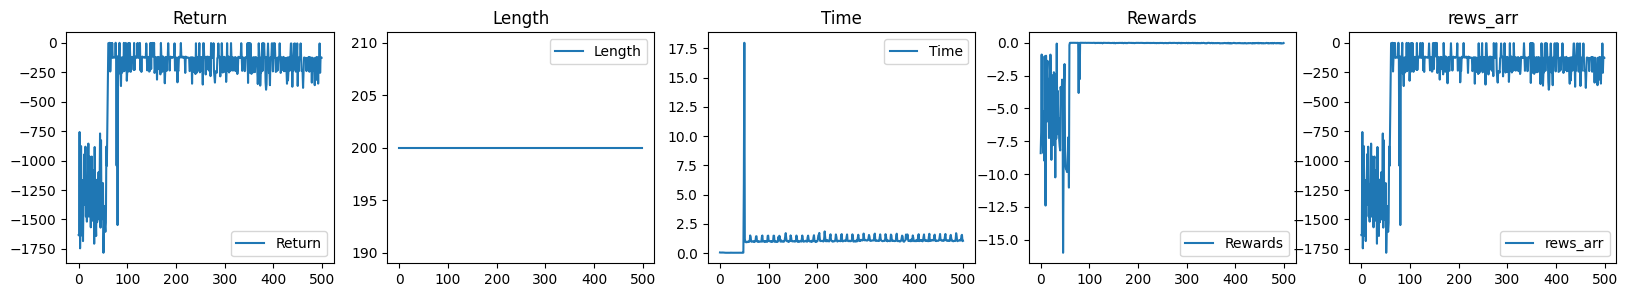

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 3))

ax1.plot(rs, label='Return')
ax1.legend()
ax1.set_title("Return")

ax2.plot(ls, label='Length')
ax2.legend()
ax2.set_title("Length")

ax3.plot(ts, label='Time')
ax3.legend()
ax3.set_title("Time")

ax4.plot(rewards, label='Rewards')
ax4.legend()
ax4.set_title("Rewards")

ax5.plot(rews_arr, label='rews_arr')
ax5.legend()
ax5.set_title("rews_arr")

plt.show()


In [ ]:
eval_env = gym.make("Pendulum-v1", render_mode="rgb_array") #
eval_env = wrap_gym(eval_env, rescale_actions=True)
eval_env = gym.wrappers.RecordVideo(eval_env, 'Pendulum_video')
eval_env = gym.wrappers.RecordEpisodeStatistics(eval_env, buffer_length=1)
evaluate(agent, eval_env, num_episodes=1)
eval_env.close()

### MountainCarContinuous-v0

In [34]:
env = gym.make("MountainCarContinuous-v0", render_mode=None)
env = wrap_gym(env, rescale_actions=True)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=1)

eval_env = gym.make("MountainCarContinuous-v0", render_mode=None) # "rgb_array"
eval_env = wrap_gym(eval_env, rescale_actions=True)
# eval_env = gym.wrappers.RecordVideo(eval_env, 'cartpole_video')
eval_env = gym.wrappers.RecordEpisodeStatistics(eval_env, buffer_length=1)

agent = ScoreMatchingLearner.create(42, env.observation_space, env.action_space)

replay_buffer = ReplayBuffer(env.observation_space, env.action_space, max_iter)

observation, _ = env.reset()
done = False

rs, ls, ts = [], [], []
rewards = []
rews = 0
rews_arr = []
pbar = trange(1, max_iter+1, desc='Training')
for i in pbar:
    if i < start_step:
        action = env.action_space.sample()
    else:
        action, agent = agent.sample_actions(observation)
        action = np.asarray(action)
    next_observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    rews += reward
    if not done or "TimeLimit.truncated" in info:
        mask = 1.0
    else:
        mask = 0.0

    replay_buffer.insert(
            dict(
                observations=observation,
                actions=action,
                rewards=reward,
                masks=mask,
                dones=done,
                next_observations=next_observation,
            )
        )
    observation = next_observation
    rewards.append(reward)
    if done:
        rews_arr.append(rews)
        rews = 0
        observation, _ = env.reset()
        done = False
        # print("Done Info:", info)
        pbar.set_postfix(info['episode'])
        rs.append(info['episode']['r'])
        ls.append(info['episode']['l'])
        ts.append(info['episode']['t'])

    if i >= start_step:
        batch = replay_buffer.sample(batch_size)
        agent, update_info = agent.update(batch)

        if i % print_interval == 0:
            print("Update Info:", update_info)
            print('rew_arrs : ', rews_arr[-1])


    if i % 100_000 == 0:
        eval_info = evaluate(agent, eval_env, num_episodes=num_episodes)
        print("Eval Info", eval_info)

eval_env.close()
env.close()

Training:  50%|█████     | 50000/100000 [00:27<08:27, 98.56it/s, r=-50.7, l=999, t=0.115]  

Update Info: {'actor_loss_mag': Array(0.01605487, dtype=float32), 'actor_loss_max': Array(0.01605487, dtype=float32), 'actor_loss_mean': Array(0.00290558, dtype=float32), 'actor_loss_min': Array(5.707458e-10, dtype=float32), 'actor_loss_std': Array(0.00338017, dtype=float32), 'c_loss_mag_1': Array(0.20063022, dtype=float32), 'c_loss_mag_2': Array(0.01140994, dtype=float32), 'c_loss_max_1': Array(0.20063022, dtype=float32), 'c_loss_max_2': Array(0.01140994, dtype=float32), 'c_loss_mean_1': Array(0.02229374, dtype=float32), 'c_loss_mean_2': Array(0.00324143, dtype=float32), 'c_loss_min_1': Array(2.7271833e-05, dtype=float32), 'c_loss_min_2': Array(3.1581794e-07, dtype=float32), 'c_loss_std_1': Array(0.02895295, dtype=float32), 'c_loss_std_2': Array(0.00288621, dtype=float32), 'critic_jacobian_mag': Array(0.05702971, dtype=float32), 'critic_jacobian_max': Array(0.01716946, dtype=float32), 'critic_jacobian_mean': Array(-0.0178704, dtype=float32), 'critic_jacobian_min': Array(-0.05702971, d

Training:  51%|█████     | 50993/100000 [00:34<06:33, 124.50it/s, r=-70.3, l=999, t=29.1]

Update Info: {'actor_loss_mag': Array(0.00504474, dtype=float32), 'actor_loss_max': Array(0.00504474, dtype=float32), 'actor_loss_mean': Array(0.00122672, dtype=float32), 'actor_loss_min': Array(1.1910689e-08, dtype=float32), 'actor_loss_std': Array(0.0013599, dtype=float32), 'c_loss_mag_1': Array(0.00748448, dtype=float32), 'c_loss_mag_2': Array(0.00562769, dtype=float32), 'c_loss_max_1': Array(0.00748448, dtype=float32), 'c_loss_max_2': Array(0.00562769, dtype=float32), 'c_loss_mean_1': Array(0.00118632, dtype=float32), 'c_loss_mean_2': Array(0.00112941, dtype=float32), 'c_loss_min_1': Array(5.992521e-08, dtype=float32), 'c_loss_min_2': Array(4.179732e-10, dtype=float32), 'c_loss_std_1': Array(0.0014866, dtype=float32), 'c_loss_std_2': Array(0.00124011, dtype=float32), 'critic_jacobian_mag': Array(0.17634612, dtype=float32), 'critic_jacobian_max': Array(0.1728367, dtype=float32), 'critic_jacobian_mean': Array(-0.01014237, dtype=float32), 'critic_jacobian_min': Array(-0.17634612, dtyp

Training:  52%|█████▏    | 52021/100000 [00:38<04:29, 178.20it/s, r=-69, l=999, t=4.62]

Update Info: {'actor_loss_mag': Array(0.0123508, dtype=float32), 'actor_loss_max': Array(0.0123508, dtype=float32), 'actor_loss_mean': Array(0.00188275, dtype=float32), 'actor_loss_min': Array(1.7380282e-08, dtype=float32), 'actor_loss_std': Array(0.00227509, dtype=float32), 'c_loss_mag_1': Array(0.33171314, dtype=float32), 'c_loss_mag_2': Array(0.3267125, dtype=float32), 'c_loss_max_1': Array(0.33171314, dtype=float32), 'c_loss_max_2': Array(0.3267125, dtype=float32), 'c_loss_mean_1': Array(0.00248556, dtype=float32), 'c_loss_mean_2': Array(0.00248258, dtype=float32), 'c_loss_min_1': Array(1.4520904e-06, dtype=float32), 'c_loss_min_2': Array(1.3192395e-08, dtype=float32), 'c_loss_std_1': Array(0.02066831, dtype=float32), 'c_loss_std_2': Array(0.02036989, dtype=float32), 'critic_jacobian_mag': Array(0.20015825, dtype=float32), 'critic_jacobian_max': Array(0.20015825, dtype=float32), 'critic_jacobian_mean': Array(-0.00265618, dtype=float32), 'critic_jacobian_min': Array(-0.19176097, dty

Training:  53%|█████▎    | 53023/100000 [00:44<05:54, 132.40it/s, r=39.8, l=859, t=4.18]

Update Info: {'actor_loss_mag': Array(0.01024388, dtype=float32), 'actor_loss_max': Array(0.01024388, dtype=float32), 'actor_loss_mean': Array(0.00168098, dtype=float32), 'actor_loss_min': Array(9.408967e-10, dtype=float32), 'actor_loss_std': Array(0.00222526, dtype=float32), 'c_loss_mag_1': Array(0.00656539, dtype=float32), 'c_loss_mag_2': Array(0.00649053, dtype=float32), 'c_loss_max_1': Array(0.00656539, dtype=float32), 'c_loss_max_2': Array(0.00649053, dtype=float32), 'c_loss_mean_1': Array(0.00132003, dtype=float32), 'c_loss_mean_2': Array(0.00130293, dtype=float32), 'c_loss_min_1': Array(2.501426e-07, dtype=float32), 'c_loss_min_2': Array(2.5841762e-06, dtype=float32), 'c_loss_std_1': Array(0.00121162, dtype=float32), 'c_loss_std_2': Array(0.00132529, dtype=float32), 'critic_jacobian_mag': Array(0.21193787, dtype=float32), 'critic_jacobian_max': Array(0.21193787, dtype=float32), 'critic_jacobian_mean': Array(-0.00200792, dtype=float32), 'critic_jacobian_min': Array(-0.18861221, d

Training:  54%|█████▍    | 54017/100000 [00:49<04:00, 191.17it/s, r=-70.2, l=999, t=5.84]

Update Info: {'actor_loss_mag': Array(0.06635559, dtype=float32), 'actor_loss_max': Array(0.06635559, dtype=float32), 'actor_loss_mean': Array(0.00190057, dtype=float32), 'actor_loss_min': Array(2.1281665e-10, dtype=float32), 'actor_loss_std': Array(0.00572306, dtype=float32), 'c_loss_mag_1': Array(0.05739374, dtype=float32), 'c_loss_mag_2': Array(0.06139887, dtype=float32), 'c_loss_max_1': Array(0.05739374, dtype=float32), 'c_loss_max_2': Array(0.06139887, dtype=float32), 'c_loss_mean_1': Array(0.00164227, dtype=float32), 'c_loss_mean_2': Array(0.00164281, dtype=float32), 'c_loss_min_1': Array(1.6389117e-07, dtype=float32), 'c_loss_min_2': Array(5.7862565e-07, dtype=float32), 'c_loss_std_1': Array(0.00401465, dtype=float32), 'c_loss_std_2': Array(0.00424008, dtype=float32), 'critic_jacobian_mag': Array(0.22911206, dtype=float32), 'critic_jacobian_max': Array(0.1367571, dtype=float32), 'critic_jacobian_mean': Array(-0.01366519, dtype=float32), 'critic_jacobian_min': Array(-0.22911206, 

Training:  55%|█████▌    | 55030/100000 [00:54<03:50, 194.90it/s, r=-67.8, l=999, t=4.88]

Update Info: {'actor_loss_mag': Array(0.01041759, dtype=float32), 'actor_loss_max': Array(0.01041759, dtype=float32), 'actor_loss_mean': Array(0.00102064, dtype=float32), 'actor_loss_min': Array(4.3491846e-09, dtype=float32), 'actor_loss_std': Array(0.00152216, dtype=float32), 'c_loss_mag_1': Array(0.00700321, dtype=float32), 'c_loss_mag_2': Array(0.0069715, dtype=float32), 'c_loss_max_1': Array(0.00700321, dtype=float32), 'c_loss_max_2': Array(0.0069715, dtype=float32), 'c_loss_mean_1': Array(0.0011379, dtype=float32), 'c_loss_mean_2': Array(0.00112645, dtype=float32), 'c_loss_min_1': Array(1.5076296e-10, dtype=float32), 'c_loss_min_2': Array(9.799629e-08, dtype=float32), 'c_loss_std_1': Array(0.00134751, dtype=float32), 'c_loss_std_2': Array(0.0013738, dtype=float32), 'critic_jacobian_mag': Array(0.21000701, dtype=float32), 'critic_jacobian_max': Array(0.16902585, dtype=float32), 'critic_jacobian_mean': Array(0.00012342, dtype=float32), 'critic_jacobian_min': Array(-0.21000701, dtype

Training:  56%|█████▌    | 56023/100000 [01:00<03:38, 200.86it/s, r=-68.8, l=999, t=5.85]

Update Info: {'actor_loss_mag': Array(0.00783047, dtype=float32), 'actor_loss_max': Array(0.00783047, dtype=float32), 'actor_loss_mean': Array(0.00130106, dtype=float32), 'actor_loss_min': Array(5.0816325e-08, dtype=float32), 'actor_loss_std': Array(0.0016407, dtype=float32), 'c_loss_mag_1': Array(0.00761516, dtype=float32), 'c_loss_mag_2': Array(0.00843523, dtype=float32), 'c_loss_max_1': Array(0.00761516, dtype=float32), 'c_loss_max_2': Array(0.00843523, dtype=float32), 'c_loss_mean_1': Array(0.00139586, dtype=float32), 'c_loss_mean_2': Array(0.00143846, dtype=float32), 'c_loss_min_1': Array(4.0347814e-08, dtype=float32), 'c_loss_min_2': Array(2.0954758e-07, dtype=float32), 'c_loss_std_1': Array(0.00109966, dtype=float32), 'c_loss_std_2': Array(0.001087, dtype=float32), 'critic_jacobian_mag': Array(0.19249727, dtype=float32), 'critic_jacobian_max': Array(0.19026491, dtype=float32), 'critic_jacobian_mean': Array(0.01752724, dtype=float32), 'critic_jacobian_min': Array(-0.19249727, dty

Training:  57%|█████▋    | 57026/100000 [01:05<03:31, 203.23it/s, r=-66.9, l=999, t=4.87]

Update Info: {'actor_loss_mag': Array(0.01284992, dtype=float32), 'actor_loss_max': Array(0.01284992, dtype=float32), 'actor_loss_mean': Array(0.0010273, dtype=float32), 'actor_loss_min': Array(1.3618111e-09, dtype=float32), 'actor_loss_std': Array(0.00155308, dtype=float32), 'c_loss_mag_1': Array(3.152108, dtype=float32), 'c_loss_mag_2': Array(3.111959, dtype=float32), 'c_loss_max_1': Array(3.152108, dtype=float32), 'c_loss_max_2': Array(3.111959, dtype=float32), 'c_loss_mean_1': Array(0.01358065, dtype=float32), 'c_loss_mean_2': Array(0.01342572, dtype=float32), 'c_loss_min_1': Array(7.635336e-09, dtype=float32), 'c_loss_min_2': Array(2.3586432e-07, dtype=float32), 'c_loss_std_1': Array(0.19654469, dtype=float32), 'c_loss_std_2': Array(0.19404079, dtype=float32), 'critic_jacobian_mag': Array(0.1823362, dtype=float32), 'critic_jacobian_max': Array(0.17317528, dtype=float32), 'critic_jacobian_mean': Array(-0.00202737, dtype=float32), 'critic_jacobian_min': Array(-0.1823362, dtype=float

Training:  58%|█████▊    | 58023/100000 [01:10<05:25, 128.94it/s, r=-69.5, l=999, t=5.06]

Update Info: {'actor_loss_mag': Array(0.00889218, dtype=float32), 'actor_loss_max': Array(0.00889218, dtype=float32), 'actor_loss_mean': Array(0.00118036, dtype=float32), 'actor_loss_min': Array(2.8442229e-09, dtype=float32), 'actor_loss_std': Array(0.00155288, dtype=float32), 'c_loss_mag_1': Array(4.5720363, dtype=float32), 'c_loss_mag_2': Array(4.6982765, dtype=float32), 'c_loss_max_1': Array(4.5720363, dtype=float32), 'c_loss_max_2': Array(4.6982765, dtype=float32), 'c_loss_mean_1': Array(0.0190828, dtype=float32), 'c_loss_mean_2': Array(0.01962203, dtype=float32), 'c_loss_min_1': Array(8.122015e-09, dtype=float32), 'c_loss_min_2': Array(1.814584e-08, dtype=float32), 'c_loss_std_1': Array(0.28512135, dtype=float32), 'c_loss_std_2': Array(0.29299283, dtype=float32), 'critic_jacobian_mag': Array(0.20488372, dtype=float32), 'critic_jacobian_max': Array(0.20488372, dtype=float32), 'critic_jacobian_mean': Array(0.00361278, dtype=float32), 'critic_jacobian_min': Array(-0.19703951, dtype=f

Training:  59%|█████▉    | 59019/100000 [01:15<03:26, 198.40it/s, r=-68.9, l=999, t=5.78]

Update Info: {'actor_loss_mag': Array(0.0292857, dtype=float32), 'actor_loss_max': Array(0.0292857, dtype=float32), 'actor_loss_mean': Array(0.00122738, dtype=float32), 'actor_loss_min': Array(2.6456252e-07, dtype=float32), 'actor_loss_std': Array(0.00226636, dtype=float32), 'c_loss_mag_1': Array(0.03550014, dtype=float32), 'c_loss_mag_2': Array(0.02807982, dtype=float32), 'c_loss_max_1': Array(0.03550014, dtype=float32), 'c_loss_max_2': Array(0.02807982, dtype=float32), 'c_loss_mean_1': Array(0.00155123, dtype=float32), 'c_loss_mean_2': Array(0.00146127, dtype=float32), 'c_loss_min_1': Array(5.0440804e-08, dtype=float32), 'c_loss_min_2': Array(2.4356837e-09, dtype=float32), 'c_loss_std_1': Array(0.00312628, dtype=float32), 'c_loss_std_2': Array(0.00262764, dtype=float32), 'critic_jacobian_mag': Array(0.19699499, dtype=float32), 'critic_jacobian_max': Array(0.19690886, dtype=float32), 'critic_jacobian_mean': Array(0.00811614, dtype=float32), 'critic_jacobian_min': Array(-0.19699499, dt

Training:  60%|██████    | 60030/100000 [01:20<03:22, 197.72it/s, r=-68.4, l=999, t=4.85]

Update Info: {'actor_loss_mag': Array(0.00915401, dtype=float32), 'actor_loss_max': Array(0.00915401, dtype=float32), 'actor_loss_mean': Array(0.00098879, dtype=float32), 'actor_loss_min': Array(1.4921177e-10, dtype=float32), 'actor_loss_std': Array(0.00131971, dtype=float32), 'c_loss_mag_1': Array(0.13950215, dtype=float32), 'c_loss_mag_2': Array(0.15918592, dtype=float32), 'c_loss_max_1': Array(0.13950215, dtype=float32), 'c_loss_max_2': Array(0.15918592, dtype=float32), 'c_loss_mean_1': Array(0.00192501, dtype=float32), 'c_loss_mean_2': Array(0.00197095, dtype=float32), 'c_loss_min_1': Array(1.2275113e-06, dtype=float32), 'c_loss_min_2': Array(2.4164365e-08, dtype=float32), 'c_loss_std_1': Array(0.00868426, dtype=float32), 'c_loss_std_2': Array(0.0099102, dtype=float32), 'critic_jacobian_mag': Array(0.2116661, dtype=float32), 'critic_jacobian_max': Array(0.19212693, dtype=float32), 'critic_jacobian_mean': Array(0.00440184, dtype=float32), 'critic_jacobian_min': Array(-0.2116661, dty

Training:  61%|██████    | 61021/100000 [01:26<03:21, 193.91it/s, r=-69.6, l=999, t=5.88]

Update Info: {'actor_loss_mag': Array(4.951784, dtype=float32), 'actor_loss_max': Array(4.951784, dtype=float32), 'actor_loss_mean': Array(0.0206825, dtype=float32), 'actor_loss_min': Array(2.639867e-08, dtype=float32), 'actor_loss_std': Array(0.3088039, dtype=float32), 'c_loss_mag_1': Array(0.1046178, dtype=float32), 'c_loss_mag_2': Array(0.04399294, dtype=float32), 'c_loss_max_1': Array(0.1046178, dtype=float32), 'c_loss_max_2': Array(0.04399294, dtype=float32), 'c_loss_mean_1': Array(0.00243585, dtype=float32), 'c_loss_mean_2': Array(0.0022985, dtype=float32), 'c_loss_min_1': Array(1.1949751e-06, dtype=float32), 'c_loss_min_2': Array(2.6446992e-06, dtype=float32), 'c_loss_std_1': Array(0.00666788, dtype=float32), 'c_loss_std_2': Array(0.00329004, dtype=float32), 'critic_jacobian_mag': Array(2.1859603, dtype=float32), 'critic_jacobian_max': Array(0.18524134, dtype=float32), 'critic_jacobian_mean': Array(-0.01467712, dtype=float32), 'critic_jacobian_min': Array(-2.1859603, dtype=float

Training:  62%|██████▏   | 62018/100000 [01:31<03:22, 187.46it/s, r=-69.3, l=999, t=4.93]

Update Info: {'actor_loss_mag': Array(0.0114007, dtype=float32), 'actor_loss_max': Array(0.0114007, dtype=float32), 'actor_loss_mean': Array(0.00126047, dtype=float32), 'actor_loss_min': Array(2.441518e-08, dtype=float32), 'actor_loss_std': Array(0.00181184, dtype=float32), 'c_loss_mag_1': Array(0.0466887, dtype=float32), 'c_loss_mag_2': Array(0.05297154, dtype=float32), 'c_loss_max_1': Array(0.0466887, dtype=float32), 'c_loss_max_2': Array(0.05297154, dtype=float32), 'c_loss_mean_1': Array(0.00143395, dtype=float32), 'c_loss_mean_2': Array(0.00150831, dtype=float32), 'c_loss_min_1': Array(6.790793e-08, dtype=float32), 'c_loss_min_2': Array(1.7348663e-07, dtype=float32), 'c_loss_std_1': Array(0.00340456, dtype=float32), 'c_loss_std_2': Array(0.00377199, dtype=float32), 'critic_jacobian_mag': Array(0.2569186, dtype=float32), 'critic_jacobian_max': Array(0.22367159, dtype=float32), 'critic_jacobian_mean': Array(0.0027398, dtype=float32), 'critic_jacobian_min': Array(-0.2569186, dtype=flo

Training:  63%|██████▎   | 63014/100000 [01:38<05:51, 105.12it/s, r=-66.1, l=999, t=5.6]

Update Info: {'actor_loss_mag': Array(0.60219973, dtype=float32), 'actor_loss_max': Array(0.60219973, dtype=float32), 'actor_loss_mean': Array(0.00605706, dtype=float32), 'actor_loss_min': Array(2.648251e-09, dtype=float32), 'actor_loss_std': Array(0.04552416, dtype=float32), 'c_loss_mag_1': Array(0.68449384, dtype=float32), 'c_loss_mag_2': Array(0.48233005, dtype=float32), 'c_loss_max_1': Array(0.68449384, dtype=float32), 'c_loss_max_2': Array(0.48233005, dtype=float32), 'c_loss_mean_1': Array(0.0085736, dtype=float32), 'c_loss_mean_2': Array(0.00769368, dtype=float32), 'c_loss_min_1': Array(3.0595402e-09, dtype=float32), 'c_loss_min_2': Array(3.915943e-10, dtype=float32), 'c_loss_std_1': Array(0.05871809, dtype=float32), 'c_loss_std_2': Array(0.05034991, dtype=float32), 'critic_jacobian_mag': Array(0.84995365, dtype=float32), 'critic_jacobian_max': Array(0.84995365, dtype=float32), 'critic_jacobian_mean': Array(-0.00291665, dtype=float32), 'critic_jacobian_min': Array(-0.24550147, dt

Training:  64%|██████▍   | 64027/100000 [01:43<02:55, 204.86it/s, r=-67.8, l=999, t=6.51]

Update Info: {'actor_loss_mag': Array(0.32569242, dtype=float32), 'actor_loss_max': Array(0.32569242, dtype=float32), 'actor_loss_mean': Array(0.00560229, dtype=float32), 'actor_loss_min': Array(1.720686e-08, dtype=float32), 'actor_loss_std': Array(0.02809203, dtype=float32), 'c_loss_mag_1': Array(10.838991, dtype=float32), 'c_loss_mag_2': Array(10.941174, dtype=float32), 'c_loss_max_1': Array(10.838991, dtype=float32), 'c_loss_max_2': Array(10.941174, dtype=float32), 'c_loss_mean_1': Array(0.05166032, dtype=float32), 'c_loss_mean_2': Array(0.05303232, dtype=float32), 'c_loss_min_1': Array(2.1393589e-07, dtype=float32), 'c_loss_min_2': Array(1.8468427e-10, dtype=float32), 'c_loss_std_1': Array(0.67916524, dtype=float32), 'c_loss_std_2': Array(0.68660593, dtype=float32), 'critic_jacobian_mag': Array(0.58676136, dtype=float32), 'critic_jacobian_max': Array(0.5502804, dtype=float32), 'critic_jacobian_mean': Array(0.00502421, dtype=float32), 'critic_jacobian_min': Array(-0.58676136, dtype=

Training:  65%|██████▌   | 65028/100000 [01:48<02:52, 202.65it/s, r=-71.1, l=999, t=4.83]

Update Info: {'actor_loss_mag': Array(0.03884099, dtype=float32), 'actor_loss_max': Array(0.03884099, dtype=float32), 'actor_loss_mean': Array(0.00199879, dtype=float32), 'actor_loss_min': Array(8.0200296e-10, dtype=float32), 'actor_loss_std': Array(0.00348827, dtype=float32), 'c_loss_mag_1': Array(0.09749762, dtype=float32), 'c_loss_mag_2': Array(0.07888499, dtype=float32), 'c_loss_max_1': Array(0.09749762, dtype=float32), 'c_loss_max_2': Array(0.07888499, dtype=float32), 'c_loss_mean_1': Array(0.00221544, dtype=float32), 'c_loss_mean_2': Array(0.00193338, dtype=float32), 'c_loss_min_1': Array(8.076677e-08, dtype=float32), 'c_loss_min_2': Array(8.977097e-07, dtype=float32), 'c_loss_std_1': Array(0.00617095, dtype=float32), 'c_loss_std_2': Array(0.00502496, dtype=float32), 'critic_jacobian_mag': Array(0.221993, dtype=float32), 'critic_jacobian_max': Array(0.221993, dtype=float32), 'critic_jacobian_mean': Array(-0.00234401, dtype=float32), 'critic_jacobian_min': Array(-0.21782236, dtype

Training:  66%|██████▌   | 66019/100000 [01:54<02:52, 197.35it/s, r=-69, l=999, t=5.89]

Update Info: {'actor_loss_mag': Array(0.05812853, dtype=float32), 'actor_loss_max': Array(0.05812853, dtype=float32), 'actor_loss_mean': Array(0.00260738, dtype=float32), 'actor_loss_min': Array(1.12603704e-10, dtype=float32), 'actor_loss_std': Array(0.00533822, dtype=float32), 'c_loss_mag_1': Array(0.02570718, dtype=float32), 'c_loss_mag_2': Array(0.02885659, dtype=float32), 'c_loss_max_1': Array(0.02570718, dtype=float32), 'c_loss_max_2': Array(0.02885659, dtype=float32), 'c_loss_mean_1': Array(0.00207768, dtype=float32), 'c_loss_mean_2': Array(0.00201285, dtype=float32), 'c_loss_min_1': Array(3.82785e-07, dtype=float32), 'c_loss_min_2': Array(2.2646509e-07, dtype=float32), 'c_loss_std_1': Array(0.00251482, dtype=float32), 'c_loss_std_2': Array(0.00273958, dtype=float32), 'critic_jacobian_mag': Array(0.25828135, dtype=float32), 'critic_jacobian_max': Array(0.23568621, dtype=float32), 'critic_jacobian_mean': Array(0.0070796, dtype=float32), 'critic_jacobian_min': Array(-0.25828135, dt

Training:  67%|██████▋   | 67027/100000 [01:59<02:56, 187.10it/s, r=-68.5, l=999, t=4.81]

Update Info: {'actor_loss_mag': Array(0.4755248, dtype=float32), 'actor_loss_max': Array(0.4755248, dtype=float32), 'actor_loss_mean': Array(0.00432389, dtype=float32), 'actor_loss_min': Array(1.06932916e-07, dtype=float32), 'actor_loss_std': Array(0.02968833, dtype=float32), 'c_loss_mag_1': Array(14.219804, dtype=float32), 'c_loss_mag_2': Array(14.313678, dtype=float32), 'c_loss_max_1': Array(14.219804, dtype=float32), 'c_loss_max_2': Array(14.313678, dtype=float32), 'c_loss_mean_1': Array(0.05739756, dtype=float32), 'c_loss_mean_2': Array(0.05759202, dtype=float32), 'c_loss_min_1': Array(2.0259506e-08, dtype=float32), 'c_loss_min_2': Array(5.9139893e-08, dtype=float32), 'c_loss_std_1': Array(0.88689375, dtype=float32), 'c_loss_std_2': Array(0.89275575, dtype=float32), 'critic_jacobian_mag': Array(0.8329855, dtype=float32), 'critic_jacobian_max': Array(0.8329855, dtype=float32), 'critic_jacobian_mean': Array(0.01339673, dtype=float32), 'critic_jacobian_min': Array(-0.24909353, dtype=f

Training:  68%|██████▊   | 68012/100000 [02:05<04:33, 116.97it/s, r=-67, l=999, t=5.24]

Update Info: {'actor_loss_mag': Array(0.5726505, dtype=float32), 'actor_loss_max': Array(0.5726505, dtype=float32), 'actor_loss_mean': Array(0.01088958, dtype=float32), 'actor_loss_min': Array(3.1604617e-07, dtype=float32), 'actor_loss_std': Array(0.03684546, dtype=float32), 'c_loss_mag_1': Array(0.14102279, dtype=float32), 'c_loss_mag_2': Array(0.15813634, dtype=float32), 'c_loss_max_1': Array(0.14102279, dtype=float32), 'c_loss_max_2': Array(0.15813634, dtype=float32), 'c_loss_mean_1': Array(0.01169165, dtype=float32), 'c_loss_mean_2': Array(0.01182073, dtype=float32), 'c_loss_min_1': Array(1.8787455e-07, dtype=float32), 'c_loss_min_2': Array(1.6973354e-07, dtype=float32), 'c_loss_std_1': Array(0.02044466, dtype=float32), 'c_loss_std_2': Array(0.02211873, dtype=float32), 'critic_jacobian_mag': Array(0.79369557, dtype=float32), 'critic_jacobian_max': Array(0.26081926, dtype=float32), 'critic_jacobian_mean': Array(-0.01352496, dtype=float32), 'critic_jacobian_min': Array(-0.79369557, d

Training:  69%|██████▉   | 69021/100000 [02:10<02:39, 193.95it/s, r=-67.1, l=999, t=5.59]

Update Info: {'actor_loss_mag': Array(0.06965891, dtype=float32), 'actor_loss_max': Array(0.06965891, dtype=float32), 'actor_loss_mean': Array(0.00333659, dtype=float32), 'actor_loss_min': Array(6.367735e-08, dtype=float32), 'actor_loss_std': Array(0.00631899, dtype=float32), 'c_loss_mag_1': Array(16.844492, dtype=float32), 'c_loss_mag_2': Array(16.677086, dtype=float32), 'c_loss_max_1': Array(16.844492, dtype=float32), 'c_loss_max_2': Array(16.677086, dtype=float32), 'c_loss_mean_1': Array(0.07916069, dtype=float32), 'c_loss_mean_2': Array(0.08091359, dtype=float32), 'c_loss_min_1': Array(1.4901161e-08, dtype=float32), 'c_loss_min_2': Array(5.748234e-09, dtype=float32), 'c_loss_std_1': Array(1.0630335, dtype=float32), 'c_loss_std_2': Array(1.0592813, dtype=float32), 'critic_jacobian_mag': Array(0.27713796, dtype=float32), 'critic_jacobian_max': Array(0.22523507, dtype=float32), 'critic_jacobian_mean': Array(0.01808986, dtype=float32), 'critic_jacobian_min': Array(-0.27713796, dtype=fl

Training:  70%|███████   | 70032/100000 [02:15<02:27, 203.08it/s, r=36.2, l=933, t=4.59]

Update Info: {'actor_loss_mag': Array(0.07763197, dtype=float32), 'actor_loss_max': Array(0.07763197, dtype=float32), 'actor_loss_mean': Array(0.0062121, dtype=float32), 'actor_loss_min': Array(1.7806903e-07, dtype=float32), 'actor_loss_std': Array(0.00958164, dtype=float32), 'c_loss_mag_1': Array(0.85830677, dtype=float32), 'c_loss_mag_2': Array(0.6152639, dtype=float32), 'c_loss_max_1': Array(0.85830677, dtype=float32), 'c_loss_max_2': Array(0.6152639, dtype=float32), 'c_loss_mean_1': Array(0.0080163, dtype=float32), 'c_loss_mean_2': Array(0.00616512, dtype=float32), 'c_loss_min_1': Array(7.569929e-08, dtype=float32), 'c_loss_min_2': Array(1.1510792e-08, dtype=float32), 'c_loss_std_1': Array(0.05513803, dtype=float32), 'c_loss_std_2': Array(0.03902669, dtype=float32), 'critic_jacobian_mag': Array(0.52577484, dtype=float32), 'critic_jacobian_max': Array(0.52577484, dtype=float32), 'critic_jacobian_mean': Array(-0.00047595, dtype=float32), 'critic_jacobian_min': Array(-0.30893028, dtyp

Training:  71%|███████   | 71029/100000 [02:20<02:24, 200.35it/s, r=-67.4, l=999, t=5.88]

Update Info: {'actor_loss_mag': Array(0.10164275, dtype=float32), 'actor_loss_max': Array(0.10164275, dtype=float32), 'actor_loss_mean': Array(0.00471236, dtype=float32), 'actor_loss_min': Array(7.366325e-08, dtype=float32), 'actor_loss_std': Array(0.00941403, dtype=float32), 'c_loss_mag_1': Array(0.41083214, dtype=float32), 'c_loss_mag_2': Array(0.35162038, dtype=float32), 'c_loss_max_1': Array(0.41083214, dtype=float32), 'c_loss_max_2': Array(0.35162038, dtype=float32), 'c_loss_mean_1': Array(0.00578151, dtype=float32), 'c_loss_mean_2': Array(0.00529016, dtype=float32), 'c_loss_min_1': Array(3.7664222e-08, dtype=float32), 'c_loss_min_2': Array(2.9033345e-09, dtype=float32), 'c_loss_std_1': Array(0.03290064, dtype=float32), 'c_loss_std_2': Array(0.02944633, dtype=float32), 'critic_jacobian_mag': Array(0.23358819, dtype=float32), 'critic_jacobian_max': Array(0.23358819, dtype=float32), 'critic_jacobian_mean': Array(0.01817232, dtype=float32), 'critic_jacobian_min': Array(-0.18774588, d

Training:  72%|███████▏  | 72025/100000 [02:25<02:19, 200.84it/s, r=51.8, l=700, t=3.46]

Update Info: {'actor_loss_mag': Array(1.303007, dtype=float32), 'actor_loss_max': Array(1.303007, dtype=float32), 'actor_loss_mean': Array(0.01084269, dtype=float32), 'actor_loss_min': Array(2.0075379e-07, dtype=float32), 'actor_loss_std': Array(0.0817924, dtype=float32), 'c_loss_mag_1': Array(0.01939223, dtype=float32), 'c_loss_mag_2': Array(0.04039764, dtype=float32), 'c_loss_max_1': Array(0.01939223, dtype=float32), 'c_loss_max_2': Array(0.04039764, dtype=float32), 'c_loss_mean_1': Array(0.00164451, dtype=float32), 'c_loss_mean_2': Array(0.00192018, dtype=float32), 'c_loss_min_1': Array(4.39941e-07, dtype=float32), 'c_loss_min_2': Array(1.1716338e-08, dtype=float32), 'c_loss_std_1': Array(0.00227564, dtype=float32), 'c_loss_std_2': Array(0.00349459, dtype=float32), 'critic_jacobian_mag': Array(2.569326, dtype=float32), 'critic_jacobian_max': Array(0.2928897, dtype=float32), 'critic_jacobian_mean': Array(-0.01822524, dtype=float32), 'critic_jacobian_min': Array(-2.569326, dtype=float

Training:  73%|███████▎  | 73021/100000 [02:31<02:18, 195.04it/s, r=32.8, l=972, t=4.8]

Update Info: {'actor_loss_mag': Array(1.5104831, dtype=float32), 'actor_loss_max': Array(1.5104831, dtype=float32), 'actor_loss_mean': Array(0.01160337, dtype=float32), 'actor_loss_min': Array(9.274598e-07, dtype=float32), 'actor_loss_std': Array(0.09420768, dtype=float32), 'c_loss_mag_1': Array(0.1849742, dtype=float32), 'c_loss_mag_2': Array(0.64674425, dtype=float32), 'c_loss_max_1': Array(0.1849742, dtype=float32), 'c_loss_max_2': Array(0.64674425, dtype=float32), 'c_loss_mean_1': Array(0.00293442, dtype=float32), 'c_loss_mean_2': Array(0.00470756, dtype=float32), 'c_loss_min_1': Array(3.565583e-08, dtype=float32), 'c_loss_min_2': Array(4.604317e-10, dtype=float32), 'c_loss_std_1': Array(0.01273618, dtype=float32), 'c_loss_std_2': Array(0.04074005, dtype=float32), 'critic_jacobian_mag': Array(2.8285465, dtype=float32), 'critic_jacobian_max': Array(2.8285465, dtype=float32), 'critic_jacobian_mean': Array(0.0114674, dtype=float32), 'critic_jacobian_min': Array(-0.36127043, dtype=floa

Training:  74%|███████▍  | 74035/100000 [02:36<02:05, 206.33it/s, r=-68.7, l=999, t=5.94]

Update Info: {'actor_loss_mag': Array(0.784092, dtype=float32), 'actor_loss_max': Array(0.784092, dtype=float32), 'actor_loss_mean': Array(0.01410733, dtype=float32), 'actor_loss_min': Array(4.2500725e-11, dtype=float32), 'actor_loss_std': Array(0.05399706, dtype=float32), 'c_loss_mag_1': Array(6.9415565, dtype=float32), 'c_loss_mag_2': Array(9.327007, dtype=float32), 'c_loss_max_1': Array(6.9415565, dtype=float32), 'c_loss_max_2': Array(9.327007, dtype=float32), 'c_loss_mean_1': Array(0.0466241, dtype=float32), 'c_loss_mean_2': Array(0.05612003, dtype=float32), 'c_loss_min_1': Array(2.3283064e-08, dtype=float32), 'c_loss_min_2': Array(1.28793545e-08, dtype=float32), 'c_loss_std_1': Array(0.48362392, dtype=float32), 'c_loss_std_2': Array(0.6206615, dtype=float32), 'critic_jacobian_mag': Array(3.168665, dtype=float32), 'critic_jacobian_max': Array(3.168665, dtype=float32), 'critic_jacobian_mean': Array(0.01246649, dtype=float32), 'critic_jacobian_min': Array(-1.1331452, dtype=float32), 

Training:  75%|███████▌  | 75012/100000 [02:41<03:22, 123.40it/s, r=-71.2, l=999, t=4.78]

Update Info: {'actor_loss_mag': Array(5.221266, dtype=float32), 'actor_loss_max': Array(5.221266, dtype=float32), 'actor_loss_mean': Array(0.0535121, dtype=float32), 'actor_loss_min': Array(1.44821435e-08, dtype=float32), 'actor_loss_std': Array(0.38510785, dtype=float32), 'c_loss_mag_1': Array(2.237548, dtype=float32), 'c_loss_mag_2': Array(2.6022618, dtype=float32), 'c_loss_max_1': Array(2.237548, dtype=float32), 'c_loss_max_2': Array(2.6022618, dtype=float32), 'c_loss_mean_1': Array(0.02230561, dtype=float32), 'c_loss_mean_2': Array(0.02538842, dtype=float32), 'c_loss_min_1': Array(1.0513759e-09, dtype=float32), 'c_loss_min_2': Array(3.5117637e-08, dtype=float32), 'c_loss_std_1': Array(0.15583852, dtype=float32), 'c_loss_std_2': Array(0.18236512, dtype=float32), 'critic_jacobian_mag': Array(6.427576, dtype=float32), 'critic_jacobian_max': Array(6.427576, dtype=float32), 'critic_jacobian_mean': Array(0.06795084, dtype=float32), 'critic_jacobian_min': Array(-0.33422196, dtype=float32)

Training:  76%|███████▌  | 76033/100000 [02:47<02:02, 195.36it/s, r=58.6, l=585, t=3.25]

Update Info: {'actor_loss_mag': Array(5.5534434, dtype=float32), 'actor_loss_max': Array(5.5534434, dtype=float32), 'actor_loss_mean': Array(0.07728544, dtype=float32), 'actor_loss_min': Array(2.390083e-07, dtype=float32), 'actor_loss_std': Array(0.44954577, dtype=float32), 'c_loss_mag_1': Array(2.534786, dtype=float32), 'c_loss_mag_2': Array(2.886189, dtype=float32), 'c_loss_max_1': Array(2.534786, dtype=float32), 'c_loss_max_2': Array(2.886189, dtype=float32), 'c_loss_mean_1': Array(0.02922991, dtype=float32), 'c_loss_mean_2': Array(0.03525293, dtype=float32), 'c_loss_min_1': Array(5.3225904e-09, dtype=float32), 'c_loss_min_2': Array(2.627587e-07, dtype=float32), 'c_loss_std_1': Array(0.17898498, dtype=float32), 'c_loss_std_2': Array(0.2214789, dtype=float32), 'critic_jacobian_mag': Array(6.2005424, dtype=float32), 'critic_jacobian_max': Array(6.2005424, dtype=float32), 'critic_jacobian_mean': Array(0.03903858, dtype=float32), 'critic_jacobian_min': Array(-0.34864154, dtype=float32),

Training:  77%|███████▋  | 77025/100000 [02:52<01:58, 193.90it/s, r=79.8, l=293, t=1.39]

Update Info: {'actor_loss_mag': Array(3.2621725, dtype=float32), 'actor_loss_max': Array(3.2621725, dtype=float32), 'actor_loss_mean': Array(0.11429595, dtype=float32), 'actor_loss_min': Array(7.877402e-08, dtype=float32), 'actor_loss_std': Array(0.40282583, dtype=float32), 'c_loss_mag_1': Array(6.5396447, dtype=float32), 'c_loss_mag_2': Array(5.4635744, dtype=float32), 'c_loss_max_1': Array(6.5396447, dtype=float32), 'c_loss_max_2': Array(5.4635744, dtype=float32), 'c_loss_mean_1': Array(0.10620972, dtype=float32), 'c_loss_mean_2': Array(0.08967255, dtype=float32), 'c_loss_min_1': Array(3.5130347e-07, dtype=float32), 'c_loss_min_2': Array(3.784953e-08, dtype=float32), 'c_loss_std_1': Array(0.5564102, dtype=float32), 'c_loss_std_2': Array(0.48782212, dtype=float32), 'critic_jacobian_mag': Array(5.9796467, dtype=float32), 'critic_jacobian_max': Array(5.9796467, dtype=float32), 'critic_jacobian_mean': Array(0.09437495, dtype=float32), 'critic_jacobian_min': Array(-1.9388435, dtype=float3

Training:  78%|███████▊  | 78036/100000 [02:58<01:53, 193.04it/s, r=-68.3, l=999, t=5.92]

Update Info: {'actor_loss_mag': Array(6.3613276, dtype=float32), 'actor_loss_max': Array(6.3613276, dtype=float32), 'actor_loss_mean': Array(0.08104994, dtype=float32), 'actor_loss_min': Array(2.7707961e-11, dtype=float32), 'actor_loss_std': Array(0.45400602, dtype=float32), 'c_loss_mag_1': Array(29.35079, dtype=float32), 'c_loss_mag_2': Array(29.80064, dtype=float32), 'c_loss_max_1': Array(29.35079, dtype=float32), 'c_loss_max_2': Array(29.80064, dtype=float32), 'c_loss_mean_1': Array(0.15794867, dtype=float32), 'c_loss_mean_2': Array(0.1679925, dtype=float32), 'c_loss_min_1': Array(2.4611154e-08, dtype=float32), 'c_loss_min_2': Array(1.7953653e-08, dtype=float32), 'c_loss_std_1': Array(1.836401, dtype=float32), 'c_loss_std_2': Array(1.871364, dtype=float32), 'critic_jacobian_mag': Array(3.9399128, dtype=float32), 'critic_jacobian_max': Array(3.9399128, dtype=float32), 'critic_jacobian_mean': Array(0.18626434, dtype=float32), 'critic_jacobian_min': Array(-0.5924997, dtype=float32), 'c

Training:  79%|███████▉  | 79022/100000 [03:03<01:44, 199.90it/s, r=74.5, l=344, t=1.71]

Update Info: {'actor_loss_mag': Array(10.416935, dtype=float32), 'actor_loss_max': Array(10.416935, dtype=float32), 'actor_loss_mean': Array(0.14993244, dtype=float32), 'actor_loss_min': Array(5.1036583e-08, dtype=float32), 'actor_loss_std': Array(0.8045014, dtype=float32), 'c_loss_mag_1': Array(2.4490654, dtype=float32), 'c_loss_mag_2': Array(1.9559796, dtype=float32), 'c_loss_max_1': Array(2.4490654, dtype=float32), 'c_loss_max_2': Array(1.9559796, dtype=float32), 'c_loss_mean_1': Array(0.07271942, dtype=float32), 'c_loss_mean_2': Array(0.06457882, dtype=float32), 'c_loss_min_1': Array(1.2227613e-06, dtype=float32), 'c_loss_min_2': Array(8.451898e-07, dtype=float32), 'c_loss_std_1': Array(0.248499, dtype=float32), 'c_loss_std_2': Array(0.21361473, dtype=float32), 'critic_jacobian_mag': Array(9.947762, dtype=float32), 'critic_jacobian_max': Array(9.947762, dtype=float32), 'critic_jacobian_mean': Array(0.44381726, dtype=float32), 'critic_jacobian_min': Array(-0.7107688, dtype=float32),

Training:  80%|████████  | 80017/100000 [03:09<02:40, 124.35it/s, r=87.9, l=156, t=1.19]

Update Info: {'actor_loss_mag': Array(1.6734258, dtype=float32), 'actor_loss_max': Array(1.6734258, dtype=float32), 'actor_loss_mean': Array(0.09968677, dtype=float32), 'actor_loss_min': Array(5.2968304e-08, dtype=float32), 'actor_loss_std': Array(0.26905164, dtype=float32), 'c_loss_mag_1': Array(3.5205476, dtype=float32), 'c_loss_mag_2': Array(5.538569, dtype=float32), 'c_loss_max_1': Array(3.5205476, dtype=float32), 'c_loss_max_2': Array(5.538569, dtype=float32), 'c_loss_mean_1': Array(0.1033686, dtype=float32), 'c_loss_mean_2': Array(0.11157568, dtype=float32), 'c_loss_min_1': Array(4.3175623e-07, dtype=float32), 'c_loss_min_2': Array(6.8365716e-07, dtype=float32), 'c_loss_std_1': Array(0.32755315, dtype=float32), 'c_loss_std_2': Array(0.39890483, dtype=float32), 'critic_jacobian_mag': Array(6.474578, dtype=float32), 'critic_jacobian_max': Array(6.474578, dtype=float32), 'critic_jacobian_mean': Array(0.33852953, dtype=float32), 'critic_jacobian_min': Array(-1.2783132, dtype=float32)

Training:  81%|████████  | 81031/100000 [03:14<01:33, 202.57it/s, r=80.9, l=228, t=1.08]

Update Info: {'actor_loss_mag': Array(8.497155, dtype=float32), 'actor_loss_max': Array(8.497155, dtype=float32), 'actor_loss_mean': Array(0.13430312, dtype=float32), 'actor_loss_min': Array(5.937567e-06, dtype=float32), 'actor_loss_std': Array(0.564913, dtype=float32), 'c_loss_mag_1': Array(10.881713, dtype=float32), 'c_loss_mag_2': Array(14.947646, dtype=float32), 'c_loss_max_1': Array(10.881713, dtype=float32), 'c_loss_max_2': Array(14.947646, dtype=float32), 'c_loss_mean_1': Array(0.1567289, dtype=float32), 'c_loss_mean_2': Array(0.17600924, dtype=float32), 'c_loss_min_1': Array(1.7320417e-08, dtype=float32), 'c_loss_min_2': Array(8.9319747e-07, dtype=float32), 'c_loss_std_1': Array(0.78867984, dtype=float32), 'c_loss_std_2': Array(0.97175056, dtype=float32), 'critic_jacobian_mag': Array(5.5780163, dtype=float32), 'critic_jacobian_max': Array(5.5780163, dtype=float32), 'critic_jacobian_mean': Array(0.5993669, dtype=float32), 'critic_jacobian_min': Array(-1.0482943, dtype=float32), 

Training:  82%|████████▏ | 82025/100000 [03:19<01:32, 194.60it/s, r=89.2, l=142, t=0.69]

Update Info: {'actor_loss_mag': Array(5.1183043, dtype=float32), 'actor_loss_max': Array(5.1183043, dtype=float32), 'actor_loss_mean': Array(0.23493658, dtype=float32), 'actor_loss_min': Array(2.6167518e-07, dtype=float32), 'actor_loss_std': Array(0.4869737, dtype=float32), 'c_loss_mag_1': Array(12.323713, dtype=float32), 'c_loss_mag_2': Array(13.760379, dtype=float32), 'c_loss_max_1': Array(12.323713, dtype=float32), 'c_loss_max_2': Array(13.760379, dtype=float32), 'c_loss_mean_1': Array(0.48909995, dtype=float32), 'c_loss_mean_2': Array(0.4954717, dtype=float32), 'c_loss_min_1': Array(1.6797009e-07, dtype=float32), 'c_loss_min_2': Array(1.866365e-07, dtype=float32), 'c_loss_std_1': Array(1.385188, dtype=float32), 'c_loss_std_2': Array(1.520887, dtype=float32), 'critic_jacobian_mag': Array(5.133802, dtype=float32), 'critic_jacobian_max': Array(5.133802, dtype=float32), 'critic_jacobian_mean': Array(0.5020673, dtype=float32), 'critic_jacobian_min': Array(-0.8725364, dtype=float32), 'cr

Training:  83%|████████▎ | 83025/100000 [03:25<01:30, 188.25it/s, r=88.3, l=145, t=0.727]

Update Info: {'actor_loss_mag': Array(2.4373102, dtype=float32), 'actor_loss_max': Array(2.4373102, dtype=float32), 'actor_loss_mean': Array(0.11056264, dtype=float32), 'actor_loss_min': Array(2.6133864e-06, dtype=float32), 'actor_loss_std': Array(0.27974224, dtype=float32), 'c_loss_mag_1': Array(38.5372, dtype=float32), 'c_loss_mag_2': Array(35.781208, dtype=float32), 'c_loss_max_1': Array(38.5372, dtype=float32), 'c_loss_max_2': Array(35.781208, dtype=float32), 'c_loss_mean_1': Array(0.51254815, dtype=float32), 'c_loss_mean_2': Array(0.4885028, dtype=float32), 'c_loss_min_1': Array(1.2383771e-07, dtype=float32), 'c_loss_min_2': Array(4.5309425e-06, dtype=float32), 'c_loss_std_1': Array(2.749375, dtype=float32), 'c_loss_std_2': Array(2.573829, dtype=float32), 'critic_jacobian_mag': Array(6.712835, dtype=float32), 'critic_jacobian_max': Array(6.712835, dtype=float32), 'critic_jacobian_mean': Array(0.45083275, dtype=float32), 'critic_jacobian_min': Array(-0.8507888, dtype=float32), 'cri

Training:  84%|████████▍ | 84022/100000 [03:30<01:19, 201.10it/s, r=84.7, l=187, t=0.924]

Update Info: {'actor_loss_mag': Array(4.951855, dtype=float32), 'actor_loss_max': Array(4.951855, dtype=float32), 'actor_loss_mean': Array(0.35070798, dtype=float32), 'actor_loss_min': Array(1.9242652e-06, dtype=float32), 'actor_loss_std': Array(0.6437917, dtype=float32), 'c_loss_mag_1': Array(74.16719, dtype=float32), 'c_loss_mag_2': Array(73.16607, dtype=float32), 'c_loss_max_1': Array(74.16719, dtype=float32), 'c_loss_max_2': Array(73.16607, dtype=float32), 'c_loss_mean_1': Array(0.7972554, dtype=float32), 'c_loss_mean_2': Array(0.89913785, dtype=float32), 'c_loss_min_1': Array(1.6822014e-08, dtype=float32), 'c_loss_min_2': Array(1.2477918e-05, dtype=float32), 'c_loss_std_1': Array(5.4494114, dtype=float32), 'c_loss_std_2': Array(5.516487, dtype=float32), 'critic_jacobian_mag': Array(5.631492, dtype=float32), 'critic_jacobian_max': Array(5.631492, dtype=float32), 'critic_jacobian_mean': Array(0.5611123, dtype=float32), 'critic_jacobian_min': Array(-0.81114113, dtype=float32), 'criti

Training:  85%|████████▌ | 85040/100000 [03:36<01:16, 196.54it/s, r=93.5, l=71, t=0.341]

Update Info: {'actor_loss_mag': Array(10.599636, dtype=float32), 'actor_loss_max': Array(10.599636, dtype=float32), 'actor_loss_mean': Array(0.25105545, dtype=float32), 'actor_loss_min': Array(2.4512135e-06, dtype=float32), 'actor_loss_std': Array(0.76017904, dtype=float32), 'c_loss_mag_1': Array(5.59906, dtype=float32), 'c_loss_mag_2': Array(8.655996, dtype=float32), 'c_loss_max_1': Array(5.59906, dtype=float32), 'c_loss_max_2': Array(8.655996, dtype=float32), 'c_loss_mean_1': Array(0.39221716, dtype=float32), 'c_loss_mean_2': Array(0.4453383, dtype=float32), 'c_loss_min_1': Array(2.8095532e-05, dtype=float32), 'c_loss_min_2': Array(4.8300717e-06, dtype=float32), 'c_loss_std_1': Array(0.71382767, dtype=float32), 'c_loss_std_2': Array(0.9764669, dtype=float32), 'critic_jacobian_mag': Array(7.3503413, dtype=float32), 'critic_jacobian_max': Array(7.3503413, dtype=float32), 'critic_jacobian_mean': Array(0.10058529, dtype=float32), 'critic_jacobian_min': Array(-2.1066656, dtype=float32), '

Training:  86%|████████▌ | 86025/100000 [03:41<01:11, 195.35it/s, r=93.4, l=73, t=0.358]

Update Info: {'actor_loss_mag': Array(3.9049165, dtype=float32), 'actor_loss_max': Array(3.9049165, dtype=float32), 'actor_loss_mean': Array(0.1953298, dtype=float32), 'actor_loss_min': Array(6.003178e-06, dtype=float32), 'actor_loss_std': Array(0.37037498, dtype=float32), 'c_loss_mag_1': Array(43.11931, dtype=float32), 'c_loss_mag_2': Array(89.42422, dtype=float32), 'c_loss_max_1': Array(43.11931, dtype=float32), 'c_loss_max_2': Array(89.42422, dtype=float32), 'c_loss_mean_1': Array(0.7943357, dtype=float32), 'c_loss_mean_2': Array(1.0430171, dtype=float32), 'c_loss_min_1': Array(5.658208e-09, dtype=float32), 'c_loss_min_2': Array(1.0634703e-05, dtype=float32), 'c_loss_std_1': Array(4.018716, dtype=float32), 'c_loss_std_2': Array(6.481445, dtype=float32), 'critic_jacobian_mag': Array(5.495552, dtype=float32), 'critic_jacobian_max': Array(5.495552, dtype=float32), 'critic_jacobian_mean': Array(-0.16402732, dtype=float32), 'critic_jacobian_min': Array(-2.3561144, dtype=float32), 'critic

Training:  87%|████████▋ | 87022/100000 [03:46<01:40, 129.42it/s, r=93.4, l=74, t=0.566]

Update Info: {'actor_loss_mag': Array(5.1115117, dtype=float32), 'actor_loss_max': Array(5.1115117, dtype=float32), 'actor_loss_mean': Array(0.16834721, dtype=float32), 'actor_loss_min': Array(5.9721117e-10, dtype=float32), 'actor_loss_std': Array(0.4789593, dtype=float32), 'c_loss_mag_1': Array(18.31004, dtype=float32), 'c_loss_mag_2': Array(19.999851, dtype=float32), 'c_loss_max_1': Array(18.31004, dtype=float32), 'c_loss_max_2': Array(19.999851, dtype=float32), 'c_loss_mean_1': Array(0.6045755, dtype=float32), 'c_loss_mean_2': Array(0.58128613, dtype=float32), 'c_loss_min_1': Array(5.734474e-06, dtype=float32), 'c_loss_min_2': Array(7.043127e-09, dtype=float32), 'c_loss_std_1': Array(1.5882194, dtype=float32), 'c_loss_std_2': Array(1.6338484, dtype=float32), 'critic_jacobian_mag': Array(6.492361, dtype=float32), 'critic_jacobian_max': Array(6.492361, dtype=float32), 'critic_jacobian_mean': Array(-0.1761122, dtype=float32), 'critic_jacobian_min': Array(-2.8145719, dtype=float32), 'cr

Training:  88%|████████▊ | 88021/100000 [03:52<01:02, 193.04it/s, r=93.6, l=71, t=0.328]

Update Info: {'actor_loss_mag': Array(6.253913, dtype=float32), 'actor_loss_max': Array(6.253913, dtype=float32), 'actor_loss_mean': Array(0.20024109, dtype=float32), 'actor_loss_min': Array(3.757636e-06, dtype=float32), 'actor_loss_std': Array(0.4995674, dtype=float32), 'c_loss_mag_1': Array(2349.3467, dtype=float32), 'c_loss_mag_2': Array(2362.3499, dtype=float32), 'c_loss_max_1': Array(2349.3467, dtype=float32), 'c_loss_max_2': Array(2362.3499, dtype=float32), 'c_loss_mean_1': Array(9.671665, dtype=float32), 'c_loss_mean_2': Array(9.728301, dtype=float32), 'c_loss_min_1': Array(2.5669578e-08, dtype=float32), 'c_loss_min_2': Array(6.2458974e-05, dtype=float32), 'c_loss_std_1': Array(146.52817, dtype=float32), 'c_loss_std_2': Array(147.3357, dtype=float32), 'critic_jacobian_mag': Array(5.667988, dtype=float32), 'critic_jacobian_max': Array(5.667988, dtype=float32), 'critic_jacobian_mean': Array(-0.2733845, dtype=float32), 'critic_jacobian_min': Array(-2.7193832, dtype=float32), 'criti

Training:  89%|████████▉ | 89034/100000 [03:57<00:56, 192.94it/s, r=93.4, l=72, t=0.381]

Update Info: {'actor_loss_mag': Array(8.80073, dtype=float32), 'actor_loss_max': Array(8.80073, dtype=float32), 'actor_loss_mean': Array(0.31954962, dtype=float32), 'actor_loss_min': Array(1.644418e-05, dtype=float32), 'actor_loss_std': Array(0.6669857, dtype=float32), 'c_loss_mag_1': Array(16.40869, dtype=float32), 'c_loss_mag_2': Array(14.988571, dtype=float32), 'c_loss_max_1': Array(16.40869, dtype=float32), 'c_loss_max_2': Array(14.988571, dtype=float32), 'c_loss_mean_1': Array(0.7057198, dtype=float32), 'c_loss_mean_2': Array(0.59468675, dtype=float32), 'c_loss_min_1': Array(4.861562e-06, dtype=float32), 'c_loss_min_2': Array(1.740034e-05, dtype=float32), 'c_loss_std_1': Array(2.0590537, dtype=float32), 'c_loss_std_2': Array(1.8059953, dtype=float32), 'critic_jacobian_mag': Array(9.206675, dtype=float32), 'critic_jacobian_max': Array(9.206675, dtype=float32), 'critic_jacobian_mean': Array(-0.48155093, dtype=float32), 'critic_jacobian_min': Array(-3.7147021, dtype=float32), 'critic

Training:  90%|█████████ | 90029/100000 [04:03<00:52, 189.14it/s, r=93, l=77, t=0.366]

Update Info: {'actor_loss_mag': Array(5.2118998, dtype=float32), 'actor_loss_max': Array(5.2118998, dtype=float32), 'actor_loss_mean': Array(0.25462818, dtype=float32), 'actor_loss_min': Array(4.9111023e-08, dtype=float32), 'actor_loss_std': Array(0.61622417, dtype=float32), 'c_loss_mag_1': Array(1980.2275, dtype=float32), 'c_loss_mag_2': Array(1938.5581, dtype=float32), 'c_loss_max_1': Array(1980.2275, dtype=float32), 'c_loss_max_2': Array(1938.5581, dtype=float32), 'c_loss_mean_1': Array(8.239963, dtype=float32), 'c_loss_mean_2': Array(8.124065, dtype=float32), 'c_loss_min_1': Array(7.4601267e-06, dtype=float32), 'c_loss_min_2': Array(2.310262e-07, dtype=float32), 'c_loss_std_1': Array(123.50554, dtype=float32), 'c_loss_std_2': Array(120.90252, dtype=float32), 'critic_jacobian_mag': Array(10.315012, dtype=float32), 'critic_jacobian_max': Array(10.315012, dtype=float32), 'critic_jacobian_mean': Array(-0.30015364, dtype=float32), 'critic_jacobian_min': Array(-2.9370012, dtype=float32),

Training:  91%|█████████ | 91026/100000 [04:08<00:46, 193.00it/s, r=92.7, l=79, t=0.415]

Update Info: {'actor_loss_mag': Array(3.0349073, dtype=float32), 'actor_loss_max': Array(3.0349073, dtype=float32), 'actor_loss_mean': Array(0.25042534, dtype=float32), 'actor_loss_min': Array(3.3984614e-07, dtype=float32), 'actor_loss_std': Array(0.47839892, dtype=float32), 'c_loss_mag_1': Array(2952.2039, dtype=float32), 'c_loss_mag_2': Array(2935.9583, dtype=float32), 'c_loss_max_1': Array(2952.2039, dtype=float32), 'c_loss_max_2': Array(2935.9583, dtype=float32), 'c_loss_mean_1': Array(12.610119, dtype=float32), 'c_loss_mean_2': Array(12.459202, dtype=float32), 'c_loss_min_1': Array(2.7220267e-06, dtype=float32), 'c_loss_min_2': Array(6.0258353e-06, dtype=float32), 'c_loss_std_1': Array(184.15773, dtype=float32), 'c_loss_std_2': Array(183.15395, dtype=float32), 'critic_jacobian_mag': Array(7.351515, dtype=float32), 'critic_jacobian_max': Array(7.351515, dtype=float32), 'critic_jacobian_mean': Array(-0.30654275, dtype=float32), 'critic_jacobian_min': Array(-3.0227892, dtype=float32)

Training:  92%|█████████▏| 92010/100000 [04:13<01:07, 119.18it/s, r=92.5, l=83, t=0.619]

Update Info: {'actor_loss_mag': Array(4.4090295, dtype=float32), 'actor_loss_max': Array(4.4090295, dtype=float32), 'actor_loss_mean': Array(0.15119447, dtype=float32), 'actor_loss_min': Array(1.9570508e-07, dtype=float32), 'actor_loss_std': Array(0.3574178, dtype=float32), 'c_loss_mag_1': Array(49.993122, dtype=float32), 'c_loss_mag_2': Array(50.83433, dtype=float32), 'c_loss_max_1': Array(49.993122, dtype=float32), 'c_loss_max_2': Array(50.83433, dtype=float32), 'c_loss_mean_1': Array(0.9885086, dtype=float32), 'c_loss_mean_2': Array(0.93266374, dtype=float32), 'c_loss_min_1': Array(1.3625831e-06, dtype=float32), 'c_loss_min_2': Array(9.313226e-08, dtype=float32), 'c_loss_std_1': Array(5.0997963, dtype=float32), 'c_loss_std_2': Array(4.5946865, dtype=float32), 'critic_jacobian_mag': Array(9.9995, dtype=float32), 'critic_jacobian_max': Array(9.9995, dtype=float32), 'critic_jacobian_mean': Array(-0.26306194, dtype=float32), 'critic_jacobian_min': Array(-4.4791465, dtype=float32), 'crit

Training:  93%|█████████▎| 93020/100000 [04:19<00:36, 189.11it/s, r=93.2, l=77, t=0.377]

Update Info: {'actor_loss_mag': Array(1.9327677, dtype=float32), 'actor_loss_max': Array(1.9327677, dtype=float32), 'actor_loss_mean': Array(0.09851515, dtype=float32), 'actor_loss_min': Array(4.4025734e-07, dtype=float32), 'actor_loss_std': Array(0.20334849, dtype=float32), 'c_loss_mag_1': Array(15.836358, dtype=float32), 'c_loss_mag_2': Array(13.586012, dtype=float32), 'c_loss_max_1': Array(15.836358, dtype=float32), 'c_loss_max_2': Array(13.586012, dtype=float32), 'c_loss_mean_1': Array(0.53045875, dtype=float32), 'c_loss_mean_2': Array(0.6241766, dtype=float32), 'c_loss_min_1': Array(1.2424076e-05, dtype=float32), 'c_loss_min_2': Array(2.4972542e-07, dtype=float32), 'c_loss_std_1': Array(1.5328842, dtype=float32), 'c_loss_std_2': Array(1.5989536, dtype=float32), 'critic_jacobian_mag': Array(9.700457, dtype=float32), 'critic_jacobian_max': Array(9.700457, dtype=float32), 'critic_jacobian_mean': Array(-0.18052205, dtype=float32), 'critic_jacobian_min': Array(-2.7211738, dtype=float32

Training:  94%|█████████▍| 94029/100000 [04:24<00:30, 196.40it/s, r=92.6, l=82, t=0.402]

Update Info: {'actor_loss_mag': Array(1.3617191, dtype=float32), 'actor_loss_max': Array(1.3617191, dtype=float32), 'actor_loss_mean': Array(0.10791276, dtype=float32), 'actor_loss_min': Array(8.631332e-06, dtype=float32), 'actor_loss_std': Array(0.18260828, dtype=float32), 'c_loss_mag_1': Array(41.509163, dtype=float32), 'c_loss_mag_2': Array(34.339474, dtype=float32), 'c_loss_max_1': Array(41.509163, dtype=float32), 'c_loss_max_2': Array(34.339474, dtype=float32), 'c_loss_mean_1': Array(0.63682246, dtype=float32), 'c_loss_mean_2': Array(0.6644193, dtype=float32), 'c_loss_min_1': Array(2.7535862e-06, dtype=float32), 'c_loss_min_2': Array(6.4173946e-07, dtype=float32), 'c_loss_std_1': Array(2.9806201, dtype=float32), 'c_loss_std_2': Array(2.711511, dtype=float32), 'critic_jacobian_mag': Array(7.686516, dtype=float32), 'critic_jacobian_max': Array(7.686516, dtype=float32), 'critic_jacobian_mean': Array(-0.32112485, dtype=float32), 'critic_jacobian_min': Array(-2.9370103, dtype=float32),

Training:  95%|█████████▌| 95037/100000 [04:30<00:25, 196.21it/s, r=84.2, l=179, t=0.873]

Update Info: {'actor_loss_mag': Array(1.6041032, dtype=float32), 'actor_loss_max': Array(1.6041032, dtype=float32), 'actor_loss_mean': Array(0.10971269, dtype=float32), 'actor_loss_min': Array(8.439696e-06, dtype=float32), 'actor_loss_std': Array(0.20156543, dtype=float32), 'c_loss_mag_1': Array(62.687042, dtype=float32), 'c_loss_mag_2': Array(53.19574, dtype=float32), 'c_loss_max_1': Array(62.687042, dtype=float32), 'c_loss_max_2': Array(53.19574, dtype=float32), 'c_loss_mean_1': Array(0.761658, dtype=float32), 'c_loss_mean_2': Array(0.84760034, dtype=float32), 'c_loss_min_1': Array(9.313226e-08, dtype=float32), 'c_loss_min_2': Array(1.2238161e-08, dtype=float32), 'c_loss_std_1': Array(4.069814, dtype=float32), 'c_loss_std_2': Array(3.598392, dtype=float32), 'critic_jacobian_mag': Array(9.2153425, dtype=float32), 'critic_jacobian_max': Array(9.2153425, dtype=float32), 'critic_jacobian_mean': Array(-0.24716324, dtype=float32), 'critic_jacobian_min': Array(-3.7669358, dtype=float32), 'c

Training:  96%|█████████▌| 96024/100000 [04:34<00:20, 197.19it/s, r=93.2, l=75, t=0.392]

Update Info: {'actor_loss_mag': Array(1.5406052, dtype=float32), 'actor_loss_max': Array(1.5406052, dtype=float32), 'actor_loss_mean': Array(0.10065269, dtype=float32), 'actor_loss_min': Array(2.6439723e-06, dtype=float32), 'actor_loss_std': Array(0.17307013, dtype=float32), 'c_loss_mag_1': Array(695.1936, dtype=float32), 'c_loss_mag_2': Array(712.7334, dtype=float32), 'c_loss_max_1': Array(695.1936, dtype=float32), 'c_loss_max_2': Array(712.7334, dtype=float32), 'c_loss_mean_1': Array(3.861225, dtype=float32), 'c_loss_mean_2': Array(3.9438686, dtype=float32), 'c_loss_min_1': Array(1.5558267e-05, dtype=float32), 'c_loss_min_2': Array(1.8598257e-06, dtype=float32), 'c_loss_std_1': Array(43.98388, dtype=float32), 'c_loss_std_2': Array(45.061314, dtype=float32), 'critic_jacobian_mag': Array(9.241009, dtype=float32), 'critic_jacobian_max': Array(9.241009, dtype=float32), 'critic_jacobian_mean': Array(-0.3567329, dtype=float32), 'critic_jacobian_min': Array(-3.8830287, dtype=float32), 'crit

Training:  97%|█████████▋| 97011/100000 [04:41<00:29, 100.85it/s, r=92.7, l=79, t=0.67]

Update Info: {'actor_loss_mag': Array(1.2100046, dtype=float32), 'actor_loss_max': Array(1.2100046, dtype=float32), 'actor_loss_mean': Array(0.11474531, dtype=float32), 'actor_loss_min': Array(7.735138e-07, dtype=float32), 'actor_loss_std': Array(0.17465743, dtype=float32), 'c_loss_mag_1': Array(751.0027, dtype=float32), 'c_loss_mag_2': Array(750.89386, dtype=float32), 'c_loss_max_1': Array(751.0027, dtype=float32), 'c_loss_max_2': Array(750.89386, dtype=float32), 'c_loss_mean_1': Array(3.678107, dtype=float32), 'c_loss_mean_2': Array(3.679914, dtype=float32), 'c_loss_min_1': Array(1.2316741e-07, dtype=float32), 'c_loss_min_2': Array(2.678149e-06, dtype=float32), 'c_loss_std_1': Array(46.87921, dtype=float32), 'c_loss_std_2': Array(46.86377, dtype=float32), 'critic_jacobian_mag': Array(8.346313, dtype=float32), 'critic_jacobian_max': Array(8.346313, dtype=float32), 'critic_jacobian_mean': Array(-0.21352421, dtype=float32), 'critic_jacobian_min': Array(-3.043347, dtype=float32), 'critic

Training:  98%|█████████▊| 98031/100000 [04:46<00:09, 200.76it/s, r=92.8, l=81, t=0.405]

Update Info: {'actor_loss_mag': Array(3.689435, dtype=float32), 'actor_loss_max': Array(3.689435, dtype=float32), 'actor_loss_mean': Array(0.15610391, dtype=float32), 'actor_loss_min': Array(9.789183e-06, dtype=float32), 'actor_loss_std': Array(0.34062004, dtype=float32), 'c_loss_mag_1': Array(18.556618, dtype=float32), 'c_loss_mag_2': Array(24.812746, dtype=float32), 'c_loss_max_1': Array(18.556618, dtype=float32), 'c_loss_max_2': Array(24.812746, dtype=float32), 'c_loss_mean_1': Array(0.77106255, dtype=float32), 'c_loss_mean_2': Array(0.90935063, dtype=float32), 'c_loss_min_1': Array(9.73897e-05, dtype=float32), 'c_loss_min_2': Array(0.00013237, dtype=float32), 'c_loss_std_1': Array(1.863276, dtype=float32), 'c_loss_std_2': Array(2.2649646, dtype=float32), 'critic_jacobian_mag': Array(7.9413204, dtype=float32), 'critic_jacobian_max': Array(7.9413204, dtype=float32), 'critic_jacobian_mean': Array(-0.4417339, dtype=float32), 'critic_jacobian_min': Array(-4.501566, dtype=float32), 'crit

Training:  99%|█████████▉| 99026/100000 [04:51<00:05, 181.08it/s, r=91.5, l=103, t=0.553]

Update Info: {'actor_loss_mag': Array(2.0132082, dtype=float32), 'actor_loss_max': Array(2.0132082, dtype=float32), 'actor_loss_mean': Array(0.13040613, dtype=float32), 'actor_loss_min': Array(4.334812e-07, dtype=float32), 'actor_loss_std': Array(0.22562383, dtype=float32), 'c_loss_mag_1': Array(19.118769, dtype=float32), 'c_loss_mag_2': Array(23.230927, dtype=float32), 'c_loss_max_1': Array(19.118769, dtype=float32), 'c_loss_max_2': Array(23.230927, dtype=float32), 'c_loss_mean_1': Array(0.41347653, dtype=float32), 'c_loss_mean_2': Array(0.3976069, dtype=float32), 'c_loss_min_1': Array(4.8028633e-06, dtype=float32), 'c_loss_min_2': Array(5.908405e-07, dtype=float32), 'c_loss_std_1': Array(1.3997475, dtype=float32), 'c_loss_std_2': Array(1.5812051, dtype=float32), 'critic_jacobian_mag': Array(5.240883, dtype=float32), 'critic_jacobian_max': Array(5.240883, dtype=float32), 'critic_jacobian_mean': Array(-0.03692377, dtype=float32), 'critic_jacobian_min': Array(-3.7922559, dtype=float32),

Training: 100%|█████████▉| 99987/100000 [04:57<00:00, 203.41it/s, r=91, l=108, t=0.539]  

Update Info: {'actor_loss_mag': Array(4.7575502, dtype=float32), 'actor_loss_max': Array(4.7575502, dtype=float32), 'actor_loss_mean': Array(0.10453423, dtype=float32), 'actor_loss_min': Array(1.5456868e-07, dtype=float32), 'actor_loss_std': Array(0.32395217, dtype=float32), 'c_loss_mag_1': Array(40.25633, dtype=float32), 'c_loss_mag_2': Array(55.124664, dtype=float32), 'c_loss_max_1': Array(40.25633, dtype=float32), 'c_loss_max_2': Array(55.124664, dtype=float32), 'c_loss_mean_1': Array(0.62161815, dtype=float32), 'c_loss_mean_2': Array(0.70985603, dtype=float32), 'c_loss_min_1': Array(4.980393e-07, dtype=float32), 'c_loss_min_2': Array(1.5655532e-06, dtype=float32), 'c_loss_std_1': Array(3.0089858, dtype=float32), 'c_loss_std_2': Array(3.8406646, dtype=float32), 'critic_jacobian_mag': Array(8.350702, dtype=float32), 'critic_jacobian_max': Array(8.350702, dtype=float32), 'critic_jacobian_mean': Array(-0.07966706, dtype=float32), 'critic_jacobian_min': Array(-2.7900605, dtype=float32),

Training: 100%|██████████| 100000/100000 [05:04<00:00, 328.81it/s, r=91, l=108, t=0.539]

Eval Info {'return': 90.45941235600495}


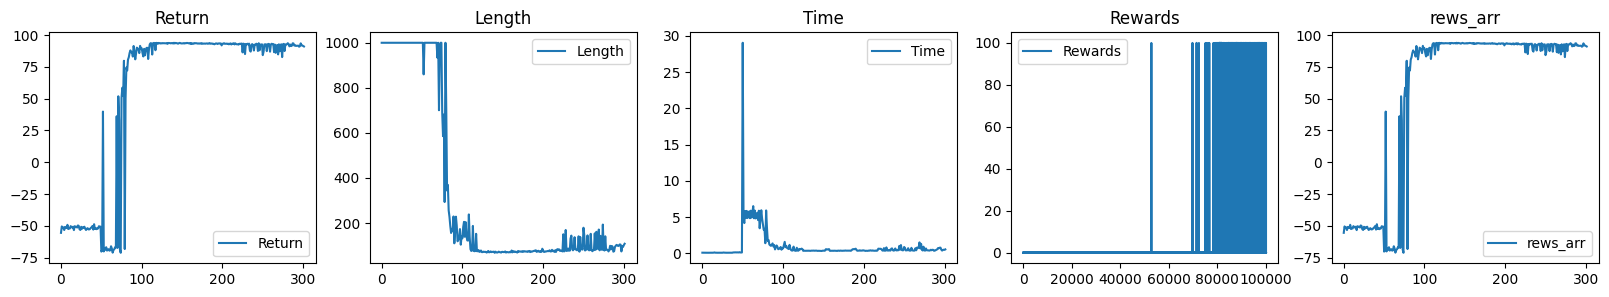

In [35]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 3))

ax1.plot(rs, label='Return')
ax1.legend()
ax1.set_title("Return")

ax2.plot(ls, label='Length')
ax2.legend()
ax2.set_title("Length")

ax3.plot(ts, label='Time')
ax3.legend()
ax3.set_title("Time")

ax4.plot(rewards, label='Rewards')
ax4.legend()
ax4.set_title("Rewards")

ax5.plot(rews_arr, label='rews_arr')
ax5.legend()
ax5.set_title("rews_arr")

plt.show()


In [36]:
eval_env = gym.make("MountainCarContinuous-v0", render_mode="rgb_array") #
eval_env = wrap_gym(eval_env, rescale_actions=True)
eval_env = gym.wrappers.RecordVideo(eval_env, 'MountainCarContinuous-v0')
eval_env = gym.wrappers.RecordEpisodeStatistics(eval_env, buffer_length=1)
evaluate(agent, eval_env, num_episodes=1)
eval_env.close()

### Lunar Lander

In [19]:
!pip install "gymnasium[mujoco]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 23.4 MB/s eta 0:00:00


### Hoper

In [37]:
import os
os.environ["MUJOCO_GL"] = "egl"

In [38]:
env = gym.make("Hopper-v4", render_mode=None)
env = wrap_gym(env, rescale_actions=True)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=1)

eval_env = gym.make("Hopper-v4", render_mode=None) # "rgb_array"
eval_env = wrap_gym(eval_env, rescale_actions=True)
# eval_env = gym.wrappers.RecordVideo(eval_env, 'cartpole_video')
eval_env = gym.wrappers.RecordEpisodeStatistics(eval_env, buffer_length=1)

agent = ScoreMatchingLearner.create(42, env.observation_space, env.action_space)

replay_buffer = ReplayBuffer(env.observation_space, env.action_space, max_iter)

observation, _ = env.reset()
done = False

rs, ls, ts = [], [], []
rewards = []
rews = 0
rews_arr = []
pbar = trange(1, max_iter+1, desc='Training')
for i in pbar:
    if i < start_step:
        action = env.action_space.sample()
    else:
        action, agent = agent.sample_actions(observation)
        action = np.asarray(action)
    next_observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    rews += reward
    if not done or "TimeLimit.truncated" in info:
        mask = 1.0
    else:
        mask = 0.0

    replay_buffer.insert(
            dict(
                observations=observation,
                actions=action,
                rewards=reward,
                masks=mask,
                dones=done,
                next_observations=next_observation,
            )
        )
    observation = next_observation
    rewards.append(reward)
    if done:
        rews_arr.append(rews)
        rews = 0
        observation, _ = env.reset()
        done = False
        # print("Done Info:", info)
        pbar.set_postfix(info['episode'])
        rs.append(info['episode']['r'])
        ls.append(info['episode']['l'])
        ts.append(info['episode']['t'])

    if i >= start_step:
        batch = replay_buffer.sample(batch_size)
        agent, update_info = agent.update(batch)

        if i % print_interval == 0:
            print("Update Info:", update_info)
            print('rew_arrs : ', rews_arr[-1])


    if i % 100_000 == 0:
        eval_info = evaluate(agent, eval_env, num_episodes=num_episodes)
        print("Eval Info", eval_info)

eval_env.close()
env.close()

Training:  50%|█████     | 50000/100000 [00:56<38:51, 21.44it/s, r=18.2, l=25, t=0.00958]  

Update Info: {'actor_loss_mag': Array(0.23833857, dtype=float32), 'actor_loss_max': Array(0.23833857, dtype=float32), 'actor_loss_mean': Array(0.03667245, dtype=float32), 'actor_loss_min': Array(0.00153218, dtype=float32), 'actor_loss_std': Array(0.0366283, dtype=float32), 'c_loss_mag_1': Array(4.3610444, dtype=float32), 'c_loss_mag_2': Array(6.098281, dtype=float32), 'c_loss_max_1': Array(4.3610444, dtype=float32), 'c_loss_max_2': Array(6.098281, dtype=float32), 'c_loss_mean_1': Array(0.4804322, dtype=float32), 'c_loss_mean_2': Array(0.76505065, dtype=float32), 'c_loss_min_1': Array(1.6376089e-05, dtype=float32), 'c_loss_min_2': Array(1.0103123e-06, dtype=float32), 'c_loss_std_1': Array(0.55554223, dtype=float32), 'c_loss_std_2': Array(0.74923533, dtype=float32), 'critic_jacobian_mag': Array(0.15104738, dtype=float32), 'critic_jacobian_max': Array(0.15104738, dtype=float32), 'critic_jacobian_mean': Array(0.01908841, dtype=float32), 'critic_jacobian_min': Array(-0.11460312, dtype=float

Training:  51%|█████     | 51008/100000 [01:07<13:34, 60.13it/s, r=66.4, l=41, t=0.693]

Update Info: {'actor_loss_mag': Array(0.05140397, dtype=float32), 'actor_loss_max': Array(0.05140397, dtype=float32), 'actor_loss_mean': Array(0.00743159, dtype=float32), 'actor_loss_min': Array(0.0002336, dtype=float32), 'actor_loss_std': Array(0.00673891, dtype=float32), 'c_loss_mag_1': Array(24.666655, dtype=float32), 'c_loss_mag_2': Array(24.71627, dtype=float32), 'c_loss_max_1': Array(24.666655, dtype=float32), 'c_loss_max_2': Array(24.71627, dtype=float32), 'c_loss_mean_1': Array(0.36742136, dtype=float32), 'c_loss_mean_2': Array(0.380481, dtype=float32), 'c_loss_min_1': Array(8.290043e-05, dtype=float32), 'c_loss_min_2': Array(2.1794258e-06, dtype=float32), 'c_loss_std_1': Array(1.6189274, dtype=float32), 'c_loss_std_2': Array(1.6218234, dtype=float32), 'critic_jacobian_mag': Array(0.8376075, dtype=float32), 'critic_jacobian_max': Array(0.8376075, dtype=float32), 'critic_jacobian_mean': Array(0.24933311, dtype=float32), 'critic_jacobian_min': Array(-0.1849399, dtype=float32), 'c

Training:  52%|█████▏    | 52028/100000 [01:15<06:37, 120.61it/s, r=71.4, l=39, t=0.329]

Update Info: {'actor_loss_mag': Array(0.206555, dtype=float32), 'actor_loss_max': Array(0.206555, dtype=float32), 'actor_loss_mean': Array(0.03035576, dtype=float32), 'actor_loss_min': Array(0.0003638, dtype=float32), 'actor_loss_std': Array(0.03177488, dtype=float32), 'c_loss_mag_1': Array(161.81226, dtype=float32), 'c_loss_mag_2': Array(153.8012, dtype=float32), 'c_loss_max_1': Array(161.81226, dtype=float32), 'c_loss_max_2': Array(153.8012, dtype=float32), 'c_loss_mean_1': Array(2.0500147, dtype=float32), 'c_loss_mean_2': Array(2.0581098, dtype=float32), 'c_loss_min_1': Array(1.466924e-06, dtype=float32), 'c_loss_min_2': Array(1.31331035e-05, dtype=float32), 'c_loss_std_1': Array(11.204214, dtype=float32), 'c_loss_std_2': Array(10.868799, dtype=float32), 'critic_jacobian_mag': Array(2.044091, dtype=float32), 'critic_jacobian_max': Array(2.044091, dtype=float32), 'critic_jacobian_mean': Array(0.44862303, dtype=float32), 'critic_jacobian_min': Array(-0.5551866, dtype=float32), 'critic

Training:  53%|█████▎    | 53031/100000 [01:21<04:45, 164.45it/s, r=166, l=80, t=0.451]

Update Info: {'actor_loss_mag': Array(0.5479108, dtype=float32), 'actor_loss_max': Array(0.5479108, dtype=float32), 'actor_loss_mean': Array(0.07090454, dtype=float32), 'actor_loss_min': Array(0.00039708, dtype=float32), 'actor_loss_std': Array(0.08283897, dtype=float32), 'c_loss_mag_1': Array(81.68648, dtype=float32), 'c_loss_mag_2': Array(60.284492, dtype=float32), 'c_loss_max_1': Array(81.68648, dtype=float32), 'c_loss_max_2': Array(60.284492, dtype=float32), 'c_loss_mean_1': Array(2.1087122, dtype=float32), 'c_loss_mean_2': Array(1.8824259, dtype=float32), 'c_loss_min_1': Array(1.5751139e-06, dtype=float32), 'c_loss_min_2': Array(2.2519613e-05, dtype=float32), 'c_loss_std_1': Array(7.3558145, dtype=float32), 'c_loss_std_2': Array(5.9698915, dtype=float32), 'critic_jacobian_mag': Array(4.2642717, dtype=float32), 'critic_jacobian_max': Array(4.2642717, dtype=float32), 'critic_jacobian_mean': Array(0.7097022, dtype=float32), 'critic_jacobian_min': Array(-1.2194705, dtype=float32), 'cr

Training:  54%|█████▍    | 54025/100000 [01:27<04:25, 173.48it/s, r=215, l=96, t=0.536]

Update Info: {'actor_loss_mag': Array(1.1538774, dtype=float32), 'actor_loss_max': Array(1.1538774, dtype=float32), 'actor_loss_mean': Array(0.16250068, dtype=float32), 'actor_loss_min': Array(0.00038178, dtype=float32), 'actor_loss_std': Array(0.20493817, dtype=float32), 'c_loss_mag_1': Array(284.16348, dtype=float32), 'c_loss_mag_2': Array(259.2634, dtype=float32), 'c_loss_max_1': Array(284.16348, dtype=float32), 'c_loss_max_2': Array(259.2634, dtype=float32), 'c_loss_mean_1': Array(5.2174406, dtype=float32), 'c_loss_mean_2': Array(4.982263, dtype=float32), 'c_loss_min_1': Array(6.915652e-07, dtype=float32), 'c_loss_min_2': Array(3.1018863e-07, dtype=float32), 'c_loss_std_1': Array(27.671122, dtype=float32), 'c_loss_std_2': Array(26.116312, dtype=float32), 'critic_jacobian_mag': Array(7.088754, dtype=float32), 'critic_jacobian_max': Array(7.088754, dtype=float32), 'critic_jacobian_mean': Array(0.65003955, dtype=float32), 'critic_jacobian_min': Array(-2.6502924, dtype=float32), 'criti

Training:  55%|█████▌    | 55026/100000 [01:33<05:49, 128.63it/s, r=217, l=96, t=0.831]

Update Info: {'actor_loss_mag': Array(6.5987453, dtype=float32), 'actor_loss_max': Array(6.5987453, dtype=float32), 'actor_loss_mean': Array(0.27023828, dtype=float32), 'actor_loss_min': Array(0.00034682, dtype=float32), 'actor_loss_std': Array(0.5371672, dtype=float32), 'c_loss_mag_1': Array(768.2262, dtype=float32), 'c_loss_mag_2': Array(798.772, dtype=float32), 'c_loss_max_1': Array(768.2262, dtype=float32), 'c_loss_max_2': Array(798.772, dtype=float32), 'c_loss_mean_1': Array(9.596319, dtype=float32), 'c_loss_mean_2': Array(9.371216, dtype=float32), 'c_loss_min_1': Array(1.9379018e-05, dtype=float32), 'c_loss_min_2': Array(0.00025231, dtype=float32), 'c_loss_std_1': Array(66.68148, dtype=float32), 'c_loss_std_2': Array(67.29184, dtype=float32), 'critic_jacobian_mag': Array(11.425522, dtype=float32), 'critic_jacobian_max': Array(11.425522, dtype=float32), 'critic_jacobian_mean': Array(0.7490119, dtype=float32), 'critic_jacobian_min': Array(-3.7564206, dtype=float32), 'critic_jacobia

Training:  56%|█████▌    | 56019/100000 [01:39<04:09, 176.40it/s, r=240, l=110, t=0.578]

Update Info: {'actor_loss_mag': Array(5.7599573, dtype=float32), 'actor_loss_max': Array(5.7599573, dtype=float32), 'actor_loss_mean': Array(0.30010182, dtype=float32), 'actor_loss_min': Array(0.00324316, dtype=float32), 'actor_loss_std': Array(0.5244361, dtype=float32), 'c_loss_mag_1': Array(892.5356, dtype=float32), 'c_loss_mag_2': Array(978.9405, dtype=float32), 'c_loss_max_1': Array(892.5356, dtype=float32), 'c_loss_max_2': Array(978.9405, dtype=float32), 'c_loss_mean_1': Array(13.871382, dtype=float32), 'c_loss_mean_2': Array(13.160152, dtype=float32), 'c_loss_min_1': Array(8.785413e-06, dtype=float32), 'c_loss_min_2': Array(2.3396919e-05, dtype=float32), 'c_loss_std_1': Array(80.47168, dtype=float32), 'c_loss_std_2': Array(79.02868, dtype=float32), 'critic_jacobian_mag': Array(14.731425, dtype=float32), 'critic_jacobian_max': Array(14.731425, dtype=float32), 'critic_jacobian_mean': Array(0.80092734, dtype=float32), 'critic_jacobian_min': Array(-5.4941716, dtype=float32), 'critic_

Training:  57%|█████▋    | 57013/100000 [01:45<06:30, 110.15it/s, r=280, l=120, t=1.03]

Update Info: {'actor_loss_mag': Array(10.290107, dtype=float32), 'actor_loss_max': Array(10.290107, dtype=float32), 'actor_loss_mean': Array(0.5608218, dtype=float32), 'actor_loss_min': Array(0.00080085, dtype=float32), 'actor_loss_std': Array(1.0913291, dtype=float32), 'c_loss_mag_1': Array(228.12373, dtype=float32), 'c_loss_mag_2': Array(192.55786, dtype=float32), 'c_loss_max_1': Array(228.12373, dtype=float32), 'c_loss_max_2': Array(192.55786, dtype=float32), 'c_loss_mean_1': Array(8.787955, dtype=float32), 'c_loss_mean_2': Array(7.646499, dtype=float32), 'c_loss_min_1': Array(8.8636065e-05, dtype=float32), 'c_loss_min_2': Array(5.6474528e-05, dtype=float32), 'c_loss_std_1': Array(27.496021, dtype=float32), 'c_loss_std_2': Array(24.742476, dtype=float32), 'critic_jacobian_mag': Array(20.474308, dtype=float32), 'critic_jacobian_max': Array(20.474308, dtype=float32), 'critic_jacobian_mean': Array(0.9144823, dtype=float32), 'critic_jacobian_min': Array(-4.5014305, dtype=float32), 'crit

Training:  58%|█████▊    | 58022/100000 [01:51<03:50, 181.96it/s, r=275, l=125, t=0.68]

Update Info: {'actor_loss_mag': Array(17.003117, dtype=float32), 'actor_loss_max': Array(17.003117, dtype=float32), 'actor_loss_mean': Array(0.82010007, dtype=float32), 'actor_loss_min': Array(0.00498504, dtype=float32), 'actor_loss_std': Array(2.065939, dtype=float32), 'c_loss_mag_1': Array(684.59717, dtype=float32), 'c_loss_mag_2': Array(713.981, dtype=float32), 'c_loss_max_1': Array(684.59717, dtype=float32), 'c_loss_max_2': Array(713.981, dtype=float32), 'c_loss_mean_1': Array(13.825689, dtype=float32), 'c_loss_mean_2': Array(13.957132, dtype=float32), 'c_loss_min_1': Array(6.2050676e-06, dtype=float32), 'c_loss_min_2': Array(1.9044615e-05, dtype=float32), 'c_loss_std_1': Array(67.22818, dtype=float32), 'c_loss_std_2': Array(68.29454, dtype=float32), 'critic_jacobian_mag': Array(21.676495, dtype=float32), 'critic_jacobian_max': Array(21.676495, dtype=float32), 'critic_jacobian_mean': Array(0.98439014, dtype=float32), 'critic_jacobian_min': Array(-6.735772, dtype=float32), 'critic_j

Training:  59%|█████▉    | 59018/100000 [01:57<05:12, 131.01it/s, r=256, l=115, t=0.632]

Update Info: {'actor_loss_mag': Array(7.0340214, dtype=float32), 'actor_loss_max': Array(7.0340214, dtype=float32), 'actor_loss_mean': Array(0.67936444, dtype=float32), 'actor_loss_min': Array(0.00636733, dtype=float32), 'actor_loss_std': Array(1.1212598, dtype=float32), 'c_loss_mag_1': Array(276.2113, dtype=float32), 'c_loss_mag_2': Array(326.12024, dtype=float32), 'c_loss_max_1': Array(276.2113, dtype=float32), 'c_loss_max_2': Array(326.12024, dtype=float32), 'c_loss_mean_1': Array(10.3066635, dtype=float32), 'c_loss_mean_2': Array(8.925303, dtype=float32), 'c_loss_min_1': Array(0.00017532, dtype=float32), 'c_loss_min_2': Array(1.1736993e-06, dtype=float32), 'c_loss_std_1': Array(35.19527, dtype=float32), 'c_loss_std_2': Array(32.68383, dtype=float32), 'critic_jacobian_mag': Array(27.970507, dtype=float32), 'critic_jacobian_max': Array(27.970507, dtype=float32), 'critic_jacobian_mean': Array(1.3200641, dtype=float32), 'critic_jacobian_min': Array(-6.8419905, dtype=float32), 'critic_j

Training:  60%|██████    | 60022/100000 [02:03<03:54, 170.28it/s, r=238, l=104, t=0.587]

Update Info: {'actor_loss_mag': Array(33.65566, dtype=float32), 'actor_loss_max': Array(33.65566, dtype=float32), 'actor_loss_mean': Array(1.1049424, dtype=float32), 'actor_loss_min': Array(0.00308177, dtype=float32), 'actor_loss_std': Array(2.9251173, dtype=float32), 'c_loss_mag_1': Array(1271.7477, dtype=float32), 'c_loss_mag_2': Array(1032.1136, dtype=float32), 'c_loss_max_1': Array(1271.7477, dtype=float32), 'c_loss_max_2': Array(1032.1136, dtype=float32), 'c_loss_mean_1': Array(22.168245, dtype=float32), 'c_loss_mean_2': Array(19.380798, dtype=float32), 'c_loss_min_1': Array(0.00078229, dtype=float32), 'c_loss_min_2': Array(8.326117e-05, dtype=float32), 'c_loss_std_1': Array(98.704506, dtype=float32), 'c_loss_std_2': Array(81.34848, dtype=float32), 'critic_jacobian_mag': Array(32.789204, dtype=float32), 'critic_jacobian_max': Array(32.789204, dtype=float32), 'critic_jacobian_mean': Array(1.0047872, dtype=float32), 'critic_jacobian_min': Array(-8.702075, dtype=float32), 'critic_jac

Training:  61%|██████    | 61025/100000 [02:09<03:46, 172.24it/s, r=226, l=98, t=0.543]

Update Info: {'actor_loss_mag': Array(52.80984, dtype=float32), 'actor_loss_max': Array(52.80984, dtype=float32), 'actor_loss_mean': Array(1.4993391, dtype=float32), 'actor_loss_min': Array(0.00790344, dtype=float32), 'actor_loss_std': Array(4.7645683, dtype=float32), 'c_loss_mag_1': Array(3078.1536, dtype=float32), 'c_loss_mag_2': Array(3140.294, dtype=float32), 'c_loss_max_1': Array(3078.1536, dtype=float32), 'c_loss_max_2': Array(3140.294, dtype=float32), 'c_loss_mean_1': Array(23.29166, dtype=float32), 'c_loss_mean_2': Array(22.347916, dtype=float32), 'c_loss_min_1': Array(1.02678314e-07, dtype=float32), 'c_loss_min_2': Array(0.00032036, dtype=float32), 'c_loss_std_1': Array(194.90553, dtype=float32), 'c_loss_std_2': Array(197.71402, dtype=float32), 'critic_jacobian_mag': Array(34.683075, dtype=float32), 'critic_jacobian_max': Array(34.683075, dtype=float32), 'critic_jacobian_mean': Array(1.2792242, dtype=float32), 'critic_jacobian_min': Array(-7.6552534, dtype=float32), 'critic_ja

Training:  62%|██████▏   | 62029/100000 [02:15<03:51, 164.15it/s, r=205, l=96, t=0.53]

Update Info: {'actor_loss_mag': Array(61.493607, dtype=float32), 'actor_loss_max': Array(61.493607, dtype=float32), 'actor_loss_mean': Array(2.1961591, dtype=float32), 'actor_loss_min': Array(0.0170515, dtype=float32), 'actor_loss_std': Array(6.1251755, dtype=float32), 'c_loss_mag_1': Array(4030.37, dtype=float32), 'c_loss_mag_2': Array(3891.2742, dtype=float32), 'c_loss_max_1': Array(4030.37, dtype=float32), 'c_loss_max_2': Array(3891.2742, dtype=float32), 'c_loss_mean_1': Array(37.922688, dtype=float32), 'c_loss_mean_2': Array(35.16872, dtype=float32), 'c_loss_min_1': Array(1.0316784e-05, dtype=float32), 'c_loss_min_2': Array(1.1902885e-06, dtype=float32), 'c_loss_std_1': Array(265.09616, dtype=float32), 'c_loss_std_2': Array(253.55289, dtype=float32), 'critic_jacobian_mag': Array(41.89066, dtype=float32), 'critic_jacobian_max': Array(41.89066, dtype=float32), 'critic_jacobian_mean': Array(1.823604, dtype=float32), 'critic_jacobian_min': Array(-8.955034, dtype=float32), 'critic_jacob

Training:  63%|██████▎   | 63022/100000 [02:21<03:31, 174.77it/s, r=159, l=89, t=0.492]

Update Info: {'actor_loss_mag': Array(51.143486, dtype=float32), 'actor_loss_max': Array(51.143486, dtype=float32), 'actor_loss_mean': Array(1.775253, dtype=float32), 'actor_loss_min': Array(0.01968948, dtype=float32), 'actor_loss_std': Array(4.8585877, dtype=float32), 'c_loss_mag_1': Array(1433.5868, dtype=float32), 'c_loss_mag_2': Array(1388.5522, dtype=float32), 'c_loss_max_1': Array(1433.5868, dtype=float32), 'c_loss_max_2': Array(1388.5522, dtype=float32), 'c_loss_mean_1': Array(23.994091, dtype=float32), 'c_loss_mean_2': Array(21.481438, dtype=float32), 'c_loss_min_1': Array(0.00012923, dtype=float32), 'c_loss_min_2': Array(4.7148205e-09, dtype=float32), 'c_loss_std_1': Array(105.18835, dtype=float32), 'c_loss_std_2': Array(99.29789, dtype=float32), 'critic_jacobian_mag': Array(40.708393, dtype=float32), 'critic_jacobian_max': Array(40.708393, dtype=float32), 'critic_jacobian_mean': Array(1.4540386, dtype=float32), 'critic_jacobian_min': Array(-11.832354, dtype=float32), 'critic_

Training:  64%|██████▍   | 64023/100000 [02:27<03:22, 177.48it/s, r=296, l=126, t=0.7]  

Update Info: {'actor_loss_mag': Array(58.419647, dtype=float32), 'actor_loss_max': Array(58.419647, dtype=float32), 'actor_loss_mean': Array(1.5528052, dtype=float32), 'actor_loss_min': Array(0.00815589, dtype=float32), 'actor_loss_std': Array(4.9234676, dtype=float32), 'c_loss_mag_1': Array(2391.594, dtype=float32), 'c_loss_mag_2': Array(2217.761, dtype=float32), 'c_loss_max_1': Array(2391.594, dtype=float32), 'c_loss_max_2': Array(2217.761, dtype=float32), 'c_loss_mean_1': Array(26.5687, dtype=float32), 'c_loss_mean_2': Array(24.088627, dtype=float32), 'c_loss_min_1': Array(6.6393055e-05, dtype=float32), 'c_loss_min_2': Array(0.00062241, dtype=float32), 'c_loss_std_1': Array(162.96327, dtype=float32), 'c_loss_std_2': Array(149.84187, dtype=float32), 'critic_jacobian_mag': Array(47.70526, dtype=float32), 'critic_jacobian_max': Array(47.70526, dtype=float32), 'critic_jacobian_mean': Array(1.7794452, dtype=float32), 'critic_jacobian_min': Array(-8.899501, dtype=float32), 'critic_jacobia

Training:  65%|██████▌   | 65031/100000 [02:33<03:22, 172.28it/s, r=250, l=107, t=0.59]

Update Info: {'actor_loss_mag': Array(25.508154, dtype=float32), 'actor_loss_max': Array(25.508154, dtype=float32), 'actor_loss_mean': Array(1.261204, dtype=float32), 'actor_loss_min': Array(0.01213437, dtype=float32), 'actor_loss_std': Array(2.9022071, dtype=float32), 'c_loss_mag_1': Array(641.40607, dtype=float32), 'c_loss_mag_2': Array(443.61847, dtype=float32), 'c_loss_max_1': Array(641.40607, dtype=float32), 'c_loss_max_2': Array(443.61847, dtype=float32), 'c_loss_mean_1': Array(20.357307, dtype=float32), 'c_loss_mean_2': Array(17.402405, dtype=float32), 'c_loss_min_1': Array(4.704349e-05, dtype=float32), 'c_loss_min_2': Array(0.00041807, dtype=float32), 'c_loss_std_1': Array(64.60605, dtype=float32), 'c_loss_std_2': Array(54.54992, dtype=float32), 'critic_jacobian_mag': Array(55.2728, dtype=float32), 'critic_jacobian_max': Array(55.2728, dtype=float32), 'critic_jacobian_mean': Array(1.1258852, dtype=float32), 'critic_jacobian_min': Array(-9.396624, dtype=float32), 'critic_jacobia

Training:  66%|██████▌   | 66018/100000 [02:40<03:21, 168.91it/s, r=281, l=117, t=0.663]

Update Info: {'actor_loss_mag': Array(40.457542, dtype=float32), 'actor_loss_max': Array(40.457542, dtype=float32), 'actor_loss_mean': Array(1.5473077, dtype=float32), 'actor_loss_min': Array(0.00448375, dtype=float32), 'actor_loss_std': Array(4.071827, dtype=float32), 'c_loss_mag_1': Array(3003.2673, dtype=float32), 'c_loss_mag_2': Array(3165.6643, dtype=float32), 'c_loss_max_1': Array(3003.2673, dtype=float32), 'c_loss_max_2': Array(3165.6643, dtype=float32), 'c_loss_mean_1': Array(40.487186, dtype=float32), 'c_loss_mean_2': Array(35.963272, dtype=float32), 'c_loss_min_1': Array(0.00052178, dtype=float32), 'c_loss_min_2': Array(0.0003311, dtype=float32), 'c_loss_std_1': Array(216.1255, dtype=float32), 'c_loss_std_2': Array(219.37254, dtype=float32), 'critic_jacobian_mag': Array(53.964485, dtype=float32), 'critic_jacobian_max': Array(53.964485, dtype=float32), 'critic_jacobian_mean': Array(1.090739, dtype=float32), 'critic_jacobian_min': Array(-16.719341, dtype=float32), 'critic_jacob

Training:  67%|██████▋   | 67018/100000 [02:46<03:20, 164.75it/s, r=299, l=115, t=0.652]

Update Info: {'actor_loss_mag': Array(182.61954, dtype=float32), 'actor_loss_max': Array(182.61954, dtype=float32), 'actor_loss_mean': Array(3.7549622, dtype=float32), 'actor_loss_min': Array(0.00243592, dtype=float32), 'actor_loss_std': Array(14.161188, dtype=float32), 'c_loss_mag_1': Array(1159.7483, dtype=float32), 'c_loss_mag_2': Array(1219.8462, dtype=float32), 'c_loss_max_1': Array(1159.7483, dtype=float32), 'c_loss_max_2': Array(1219.8462, dtype=float32), 'c_loss_mean_1': Array(23.900751, dtype=float32), 'c_loss_mean_2': Array(22.641617, dtype=float32), 'c_loss_min_1': Array(0.00051969, dtype=float32), 'c_loss_min_2': Array(0.00025256, dtype=float32), 'c_loss_std_1': Array(117.97338, dtype=float32), 'c_loss_std_2': Array(114.68287, dtype=float32), 'critic_jacobian_mag': Array(69.409, dtype=float32), 'critic_jacobian_max': Array(69.409, dtype=float32), 'critic_jacobian_mean': Array(2.1713424, dtype=float32), 'critic_jacobian_min': Array(-12.316344, dtype=float32), 'critic_jacobia

Training:  68%|██████▊   | 68033/100000 [02:52<03:02, 175.61it/s, r=302, l=118, t=0.828]

Update Info: {'actor_loss_mag': Array(59.05552, dtype=float32), 'actor_loss_max': Array(59.05552, dtype=float32), 'actor_loss_mean': Array(2.4866767, dtype=float32), 'actor_loss_min': Array(0.01371162, dtype=float32), 'actor_loss_std': Array(7.1007333, dtype=float32), 'c_loss_mag_1': Array(9179.15, dtype=float32), 'c_loss_mag_2': Array(8542.391, dtype=float32), 'c_loss_max_1': Array(9179.15, dtype=float32), 'c_loss_max_2': Array(8542.391, dtype=float32), 'c_loss_mean_1': Array(69.77917, dtype=float32), 'c_loss_mean_2': Array(66.972275, dtype=float32), 'c_loss_min_1': Array(2.6915222e-05, dtype=float32), 'c_loss_min_2': Array(1.6822014e-06, dtype=float32), 'c_loss_std_1': Array(591.637, dtype=float32), 'c_loss_std_2': Array(559.57043, dtype=float32), 'critic_jacobian_mag': Array(71.92905, dtype=float32), 'critic_jacobian_max': Array(71.92905, dtype=float32), 'critic_jacobian_mean': Array(1.9355798, dtype=float32), 'critic_jacobian_min': Array(-19.411045, dtype=float32), 'critic_jacobian

Training:  69%|██████▉   | 69029/100000 [02:58<02:55, 176.19it/s, r=285, l=114, t=0.637]

Update Info: {'actor_loss_mag': Array(152.95726, dtype=float32), 'actor_loss_max': Array(152.95726, dtype=float32), 'actor_loss_mean': Array(5.1542416, dtype=float32), 'actor_loss_min': Array(0.00814816, dtype=float32), 'actor_loss_std': Array(17.772625, dtype=float32), 'c_loss_mag_1': Array(8162.5503, dtype=float32), 'c_loss_mag_2': Array(8872.497, dtype=float32), 'c_loss_max_1': Array(8162.5503, dtype=float32), 'c_loss_max_2': Array(8872.497, dtype=float32), 'c_loss_mean_1': Array(82.27011, dtype=float32), 'c_loss_mean_2': Array(86.52681, dtype=float32), 'c_loss_min_1': Array(7.554194e-06, dtype=float32), 'c_loss_min_2': Array(0.00027561, dtype=float32), 'c_loss_std_1': Array(665.4467, dtype=float32), 'c_loss_std_2': Array(714.2458, dtype=float32), 'critic_jacobian_mag': Array(75.61923, dtype=float32), 'critic_jacobian_max': Array(75.61923, dtype=float32), 'critic_jacobian_mean': Array(2.0416265, dtype=float32), 'critic_jacobian_min': Array(-14.772905, dtype=float32), 'critic_jacobia

Training:  70%|███████   | 70018/100000 [03:04<04:28, 111.58it/s, r=326, l=129, t=1.15]

Update Info: {'actor_loss_mag': Array(64.86842, dtype=float32), 'actor_loss_max': Array(64.86842, dtype=float32), 'actor_loss_mean': Array(2.4335241, dtype=float32), 'actor_loss_min': Array(0.00685773, dtype=float32), 'actor_loss_std': Array(6.736235, dtype=float32), 'c_loss_mag_1': Array(1017.09894, dtype=float32), 'c_loss_mag_2': Array(1341.7994, dtype=float32), 'c_loss_max_1': Array(1017.09894, dtype=float32), 'c_loss_max_2': Array(1341.7994, dtype=float32), 'c_loss_mean_1': Array(34.997005, dtype=float32), 'c_loss_mean_2': Array(32.498764, dtype=float32), 'c_loss_min_1': Array(5.3198077e-05, dtype=float32), 'c_loss_min_2': Array(3.361314e-05, dtype=float32), 'c_loss_std_1': Array(135.38945, dtype=float32), 'c_loss_std_2': Array(132.8869, dtype=float32), 'critic_jacobian_mag': Array(81.52757, dtype=float32), 'critic_jacobian_max': Array(81.52757, dtype=float32), 'critic_jacobian_mean': Array(1.6963165, dtype=float32), 'critic_jacobian_min': Array(-15.967242, dtype=float32), 'critic_

Training:  71%|███████   | 71030/100000 [03:10<02:49, 170.44it/s, r=327, l=126, t=0.676]

Update Info: {'actor_loss_mag': Array(124.91043, dtype=float32), 'actor_loss_max': Array(124.91043, dtype=float32), 'actor_loss_mean': Array(3.1208634, dtype=float32), 'actor_loss_min': Array(0.0068067, dtype=float32), 'actor_loss_std': Array(11.93642, dtype=float32), 'c_loss_mag_1': Array(2578.1755, dtype=float32), 'c_loss_mag_2': Array(2231.6726, dtype=float32), 'c_loss_max_1': Array(2578.1755, dtype=float32), 'c_loss_max_2': Array(2231.6726, dtype=float32), 'c_loss_mean_1': Array(31.222708, dtype=float32), 'c_loss_mean_2': Array(27.904743, dtype=float32), 'c_loss_min_1': Array(5.364418e-05, dtype=float32), 'c_loss_min_2': Array(9.406591e-06, dtype=float32), 'c_loss_std_1': Array(175.72122, dtype=float32), 'c_loss_std_2': Array(156.4599, dtype=float32), 'critic_jacobian_mag': Array(91.48185, dtype=float32), 'critic_jacobian_max': Array(91.48185, dtype=float32), 'critic_jacobian_mean': Array(1.5919265, dtype=float32), 'critic_jacobian_min': Array(-15.776777, dtype=float32), 'critic_ja

Training:  72%|███████▏  | 72015/100000 [03:16<04:05, 114.21it/s, r=288, l=118, t=0.828]

Update Info: {'actor_loss_mag': Array(193.68945, dtype=float32), 'actor_loss_max': Array(193.68945, dtype=float32), 'actor_loss_mean': Array(3.5550358, dtype=float32), 'actor_loss_min': Array(0.00839681, dtype=float32), 'actor_loss_std': Array(16.438046, dtype=float32), 'c_loss_mag_1': Array(489.52432, dtype=float32), 'c_loss_mag_2': Array(484.90067, dtype=float32), 'c_loss_max_1': Array(489.52432, dtype=float32), 'c_loss_max_2': Array(484.90067, dtype=float32), 'c_loss_mean_1': Array(15.342962, dtype=float32), 'c_loss_mean_2': Array(15.712182, dtype=float32), 'c_loss_min_1': Array(3.4960976e-05, dtype=float32), 'c_loss_min_2': Array(1.10650435e-05, dtype=float32), 'c_loss_std_1': Array(48.003914, dtype=float32), 'c_loss_std_2': Array(49.098923, dtype=float32), 'critic_jacobian_mag': Array(93.16315, dtype=float32), 'critic_jacobian_max': Array(93.16315, dtype=float32), 'critic_jacobian_mean': Array(1.9896362, dtype=float32), 'critic_jacobian_min': Array(-13.76676, dtype=float32), 'crit

Training:  73%|███████▎  | 73031/100000 [03:22<02:37, 170.78it/s, r=312, l=138, t=0.72]

Update Info: {'actor_loss_mag': Array(375.94415, dtype=float32), 'actor_loss_max': Array(375.94415, dtype=float32), 'actor_loss_mean': Array(5.2986374, dtype=float32), 'actor_loss_min': Array(0.00392136, dtype=float32), 'actor_loss_std': Array(29.008171, dtype=float32), 'c_loss_mag_1': Array(6493.3335, dtype=float32), 'c_loss_mag_2': Array(6102.947, dtype=float32), 'c_loss_max_1': Array(6493.3335, dtype=float32), 'c_loss_max_2': Array(6102.947, dtype=float32), 'c_loss_mean_1': Array(63.26526, dtype=float32), 'c_loss_mean_2': Array(63.967777, dtype=float32), 'c_loss_min_1': Array(1.4551915e-07, dtype=float32), 'c_loss_min_2': Array(1.07625965e-05, dtype=float32), 'c_loss_std_1': Array(452.36182, dtype=float32), 'c_loss_std_2': Array(433.20398, dtype=float32), 'critic_jacobian_mag': Array(92.74715, dtype=float32), 'critic_jacobian_max': Array(92.74715, dtype=float32), 'critic_jacobian_mean': Array(1.9489101, dtype=float32), 'critic_jacobian_min': Array(-16.379684, dtype=float32), 'critic

Training:  74%|███████▍  | 74016/100000 [03:33<04:36, 94.02it/s, r=281, l=125, t=2.19]

Update Info: {'actor_loss_mag': Array(279.5615, dtype=float32), 'actor_loss_max': Array(279.5615, dtype=float32), 'actor_loss_mean': Array(4.598175, dtype=float32), 'actor_loss_min': Array(0.01037608, dtype=float32), 'actor_loss_std': Array(21.53195, dtype=float32), 'c_loss_mag_1': Array(4979.5684, dtype=float32), 'c_loss_mag_2': Array(4596.2705, dtype=float32), 'c_loss_max_1': Array(4979.5684, dtype=float32), 'c_loss_max_2': Array(4596.2705, dtype=float32), 'c_loss_mean_1': Array(49.24815, dtype=float32), 'c_loss_mean_2': Array(55.8594, dtype=float32), 'c_loss_min_1': Array(4.5634806e-06, dtype=float32), 'c_loss_min_2': Array(6.055925e-07, dtype=float32), 'c_loss_std_1': Array(338.44168, dtype=float32), 'c_loss_std_2': Array(336.5927, dtype=float32), 'critic_jacobian_mag': Array(104.58981, dtype=float32), 'critic_jacobian_max': Array(104.58981, dtype=float32), 'critic_jacobian_mean': Array(2.2267017, dtype=float32), 'critic_jacobian_min': Array(-15.652232, dtype=float32), 'critic_jaco

Training:  75%|███████▌  | 75006/100000 [03:40<04:30, 92.24it/s, r=355, l=131, t=1.06] 

Update Info: {'actor_loss_mag': Array(73.1918, dtype=float32), 'actor_loss_max': Array(73.1918, dtype=float32), 'actor_loss_mean': Array(2.7811363, dtype=float32), 'actor_loss_min': Array(0.00026779, dtype=float32), 'actor_loss_std': Array(8.241526, dtype=float32), 'c_loss_mag_1': Array(1963.6937, dtype=float32), 'c_loss_mag_2': Array(2511.9067, dtype=float32), 'c_loss_max_1': Array(1963.6937, dtype=float32), 'c_loss_max_2': Array(2511.9067, dtype=float32), 'c_loss_mean_1': Array(39.163895, dtype=float32), 'c_loss_mean_2': Array(37.84804, dtype=float32), 'c_loss_min_1': Array(0.00034145, dtype=float32), 'c_loss_min_2': Array(0.0001865, dtype=float32), 'c_loss_std_1': Array(173.4402, dtype=float32), 'c_loss_std_2': Array(186.15613, dtype=float32), 'critic_jacobian_mag': Array(66.3869, dtype=float32), 'critic_jacobian_max': Array(66.3869, dtype=float32), 'critic_jacobian_mean': Array(1.5885057, dtype=float32), 'critic_jacobian_min': Array(-13.57724, dtype=float32), 'critic_jacobian_std':

Training:  76%|███████▌  | 76008/100000 [03:53<06:33, 60.96it/s, r=342, l=142, t=2.49]

Update Info: {'actor_loss_mag': Array(116.35576, dtype=float32), 'actor_loss_max': Array(116.35576, dtype=float32), 'actor_loss_mean': Array(3.6211357, dtype=float32), 'actor_loss_min': Array(0.00458001, dtype=float32), 'actor_loss_std': Array(12.656885, dtype=float32), 'c_loss_mag_1': Array(24755.092, dtype=float32), 'c_loss_mag_2': Array(24006.357, dtype=float32), 'c_loss_max_1': Array(24755.092, dtype=float32), 'c_loss_max_2': Array(24006.357, dtype=float32), 'c_loss_mean_1': Array(111.2194, dtype=float32), 'c_loss_mean_2': Array(107.478714, dtype=float32), 'c_loss_min_1': Array(0.00012957, dtype=float32), 'c_loss_min_2': Array(0.00025328, dtype=float32), 'c_loss_std_1': Array(1544.0104, dtype=float32), 'c_loss_std_2': Array(1497.8065, dtype=float32), 'critic_jacobian_mag': Array(94.993805, dtype=float32), 'critic_jacobian_max': Array(94.993805, dtype=float32), 'critic_jacobian_mean': Array(1.29844, dtype=float32), 'critic_jacobian_min': Array(-17.638004, dtype=float32), 'critic_jac

Training:  77%|███████▋  | 77023/100000 [04:02<02:12, 173.29it/s, r=333, l=146, t=0.777]

Update Info: {'actor_loss_mag': Array(374.9691, dtype=float32), 'actor_loss_max': Array(374.9691, dtype=float32), 'actor_loss_mean': Array(4.820228, dtype=float32), 'actor_loss_min': Array(0.00633764, dtype=float32), 'actor_loss_std': Array(26.310917, dtype=float32), 'c_loss_mag_1': Array(18672.066, dtype=float32), 'c_loss_mag_2': Array(21219.967, dtype=float32), 'c_loss_max_1': Array(18672.066, dtype=float32), 'c_loss_max_2': Array(21219.967, dtype=float32), 'c_loss_mean_1': Array(141.15408, dtype=float32), 'c_loss_mean_2': Array(145.98427, dtype=float32), 'c_loss_min_1': Array(0.00022544, dtype=float32), 'c_loss_min_2': Array(3.067986e-05, dtype=float32), 'c_loss_std_1': Array(1245.4153, dtype=float32), 'c_loss_std_2': Array(1385.8678, dtype=float32), 'critic_jacobian_mag': Array(105.283134, dtype=float32), 'critic_jacobian_max': Array(105.283134, dtype=float32), 'critic_jacobian_mean': Array(1.8357166, dtype=float32), 'critic_jacobian_min': Array(-20.93474, dtype=float32), 'critic_j

Training:  78%|███████▊  | 78026/100000 [04:08<02:03, 177.43it/s, r=364, l=153, t=0.871]

Update Info: {'actor_loss_mag': Array(192.95544, dtype=float32), 'actor_loss_max': Array(192.95544, dtype=float32), 'actor_loss_mean': Array(3.162531, dtype=float32), 'actor_loss_min': Array(0.01534235, dtype=float32), 'actor_loss_std': Array(13.646188, dtype=float32), 'c_loss_mag_1': Array(6919.2437, dtype=float32), 'c_loss_mag_2': Array(9279.258, dtype=float32), 'c_loss_max_1': Array(6919.2437, dtype=float32), 'c_loss_max_2': Array(9279.258, dtype=float32), 'c_loss_mean_1': Array(43.195343, dtype=float32), 'c_loss_mean_2': Array(48.12381, dtype=float32), 'c_loss_min_1': Array(0.00016448, dtype=float32), 'c_loss_min_2': Array(6.864988e-05, dtype=float32), 'c_loss_std_1': Array(435.62338, dtype=float32), 'c_loss_std_2': Array(579.7363, dtype=float32), 'critic_jacobian_mag': Array(82.43616, dtype=float32), 'critic_jacobian_max': Array(82.43616, dtype=float32), 'critic_jacobian_mean': Array(1.4006119, dtype=float32), 'critic_jacobian_min': Array(-22.279213, dtype=float32), 'critic_jacobi

Training:  79%|███████▉  | 79018/100000 [04:15<02:15, 155.30it/s, r=407, l=157, t=0.865]

Update Info: {'actor_loss_mag': Array(129.74197, dtype=float32), 'actor_loss_max': Array(129.74197, dtype=float32), 'actor_loss_mean': Array(3.9108644, dtype=float32), 'actor_loss_min': Array(0.01068263, dtype=float32), 'actor_loss_std': Array(14.644183, dtype=float32), 'c_loss_mag_1': Array(5946.471, dtype=float32), 'c_loss_mag_2': Array(5220.7065, dtype=float32), 'c_loss_max_1': Array(5946.471, dtype=float32), 'c_loss_max_2': Array(5220.7065, dtype=float32), 'c_loss_mean_1': Array(95.1082, dtype=float32), 'c_loss_mean_2': Array(79.80797, dtype=float32), 'c_loss_min_1': Array(1.9988278e-05, dtype=float32), 'c_loss_min_2': Array(4.2433385e-06, dtype=float32), 'c_loss_std_1': Array(557.31525, dtype=float32), 'c_loss_std_2': Array(458.8817, dtype=float32), 'critic_jacobian_mag': Array(120.06409, dtype=float32), 'critic_jacobian_max': Array(120.06409, dtype=float32), 'critic_jacobian_mean': Array(1.5399536, dtype=float32), 'critic_jacobian_min': Array(-27.82095, dtype=float32), 'critic_ja

Training:  80%|████████  | 80019/100000 [04:20<01:51, 179.02it/s, r=440, l=191, t=1.06]

Update Info: {'actor_loss_mag': Array(447.0332, dtype=float32), 'actor_loss_max': Array(447.0332, dtype=float32), 'actor_loss_mean': Array(6.063063, dtype=float32), 'actor_loss_min': Array(0.03133981, dtype=float32), 'actor_loss_std': Array(35.128242, dtype=float32), 'c_loss_mag_1': Array(11078.091, dtype=float32), 'c_loss_mag_2': Array(11468.79, dtype=float32), 'c_loss_max_1': Array(11078.091, dtype=float32), 'c_loss_max_2': Array(11468.79, dtype=float32), 'c_loss_mean_1': Array(115.91426, dtype=float32), 'c_loss_mean_2': Array(120.45235, dtype=float32), 'c_loss_min_1': Array(0.00042182, dtype=float32), 'c_loss_min_2': Array(8.892361e-05, dtype=float32), 'c_loss_std_1': Array(951.7613, dtype=float32), 'c_loss_std_2': Array(982.5924, dtype=float32), 'critic_jacobian_mag': Array(114.511444, dtype=float32), 'critic_jacobian_max': Array(114.511444, dtype=float32), 'critic_jacobian_mean': Array(1.1519058, dtype=float32), 'critic_jacobian_min': Array(-12.279538, dtype=float32), 'critic_jaco

Training:  81%|████████  | 81036/100000 [04:27<01:44, 181.00it/s, r=410, l=164, t=0.907]

Update Info: {'actor_loss_mag': Array(130.55363, dtype=float32), 'actor_loss_max': Array(130.55363, dtype=float32), 'actor_loss_mean': Array(3.6726227, dtype=float32), 'actor_loss_min': Array(0.00703861, dtype=float32), 'actor_loss_std': Array(12.370197, dtype=float32), 'c_loss_mag_1': Array(7413.758, dtype=float32), 'c_loss_mag_2': Array(5437.3555, dtype=float32), 'c_loss_max_1': Array(7413.758, dtype=float32), 'c_loss_max_2': Array(5437.3555, dtype=float32), 'c_loss_mean_1': Array(53.24401, dtype=float32), 'c_loss_mean_2': Array(42.31428, dtype=float32), 'c_loss_min_1': Array(0.00015427, dtype=float32), 'c_loss_min_2': Array(3.7252903e-07, dtype=float32), 'c_loss_std_1': Array(470.44247, dtype=float32), 'c_loss_std_2': Array(347.64935, dtype=float32), 'critic_jacobian_mag': Array(115.19887, dtype=float32), 'critic_jacobian_max': Array(115.19887, dtype=float32), 'critic_jacobian_mean': Array(0.9470279, dtype=float32), 'critic_jacobian_min': Array(-14.15211, dtype=float32), 'critic_jac

Training:  82%|████████▏ | 82016/100000 [04:32<01:43, 174.33it/s, r=403, l=174, t=0.936]

Update Info: {'actor_loss_mag': Array(66.645035, dtype=float32), 'actor_loss_max': Array(66.645035, dtype=float32), 'actor_loss_mean': Array(2.8102965, dtype=float32), 'actor_loss_min': Array(0.00475556, dtype=float32), 'actor_loss_std': Array(7.2111225, dtype=float32), 'c_loss_mag_1': Array(8206.768, dtype=float32), 'c_loss_mag_2': Array(8646.165, dtype=float32), 'c_loss_max_1': Array(8206.768, dtype=float32), 'c_loss_max_2': Array(8646.165, dtype=float32), 'c_loss_mean_1': Array(87.21239, dtype=float32), 'c_loss_mean_2': Array(85.20614, dtype=float32), 'c_loss_min_1': Array(1.4903257e-05, dtype=float32), 'c_loss_min_2': Array(0.00090359, dtype=float32), 'c_loss_std_1': Array(633.8945, dtype=float32), 'c_loss_std_2': Array(644.13635, dtype=float32), 'critic_jacobian_mag': Array(117.50093, dtype=float32), 'critic_jacobian_max': Array(117.50093, dtype=float32), 'critic_jacobian_mean': Array(1.2940636, dtype=float32), 'critic_jacobian_min': Array(-21.695791, dtype=float32), 'critic_jacob

Training:  83%|████████▎ | 83016/100000 [04:39<01:39, 170.02it/s, r=359, l=135, t=0.773]

Update Info: {'actor_loss_mag': Array(610.896, dtype=float32), 'actor_loss_max': Array(610.896, dtype=float32), 'actor_loss_mean': Array(7.638917, dtype=float32), 'actor_loss_min': Array(0.01413928, dtype=float32), 'actor_loss_std': Array(44.26212, dtype=float32), 'c_loss_mag_1': Array(2645.5857, dtype=float32), 'c_loss_mag_2': Array(2569.976, dtype=float32), 'c_loss_max_1': Array(2645.5857, dtype=float32), 'c_loss_max_2': Array(2569.976, dtype=float32), 'c_loss_mean_1': Array(34.7718, dtype=float32), 'c_loss_mean_2': Array(32.21469, dtype=float32), 'c_loss_min_1': Array(8.663628e-05, dtype=float32), 'c_loss_min_2': Array(1.9280706e-06, dtype=float32), 'c_loss_std_1': Array(188.5719, dtype=float32), 'c_loss_std_2': Array(180.45412, dtype=float32), 'critic_jacobian_mag': Array(114.51773, dtype=float32), 'critic_jacobian_max': Array(114.51773, dtype=float32), 'critic_jacobian_mean': Array(2.0920691, dtype=float32), 'critic_jacobian_min': Array(-13.029163, dtype=float32), 'critic_jacobian

Training:  84%|████████▍ | 84031/100000 [04:44<01:34, 169.01it/s, r=430, l=177, t=0.975]

Update Info: {'actor_loss_mag': Array(141.6532, dtype=float32), 'actor_loss_max': Array(141.6532, dtype=float32), 'actor_loss_mean': Array(3.8817523, dtype=float32), 'actor_loss_min': Array(0.00436497, dtype=float32), 'actor_loss_std': Array(14.243925, dtype=float32), 'c_loss_mag_1': Array(6103.1436, dtype=float32), 'c_loss_mag_2': Array(6295.461, dtype=float32), 'c_loss_max_1': Array(6103.1436, dtype=float32), 'c_loss_max_2': Array(6295.461, dtype=float32), 'c_loss_mean_1': Array(43.95562, dtype=float32), 'c_loss_mean_2': Array(48.791355, dtype=float32), 'c_loss_min_1': Array(4.3699984e-06, dtype=float32), 'c_loss_min_2': Array(3.934838e-08, dtype=float32), 'c_loss_std_1': Array(387.1334, dtype=float32), 'c_loss_std_2': Array(407.677, dtype=float32), 'critic_jacobian_mag': Array(125.018654, dtype=float32), 'critic_jacobian_max': Array(125.018654, dtype=float32), 'critic_jacobian_mean': Array(1.4542937, dtype=float32), 'critic_jacobian_min': Array(-16.886364, dtype=float32), 'critic_ja

Training:  85%|████████▌ | 85012/100000 [04:51<02:18, 107.84it/s, r=360, l=139, t=1.14]

Update Info: {'actor_loss_mag': Array(145.87047, dtype=float32), 'actor_loss_max': Array(145.87047, dtype=float32), 'actor_loss_mean': Array(3.8635182, dtype=float32), 'actor_loss_min': Array(0.01312127, dtype=float32), 'actor_loss_std': Array(15.610706, dtype=float32), 'c_loss_mag_1': Array(3453.6313, dtype=float32), 'c_loss_mag_2': Array(2990.0352, dtype=float32), 'c_loss_max_1': Array(3453.6313, dtype=float32), 'c_loss_max_2': Array(2990.0352, dtype=float32), 'c_loss_mean_1': Array(37.104713, dtype=float32), 'c_loss_mean_2': Array(32.740963, dtype=float32), 'c_loss_min_1': Array(0.00011826, dtype=float32), 'c_loss_min_2': Array(6.649876e-06, dtype=float32), 'c_loss_std_1': Array(279.69272, dtype=float32), 'c_loss_std_2': Array(230.383, dtype=float32), 'critic_jacobian_mag': Array(128.79636, dtype=float32), 'critic_jacobian_max': Array(128.79636, dtype=float32), 'critic_jacobian_mean': Array(1.3694892, dtype=float32), 'critic_jacobian_min': Array(-22.09105, dtype=float32), 'critic_ja

Training:  86%|████████▌ | 86031/100000 [04:56<01:19, 175.28it/s, r=453, l=160, t=0.886]

Update Info: {'actor_loss_mag': Array(77.06958, dtype=float32), 'actor_loss_max': Array(77.06958, dtype=float32), 'actor_loss_mean': Array(3.1009161, dtype=float32), 'actor_loss_min': Array(0.0029895, dtype=float32), 'actor_loss_std': Array(9.183676, dtype=float32), 'c_loss_mag_1': Array(13819.072, dtype=float32), 'c_loss_mag_2': Array(11314.001, dtype=float32), 'c_loss_max_1': Array(13819.072, dtype=float32), 'c_loss_max_2': Array(11314.001, dtype=float32), 'c_loss_mean_1': Array(88.458206, dtype=float32), 'c_loss_mean_2': Array(82.87086, dtype=float32), 'c_loss_min_1': Array(3.971369e-05, dtype=float32), 'c_loss_min_2': Array(0.00019965, dtype=float32), 'c_loss_std_1': Array(882.5636, dtype=float32), 'c_loss_std_2': Array(737.4049, dtype=float32), 'critic_jacobian_mag': Array(129.04648, dtype=float32), 'critic_jacobian_max': Array(129.04648, dtype=float32), 'critic_jacobian_mean': Array(1.3437555, dtype=float32), 'critic_jacobian_min': Array(-23.959385, dtype=float32), 'critic_jacobi

Training:  87%|████████▋ | 87017/100000 [05:02<01:47, 121.15it/s, r=344, l=130, t=0.818]

Update Info: {'actor_loss_mag': Array(91.77191, dtype=float32), 'actor_loss_max': Array(91.77191, dtype=float32), 'actor_loss_mean': Array(3.4489455, dtype=float32), 'actor_loss_min': Array(0.02718521, dtype=float32), 'actor_loss_std': Array(11.255912, dtype=float32), 'c_loss_mag_1': Array(1010.1281, dtype=float32), 'c_loss_mag_2': Array(1495.521, dtype=float32), 'c_loss_max_1': Array(1010.1281, dtype=float32), 'c_loss_max_2': Array(1495.521, dtype=float32), 'c_loss_mean_1': Array(21.825531, dtype=float32), 'c_loss_mean_2': Array(24.535751, dtype=float32), 'c_loss_min_1': Array(0.00015579, dtype=float32), 'c_loss_min_2': Array(5.7975063e-05, dtype=float32), 'c_loss_std_1': Array(96.20708, dtype=float32), 'c_loss_std_2': Array(122.536575, dtype=float32), 'critic_jacobian_mag': Array(135.22516, dtype=float32), 'critic_jacobian_max': Array(135.22516, dtype=float32), 'critic_jacobian_mean': Array(1.4685587, dtype=float32), 'critic_jacobian_min': Array(-12.892814, dtype=float32), 'critic_ja

Training:  88%|████████▊ | 88033/100000 [05:08<01:07, 177.49it/s, r=307, l=121, t=0.658]

Update Info: {'actor_loss_mag': Array(335.90082, dtype=float32), 'actor_loss_max': Array(335.90082, dtype=float32), 'actor_loss_mean': Array(6.393141, dtype=float32), 'actor_loss_min': Array(0.00394142, dtype=float32), 'actor_loss_std': Array(29.954445, dtype=float32), 'c_loss_mag_1': Array(11325.898, dtype=float32), 'c_loss_mag_2': Array(13350.438, dtype=float32), 'c_loss_max_1': Array(11325.898, dtype=float32), 'c_loss_max_2': Array(13350.438, dtype=float32), 'c_loss_mean_1': Array(89.2105, dtype=float32), 'c_loss_mean_2': Array(98.99614, dtype=float32), 'c_loss_min_1': Array(6.0321996e-05, dtype=float32), 'c_loss_min_2': Array(0.00049562, dtype=float32), 'c_loss_std_1': Array(757.8123, dtype=float32), 'c_loss_std_2': Array(871.2663, dtype=float32), 'critic_jacobian_mag': Array(129.85654, dtype=float32), 'critic_jacobian_max': Array(129.85654, dtype=float32), 'critic_jacobian_mean': Array(0.99958557, dtype=float32), 'critic_jacobian_min': Array(-29.027786, dtype=float32), 'critic_jac

Training:  89%|████████▉ | 89011/100000 [05:14<01:31, 119.80it/s, r=398, l=145, t=0.813]

Update Info: {'actor_loss_mag': Array(724.41425, dtype=float32), 'actor_loss_max': Array(724.41425, dtype=float32), 'actor_loss_mean': Array(10.242851, dtype=float32), 'actor_loss_min': Array(0.00808967, dtype=float32), 'actor_loss_std': Array(63.781708, dtype=float32), 'c_loss_mag_1': Array(8208.425, dtype=float32), 'c_loss_mag_2': Array(7076.805, dtype=float32), 'c_loss_max_1': Array(8208.425, dtype=float32), 'c_loss_max_2': Array(7076.805, dtype=float32), 'c_loss_mean_1': Array(55.74552, dtype=float32), 'c_loss_mean_2': Array(54.0915, dtype=float32), 'c_loss_min_1': Array(0.00074601, dtype=float32), 'c_loss_min_2': Array(1.1736993e-06, dtype=float32), 'c_loss_std_1': Array(518.50287, dtype=float32), 'c_loss_std_2': Array(456.91403, dtype=float32), 'critic_jacobian_mag': Array(130.18176, dtype=float32), 'critic_jacobian_max': Array(130.18176, dtype=float32), 'critic_jacobian_mean': Array(1.9594584, dtype=float32), 'critic_jacobian_min': Array(-16.245043, dtype=float32), 'critic_jacob

Training:  90%|█████████ | 90018/100000 [05:21<00:56, 176.23it/s, r=319, l=122, t=0.651]

Update Info: {'actor_loss_mag': Array(150.19714, dtype=float32), 'actor_loss_max': Array(150.19714, dtype=float32), 'actor_loss_mean': Array(4.7664423, dtype=float32), 'actor_loss_min': Array(0.02701909, dtype=float32), 'actor_loss_std': Array(18.059498, dtype=float32), 'c_loss_mag_1': Array(1373.2942, dtype=float32), 'c_loss_mag_2': Array(1073.1042, dtype=float32), 'c_loss_max_1': Array(1373.2942, dtype=float32), 'c_loss_max_2': Array(1073.1042, dtype=float32), 'c_loss_mean_1': Array(29.641104, dtype=float32), 'c_loss_mean_2': Array(31.386436, dtype=float32), 'c_loss_min_1': Array(7.733484e-06, dtype=float32), 'c_loss_min_2': Array(0.00021862, dtype=float32), 'c_loss_std_1': Array(134.2189, dtype=float32), 'c_loss_std_2': Array(132.7932, dtype=float32), 'critic_jacobian_mag': Array(136.90213, dtype=float32), 'critic_jacobian_max': Array(136.90213, dtype=float32), 'critic_jacobian_mean': Array(1.7571329, dtype=float32), 'critic_jacobian_min': Array(-9.11524, dtype=float32), 'critic_jac

Training:  91%|█████████ | 91024/100000 [05:26<00:48, 183.71it/s, r=357, l=142, t=0.779]

Update Info: {'actor_loss_mag': Array(793.0984, dtype=float32), 'actor_loss_max': Array(793.0984, dtype=float32), 'actor_loss_mean': Array(6.45883, dtype=float32), 'actor_loss_min': Array(0.01527739, dtype=float32), 'actor_loss_std': Array(53.694633, dtype=float32), 'c_loss_mag_1': Array(1391.0005, dtype=float32), 'c_loss_mag_2': Array(882.23926, dtype=float32), 'c_loss_max_1': Array(1391.0005, dtype=float32), 'c_loss_max_2': Array(882.23926, dtype=float32), 'c_loss_mean_1': Array(14.8179865, dtype=float32), 'c_loss_mean_2': Array(11.938906, dtype=float32), 'c_loss_min_1': Array(0.00018443, dtype=float32), 'c_loss_min_2': Array(1.2103468e-05, dtype=float32), 'c_loss_std_1': Array(89.15521, dtype=float32), 'c_loss_std_2': Array(57.404854, dtype=float32), 'critic_jacobian_mag': Array(116.860146, dtype=float32), 'critic_jacobian_max': Array(116.860146, dtype=float32), 'critic_jacobian_mean': Array(0.93122673, dtype=float32), 'critic_jacobian_min': Array(-12.431305, dtype=float32), 'critic

Training:  92%|█████████▏| 92025/100000 [05:33<00:45, 174.89it/s, r=311, l=121, t=0.683]

Update Info: {'actor_loss_mag': Array(312.76154, dtype=float32), 'actor_loss_max': Array(312.76154, dtype=float32), 'actor_loss_mean': Array(8.104105, dtype=float32), 'actor_loss_min': Array(0.00664737, dtype=float32), 'actor_loss_std': Array(35.673862, dtype=float32), 'c_loss_mag_1': Array(2791.0146, dtype=float32), 'c_loss_mag_2': Array(2789.8125, dtype=float32), 'c_loss_max_1': Array(2791.0146, dtype=float32), 'c_loss_max_2': Array(2789.8125, dtype=float32), 'c_loss_mean_1': Array(39.299675, dtype=float32), 'c_loss_mean_2': Array(39.778507, dtype=float32), 'c_loss_min_1': Array(0.00035225, dtype=float32), 'c_loss_min_2': Array(1.10650435e-05, dtype=float32), 'c_loss_std_1': Array(247.12085, dtype=float32), 'c_loss_std_2': Array(234.01112, dtype=float32), 'critic_jacobian_mag': Array(106.24049, dtype=float32), 'critic_jacobian_max': Array(106.24049, dtype=float32), 'critic_jacobian_mean': Array(1.4854288, dtype=float32), 'critic_jacobian_min': Array(-14.394037, dtype=float32), 'criti

Training:  93%|█████████▎| 93020/100000 [05:38<00:40, 170.85it/s, r=307, l=124, t=0.686]

Update Info: {'actor_loss_mag': Array(194.7952, dtype=float32), 'actor_loss_max': Array(194.7952, dtype=float32), 'actor_loss_mean': Array(5.1779585, dtype=float32), 'actor_loss_min': Array(0.02159948, dtype=float32), 'actor_loss_std': Array(16.987072, dtype=float32), 'c_loss_mag_1': Array(1301.7426, dtype=float32), 'c_loss_mag_2': Array(1411.895, dtype=float32), 'c_loss_max_1': Array(1301.7426, dtype=float32), 'c_loss_max_2': Array(1411.895, dtype=float32), 'c_loss_mean_1': Array(17.0746, dtype=float32), 'c_loss_mean_2': Array(14.725393, dtype=float32), 'c_loss_min_1': Array(0.00049291, dtype=float32), 'c_loss_min_2': Array(1.3411045e-07, dtype=float32), 'c_loss_std_1': Array(87.930084, dtype=float32), 'c_loss_std_2': Array(92.18016, dtype=float32), 'critic_jacobian_mag': Array(117.90526, dtype=float32), 'critic_jacobian_max': Array(117.90526, dtype=float32), 'critic_jacobian_mean': Array(0.8201954, dtype=float32), 'critic_jacobian_min': Array(-17.196884, dtype=float32), 'critic_jacob

Training:  94%|█████████▍| 94017/100000 [05:45<00:33, 176.00it/s, r=442, l=162, t=0.878]

Update Info: {'actor_loss_mag': Array(94.07982, dtype=float32), 'actor_loss_max': Array(94.07982, dtype=float32), 'actor_loss_mean': Array(3.2428465, dtype=float32), 'actor_loss_min': Array(0.00695482, dtype=float32), 'actor_loss_std': Array(11.313738, dtype=float32), 'c_loss_mag_1': Array(4474.1455, dtype=float32), 'c_loss_mag_2': Array(3242.187, dtype=float32), 'c_loss_max_1': Array(4474.1455, dtype=float32), 'c_loss_max_2': Array(3242.187, dtype=float32), 'c_loss_mean_1': Array(40.628685, dtype=float32), 'c_loss_mean_2': Array(38.99693, dtype=float32), 'c_loss_min_1': Array(1.29677355e-05, dtype=float32), 'c_loss_min_2': Array(0.0002333, dtype=float32), 'c_loss_std_1': Array(311.07446, dtype=float32), 'c_loss_std_2': Array(253.3795, dtype=float32), 'critic_jacobian_mag': Array(160.65836, dtype=float32), 'critic_jacobian_max': Array(160.65836, dtype=float32), 'critic_jacobian_mean': Array(1.3158004, dtype=float32), 'critic_jacobian_min': Array(-13.138205, dtype=float32), 'critic_jaco

Training:  95%|█████████▌| 95031/100000 [05:50<00:27, 180.89it/s, r=218, l=93, t=0.484]

Update Info: {'actor_loss_mag': Array(664.4418, dtype=float32), 'actor_loss_max': Array(664.4418, dtype=float32), 'actor_loss_mean': Array(7.1018786, dtype=float32), 'actor_loss_min': Array(0.00914128, dtype=float32), 'actor_loss_std': Array(47.748474, dtype=float32), 'c_loss_mag_1': Array(3117.8389, dtype=float32), 'c_loss_mag_2': Array(6101.071, dtype=float32), 'c_loss_max_1': Array(3117.8389, dtype=float32), 'c_loss_max_2': Array(6101.071, dtype=float32), 'c_loss_mean_1': Array(27.492975, dtype=float32), 'c_loss_mean_2': Array(37.40342, dtype=float32), 'c_loss_min_1': Array(0.00079084, dtype=float32), 'c_loss_min_2': Array(2.4972542e-05, dtype=float32), 'c_loss_std_1': Array(204.60246, dtype=float32), 'c_loss_std_2': Array(383.24207, dtype=float32), 'critic_jacobian_mag': Array(112.01901, dtype=float32), 'critic_jacobian_max': Array(112.01901, dtype=float32), 'critic_jacobian_mean': Array(1.0878991, dtype=float32), 'critic_jacobian_min': Array(-9.1162815, dtype=float32), 'critic_jac

Training:  96%|█████████▌| 96021/100000 [05:57<00:23, 168.86it/s, r=364, l=133, t=0.724]

Update Info: {'actor_loss_mag': Array(400.3149, dtype=float32), 'actor_loss_max': Array(400.3149, dtype=float32), 'actor_loss_mean': Array(4.7161407, dtype=float32), 'actor_loss_min': Array(0.00187356, dtype=float32), 'actor_loss_std': Array(26.552635, dtype=float32), 'c_loss_mag_1': Array(4706.6567, dtype=float32), 'c_loss_mag_2': Array(4241.7256, dtype=float32), 'c_loss_max_1': Array(4706.6567, dtype=float32), 'c_loss_max_2': Array(4241.7256, dtype=float32), 'c_loss_mean_1': Array(54.18721, dtype=float32), 'c_loss_mean_2': Array(55.115486, dtype=float32), 'c_loss_min_1': Array(0.00036089, dtype=float32), 'c_loss_min_2': Array(0.00026856, dtype=float32), 'c_loss_std_1': Array(324.66223, dtype=float32), 'c_loss_std_2': Array(302.9206, dtype=float32), 'critic_jacobian_mag': Array(159.94998, dtype=float32), 'critic_jacobian_max': Array(159.94998, dtype=float32), 'critic_jacobian_mean': Array(2.2538173, dtype=float32), 'critic_jacobian_min': Array(-20.735796, dtype=float32), 'critic_jacob

Training:  97%|█████████▋| 97023/100000 [06:02<00:17, 170.80it/s, r=305, l=116, t=0.636]

Update Info: {'actor_loss_mag': Array(1075.3262, dtype=float32), 'actor_loss_max': Array(1075.3262, dtype=float32), 'actor_loss_mean': Array(8.737528, dtype=float32), 'actor_loss_min': Array(0.00563841, dtype=float32), 'actor_loss_std': Array(70.505356, dtype=float32), 'c_loss_mag_1': Array(8917.151, dtype=float32), 'c_loss_mag_2': Array(9686.005, dtype=float32), 'c_loss_max_1': Array(8917.151, dtype=float32), 'c_loss_max_2': Array(9686.005, dtype=float32), 'c_loss_mean_1': Array(54.137466, dtype=float32), 'c_loss_mean_2': Array(57.108925, dtype=float32), 'c_loss_min_1': Array(6.7288056e-08, dtype=float32), 'c_loss_min_2': Array(6.2715495e-05, dtype=float32), 'c_loss_std_1': Array(565.097, dtype=float32), 'c_loss_std_2': Array(612.8123, dtype=float32), 'critic_jacobian_mag': Array(104.593346, dtype=float32), 'critic_jacobian_max': Array(104.593346, dtype=float32), 'critic_jacobian_mean': Array(0.58250666, dtype=float32), 'critic_jacobian_min': Array(-18.744114, dtype=float32), 'critic_

Training:  98%|█████████▊| 98026/100000 [06:09<00:11, 172.83it/s, r=373, l=130, t=1.08]

Update Info: {'actor_loss_mag': Array(384.49362, dtype=float32), 'actor_loss_max': Array(384.49362, dtype=float32), 'actor_loss_mean': Array(5.8641586, dtype=float32), 'actor_loss_min': Array(0.00455603, dtype=float32), 'actor_loss_std': Array(27.953922, dtype=float32), 'c_loss_mag_1': Array(4376.941, dtype=float32), 'c_loss_mag_2': Array(4241.668, dtype=float32), 'c_loss_max_1': Array(4376.941, dtype=float32), 'c_loss_max_2': Array(4241.668, dtype=float32), 'c_loss_mean_1': Array(63.27229, dtype=float32), 'c_loss_mean_2': Array(60.722797, dtype=float32), 'c_loss_min_1': Array(4.6521658e-05, dtype=float32), 'c_loss_min_2': Array(3.9521605e-05, dtype=float32), 'c_loss_std_1': Array(346.85272, dtype=float32), 'c_loss_std_2': Array(352.55154, dtype=float32), 'critic_jacobian_mag': Array(172.02373, dtype=float32), 'critic_jacobian_max': Array(172.02373, dtype=float32), 'critic_jacobian_mean': Array(2.0938995, dtype=float32), 'critic_jacobian_min': Array(-9.257057, dtype=float32), 'critic_j

Training:  99%|█████████▉| 99034/100000 [06:14<00:05, 176.31it/s, r=426, l=186, t=1.03]

Update Info: {'actor_loss_mag': Array(685.6437, dtype=float32), 'actor_loss_max': Array(685.6437, dtype=float32), 'actor_loss_mean': Array(5.864167, dtype=float32), 'actor_loss_min': Array(0.01596319, dtype=float32), 'actor_loss_std': Array(43.84457, dtype=float32), 'c_loss_mag_1': Array(12018.499, dtype=float32), 'c_loss_mag_2': Array(11780.408, dtype=float32), 'c_loss_max_1': Array(12018.499, dtype=float32), 'c_loss_max_2': Array(11780.408, dtype=float32), 'c_loss_mean_1': Array(117.506386, dtype=float32), 'c_loss_mean_2': Array(107.88462, dtype=float32), 'c_loss_min_1': Array(2.9206276e-06, dtype=float32), 'c_loss_min_2': Array(1.6847858e-05, dtype=float32), 'c_loss_std_1': Array(1019.9603, dtype=float32), 'c_loss_std_2': Array(949.2705, dtype=float32), 'critic_jacobian_mag': Array(155.93102, dtype=float32), 'critic_jacobian_max': Array(155.93102, dtype=float32), 'critic_jacobian_mean': Array(1.9445308, dtype=float32), 'critic_jacobian_min': Array(-9.177135, dtype=float32), 'critic_

Training: 100%|█████████▉| 99991/100000 [06:21<00:00, 109.99it/s, r=404, l=139, t=1.2]

Update Info: {'actor_loss_mag': Array(378.97763, dtype=float32), 'actor_loss_max': Array(378.97763, dtype=float32), 'actor_loss_mean': Array(5.907693, dtype=float32), 'actor_loss_min': Array(0.00988884, dtype=float32), 'actor_loss_std': Array(26.70165, dtype=float32), 'c_loss_mag_1': Array(3303.97, dtype=float32), 'c_loss_mag_2': Array(4074.7183, dtype=float32), 'c_loss_max_1': Array(3303.97, dtype=float32), 'c_loss_max_2': Array(4074.7183, dtype=float32), 'c_loss_mean_1': Array(63.128765, dtype=float32), 'c_loss_mean_2': Array(69.581345, dtype=float32), 'c_loss_min_1': Array(2.3283064e-06, dtype=float32), 'c_loss_min_2': Array(0.00028224, dtype=float32), 'c_loss_std_1': Array(300.5375, dtype=float32), 'c_loss_std_2': Array(376.52573, dtype=float32), 'critic_jacobian_mag': Array(158.8478, dtype=float32), 'critic_jacobian_max': Array(158.8478, dtype=float32), 'critic_jacobian_mean': Array(2.0969748, dtype=float32), 'critic_jacobian_min': Array(-25.110321, dtype=float32), 'critic_jacobia

Training: 100%|██████████| 100000/100000 [06:27<00:00, 257.82it/s, r=404, l=139, t=1.2]

Eval Info {'return': 298.3673436149222}


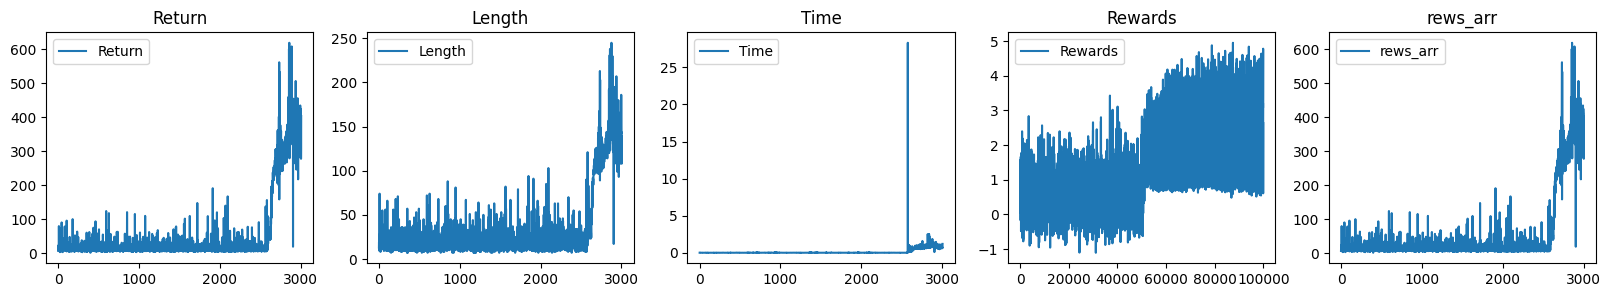

In [39]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 3))

ax1.plot(rs, label='Return')
ax1.legend()
ax1.set_title("Return")

ax2.plot(ls, label='Length')
ax2.legend()
ax2.set_title("Length")

ax3.plot(ts, label='Time')
ax3.legend()
ax3.set_title("Time")

ax4.plot(rewards, label='Rewards')
ax4.legend()
ax4.set_title("Rewards")

ax5.plot(rews_arr, label='rews_arr')
ax5.legend()
ax5.set_title("rews_arr")

plt.show()


In [ ]:
eval_env = gym.make("Hopper-v4", render_mode="rgb_array") #
eval_env = wrap_gym(eval_env, rescale_actions=True)
eval_env = gym.wrappers.RecordVideo(eval_env, 'Hopper-v4')
eval_env = gym.wrappers.RecordEpisodeStatistics(eval_env, buffer_length=1)
evaluate(agent, eval_env, num_episodes=1)
eval_env.close()

In [41]:
env = gym.make("HalfCheetah-v4", render_mode=None)
env = wrap_gym(env, rescale_actions=True)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=1)

eval_env = gym.make("HalfCheetah-v4", render_mode=None) # "rgb_array"
eval_env = wrap_gym(eval_env, rescale_actions=True)
# eval_env = gym.wrappers.RecordVideo(eval_env, 'cartpole_video')
eval_env = gym.wrappers.RecordEpisodeStatistics(eval_env, buffer_length=1)

agent = ScoreMatchingLearner.create(42, env.observation_space, env.action_space)

replay_buffer = ReplayBuffer(env.observation_space, env.action_space, max_iter)

observation, _ = env.reset()
done = False

rs, ls, ts = [], [], []
rewards = []
rews = 0
rews_arr = []
pbar = trange(1, max_iter+1, desc='Training')
for i in pbar:
    if i < start_step:
        action = env.action_space.sample()
    else:
        action, agent = agent.sample_actions(observation)
        action = np.asarray(action)
    next_observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    rews += reward
    if not done or "TimeLimit.truncated" in info:
        mask = 1.0
    else:
        mask = 0.0

    replay_buffer.insert(
            dict(
                observations=observation,
                actions=action,
                rewards=reward,
                masks=mask,
                dones=done,
                next_observations=next_observation,
            )
        )
    observation = next_observation
    rewards.append(reward)
    if done:
        rews_arr.append(rews)
        rews = 0
        observation, _ = env.reset()
        done = False
        # print("Done Info:", info)
        pbar.set_postfix(info['episode'])
        rs.append(info['episode']['r'])
        ls.append(info['episode']['l'])
        ts.append(info['episode']['t'])

    if i >= start_step:
        batch = replay_buffer.sample(batch_size)
        agent, update_info = agent.update(batch)

        if i % print_interval == 0:
            print("Update Info:", update_info)
            print('rew_arrs : ', rews_arr[-1])


    if i % 100_000 == 0:
        eval_info = evaluate(agent, eval_env, num_episodes=num_episodes)
        print("Eval Info", eval_info)

eval_env.close()
env.close()

  logger.deprecation(

Training:  50%|█████     | 50000/100000 [00:39<20:30, 40.62it/s, r=-324, l=1000, t=7.31]  

Update Info: {'actor_loss_mag': Array(3.087915, dtype=float32), 'actor_loss_max': Array(3.087915, dtype=float32), 'actor_loss_mean': Array(0.44357324, dtype=float32), 'actor_loss_min': Array(0.00895207, dtype=float32), 'actor_loss_std': Array(0.41058293, dtype=float32), 'c_loss_mag_1': Array(29.057573, dtype=float32), 'c_loss_mag_2': Array(25.493366, dtype=float32), 'c_loss_max_1': Array(29.057573, dtype=float32), 'c_loss_max_2': Array(25.493366, dtype=float32), 'c_loss_mean_1': Array(4.2159033, dtype=float32), 'c_loss_mean_2': Array(2.3132915, dtype=float32), 'c_loss_min_1': Array(0.00016087, dtype=float32), 'c_loss_min_2': Array(0.0006323, dtype=float32), 'c_loss_std_1': Array(5.036017, dtype=float32), 'c_loss_std_2': Array(3.2972198, dtype=float32), 'critic_jacobian_mag': Array(0.17375764, dtype=float32), 'critic_jacobian_max': Array(0.1343454, dtype=float32), 'critic_jacobian_mean': Array(-0.00096513, dtype=float32), 'critic_jacobian_min': Array(-0.17375764, dtype=float32), 'critic

Training:  51%|█████     | 51034/100000 [00:45<04:38, 175.91it/s, r=-467, l=1000, t=27.8]

Update Info: {'actor_loss_mag': Array(0.01939662, dtype=float32), 'actor_loss_max': Array(0.01939662, dtype=float32), 'actor_loss_mean': Array(0.00246085, dtype=float32), 'actor_loss_min': Array(0.00017639, dtype=float32), 'actor_loss_std': Array(0.00240985, dtype=float32), 'c_loss_mag_1': Array(12.57662, dtype=float32), 'c_loss_mag_2': Array(11.253057, dtype=float32), 'c_loss_max_1': Array(12.57662, dtype=float32), 'c_loss_max_2': Array(11.253057, dtype=float32), 'c_loss_mean_1': Array(1.023063, dtype=float32), 'c_loss_mean_2': Array(1.0654491, dtype=float32), 'c_loss_min_1': Array(6.2594714e-05, dtype=float32), 'c_loss_min_2': Array(6.792485e-05, dtype=float32), 'c_loss_std_1': Array(1.5775765, dtype=float32), 'c_loss_std_2': Array(1.5790609, dtype=float32), 'critic_jacobian_mag': Array(0.609497, dtype=float32), 'critic_jacobian_max': Array(0.609497, dtype=float32), 'critic_jacobian_mean': Array(0.03641847, dtype=float32), 'critic_jacobian_min': Array(-0.55972695, dtype=float32), 'cr

Training:  52%|█████▏    | 52021/100000 [00:51<04:27, 179.09it/s, r=-287, l=1000, t=6.29]

Update Info: {'actor_loss_mag': Array(0.02193928, dtype=float32), 'actor_loss_max': Array(0.02193928, dtype=float32), 'actor_loss_mean': Array(0.00262925, dtype=float32), 'actor_loss_min': Array(0.00013017, dtype=float32), 'actor_loss_std': Array(0.00262037, dtype=float32), 'c_loss_mag_1': Array(11.0645485, dtype=float32), 'c_loss_mag_2': Array(12.529024, dtype=float32), 'c_loss_max_1': Array(11.0645485, dtype=float32), 'c_loss_max_2': Array(12.529024, dtype=float32), 'c_loss_mean_1': Array(0.99603057, dtype=float32), 'c_loss_mean_2': Array(0.97142494, dtype=float32), 'c_loss_min_1': Array(3.180412e-08, dtype=float32), 'c_loss_min_2': Array(1.3293911e-06, dtype=float32), 'c_loss_std_1': Array(1.6286608, dtype=float32), 'c_loss_std_2': Array(1.637941, dtype=float32), 'critic_jacobian_mag': Array(0.6014204, dtype=float32), 'critic_jacobian_max': Array(0.47331136, dtype=float32), 'critic_jacobian_mean': Array(0.03261767, dtype=float32), 'critic_jacobian_min': Array(-0.6014204, dtype=float

Training:  53%|█████▎    | 53015/100000 [00:56<04:23, 178.58it/s, r=-579, l=1000, t=5.29]

Update Info: {'actor_loss_mag': Array(0.02433477, dtype=float32), 'actor_loss_max': Array(0.02433477, dtype=float32), 'actor_loss_mean': Array(0.00381322, dtype=float32), 'actor_loss_min': Array(0.0001546, dtype=float32), 'actor_loss_std': Array(0.00366434, dtype=float32), 'c_loss_mag_1': Array(20.136332, dtype=float32), 'c_loss_mag_2': Array(23.00904, dtype=float32), 'c_loss_max_1': Array(20.136332, dtype=float32), 'c_loss_max_2': Array(23.00904, dtype=float32), 'c_loss_mean_1': Array(0.9997375, dtype=float32), 'c_loss_mean_2': Array(1.0098387, dtype=float32), 'c_loss_min_1': Array(5.2103514e-06, dtype=float32), 'c_loss_min_2': Array(7.730832e-06, dtype=float32), 'c_loss_std_1': Array(2.2128239, dtype=float32), 'c_loss_std_2': Array(2.3246534, dtype=float32), 'critic_jacobian_mag': Array(0.5523746, dtype=float32), 'critic_jacobian_max': Array(0.5523746, dtype=float32), 'critic_jacobian_mean': Array(0.01888125, dtype=float32), 'critic_jacobian_min': Array(-0.5515244, dtype=float32), 'c

Training:  54%|█████▍    | 54011/100000 [01:02<06:19, 121.33it/s, r=-449, l=1000, t=5.74]

Update Info: {'actor_loss_mag': Array(0.05134694, dtype=float32), 'actor_loss_max': Array(0.05134694, dtype=float32), 'actor_loss_mean': Array(0.00570284, dtype=float32), 'actor_loss_min': Array(0.00038253, dtype=float32), 'actor_loss_std': Array(0.00584573, dtype=float32), 'c_loss_mag_1': Array(95.015236, dtype=float32), 'c_loss_mag_2': Array(103.32397, dtype=float32), 'c_loss_max_1': Array(95.015236, dtype=float32), 'c_loss_max_2': Array(103.32397, dtype=float32), 'c_loss_mean_1': Array(2.062174, dtype=float32), 'c_loss_mean_2': Array(1.934882, dtype=float32), 'c_loss_min_1': Array(1.8412153e-05, dtype=float32), 'c_loss_min_2': Array(1.08057066e-08, dtype=float32), 'c_loss_std_1': Array(6.7791142, dtype=float32), 'c_loss_std_2': Array(6.971623, dtype=float32), 'critic_jacobian_mag': Array(0.9010729, dtype=float32), 'critic_jacobian_max': Array(0.9010729, dtype=float32), 'critic_jacobian_mean': Array(0.02934611, dtype=float32), 'critic_jacobian_min': Array(-0.6259874, dtype=float32), 

Training:  55%|█████▌    | 55028/100000 [01:07<04:04, 183.81it/s, r=-371, l=1000, t=5.61]

Update Info: {'actor_loss_mag': Array(0.03896816, dtype=float32), 'actor_loss_max': Array(0.03896816, dtype=float32), 'actor_loss_mean': Array(0.00618131, dtype=float32), 'actor_loss_min': Array(4.1509054e-05, dtype=float32), 'actor_loss_std': Array(0.00644234, dtype=float32), 'c_loss_mag_1': Array(36.36131, dtype=float32), 'c_loss_mag_2': Array(34.35477, dtype=float32), 'c_loss_max_1': Array(36.36131, dtype=float32), 'c_loss_max_2': Array(34.35477, dtype=float32), 'c_loss_mean_1': Array(1.8658417, dtype=float32), 'c_loss_mean_2': Array(1.8256269, dtype=float32), 'c_loss_min_1': Array(3.4512632e-06, dtype=float32), 'c_loss_min_2': Array(0.00018415, dtype=float32), 'c_loss_std_1': Array(4.079879, dtype=float32), 'c_loss_std_2': Array(3.947645, dtype=float32), 'critic_jacobian_mag': Array(1.0299239, dtype=float32), 'critic_jacobian_max': Array(1.0299239, dtype=float32), 'critic_jacobian_mean': Array(0.0413365, dtype=float32), 'critic_jacobian_min': Array(-0.58874565, dtype=float32), 'cri

Training:  56%|█████▌    | 56026/100000 [01:13<04:00, 182.48it/s, r=-397, l=1000, t=5.2]

Update Info: {'actor_loss_mag': Array(0.06594083, dtype=float32), 'actor_loss_max': Array(0.06594083, dtype=float32), 'actor_loss_mean': Array(0.0082632, dtype=float32), 'actor_loss_min': Array(0.00018817, dtype=float32), 'actor_loss_std': Array(0.00925322, dtype=float32), 'c_loss_mag_1': Array(41.43361, dtype=float32), 'c_loss_mag_2': Array(43.927467, dtype=float32), 'c_loss_max_1': Array(41.43361, dtype=float32), 'c_loss_max_2': Array(43.927467, dtype=float32), 'c_loss_mean_1': Array(1.6939383, dtype=float32), 'c_loss_mean_2': Array(1.8679212, dtype=float32), 'c_loss_min_1': Array(2.180133e-05, dtype=float32), 'c_loss_min_2': Array(0.00014045, dtype=float32), 'c_loss_std_1': Array(3.8509703, dtype=float32), 'c_loss_std_2': Array(4.313689, dtype=float32), 'critic_jacobian_mag': Array(1.4673203, dtype=float32), 'critic_jacobian_max': Array(1.4673203, dtype=float32), 'critic_jacobian_mean': Array(0.04010317, dtype=float32), 'critic_jacobian_min': Array(-0.91252774, dtype=float32), 'crit

Training:  57%|█████▋    | 57026/100000 [01:19<03:50, 186.16it/s, r=-347, l=1000, t=6.32]

Update Info: {'actor_loss_mag': Array(0.09688601, dtype=float32), 'actor_loss_max': Array(0.09688601, dtype=float32), 'actor_loss_mean': Array(0.00890814, dtype=float32), 'actor_loss_min': Array(0.00027575, dtype=float32), 'actor_loss_std': Array(0.01116517, dtype=float32), 'c_loss_mag_1': Array(29.57166, dtype=float32), 'c_loss_mag_2': Array(30.839966, dtype=float32), 'c_loss_max_1': Array(29.57166, dtype=float32), 'c_loss_max_2': Array(30.839966, dtype=float32), 'c_loss_mean_1': Array(1.7762573, dtype=float32), 'c_loss_mean_2': Array(1.7698678, dtype=float32), 'c_loss_min_1': Array(5.990792e-05, dtype=float32), 'c_loss_min_2': Array(3.7696595e-05, dtype=float32), 'c_loss_std_1': Array(3.9642978, dtype=float32), 'c_loss_std_2': Array(3.968078, dtype=float32), 'critic_jacobian_mag': Array(1.6053462, dtype=float32), 'critic_jacobian_max': Array(1.6053462, dtype=float32), 'critic_jacobian_mean': Array(0.01322487, dtype=float32), 'critic_jacobian_min': Array(-1.314141, dtype=float32), 'cr

Training:  58%|█████▊    | 58026/100000 [01:24<03:47, 184.72it/s, r=-425, l=1000, t=5.23]

Update Info: {'actor_loss_mag': Array(0.09154969, dtype=float32), 'actor_loss_max': Array(0.09154969, dtype=float32), 'actor_loss_mean': Array(0.01106609, dtype=float32), 'actor_loss_min': Array(0.00042437, dtype=float32), 'actor_loss_std': Array(0.01302271, dtype=float32), 'c_loss_mag_1': Array(41.691505, dtype=float32), 'c_loss_mag_2': Array(44.669914, dtype=float32), 'c_loss_max_1': Array(41.691505, dtype=float32), 'c_loss_max_2': Array(44.669914, dtype=float32), 'c_loss_mean_1': Array(2.26867, dtype=float32), 'c_loss_mean_2': Array(2.4331036, dtype=float32), 'c_loss_min_1': Array(6.4013957e-06, dtype=float32), 'c_loss_min_2': Array(0.00015873, dtype=float32), 'c_loss_std_1': Array(4.339862, dtype=float32), 'c_loss_std_2': Array(4.762622, dtype=float32), 'critic_jacobian_mag': Array(1.9571793, dtype=float32), 'critic_jacobian_max': Array(1.8171291, dtype=float32), 'critic_jacobian_mean': Array(0.01918616, dtype=float32), 'critic_jacobian_min': Array(-1.9571793, dtype=float32), 'crit

Training:  59%|█████▉    | 59032/100000 [01:31<03:47, 179.97it/s, r=-404, l=1000, t=6.35]

Update Info: {'actor_loss_mag': Array(0.07603531, dtype=float32), 'actor_loss_max': Array(0.07603531, dtype=float32), 'actor_loss_mean': Array(0.01133599, dtype=float32), 'actor_loss_min': Array(0.00054432, dtype=float32), 'actor_loss_std': Array(0.01098461, dtype=float32), 'c_loss_mag_1': Array(29.690035, dtype=float32), 'c_loss_mag_2': Array(29.970491, dtype=float32), 'c_loss_max_1': Array(29.690035, dtype=float32), 'c_loss_max_2': Array(29.970491, dtype=float32), 'c_loss_mean_1': Array(2.1984046, dtype=float32), 'c_loss_mean_2': Array(2.037656, dtype=float32), 'c_loss_min_1': Array(0.00038575, dtype=float32), 'c_loss_min_2': Array(5.524856e-05, dtype=float32), 'c_loss_std_1': Array(3.9585056, dtype=float32), 'c_loss_std_2': Array(3.9738336, dtype=float32), 'critic_jacobian_mag': Array(1.931391, dtype=float32), 'critic_jacobian_max': Array(1.931391, dtype=float32), 'critic_jacobian_mean': Array(0.03214386, dtype=float32), 'critic_jacobian_min': Array(-1.549875, dtype=float32), 'criti

Training:  60%|██████    | 60034/100000 [01:36<03:38, 183.21it/s, r=-373, l=1000, t=5.21]

Update Info: {'actor_loss_mag': Array(0.17159173, dtype=float32), 'actor_loss_max': Array(0.17159173, dtype=float32), 'actor_loss_mean': Array(0.01481464, dtype=float32), 'actor_loss_min': Array(5.420323e-05, dtype=float32), 'actor_loss_std': Array(0.01983392, dtype=float32), 'c_loss_mag_1': Array(21.330008, dtype=float32), 'c_loss_mag_2': Array(25.202919, dtype=float32), 'c_loss_max_1': Array(21.330008, dtype=float32), 'c_loss_max_2': Array(25.202919, dtype=float32), 'c_loss_mean_1': Array(1.863118, dtype=float32), 'c_loss_mean_2': Array(2.0736964, dtype=float32), 'c_loss_min_1': Array(5.2420154e-07, dtype=float32), 'c_loss_min_2': Array(6.726623e-09, dtype=float32), 'c_loss_std_1': Array(3.4503343, dtype=float32), 'c_loss_std_2': Array(4.0447927, dtype=float32), 'critic_jacobian_mag': Array(1.9259431, dtype=float32), 'critic_jacobian_max': Array(1.9259431, dtype=float32), 'critic_jacobian_mean': Array(0.02597392, dtype=float32), 'critic_jacobian_min': Array(-1.3102391, dtype=float32)

Training:  61%|██████    | 61017/100000 [01:42<05:38, 115.11it/s, r=-349, l=1000, t=5.93]

Update Info: {'actor_loss_mag': Array(0.07075176, dtype=float32), 'actor_loss_max': Array(0.07075176, dtype=float32), 'actor_loss_mean': Array(0.01292729, dtype=float32), 'actor_loss_min': Array(0.00074123, dtype=float32), 'actor_loss_std': Array(0.01325032, dtype=float32), 'c_loss_mag_1': Array(209.62593, dtype=float32), 'c_loss_mag_2': Array(200.71844, dtype=float32), 'c_loss_max_1': Array(209.62593, dtype=float32), 'c_loss_max_2': Array(200.71844, dtype=float32), 'c_loss_mean_1': Array(2.1999865, dtype=float32), 'c_loss_mean_2': Array(2.0253158, dtype=float32), 'c_loss_min_1': Array(8.663628e-07, dtype=float32), 'c_loss_min_2': Array(2.5668356e-09, dtype=float32), 'c_loss_std_1': Array(13.283818, dtype=float32), 'c_loss_std_2': Array(12.610902, dtype=float32), 'critic_jacobian_mag': Array(1.8165127, dtype=float32), 'critic_jacobian_max': Array(1.8165127, dtype=float32), 'critic_jacobian_mean': Array(0.0058085, dtype=float32), 'critic_jacobian_min': Array(-1.4332232, dtype=float32), 

Training:  62%|██████▏   | 62030/100000 [01:47<03:22, 187.06it/s, r=-383, l=1000, t=5.43]

Update Info: {'actor_loss_mag': Array(0.10976865, dtype=float32), 'actor_loss_max': Array(0.10976865, dtype=float32), 'actor_loss_mean': Array(0.01443716, dtype=float32), 'actor_loss_min': Array(0.0002234, dtype=float32), 'actor_loss_std': Array(0.01494039, dtype=float32), 'c_loss_mag_1': Array(33.54796, dtype=float32), 'c_loss_mag_2': Array(52.779594, dtype=float32), 'c_loss_max_1': Array(33.54796, dtype=float32), 'c_loss_max_2': Array(52.779594, dtype=float32), 'c_loss_mean_1': Array(1.9931779, dtype=float32), 'c_loss_mean_2': Array(2.110333, dtype=float32), 'c_loss_min_1': Array(2.562489e-05, dtype=float32), 'c_loss_min_2': Array(8.7515255e-06, dtype=float32), 'c_loss_std_1': Array(4.086992, dtype=float32), 'c_loss_std_2': Array(4.915912, dtype=float32), 'critic_jacobian_mag': Array(2.233847, dtype=float32), 'critic_jacobian_max': Array(2.233847, dtype=float32), 'critic_jacobian_mean': Array(0.02563414, dtype=float32), 'critic_jacobian_min': Array(-1.3013928, dtype=float32), 'critic

Training:  63%|██████▎   | 63010/100000 [01:52<03:54, 157.83it/s, r=-293, l=1000, t=5.26]

Update Info: {'actor_loss_mag': Array(0.10930966, dtype=float32), 'actor_loss_max': Array(0.10930966, dtype=float32), 'actor_loss_mean': Array(0.01376016, dtype=float32), 'actor_loss_min': Array(0.00077422, dtype=float32), 'actor_loss_std': Array(0.01589782, dtype=float32), 'c_loss_mag_1': Array(26.28, dtype=float32), 'c_loss_mag_2': Array(27.086252, dtype=float32), 'c_loss_max_1': Array(26.28, dtype=float32), 'c_loss_max_2': Array(27.086252, dtype=float32), 'c_loss_mean_1': Array(1.729775, dtype=float32), 'c_loss_mean_2': Array(1.5610813, dtype=float32), 'c_loss_min_1': Array(3.2003867e-05, dtype=float32), 'c_loss_min_2': Array(1.639684e-05, dtype=float32), 'c_loss_std_1': Array(3.0650592, dtype=float32), 'c_loss_std_2': Array(2.9600713, dtype=float32), 'critic_jacobian_mag': Array(2.058867, dtype=float32), 'critic_jacobian_max': Array(2.058867, dtype=float32), 'critic_jacobian_mean': Array(0.02120927, dtype=float32), 'critic_jacobian_min': Array(-1.2475898, dtype=float32), 'critic_ja

Training:  64%|██████▍   | 64034/100000 [01:59<03:13, 186.02it/s, r=-311, l=1000, t=6.26]

Update Info: {'actor_loss_mag': Array(0.16171202, dtype=float32), 'actor_loss_max': Array(0.16171202, dtype=float32), 'actor_loss_mean': Array(0.01837512, dtype=float32), 'actor_loss_min': Array(0.00097478, dtype=float32), 'actor_loss_std': Array(0.02191177, dtype=float32), 'c_loss_mag_1': Array(27.273748, dtype=float32), 'c_loss_mag_2': Array(22.852364, dtype=float32), 'c_loss_max_1': Array(27.273748, dtype=float32), 'c_loss_max_2': Array(22.852364, dtype=float32), 'c_loss_mean_1': Array(1.9699183, dtype=float32), 'c_loss_mean_2': Array(1.8322446, dtype=float32), 'c_loss_min_1': Array(0.00018963, dtype=float32), 'c_loss_min_2': Array(7.366907e-11, dtype=float32), 'c_loss_std_1': Array(3.2621474, dtype=float32), 'c_loss_std_2': Array(2.8589916, dtype=float32), 'critic_jacobian_mag': Array(2.1495352, dtype=float32), 'critic_jacobian_max': Array(2.1495352, dtype=float32), 'critic_jacobian_mean': Array(0.02239835, dtype=float32), 'critic_jacobian_min': Array(-1.3319883, dtype=float32), 'c

Training:  65%|██████▌   | 65035/100000 [02:04<03:07, 186.27it/s, r=-258, l=1000, t=5.25]

Update Info: {'actor_loss_mag': Array(0.11523461, dtype=float32), 'actor_loss_max': Array(0.11523461, dtype=float32), 'actor_loss_mean': Array(0.01841009, dtype=float32), 'actor_loss_min': Array(0.00063101, dtype=float32), 'actor_loss_std': Array(0.01994104, dtype=float32), 'c_loss_mag_1': Array(37.123306, dtype=float32), 'c_loss_mag_2': Array(25.522762, dtype=float32), 'c_loss_max_1': Array(37.123306, dtype=float32), 'c_loss_max_2': Array(25.522762, dtype=float32), 'c_loss_mean_1': Array(1.9792063, dtype=float32), 'c_loss_mean_2': Array(1.9107449, dtype=float32), 'c_loss_min_1': Array(0.00012293, dtype=float32), 'c_loss_min_2': Array(1.7784336e-05, dtype=float32), 'c_loss_std_1': Array(3.6513186, dtype=float32), 'c_loss_std_2': Array(3.3832405, dtype=float32), 'critic_jacobian_mag': Array(2.002448, dtype=float32), 'critic_jacobian_max': Array(2.002448, dtype=float32), 'critic_jacobian_mean': Array(0.03104159, dtype=float32), 'critic_jacobian_min': Array(-1.6330916, dtype=float32), 'cr

Training:  66%|██████▌   | 66025/100000 [02:10<03:12, 176.53it/s, r=-283, l=1000, t=6.3]

Update Info: {'actor_loss_mag': Array(0.11540237, dtype=float32), 'actor_loss_max': Array(0.11540237, dtype=float32), 'actor_loss_mean': Array(0.01781588, dtype=float32), 'actor_loss_min': Array(0.00121235, dtype=float32), 'actor_loss_std': Array(0.0196605, dtype=float32), 'c_loss_mag_1': Array(36.602028, dtype=float32), 'c_loss_mag_2': Array(41.62042, dtype=float32), 'c_loss_max_1': Array(36.602028, dtype=float32), 'c_loss_max_2': Array(41.62042, dtype=float32), 'c_loss_mean_1': Array(2.282051, dtype=float32), 'c_loss_mean_2': Array(2.1710143, dtype=float32), 'c_loss_min_1': Array(0.00053187, dtype=float32), 'c_loss_min_2': Array(2.8807684e-05, dtype=float32), 'c_loss_std_1': Array(4.622003, dtype=float32), 'c_loss_std_2': Array(4.4206214, dtype=float32), 'critic_jacobian_mag': Array(3.1982293, dtype=float32), 'critic_jacobian_max': Array(3.1982293, dtype=float32), 'critic_jacobian_mean': Array(0.01290137, dtype=float32), 'critic_jacobian_min': Array(-1.1686286, dtype=float32), 'criti

Training:  67%|██████▋   | 67027/100000 [02:15<02:57, 185.97it/s, r=-222, l=1000, t=5.23]

Update Info: {'actor_loss_mag': Array(0.13427322, dtype=float32), 'actor_loss_max': Array(0.13427322, dtype=float32), 'actor_loss_mean': Array(0.01945296, dtype=float32), 'actor_loss_min': Array(0.00075561, dtype=float32), 'actor_loss_std': Array(0.02080089, dtype=float32), 'c_loss_mag_1': Array(31.829174, dtype=float32), 'c_loss_mag_2': Array(36.398476, dtype=float32), 'c_loss_max_1': Array(31.829174, dtype=float32), 'c_loss_max_2': Array(36.398476, dtype=float32), 'c_loss_mean_1': Array(2.0662546, dtype=float32), 'c_loss_mean_2': Array(1.9986367, dtype=float32), 'c_loss_min_1': Array(0.00014771, dtype=float32), 'c_loss_min_2': Array(3.5547864e-06, dtype=float32), 'c_loss_std_1': Array(4.175504, dtype=float32), 'c_loss_std_2': Array(3.9090106, dtype=float32), 'critic_jacobian_mag': Array(1.8177383, dtype=float32), 'critic_jacobian_max': Array(1.8177383, dtype=float32), 'critic_jacobian_mean': Array(0.00439047, dtype=float32), 'critic_jacobian_min': Array(-1.1589699, dtype=float32), 'c

Training:  68%|██████▊   | 68023/100000 [02:22<02:55, 182.53it/s, r=175, l=1000, t=6.26]

Update Info: {'actor_loss_mag': Array(0.13220331, dtype=float32), 'actor_loss_max': Array(0.13220331, dtype=float32), 'actor_loss_mean': Array(0.02181037, dtype=float32), 'actor_loss_min': Array(0.00129088, dtype=float32), 'actor_loss_std': Array(0.02397855, dtype=float32), 'c_loss_mag_1': Array(22.04784, dtype=float32), 'c_loss_mag_2': Array(19.039738, dtype=float32), 'c_loss_max_1': Array(22.04784, dtype=float32), 'c_loss_max_2': Array(19.039738, dtype=float32), 'c_loss_mean_1': Array(1.7347628, dtype=float32), 'c_loss_mean_2': Array(1.8724697, dtype=float32), 'c_loss_min_1': Array(4.2041393e-06, dtype=float32), 'c_loss_min_2': Array(1.1695702e-06, dtype=float32), 'c_loss_std_1': Array(3.1116624, dtype=float32), 'c_loss_std_2': Array(3.1153314, dtype=float32), 'critic_jacobian_mag': Array(1.8352143, dtype=float32), 'critic_jacobian_max': Array(1.8352143, dtype=float32), 'critic_jacobian_mean': Array(0.00050343, dtype=float32), 'critic_jacobian_min': Array(-1.3947532, dtype=float32), 

Training:  69%|██████▉   | 69033/100000 [02:27<02:51, 181.05it/s, r=-133, l=1000, t=5.21]

Update Info: {'actor_loss_mag': Array(0.26221675, dtype=float32), 'actor_loss_max': Array(0.26221675, dtype=float32), 'actor_loss_mean': Array(0.02209518, dtype=float32), 'actor_loss_min': Array(0.00136079, dtype=float32), 'actor_loss_std': Array(0.0268837, dtype=float32), 'c_loss_mag_1': Array(48.20926, dtype=float32), 'c_loss_mag_2': Array(48.19954, dtype=float32), 'c_loss_max_1': Array(48.20926, dtype=float32), 'c_loss_max_2': Array(48.19954, dtype=float32), 'c_loss_mean_1': Array(1.7381828, dtype=float32), 'c_loss_mean_2': Array(1.7009544, dtype=float32), 'c_loss_min_1': Array(1.7826096e-10, dtype=float32), 'c_loss_min_2': Array(7.780631e-06, dtype=float32), 'c_loss_std_1': Array(3.8056386, dtype=float32), 'c_loss_std_2': Array(3.9809, dtype=float32), 'critic_jacobian_mag': Array(2.2394147, dtype=float32), 'critic_jacobian_max': Array(2.2394147, dtype=float32), 'critic_jacobian_mean': Array(0.00032085, dtype=float32), 'critic_jacobian_min': Array(-1.3902857, dtype=float32), 'critic

Training:  70%|███████   | 70022/100000 [02:33<04:03, 122.86it/s, r=641, l=1000, t=5.75]

Update Info: {'actor_loss_mag': Array(0.2362098, dtype=float32), 'actor_loss_max': Array(0.2362098, dtype=float32), 'actor_loss_mean': Array(0.02672454, dtype=float32), 'actor_loss_min': Array(0.00111635, dtype=float32), 'actor_loss_std': Array(0.03169107, dtype=float32), 'c_loss_mag_1': Array(425.98083, dtype=float32), 'c_loss_mag_2': Array(426.26212, dtype=float32), 'c_loss_max_1': Array(425.98083, dtype=float32), 'c_loss_max_2': Array(426.26212, dtype=float32), 'c_loss_mean_1': Array(3.095596, dtype=float32), 'c_loss_mean_2': Array(3.138176, dtype=float32), 'c_loss_min_1': Array(9.977582e-05, dtype=float32), 'c_loss_min_2': Array(1.2922683e-06, dtype=float32), 'c_loss_std_1': Array(26.596138, dtype=float32), 'c_loss_std_2': Array(26.620554, dtype=float32), 'critic_jacobian_mag': Array(1.8935919, dtype=float32), 'critic_jacobian_max': Array(1.8935919, dtype=float32), 'critic_jacobian_mean': Array(0.02882558, dtype=float32), 'critic_jacobian_min': Array(-1.5844874, dtype=float32), 'cr

Training:  71%|███████   | 71027/100000 [02:39<03:07, 154.66it/s, r=526, l=1000, t=6.74]

Update Info: {'actor_loss_mag': Array(0.162904, dtype=float32), 'actor_loss_max': Array(0.162904, dtype=float32), 'actor_loss_mean': Array(0.02245305, dtype=float32), 'actor_loss_min': Array(0.00041045, dtype=float32), 'actor_loss_std': Array(0.02408454, dtype=float32), 'c_loss_mag_1': Array(26.410507, dtype=float32), 'c_loss_mag_2': Array(21.829134, dtype=float32), 'c_loss_max_1': Array(26.410507, dtype=float32), 'c_loss_max_2': Array(21.829134, dtype=float32), 'c_loss_mean_1': Array(2.1736474, dtype=float32), 'c_loss_mean_2': Array(1.959598, dtype=float32), 'c_loss_min_1': Array(1.1205884e-06, dtype=float32), 'c_loss_min_2': Array(0.00022591, dtype=float32), 'c_loss_std_1': Array(4.330798, dtype=float32), 'c_loss_std_2': Array(3.6132967, dtype=float32), 'critic_jacobian_mag': Array(3.0356746, dtype=float32), 'critic_jacobian_max': Array(3.0356746, dtype=float32), 'critic_jacobian_mean': Array(0.0209929, dtype=float32), 'critic_jacobian_min': Array(-1.4406476, dtype=float32), 'critic_

Training:  72%|███████▏  | 72020/100000 [02:45<03:54, 119.28it/s, r=793, l=1000, t=5.75]

Update Info: {'actor_loss_mag': Array(0.18974257, dtype=float32), 'actor_loss_max': Array(0.18974257, dtype=float32), 'actor_loss_mean': Array(0.02704361, dtype=float32), 'actor_loss_min': Array(0.00167563, dtype=float32), 'actor_loss_std': Array(0.02895186, dtype=float32), 'c_loss_mag_1': Array(553.1924, dtype=float32), 'c_loss_mag_2': Array(530.6322, dtype=float32), 'c_loss_max_1': Array(553.1924, dtype=float32), 'c_loss_max_2': Array(530.6322, dtype=float32), 'c_loss_mean_1': Array(3.6400392, dtype=float32), 'c_loss_mean_2': Array(3.7565174, dtype=float32), 'c_loss_min_1': Array(0.00010444, dtype=float32), 'c_loss_min_2': Array(0.00020831, dtype=float32), 'c_loss_std_1': Array(34.50194, dtype=float32), 'c_loss_std_2': Array(33.168655, dtype=float32), 'critic_jacobian_mag': Array(1.8979126, dtype=float32), 'critic_jacobian_max': Array(1.8979126, dtype=float32), 'critic_jacobian_mean': Array(0.01623433, dtype=float32), 'critic_jacobian_min': Array(-1.891285, dtype=float32), 'critic_ja

Training:  73%|███████▎  | 73028/100000 [02:51<02:25, 184.92it/s, r=813, l=1000, t=5.95]

Update Info: {'actor_loss_mag': Array(0.12614386, dtype=float32), 'actor_loss_max': Array(0.12614386, dtype=float32), 'actor_loss_mean': Array(0.02852673, dtype=float32), 'actor_loss_min': Array(0.00135584, dtype=float32), 'actor_loss_std': Array(0.02702285, dtype=float32), 'c_loss_mag_1': Array(415.36752, dtype=float32), 'c_loss_mag_2': Array(450.74963, dtype=float32), 'c_loss_max_1': Array(415.36752, dtype=float32), 'c_loss_max_2': Array(450.74963, dtype=float32), 'c_loss_mean_1': Array(3.548301, dtype=float32), 'c_loss_mean_2': Array(3.6123292, dtype=float32), 'c_loss_min_1': Array(2.8623708e-05, dtype=float32), 'c_loss_min_2': Array(7.689598e-05, dtype=float32), 'c_loss_std_1': Array(26.056934, dtype=float32), 'c_loss_std_2': Array(28.188694, dtype=float32), 'critic_jacobian_mag': Array(2.120582, dtype=float32), 'critic_jacobian_max': Array(2.120582, dtype=float32), 'critic_jacobian_mean': Array(0.02919508, dtype=float32), 'critic_jacobian_min': Array(-1.7704728, dtype=float32), 'c

Training:  74%|███████▍  | 74023/100000 [02:56<02:21, 182.98it/s, r=552, l=1000, t=5.21]

Update Info: {'actor_loss_mag': Array(0.21385816, dtype=float32), 'actor_loss_max': Array(0.21385816, dtype=float32), 'actor_loss_mean': Array(0.02963577, dtype=float32), 'actor_loss_min': Array(0.0016552, dtype=float32), 'actor_loss_std': Array(0.02931309, dtype=float32), 'c_loss_mag_1': Array(15.734426, dtype=float32), 'c_loss_mag_2': Array(16.636688, dtype=float32), 'c_loss_max_1': Array(15.734426, dtype=float32), 'c_loss_max_2': Array(16.636688, dtype=float32), 'c_loss_mean_1': Array(1.6138222, dtype=float32), 'c_loss_mean_2': Array(1.6359655, dtype=float32), 'c_loss_min_1': Array(2.85243e-05, dtype=float32), 'c_loss_min_2': Array(0.00035569, dtype=float32), 'c_loss_std_1': Array(2.6471376, dtype=float32), 'c_loss_std_2': Array(2.4761643, dtype=float32), 'critic_jacobian_mag': Array(2.097486, dtype=float32), 'critic_jacobian_max': Array(2.024034, dtype=float32), 'critic_jacobian_mean': Array(0.01299832, dtype=float32), 'critic_jacobian_min': Array(-2.097486, dtype=float32), 'critic

Training:  75%|███████▌  | 75018/100000 [03:02<02:22, 175.23it/s, r=1.13e+3, l=1000, t=6.18]

Update Info: {'actor_loss_mag': Array(0.21410435, dtype=float32), 'actor_loss_max': Array(0.21410435, dtype=float32), 'actor_loss_mean': Array(0.03434973, dtype=float32), 'actor_loss_min': Array(0.00138237, dtype=float32), 'actor_loss_std': Array(0.03527102, dtype=float32), 'c_loss_mag_1': Array(58.017994, dtype=float32), 'c_loss_mag_2': Array(42.985435, dtype=float32), 'c_loss_max_1': Array(58.017994, dtype=float32), 'c_loss_max_2': Array(42.985435, dtype=float32), 'c_loss_mean_1': Array(2.4389083, dtype=float32), 'c_loss_mean_2': Array(2.56023, dtype=float32), 'c_loss_min_1': Array(1.2203208e-05, dtype=float32), 'c_loss_min_2': Array(1.0170275e-05, dtype=float32), 'c_loss_std_1': Array(5.7936444, dtype=float32), 'c_loss_std_2': Array(4.788036, dtype=float32), 'critic_jacobian_mag': Array(2.1543329, dtype=float32), 'critic_jacobian_max': Array(2.1543329, dtype=float32), 'critic_jacobian_mean': Array(0.01861985, dtype=float32), 'critic_jacobian_min': Array(-1.7037196, dtype=float32), '

Training:  76%|███████▌  | 76028/100000 [03:08<02:10, 183.66it/s, r=275, l=1000, t=5.31]

Update Info: {'actor_loss_mag': Array(0.39449346, dtype=float32), 'actor_loss_max': Array(0.39449346, dtype=float32), 'actor_loss_mean': Array(0.04157124, dtype=float32), 'actor_loss_min': Array(0.00146864, dtype=float32), 'actor_loss_std': Array(0.0471296, dtype=float32), 'c_loss_mag_1': Array(42.67427, dtype=float32), 'c_loss_mag_2': Array(28.630014, dtype=float32), 'c_loss_max_1': Array(42.67427, dtype=float32), 'c_loss_max_2': Array(28.630014, dtype=float32), 'c_loss_mean_1': Array(2.2037177, dtype=float32), 'c_loss_mean_2': Array(2.0521827, dtype=float32), 'c_loss_min_1': Array(1.6150621e-05, dtype=float32), 'c_loss_min_2': Array(6.742275e-05, dtype=float32), 'c_loss_std_1': Array(4.5765986, dtype=float32), 'c_loss_std_2': Array(3.7986312, dtype=float32), 'critic_jacobian_mag': Array(2.3496516, dtype=float32), 'critic_jacobian_max': Array(2.3496516, dtype=float32), 'critic_jacobian_mean': Array(0.05100067, dtype=float32), 'critic_jacobian_min': Array(-2.086207, dtype=float32), 'cr

Training:  77%|███████▋  | 77027/100000 [03:14<02:02, 186.98it/s, r=1.33e+3, l=1000, t=6.29]

Update Info: {'actor_loss_mag': Array(0.21767804, dtype=float32), 'actor_loss_max': Array(0.21767804, dtype=float32), 'actor_loss_mean': Array(0.04150771, dtype=float32), 'actor_loss_min': Array(0.00174621, dtype=float32), 'actor_loss_std': Array(0.04191573, dtype=float32), 'c_loss_mag_1': Array(53.081116, dtype=float32), 'c_loss_mag_2': Array(61.196583, dtype=float32), 'c_loss_max_1': Array(53.081116, dtype=float32), 'c_loss_max_2': Array(61.196583, dtype=float32), 'c_loss_mean_1': Array(2.7076964, dtype=float32), 'c_loss_mean_2': Array(2.5401905, dtype=float32), 'c_loss_min_1': Array(5.8499063e-07, dtype=float32), 'c_loss_min_2': Array(1.0520127e-06, dtype=float32), 'c_loss_std_1': Array(5.84895, dtype=float32), 'c_loss_std_2': Array(5.9702244, dtype=float32), 'critic_jacobian_mag': Array(3.4791992, dtype=float32), 'critic_jacobian_max': Array(3.4791992, dtype=float32), 'critic_jacobian_mean': Array(0.06139229, dtype=float32), 'critic_jacobian_min': Array(-1.7655568, dtype=float32), 

Training:  78%|███████▊  | 78025/100000 [03:19<02:02, 178.94it/s, r=1.26e+3, l=1000, t=5.26]

Update Info: {'actor_loss_mag': Array(0.30450195, dtype=float32), 'actor_loss_max': Array(0.30450195, dtype=float32), 'actor_loss_mean': Array(0.04495525, dtype=float32), 'actor_loss_min': Array(0.00158053, dtype=float32), 'actor_loss_std': Array(0.0480885, dtype=float32), 'c_loss_mag_1': Array(45.164005, dtype=float32), 'c_loss_mag_2': Array(33.297573, dtype=float32), 'c_loss_max_1': Array(45.164005, dtype=float32), 'c_loss_max_2': Array(33.297573, dtype=float32), 'c_loss_mean_1': Array(2.8074684, dtype=float32), 'c_loss_mean_2': Array(2.6923823, dtype=float32), 'c_loss_min_1': Array(9.648829e-07, dtype=float32), 'c_loss_min_2': Array(7.829047e-05, dtype=float32), 'c_loss_std_1': Array(5.1187572, dtype=float32), 'c_loss_std_2': Array(4.756714, dtype=float32), 'critic_jacobian_mag': Array(3.3082347, dtype=float32), 'critic_jacobian_max': Array(3.3082347, dtype=float32), 'critic_jacobian_mean': Array(0.01299783, dtype=float32), 'critic_jacobian_min': Array(-2.2742047, dtype=float32), 'c

Training:  79%|███████▉  | 79015/100000 [03:25<02:57, 118.40it/s, r=1.62e+3, l=1000, t=6.21]

Update Info: {'actor_loss_mag': Array(0.25547874, dtype=float32), 'actor_loss_max': Array(0.25547874, dtype=float32), 'actor_loss_mean': Array(0.04409764, dtype=float32), 'actor_loss_min': Array(0.0017375, dtype=float32), 'actor_loss_std': Array(0.04193933, dtype=float32), 'c_loss_mag_1': Array(701.66864, dtype=float32), 'c_loss_mag_2': Array(677.673, dtype=float32), 'c_loss_max_1': Array(701.66864, dtype=float32), 'c_loss_max_2': Array(677.673, dtype=float32), 'c_loss_mean_1': Array(4.8852525, dtype=float32), 'c_loss_mean_2': Array(4.969507, dtype=float32), 'c_loss_min_1': Array(0.00046043, dtype=float32), 'c_loss_min_2': Array(2.6109923e-05, dtype=float32), 'c_loss_std_1': Array(43.78931, dtype=float32), 'c_loss_std_2': Array(42.344807, dtype=float32), 'critic_jacobian_mag': Array(2.8231776, dtype=float32), 'critic_jacobian_max': Array(2.8231776, dtype=float32), 'critic_jacobian_mean': Array(0.02703032, dtype=float32), 'critic_jacobian_min': Array(-2.1731772, dtype=float32), 'critic_

Training:  80%|████████  | 80028/100000 [03:31<01:48, 184.01it/s, r=1.66e+3, l=1000, t=5.31]

Update Info: {'actor_loss_mag': Array(0.31771696, dtype=float32), 'actor_loss_max': Array(0.31771696, dtype=float32), 'actor_loss_mean': Array(0.0485543, dtype=float32), 'actor_loss_min': Array(0.0005153, dtype=float32), 'actor_loss_std': Array(0.04465042, dtype=float32), 'c_loss_mag_1': Array(35.669525, dtype=float32), 'c_loss_mag_2': Array(28.766544, dtype=float32), 'c_loss_max_1': Array(35.669525, dtype=float32), 'c_loss_max_2': Array(28.766544, dtype=float32), 'c_loss_mean_1': Array(2.251237, dtype=float32), 'c_loss_mean_2': Array(2.1305702, dtype=float32), 'c_loss_min_1': Array(1.1839496e-05, dtype=float32), 'c_loss_min_2': Array(0.00019739, dtype=float32), 'c_loss_std_1': Array(4.059681, dtype=float32), 'c_loss_std_2': Array(3.8063974, dtype=float32), 'critic_jacobian_mag': Array(2.34305, dtype=float32), 'critic_jacobian_max': Array(2.34305, dtype=float32), 'critic_jacobian_mean': Array(0.053024, dtype=float32), 'critic_jacobian_min': Array(-1.8514246, dtype=float32), 'critic_jac

Training:  81%|████████  | 81011/100000 [03:36<02:08, 147.39it/s, r=879, l=1000, t=5.29]

Update Info: {'actor_loss_mag': Array(0.35671493, dtype=float32), 'actor_loss_max': Array(0.35671493, dtype=float32), 'actor_loss_mean': Array(0.05896914, dtype=float32), 'actor_loss_min': Array(0.00248571, dtype=float32), 'actor_loss_std': Array(0.05804171, dtype=float32), 'c_loss_mag_1': Array(58.179085, dtype=float32), 'c_loss_mag_2': Array(61.04047, dtype=float32), 'c_loss_max_1': Array(58.179085, dtype=float32), 'c_loss_max_2': Array(61.04047, dtype=float32), 'c_loss_mean_1': Array(2.8817463, dtype=float32), 'c_loss_mean_2': Array(2.6351495, dtype=float32), 'c_loss_min_1': Array(9.313226e-08, dtype=float32), 'c_loss_min_2': Array(3.5640915e-05, dtype=float32), 'c_loss_std_1': Array(5.3275023, dtype=float32), 'c_loss_std_2': Array(5.143207, dtype=float32), 'critic_jacobian_mag': Array(2.759305, dtype=float32), 'critic_jacobian_max': Array(2.5611236, dtype=float32), 'critic_jacobian_mean': Array(0.0061503, dtype=float32), 'critic_jacobian_min': Array(-2.759305, dtype=float32), 'crit

Training:  82%|████████▏ | 82037/100000 [03:42<01:33, 191.63it/s, r=136, l=1000, t=6.07]

Update Info: {'actor_loss_mag': Array(0.705265, dtype=float32), 'actor_loss_max': Array(0.705265, dtype=float32), 'actor_loss_mean': Array(0.06034244, dtype=float32), 'actor_loss_min': Array(0.00242049, dtype=float32), 'actor_loss_std': Array(0.06738862, dtype=float32), 'c_loss_mag_1': Array(647.26483, dtype=float32), 'c_loss_mag_2': Array(667.6499, dtype=float32), 'c_loss_max_1': Array(647.26483, dtype=float32), 'c_loss_max_2': Array(667.6499, dtype=float32), 'c_loss_mean_1': Array(5.7655606, dtype=float32), 'c_loss_mean_2': Array(6.2659006, dtype=float32), 'c_loss_min_1': Array(5.92327e-06, dtype=float32), 'c_loss_min_2': Array(0.00015948, dtype=float32), 'c_loss_std_1': Array(40.537357, dtype=float32), 'c_loss_std_2': Array(42.08317, dtype=float32), 'critic_jacobian_mag': Array(2.377156, dtype=float32), 'critic_jacobian_max': Array(2.377156, dtype=float32), 'critic_jacobian_mean': Array(0.02808111, dtype=float32), 'critic_jacobian_min': Array(-2.3276138, dtype=float32), 'critic_jaco

Training:  83%|████████▎ | 83029/100000 [03:47<01:31, 184.78it/s, r=1.82e+3, l=1000, t=5.17]

Update Info: {'actor_loss_mag': Array(0.42829046, dtype=float32), 'actor_loss_max': Array(0.42829046, dtype=float32), 'actor_loss_mean': Array(0.06474853, dtype=float32), 'actor_loss_min': Array(0.00295393, dtype=float32), 'actor_loss_std': Array(0.06446554, dtype=float32), 'c_loss_mag_1': Array(98.43308, dtype=float32), 'c_loss_mag_2': Array(132.09401, dtype=float32), 'c_loss_max_1': Array(98.43308, dtype=float32), 'c_loss_max_2': Array(132.09401, dtype=float32), 'c_loss_mean_1': Array(3.4535532, dtype=float32), 'c_loss_mean_2': Array(3.4653287, dtype=float32), 'c_loss_min_1': Array(1.30502885e-05, dtype=float32), 'c_loss_min_2': Array(0.00015191, dtype=float32), 'c_loss_std_1': Array(7.9801455, dtype=float32), 'c_loss_std_2': Array(9.47663, dtype=float32), 'critic_jacobian_mag': Array(3.2281344, dtype=float32), 'critic_jacobian_max': Array(3.2281344, dtype=float32), 'critic_jacobian_mean': Array(-0.00604398, dtype=float32), 'critic_jacobian_min': Array(-3.199697, dtype=float32), 'cri

Training:  84%|████████▍ | 84025/100000 [03:54<01:26, 183.64it/s, r=1.14e+3, l=1000, t=6.18]

Update Info: {'actor_loss_mag': Array(0.33807427, dtype=float32), 'actor_loss_max': Array(0.33807427, dtype=float32), 'actor_loss_mean': Array(0.06727836, dtype=float32), 'actor_loss_min': Array(0.00385217, dtype=float32), 'actor_loss_std': Array(0.06284069, dtype=float32), 'c_loss_mag_1': Array(91.121376, dtype=float32), 'c_loss_mag_2': Array(56.010815, dtype=float32), 'c_loss_max_1': Array(91.121376, dtype=float32), 'c_loss_max_2': Array(56.010815, dtype=float32), 'c_loss_mean_1': Array(3.1780095, dtype=float32), 'c_loss_mean_2': Array(3.0642614, dtype=float32), 'c_loss_min_1': Array(4.6865352e-06, dtype=float32), 'c_loss_min_2': Array(0.0006592, dtype=float32), 'c_loss_std_1': Array(7.255186, dtype=float32), 'c_loss_std_2': Array(5.8585906, dtype=float32), 'critic_jacobian_mag': Array(3.5402856, dtype=float32), 'critic_jacobian_max': Array(3.5402856, dtype=float32), 'critic_jacobian_mean': Array(0.01935379, dtype=float32), 'critic_jacobian_min': Array(-2.873047, dtype=float32), 'cri

Training:  85%|████████▌ | 85022/100000 [03:59<01:20, 186.33it/s, r=104, l=1000, t=5.27]

Update Info: {'actor_loss_mag': Array(0.43903694, dtype=float32), 'actor_loss_max': Array(0.43903694, dtype=float32), 'actor_loss_mean': Array(0.07148976, dtype=float32), 'actor_loss_min': Array(0.00247026, dtype=float32), 'actor_loss_std': Array(0.07076022, dtype=float32), 'c_loss_mag_1': Array(138.08441, dtype=float32), 'c_loss_mag_2': Array(95.14619, dtype=float32), 'c_loss_max_1': Array(138.08441, dtype=float32), 'c_loss_max_2': Array(95.14619, dtype=float32), 'c_loss_mean_1': Array(4.5334272, dtype=float32), 'c_loss_mean_2': Array(3.8867536, dtype=float32), 'c_loss_min_1': Array(0.00029409, dtype=float32), 'c_loss_min_2': Array(5.1733663e-05, dtype=float32), 'c_loss_std_1': Array(11.616549, dtype=float32), 'c_loss_std_2': Array(8.660663, dtype=float32), 'critic_jacobian_mag': Array(2.945826, dtype=float32), 'critic_jacobian_max': Array(2.945826, dtype=float32), 'critic_jacobian_mean': Array(0.03781785, dtype=float32), 'critic_jacobian_min': Array(-2.5706081, dtype=float32), 'criti

Training:  86%|████████▌ | 86036/100000 [04:05<01:15, 185.16it/s, r=813, l=1000, t=6.19]

Update Info: {'actor_loss_mag': Array(0.5452565, dtype=float32), 'actor_loss_max': Array(0.5452565, dtype=float32), 'actor_loss_mean': Array(0.07389389, dtype=float32), 'actor_loss_min': Array(0.0007945, dtype=float32), 'actor_loss_std': Array(0.07905788, dtype=float32), 'c_loss_mag_1': Array(70.49284, dtype=float32), 'c_loss_mag_2': Array(77.12462, dtype=float32), 'c_loss_max_1': Array(70.49284, dtype=float32), 'c_loss_max_2': Array(77.12462, dtype=float32), 'c_loss_mean_1': Array(3.366348, dtype=float32), 'c_loss_mean_2': Array(2.971462, dtype=float32), 'c_loss_min_1': Array(8.5161446e-08, dtype=float32), 'c_loss_min_2': Array(0.00020947, dtype=float32), 'c_loss_std_1': Array(7.786224, dtype=float32), 'c_loss_std_2': Array(6.640769, dtype=float32), 'critic_jacobian_mag': Array(2.9180212, dtype=float32), 'critic_jacobian_max': Array(2.9180212, dtype=float32), 'critic_jacobian_mean': Array(0.01155996, dtype=float32), 'critic_jacobian_min': Array(-2.613161, dtype=float32), 'critic_jacob

Training:  87%|████████▋ | 87018/100000 [04:10<01:09, 185.86it/s, r=2.14e+3, l=1000, t=5.24]

Update Info: {'actor_loss_mag': Array(0.4615817, dtype=float32), 'actor_loss_max': Array(0.4615817, dtype=float32), 'actor_loss_mean': Array(0.07943065, dtype=float32), 'actor_loss_min': Array(0.00150869, dtype=float32), 'actor_loss_std': Array(0.07997657, dtype=float32), 'c_loss_mag_1': Array(153.07294, dtype=float32), 'c_loss_mag_2': Array(51.423344, dtype=float32), 'c_loss_max_1': Array(153.07294, dtype=float32), 'c_loss_max_2': Array(51.423344, dtype=float32), 'c_loss_mean_1': Array(4.162534, dtype=float32), 'c_loss_mean_2': Array(3.9038029, dtype=float32), 'c_loss_min_1': Array(0.00013854, dtype=float32), 'c_loss_min_2': Array(0.00021547, dtype=float32), 'c_loss_std_1': Array(10.994292, dtype=float32), 'c_loss_std_2': Array(6.5027423, dtype=float32), 'critic_jacobian_mag': Array(3.4859147, dtype=float32), 'critic_jacobian_max': Array(2.9501476, dtype=float32), 'critic_jacobian_mean': Array(-0.00771524, dtype=float32), 'critic_jacobian_min': Array(-3.4859147, dtype=float32), 'criti

Training:  88%|████████▊ | 88013/100000 [04:16<01:38, 121.57it/s, r=2.19e+3, l=1000, t=5.82]

Update Info: {'actor_loss_mag': Array(0.52105945, dtype=float32), 'actor_loss_max': Array(0.52105945, dtype=float32), 'actor_loss_mean': Array(0.09139632, dtype=float32), 'actor_loss_min': Array(0.00295859, dtype=float32), 'actor_loss_std': Array(0.08844095, dtype=float32), 'c_loss_mag_1': Array(716.55054, dtype=float32), 'c_loss_mag_2': Array(671.5367, dtype=float32), 'c_loss_max_1': Array(716.55054, dtype=float32), 'c_loss_max_2': Array(671.5367, dtype=float32), 'c_loss_mean_1': Array(7.791996, dtype=float32), 'c_loss_mean_2': Array(7.144293, dtype=float32), 'c_loss_min_1': Array(9.062234e-05, dtype=float32), 'c_loss_min_2': Array(2.8044597e-06, dtype=float32), 'c_loss_std_1': Array(45.33491, dtype=float32), 'c_loss_std_2': Array(42.548332, dtype=float32), 'critic_jacobian_mag': Array(4.0919943, dtype=float32), 'critic_jacobian_max': Array(4.0919943, dtype=float32), 'critic_jacobian_mean': Array(0.02330777, dtype=float32), 'critic_jacobian_min': Array(-2.4838254, dtype=float32), 'cri

Training:  89%|████████▉ | 89035/100000 [04:22<00:59, 183.11it/s, r=2.52e+3, l=1000, t=5.67]

Update Info: {'actor_loss_mag': Array(0.42761606, dtype=float32), 'actor_loss_max': Array(0.42761606, dtype=float32), 'actor_loss_mean': Array(0.07966023, dtype=float32), 'actor_loss_min': Array(0.00259638, dtype=float32), 'actor_loss_std': Array(0.0768578, dtype=float32), 'c_loss_mag_1': Array(90.74733, dtype=float32), 'c_loss_mag_2': Array(106.04074, dtype=float32), 'c_loss_max_1': Array(90.74733, dtype=float32), 'c_loss_max_2': Array(106.04074, dtype=float32), 'c_loss_mean_1': Array(3.8655074, dtype=float32), 'c_loss_mean_2': Array(3.5720472, dtype=float32), 'c_loss_min_1': Array(0.00028816, dtype=float32), 'c_loss_min_2': Array(0.00168322, dtype=float32), 'c_loss_std_1': Array(8.4470825, dtype=float32), 'c_loss_std_2': Array(8.226942, dtype=float32), 'critic_jacobian_mag': Array(3.7750924, dtype=float32), 'critic_jacobian_max': Array(3.7750924, dtype=float32), 'critic_jacobian_mean': Array(0.01649351, dtype=float32), 'critic_jacobian_min': Array(-3.5084178, dtype=float32), 'critic_

Training:  90%|█████████ | 90015/100000 [04:28<01:13, 135.11it/s, r=2.44e+3, l=1000, t=6.07]

Update Info: {'actor_loss_mag': Array(0.4176601, dtype=float32), 'actor_loss_max': Array(0.4176601, dtype=float32), 'actor_loss_mean': Array(0.08985166, dtype=float32), 'actor_loss_min': Array(0.00276051, dtype=float32), 'actor_loss_std': Array(0.08235595, dtype=float32), 'c_loss_mag_1': Array(667.1671, dtype=float32), 'c_loss_mag_2': Array(720.2537, dtype=float32), 'c_loss_max_1': Array(667.1671, dtype=float32), 'c_loss_max_2': Array(720.2537, dtype=float32), 'c_loss_mean_1': Array(9.842746, dtype=float32), 'c_loss_mean_2': Array(10.40983, dtype=float32), 'c_loss_min_1': Array(7.577945e-05, dtype=float32), 'c_loss_min_2': Array(9.383206e-06, dtype=float32), 'c_loss_std_1': Array(55.540054, dtype=float32), 'c_loss_std_2': Array(63.270836, dtype=float32), 'critic_jacobian_mag': Array(4.7603645, dtype=float32), 'critic_jacobian_max': Array(4.7603645, dtype=float32), 'critic_jacobian_mean': Array(0.04363417, dtype=float32), 'critic_jacobian_min': Array(-2.8649762, dtype=float32), 'critic_

Training:  91%|█████████ | 91027/100000 [04:34<00:47, 189.70it/s, r=2.3e+3, l=1000, t=6.02]

Update Info: {'actor_loss_mag': Array(0.5631356, dtype=float32), 'actor_loss_max': Array(0.5631356, dtype=float32), 'actor_loss_mean': Array(0.09563008, dtype=float32), 'actor_loss_min': Array(0.00134634, dtype=float32), 'actor_loss_std': Array(0.09143268, dtype=float32), 'c_loss_mag_1': Array(61.728706, dtype=float32), 'c_loss_mag_2': Array(64.75275, dtype=float32), 'c_loss_max_1': Array(61.728706, dtype=float32), 'c_loss_max_2': Array(64.75275, dtype=float32), 'c_loss_mean_1': Array(4.4694285, dtype=float32), 'c_loss_mean_2': Array(4.615116, dtype=float32), 'c_loss_min_1': Array(5.1104522e-05, dtype=float32), 'c_loss_min_2': Array(8.322636e-05, dtype=float32), 'c_loss_std_1': Array(8.622595, dtype=float32), 'c_loss_std_2': Array(8.543582, dtype=float32), 'critic_jacobian_mag': Array(4.2477846, dtype=float32), 'critic_jacobian_max': Array(4.2477846, dtype=float32), 'critic_jacobian_mean': Array(0.02958828, dtype=float32), 'critic_jacobian_min': Array(-3.2382102, dtype=float32), 'criti

Training:  92%|█████████▏| 92025/100000 [04:39<00:43, 182.55it/s, r=2.58e+3, l=1000, t=5.26]

Update Info: {'actor_loss_mag': Array(0.9875011, dtype=float32), 'actor_loss_max': Array(0.9875011, dtype=float32), 'actor_loss_mean': Array(0.12838444, dtype=float32), 'actor_loss_min': Array(0.00359888, dtype=float32), 'actor_loss_std': Array(0.13195431, dtype=float32), 'c_loss_mag_1': Array(116.48859, dtype=float32), 'c_loss_mag_2': Array(90.31637, dtype=float32), 'c_loss_max_1': Array(116.48859, dtype=float32), 'c_loss_max_2': Array(90.31637, dtype=float32), 'c_loss_mean_1': Array(6.6122246, dtype=float32), 'c_loss_mean_2': Array(5.3643894, dtype=float32), 'c_loss_min_1': Array(1.6822014e-08, dtype=float32), 'c_loss_min_2': Array(7.043127e-09, dtype=float32), 'c_loss_std_1': Array(14.207306, dtype=float32), 'c_loss_std_2': Array(11.015152, dtype=float32), 'critic_jacobian_mag': Array(4.189601, dtype=float32), 'critic_jacobian_max': Array(3.5223494, dtype=float32), 'critic_jacobian_mean': Array(0.02111695, dtype=float32), 'critic_jacobian_min': Array(-4.189601, dtype=float32), 'crit

Training:  93%|█████████▎| 93020/100000 [04:45<00:39, 178.55it/s, r=1.15e+3, l=1000, t=6.35]

Update Info: {'actor_loss_mag': Array(0.97638655, dtype=float32), 'actor_loss_max': Array(0.97638655, dtype=float32), 'actor_loss_mean': Array(0.12123343, dtype=float32), 'actor_loss_min': Array(0.00373618, dtype=float32), 'actor_loss_std': Array(0.13182963, dtype=float32), 'c_loss_mag_1': Array(84.02633, dtype=float32), 'c_loss_mag_2': Array(99.70519, dtype=float32), 'c_loss_max_1': Array(84.02633, dtype=float32), 'c_loss_max_2': Array(99.70519, dtype=float32), 'c_loss_mean_1': Array(5.1380935, dtype=float32), 'c_loss_mean_2': Array(5.2783833, dtype=float32), 'c_loss_min_1': Array(7.533239e-06, dtype=float32), 'c_loss_min_2': Array(0.00011327, dtype=float32), 'c_loss_std_1': Array(11.1145525, dtype=float32), 'c_loss_std_2': Array(11.950595, dtype=float32), 'critic_jacobian_mag': Array(4.4255314, dtype=float32), 'critic_jacobian_max': Array(4.4255314, dtype=float32), 'critic_jacobian_mean': Array(0.03383282, dtype=float32), 'critic_jacobian_min': Array(-3.5177794, dtype=float32), 'crit

Training:  94%|█████████▍| 94018/100000 [04:51<00:32, 184.06it/s, r=2.69e+3, l=1000, t=5.27]

Update Info: {'actor_loss_mag': Array(1.030292, dtype=float32), 'actor_loss_max': Array(1.030292, dtype=float32), 'actor_loss_mean': Array(0.13705191, dtype=float32), 'actor_loss_min': Array(0.00679839, dtype=float32), 'actor_loss_std': Array(0.15062654, dtype=float32), 'c_loss_mag_1': Array(81.581116, dtype=float32), 'c_loss_mag_2': Array(111.5764, dtype=float32), 'c_loss_max_1': Array(81.581116, dtype=float32), 'c_loss_max_2': Array(111.5764, dtype=float32), 'c_loss_mean_1': Array(4.824753, dtype=float32), 'c_loss_mean_2': Array(5.2483673, dtype=float32), 'c_loss_min_1': Array(5.820766e-09, dtype=float32), 'c_loss_min_2': Array(0.00048347, dtype=float32), 'c_loss_std_1': Array(10.292316, dtype=float32), 'c_loss_std_2': Array(11.923059, dtype=float32), 'critic_jacobian_mag': Array(3.854929, dtype=float32), 'critic_jacobian_max': Array(3.854929, dtype=float32), 'critic_jacobian_mean': Array(0.03181198, dtype=float32), 'critic_jacobian_min': Array(-3.5892324, dtype=float32), 'critic_jac

Training:  95%|█████████▌| 95021/100000 [04:57<00:28, 177.38it/s, r=2.94e+3, l=1000, t=6.25]

Update Info: {'actor_loss_mag': Array(0.65401006, dtype=float32), 'actor_loss_max': Array(0.65401006, dtype=float32), 'actor_loss_mean': Array(0.12149715, dtype=float32), 'actor_loss_min': Array(0.00548445, dtype=float32), 'actor_loss_std': Array(0.11524359, dtype=float32), 'c_loss_mag_1': Array(1120.1292, dtype=float32), 'c_loss_mag_2': Array(1037.7622, dtype=float32), 'c_loss_max_1': Array(1120.1292, dtype=float32), 'c_loss_max_2': Array(1037.7622, dtype=float32), 'c_loss_mean_1': Array(9.257422, dtype=float32), 'c_loss_mean_2': Array(8.941534, dtype=float32), 'c_loss_min_1': Array(8.458913e-05, dtype=float32), 'c_loss_min_2': Array(4.1316162e-07, dtype=float32), 'c_loss_std_1': Array(70.47942, dtype=float32), 'c_loss_std_2': Array(65.40627, dtype=float32), 'critic_jacobian_mag': Array(4.8500443, dtype=float32), 'critic_jacobian_max': Array(4.8500443, dtype=float32), 'critic_jacobian_mean': Array(0.0263182, dtype=float32), 'critic_jacobian_min': Array(-4.2505236, dtype=float32), 'cri

Training:  96%|█████████▌| 96017/100000 [05:02<00:22, 178.64it/s, r=2.99e+3, l=1000, t=5.18]

Update Info: {'actor_loss_mag': Array(1.0372841, dtype=float32), 'actor_loss_max': Array(1.0372841, dtype=float32), 'actor_loss_mean': Array(0.14732829, dtype=float32), 'actor_loss_min': Array(0.00419746, dtype=float32), 'actor_loss_std': Array(0.14825442, dtype=float32), 'c_loss_mag_1': Array(680.3516, dtype=float32), 'c_loss_mag_2': Array(655.47253, dtype=float32), 'c_loss_max_1': Array(680.3516, dtype=float32), 'c_loss_max_2': Array(655.47253, dtype=float32), 'c_loss_mean_1': Array(9.894067, dtype=float32), 'c_loss_mean_2': Array(8.544287, dtype=float32), 'c_loss_min_1': Array(6.383823e-05, dtype=float32), 'c_loss_min_2': Array(1.9852072e-05, dtype=float32), 'c_loss_std_1': Array(45.370743, dtype=float32), 'c_loss_std_2': Array(43.103058, dtype=float32), 'critic_jacobian_mag': Array(4.9549356, dtype=float32), 'critic_jacobian_max': Array(4.9549356, dtype=float32), 'critic_jacobian_mean': Array(0.08526753, dtype=float32), 'critic_jacobian_min': Array(-3.833702, dtype=float32), 'criti

Training:  97%|█████████▋| 97015/100000 [05:08<00:26, 113.23it/s, r=2.85e+3, l=1000, t=5.92]

Update Info: {'actor_loss_mag': Array(0.9872272, dtype=float32), 'actor_loss_max': Array(0.9872272, dtype=float32), 'actor_loss_mean': Array(0.15576291, dtype=float32), 'actor_loss_min': Array(0.00478348, dtype=float32), 'actor_loss_std': Array(0.16812518, dtype=float32), 'c_loss_mag_1': Array(66.52597, dtype=float32), 'c_loss_mag_2': Array(47.66626, dtype=float32), 'c_loss_max_1': Array(66.52597, dtype=float32), 'c_loss_max_2': Array(47.66626, dtype=float32), 'c_loss_mean_1': Array(5.525939, dtype=float32), 'c_loss_mean_2': Array(4.3035126, dtype=float32), 'c_loss_min_1': Array(8.283972e-06, dtype=float32), 'c_loss_min_2': Array(0.00016981, dtype=float32), 'c_loss_std_1': Array(9.561064, dtype=float32), 'c_loss_std_2': Array(7.03401, dtype=float32), 'critic_jacobian_mag': Array(4.562226, dtype=float32), 'critic_jacobian_max': Array(4.562226, dtype=float32), 'critic_jacobian_mean': Array(0.07172477, dtype=float32), 'critic_jacobian_min': Array(-3.850122, dtype=float32), 'critic_jacobia

Training:  98%|█████████▊| 98016/100000 [05:14<00:11, 177.51it/s, r=1.57e+3, l=1000, t=5.53]

Update Info: {'actor_loss_mag': Array(0.7186258, dtype=float32), 'actor_loss_max': Array(0.7186258, dtype=float32), 'actor_loss_mean': Array(0.15825325, dtype=float32), 'actor_loss_min': Array(0.00281258, dtype=float32), 'actor_loss_std': Array(0.1499569, dtype=float32), 'c_loss_mag_1': Array(56.558754, dtype=float32), 'c_loss_mag_2': Array(117.797646, dtype=float32), 'c_loss_max_1': Array(56.558754, dtype=float32), 'c_loss_max_2': Array(117.797646, dtype=float32), 'c_loss_mean_1': Array(5.0674763, dtype=float32), 'c_loss_mean_2': Array(5.355609, dtype=float32), 'c_loss_min_1': Array(0.00013206, dtype=float32), 'c_loss_min_2': Array(0.00052378, dtype=float32), 'c_loss_std_1': Array(8.213793, dtype=float32), 'c_loss_std_2': Array(11.3439245, dtype=float32), 'critic_jacobian_mag': Array(4.9580936, dtype=float32), 'critic_jacobian_max': Array(4.9580936, dtype=float32), 'critic_jacobian_mean': Array(-0.02571531, dtype=float32), 'critic_jacobian_min': Array(-4.8377385, dtype=float32), 'crit

Training:  99%|█████████▉| 99016/100000 [05:19<00:06, 158.62it/s, r=3.16e+3, l=1000, t=5.27]

Update Info: {'actor_loss_mag': Array(1.4677651, dtype=float32), 'actor_loss_max': Array(1.4677651, dtype=float32), 'actor_loss_mean': Array(0.16538316, dtype=float32), 'actor_loss_min': Array(0.00331161, dtype=float32), 'actor_loss_std': Array(0.18171875, dtype=float32), 'c_loss_mag_1': Array(546.4138, dtype=float32), 'c_loss_mag_2': Array(512.4272, dtype=float32), 'c_loss_max_1': Array(546.4138, dtype=float32), 'c_loss_max_2': Array(512.4272, dtype=float32), 'c_loss_mean_1': Array(7.543729, dtype=float32), 'c_loss_mean_2': Array(7.6901126, dtype=float32), 'c_loss_min_1': Array(4.5667e-05, dtype=float32), 'c_loss_min_2': Array(5.9966987e-05, dtype=float32), 'c_loss_std_1': Array(36.75518, dtype=float32), 'c_loss_std_2': Array(34.83463, dtype=float32), 'critic_jacobian_mag': Array(6.535024, dtype=float32), 'critic_jacobian_max': Array(6.535024, dtype=float32), 'critic_jacobian_mean': Array(0.06727062, dtype=float32), 'critic_jacobian_min': Array(-3.4539351, dtype=float32), 'critic_jaco

Training: 100%|█████████▉| 99993/100000 [05:25<00:00, 193.61it/s, r=3.16e+3, l=1000, t=6.26]

Update Info: {'actor_loss_mag': Array(0.856336, dtype=float32), 'actor_loss_max': Array(0.856336, dtype=float32), 'actor_loss_mean': Array(0.17219082, dtype=float32), 'actor_loss_min': Array(0.01267439, dtype=float32), 'actor_loss_std': Array(0.17602989, dtype=float32), 'c_loss_mag_1': Array(442.58542, dtype=float32), 'c_loss_mag_2': Array(339.9365, dtype=float32), 'c_loss_max_1': Array(442.58542, dtype=float32), 'c_loss_max_2': Array(339.9365, dtype=float32), 'c_loss_mean_1': Array(10.997841, dtype=float32), 'c_loss_mean_2': Array(11.0426235, dtype=float32), 'c_loss_min_1': Array(2.192619e-05, dtype=float32), 'c_loss_min_2': Array(6.4878725e-05, dtype=float32), 'c_loss_std_1': Array(37.75721, dtype=float32), 'c_loss_std_2': Array(39.41874, dtype=float32), 'critic_jacobian_mag': Array(4.9846945, dtype=float32), 'critic_jacobian_max': Array(4.9846945, dtype=float32), 'critic_jacobian_mean': Array(0.00286147, dtype=float32), 'critic_jacobian_min': Array(-4.1514754, dtype=float32), 'criti

Training: 100%|██████████| 100000/100000 [05:33<00:00, 299.54it/s, r=3.16e+3, l=1000, t=6.26]

Eval Info {'return': 3293.7804931591613}


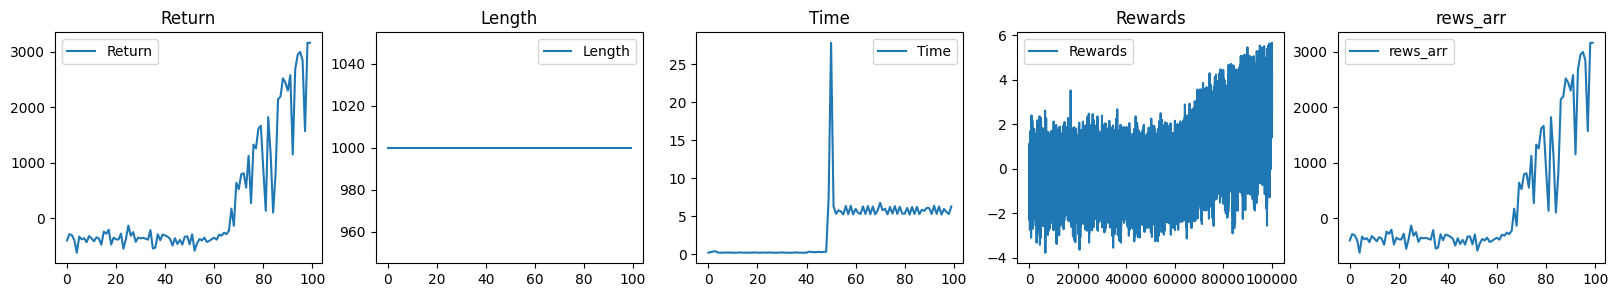

In [42]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 3))

ax1.plot(rs, label='Return')
ax1.legend()
ax1.set_title("Return")

ax2.plot(ls, label='Length')
ax2.legend()
ax2.set_title("Length")

ax3.plot(ts, label='Time')
ax3.legend()
ax3.set_title("Time")

ax4.plot(rewards, label='Rewards')
ax4.legend()
ax4.set_title("Rewards")

ax5.plot(rews_arr, label='rews_arr')
ax5.legend()
ax5.set_title("rews_arr")

plt.show()


In [ ]:
eval_env = gym.make("Hopper-v4", render_mode="rgb_array") #
eval_env = wrap_gym(eval_env, rescale_actions=True)
eval_env = gym.wrappers.RecordVideo(eval_env, 'Hopper-v4')
eval_env = gym.wrappers.RecordEpisodeStatistics(eval_env, buffer_length=1)
evaluate(agent, eval_env, num_episodes=1)
eval_env.close()

### Ant

In [44]:
env = gym.make("Ant-v5", render_mode=None)
env = wrap_gym(env, rescale_actions=True)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=1)

eval_env = gym.make("Ant-v5", render_mode=None) # "rgb_array"
eval_env = wrap_gym(eval_env, rescale_actions=True)
# eval_env = gym.wrappers.RecordVideo(eval_env, 'cartpole_video')
eval_env = gym.wrappers.RecordEpisodeStatistics(eval_env, buffer_length=1)

agent = ScoreMatchingLearner.create(42, env.observation_space, env.action_space)

replay_buffer = ReplayBuffer(env.observation_space, env.action_space, max_iter)

observation, _ = env.reset()
done = False

rs, ls, ts = [], [], []
rewards = []
rews = 0
rews_arr = []
pbar = trange(1, max_iter+1, desc='Training')
for i in pbar:
    if i < start_step:
        action = env.action_space.sample()
    else:
        action, agent = agent.sample_actions(observation)
        action = np.asarray(action)
    next_observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    rews += reward
    if not done or "TimeLimit.truncated" in info:
        mask = 1.0
    else:
        mask = 0.0

    replay_buffer.insert(
            dict(
                observations=observation,
                actions=action,
                rewards=reward,
                masks=mask,
                dones=done,
                next_observations=next_observation,
            )
        )
    observation = next_observation
    rewards.append(reward)
    if done:
        rews_arr.append(rews)
        rews = 0
        observation, _ = env.reset()
        done = False
        # print("Done Info:", info)
        pbar.set_postfix(info['episode'])
        rs.append(info['episode']['r'])
        ls.append(info['episode']['l'])
        ts.append(info['episode']['t'])

    if i >= start_step:
        batch = replay_buffer.sample(batch_size)
        agent, update_info = agent.update(batch)

        if i % print_interval == 0:
            print("Update Info:", update_info)
            print('rew_arrs : ', rews_arr[-1])


    if i % 100_000 == 0:
        eval_info = evaluate(agent, eval_env, num_episodes=num_episodes)
        print("Eval Info", eval_info)

eval_env.close()
env.close()

Training:  50%|█████     | 50000/100000 [00:57<38:56, 21.40it/s, r=-46.9, l=22, t=0.014]  

Update Info: {'actor_loss_mag': Array(0.9381207, dtype=float32), 'actor_loss_max': Array(0.9381207, dtype=float32), 'actor_loss_mean': Array(0.15425438, dtype=float32), 'actor_loss_min': Array(0.00443551, dtype=float32), 'actor_loss_std': Array(0.13724469, dtype=float32), 'c_loss_mag_1': Array(27.44105, dtype=float32), 'c_loss_mag_2': Array(22.934956, dtype=float32), 'c_loss_max_1': Array(27.44105, dtype=float32), 'c_loss_max_2': Array(22.934956, dtype=float32), 'c_loss_mean_1': Array(4.315012, dtype=float32), 'c_loss_mean_2': Array(2.4362595, dtype=float32), 'c_loss_min_1': Array(2.1982603e-05, dtype=float32), 'c_loss_min_2': Array(5.6286557e-05, dtype=float32), 'c_loss_std_1': Array(4.536606, dtype=float32), 'c_loss_std_2': Array(3.156749, dtype=float32), 'critic_jacobian_mag': Array(0.13301101, dtype=float32), 'critic_jacobian_max': Array(0.13301101, dtype=float32), 'critic_jacobian_mean': Array(0.00637549, dtype=float32), 'critic_jacobian_min': Array(-0.11969963, dtype=float32), 'c

Training:  51%|█████     | 51018/100000 [01:04<05:10, 157.55it/s, r=-11.3, l=11, t=0.0841]

Update Info: {'actor_loss_mag': Array(0.02030716, dtype=float32), 'actor_loss_max': Array(0.02030716, dtype=float32), 'actor_loss_mean': Array(0.0052224, dtype=float32), 'actor_loss_min': Array(0.0011254, dtype=float32), 'actor_loss_std': Array(0.00302047, dtype=float32), 'c_loss_mag_1': Array(66.92799, dtype=float32), 'c_loss_mag_2': Array(66.17446, dtype=float32), 'c_loss_max_1': Array(66.92799, dtype=float32), 'c_loss_max_2': Array(66.17446, dtype=float32), 'c_loss_mean_1': Array(2.3165305, dtype=float32), 'c_loss_mean_2': Array(2.3861024, dtype=float32), 'c_loss_min_1': Array(4.4095366e-05, dtype=float32), 'c_loss_min_2': Array(2.2332542e-06, dtype=float32), 'c_loss_std_1': Array(5.6325636, dtype=float32), 'c_loss_std_2': Array(5.690924, dtype=float32), 'critic_jacobian_mag': Array(0.80873936, dtype=float32), 'critic_jacobian_max': Array(0.80873936, dtype=float32), 'critic_jacobian_mean': Array(-0.00523512, dtype=float32), 'critic_jacobian_min': Array(-0.7439889, dtype=float32), 'c

Training:  52%|█████▏    | 52019/100000 [01:11<04:41, 170.22it/s, r=-25.2, l=12, t=0.0758]

Update Info: {'actor_loss_mag': Array(0.02279968, dtype=float32), 'actor_loss_max': Array(0.02279968, dtype=float32), 'actor_loss_mean': Array(0.00829156, dtype=float32), 'actor_loss_min': Array(0.00122816, dtype=float32), 'actor_loss_std': Array(0.00431445, dtype=float32), 'c_loss_mag_1': Array(140.85995, dtype=float32), 'c_loss_mag_2': Array(139.27065, dtype=float32), 'c_loss_max_1': Array(140.85995, dtype=float32), 'c_loss_max_2': Array(139.27065, dtype=float32), 'c_loss_mean_1': Array(3.8629355, dtype=float32), 'c_loss_mean_2': Array(3.8822885, dtype=float32), 'c_loss_min_1': Array(2.4164365e-08, dtype=float32), 'c_loss_min_2': Array(0.000141, dtype=float32), 'c_loss_std_1': Array(12.175929, dtype=float32), 'c_loss_std_2': Array(11.909685, dtype=float32), 'critic_jacobian_mag': Array(0.9899025, dtype=float32), 'critic_jacobian_max': Array(0.9899025, dtype=float32), 'critic_jacobian_mean': Array(0.0204681, dtype=float32), 'critic_jacobian_min': Array(-0.9793707, dtype=float32), 'cri

Training:  53%|█████▎    | 53030/100000 [01:17<04:44, 165.36it/s, r=-63.6, l=41, t=0.247]

Update Info: {'actor_loss_mag': Array(0.03057999, dtype=float32), 'actor_loss_max': Array(0.03057999, dtype=float32), 'actor_loss_mean': Array(0.01098871, dtype=float32), 'actor_loss_min': Array(0.00152456, dtype=float32), 'actor_loss_std': Array(0.00601392, dtype=float32), 'c_loss_mag_1': Array(102.40606, dtype=float32), 'c_loss_mag_2': Array(85.28149, dtype=float32), 'c_loss_max_1': Array(102.40606, dtype=float32), 'c_loss_max_2': Array(85.28149, dtype=float32), 'c_loss_mean_1': Array(4.8386908, dtype=float32), 'c_loss_mean_2': Array(4.983961, dtype=float32), 'c_loss_min_1': Array(0.00111719, dtype=float32), 'c_loss_min_2': Array(1.6501954e-06, dtype=float32), 'c_loss_std_1': Array(10.116226, dtype=float32), 'c_loss_std_2': Array(10.007527, dtype=float32), 'critic_jacobian_mag': Array(1.1215938, dtype=float32), 'critic_jacobian_max': Array(1.0641342, dtype=float32), 'critic_jacobian_mean': Array(0.01092771, dtype=float32), 'critic_jacobian_min': Array(-1.1215938, dtype=float32), 'cri

Training:  54%|█████▍    | 54029/100000 [01:24<04:39, 164.26it/s, r=-78.1, l=66, t=0.511]

Update Info: {'actor_loss_mag': Array(0.05831752, dtype=float32), 'actor_loss_max': Array(0.05831752, dtype=float32), 'actor_loss_mean': Array(0.01595849, dtype=float32), 'actor_loss_min': Array(0.00138451, dtype=float32), 'actor_loss_std': Array(0.00853712, dtype=float32), 'c_loss_mag_1': Array(126.436424, dtype=float32), 'c_loss_mag_2': Array(120.71693, dtype=float32), 'c_loss_max_1': Array(126.436424, dtype=float32), 'c_loss_max_2': Array(120.71693, dtype=float32), 'c_loss_mean_1': Array(5.7007055, dtype=float32), 'c_loss_mean_2': Array(5.8102517, dtype=float32), 'c_loss_min_1': Array(4.632672e-05, dtype=float32), 'c_loss_min_2': Array(1.3502003e-05, dtype=float32), 'c_loss_std_1': Array(12.183058, dtype=float32), 'c_loss_std_2': Array(12.713465, dtype=float32), 'critic_jacobian_mag': Array(1.2644432, dtype=float32), 'critic_jacobian_max': Array(1.2644432, dtype=float32), 'critic_jacobian_mean': Array(0.00153236, dtype=float32), 'critic_jacobian_min': Array(-1.1584594, dtype=float32

Training:  55%|█████▌    | 55022/100000 [01:30<04:32, 165.18it/s, r=-46.2, l=35, t=0.204]

Update Info: {'actor_loss_mag': Array(0.07557815, dtype=float32), 'actor_loss_max': Array(0.07557815, dtype=float32), 'actor_loss_mean': Array(0.02081017, dtype=float32), 'actor_loss_min': Array(0.0018979, dtype=float32), 'actor_loss_std': Array(0.01190852, dtype=float32), 'c_loss_mag_1': Array(179.48634, dtype=float32), 'c_loss_mag_2': Array(159.37993, dtype=float32), 'c_loss_max_1': Array(179.48634, dtype=float32), 'c_loss_max_2': Array(159.37993, dtype=float32), 'c_loss_mean_1': Array(5.076579, dtype=float32), 'c_loss_mean_2': Array(5.1887274, dtype=float32), 'c_loss_min_1': Array(1.1410306e-05, dtype=float32), 'c_loss_min_2': Array(0.00010955, dtype=float32), 'c_loss_std_1': Array(14.075175, dtype=float32), 'c_loss_std_2': Array(12.958733, dtype=float32), 'critic_jacobian_mag': Array(1.3333161, dtype=float32), 'critic_jacobian_max': Array(1.2553433, dtype=float32), 'critic_jacobian_mean': Array(0.00510817, dtype=float32), 'critic_jacobian_min': Array(-1.3333161, dtype=float32), 'cr

Training:  56%|█████▌    | 56023/100000 [01:37<04:34, 159.96it/s, r=-104, l=90, t=0.525]

Update Info: {'actor_loss_mag': Array(0.09575911, dtype=float32), 'actor_loss_max': Array(0.09575911, dtype=float32), 'actor_loss_mean': Array(0.02802232, dtype=float32), 'actor_loss_min': Array(0.00399449, dtype=float32), 'actor_loss_std': Array(0.01505844, dtype=float32), 'c_loss_mag_1': Array(214.37262, dtype=float32), 'c_loss_mag_2': Array(192.90121, dtype=float32), 'c_loss_max_1': Array(214.37262, dtype=float32), 'c_loss_max_2': Array(192.90121, dtype=float32), 'c_loss_mean_1': Array(6.781911, dtype=float32), 'c_loss_mean_2': Array(6.8792534, dtype=float32), 'c_loss_min_1': Array(2.9993826e-06, dtype=float32), 'c_loss_min_2': Array(4.335126e-05, dtype=float32), 'c_loss_std_1': Array(18.458769, dtype=float32), 'c_loss_std_2': Array(17.07112, dtype=float32), 'critic_jacobian_mag': Array(1.2604506, dtype=float32), 'critic_jacobian_max': Array(1.2604506, dtype=float32), 'critic_jacobian_mean': Array(0.01780365, dtype=float32), 'critic_jacobian_min': Array(-1.1307485, dtype=float32), '

Training:  57%|█████▋    | 57030/100000 [01:43<04:22, 163.96it/s, r=-15.4, l=23, t=0.149]

Update Info: {'actor_loss_mag': Array(0.16065335, dtype=float32), 'actor_loss_max': Array(0.16065335, dtype=float32), 'actor_loss_mean': Array(0.03581315, dtype=float32), 'actor_loss_min': Array(0.00714896, dtype=float32), 'actor_loss_std': Array(0.02005589, dtype=float32), 'c_loss_mag_1': Array(136.59738, dtype=float32), 'c_loss_mag_2': Array(153.8574, dtype=float32), 'c_loss_max_1': Array(136.59738, dtype=float32), 'c_loss_max_2': Array(153.8574, dtype=float32), 'c_loss_mean_1': Array(7.2844424, dtype=float32), 'c_loss_mean_2': Array(7.579875, dtype=float32), 'c_loss_min_1': Array(3.397558e-05, dtype=float32), 'c_loss_min_2': Array(3.2047043e-05, dtype=float32), 'c_loss_std_1': Array(16.481415, dtype=float32), 'c_loss_std_2': Array(19.145706, dtype=float32), 'critic_jacobian_mag': Array(1.1479086, dtype=float32), 'critic_jacobian_max': Array(1.1461959, dtype=float32), 'critic_jacobian_mean': Array(-0.02628899, dtype=float32), 'critic_jacobian_min': Array(-1.1479086, dtype=float32), '

Training:  58%|█████▊    | 58022/100000 [01:50<04:14, 164.93it/s, r=-29.1, l=23, t=0.149]

Update Info: {'actor_loss_mag': Array(0.1413487, dtype=float32), 'actor_loss_max': Array(0.1413487, dtype=float32), 'actor_loss_mean': Array(0.0387155, dtype=float32), 'actor_loss_min': Array(0.00382709, dtype=float32), 'actor_loss_std': Array(0.02113299, dtype=float32), 'c_loss_mag_1': Array(129.93861, dtype=float32), 'c_loss_mag_2': Array(129.54102, dtype=float32), 'c_loss_max_1': Array(129.93861, dtype=float32), 'c_loss_max_2': Array(129.54102, dtype=float32), 'c_loss_mean_1': Array(6.0838995, dtype=float32), 'c_loss_mean_2': Array(6.1762476, dtype=float32), 'c_loss_min_1': Array(4.2886422e-06, dtype=float32), 'c_loss_min_2': Array(7.651177e-05, dtype=float32), 'c_loss_std_1': Array(14.154735, dtype=float32), 'c_loss_std_2': Array(14.863339, dtype=float32), 'critic_jacobian_mag': Array(1.1934922, dtype=float32), 'critic_jacobian_max': Array(1.1465197, dtype=float32), 'critic_jacobian_mean': Array(-0.0138815, dtype=float32), 'critic_jacobian_min': Array(-1.1934922, dtype=float32), 'c

Training:  59%|█████▉    | 59027/100000 [01:56<04:19, 157.61it/s, r=-1.58e+3, l=1000, t=5.9]

Update Info: {'actor_loss_mag': Array(0.15471637, dtype=float32), 'actor_loss_max': Array(0.15471637, dtype=float32), 'actor_loss_mean': Array(0.05117523, dtype=float32), 'actor_loss_min': Array(0.00142289, dtype=float32), 'actor_loss_std': Array(0.02744777, dtype=float32), 'c_loss_mag_1': Array(460.00452, dtype=float32), 'c_loss_mag_2': Array(442.83, dtype=float32), 'c_loss_max_1': Array(460.00452, dtype=float32), 'c_loss_max_2': Array(442.83, dtype=float32), 'c_loss_mean_1': Array(10.552253, dtype=float32), 'c_loss_mean_2': Array(10.690193, dtype=float32), 'c_loss_min_1': Array(5.269293e-06, dtype=float32), 'c_loss_min_2': Array(1.168251e-05, dtype=float32), 'c_loss_std_1': Array(35.65582, dtype=float32), 'c_loss_std_2': Array(33.606453, dtype=float32), 'critic_jacobian_mag': Array(1.4693706, dtype=float32), 'critic_jacobian_max': Array(1.4693706, dtype=float32), 'critic_jacobian_mean': Array(-0.00287475, dtype=float32), 'critic_jacobian_min': Array(-1.4523784, dtype=float32), 'criti

Training:  60%|██████    | 60024/100000 [02:02<04:13, 157.87it/s, r=-18.7, l=18, t=0.152]

Update Info: {'actor_loss_mag': Array(0.23490532, dtype=float32), 'actor_loss_max': Array(0.23490532, dtype=float32), 'actor_loss_mean': Array(0.05761618, dtype=float32), 'actor_loss_min': Array(0.00981025, dtype=float32), 'actor_loss_std': Array(0.03630904, dtype=float32), 'c_loss_mag_1': Array(223.98462, dtype=float32), 'c_loss_mag_2': Array(251.2331, dtype=float32), 'c_loss_max_1': Array(223.98462, dtype=float32), 'c_loss_max_2': Array(251.2331, dtype=float32), 'c_loss_mean_1': Array(9.071993, dtype=float32), 'c_loss_mean_2': Array(10.523428, dtype=float32), 'c_loss_min_1': Array(0.00028616, dtype=float32), 'c_loss_min_2': Array(8.946401e-05, dtype=float32), 'c_loss_std_1': Array(25.18976, dtype=float32), 'c_loss_std_2': Array(30.622868, dtype=float32), 'critic_jacobian_mag': Array(1.5133705, dtype=float32), 'critic_jacobian_max': Array(1.5133705, dtype=float32), 'critic_jacobian_mean': Array(0.02067347, dtype=float32), 'critic_jacobian_min': Array(-1.4535295, dtype=float32), 'criti

Training:  61%|██████    | 61017/100000 [02:08<04:07, 157.66it/s, r=-16.8, l=18, t=0.104]

Update Info: {'actor_loss_mag': Array(0.28474188, dtype=float32), 'actor_loss_max': Array(0.28474188, dtype=float32), 'actor_loss_mean': Array(0.07035929, dtype=float32), 'actor_loss_min': Array(0.01208335, dtype=float32), 'actor_loss_std': Array(0.04143772, dtype=float32), 'c_loss_mag_1': Array(240.5981, dtype=float32), 'c_loss_mag_2': Array(174.45776, dtype=float32), 'c_loss_max_1': Array(240.5981, dtype=float32), 'c_loss_max_2': Array(174.45776, dtype=float32), 'c_loss_mean_1': Array(7.7379627, dtype=float32), 'c_loss_mean_2': Array(7.0005045, dtype=float32), 'c_loss_min_1': Array(1.3536919e-06, dtype=float32), 'c_loss_min_2': Array(0.00016078, dtype=float32), 'c_loss_std_1': Array(18.887028, dtype=float32), 'c_loss_std_2': Array(15.117818, dtype=float32), 'critic_jacobian_mag': Array(1.6650887, dtype=float32), 'critic_jacobian_max': Array(1.6631951, dtype=float32), 'critic_jacobian_mean': Array(0.02236502, dtype=float32), 'critic_jacobian_min': Array(-1.6650887, dtype=float32), 'cr

Training:  62%|██████▏   | 62017/100000 [02:15<03:48, 166.26it/s, r=-61.4, l=38, t=0.217]

Update Info: {'actor_loss_mag': Array(0.34914228, dtype=float32), 'actor_loss_max': Array(0.34914228, dtype=float32), 'actor_loss_mean': Array(0.07432023, dtype=float32), 'actor_loss_min': Array(0.01079488, dtype=float32), 'actor_loss_std': Array(0.04829792, dtype=float32), 'c_loss_mag_1': Array(96.33476, dtype=float32), 'c_loss_mag_2': Array(91.552734, dtype=float32), 'c_loss_max_1': Array(96.33476, dtype=float32), 'c_loss_max_2': Array(91.552734, dtype=float32), 'c_loss_mean_1': Array(6.339508, dtype=float32), 'c_loss_mean_2': Array(6.358979, dtype=float32), 'c_loss_min_1': Array(1.1085067e-06, dtype=float32), 'c_loss_min_2': Array(0.00041232, dtype=float32), 'c_loss_std_1': Array(11.168222, dtype=float32), 'c_loss_std_2': Array(11.798031, dtype=float32), 'critic_jacobian_mag': Array(1.5305932, dtype=float32), 'critic_jacobian_max': Array(1.5305932, dtype=float32), 'critic_jacobian_mean': Array(0.0248425, dtype=float32), 'critic_jacobian_min': Array(-1.3850293, dtype=float32), 'criti

Training:  63%|██████▎   | 63023/100000 [02:21<04:01, 153.21it/s, r=-49.4, l=22, t=0.133]

Update Info: {'actor_loss_mag': Array(0.31708208, dtype=float32), 'actor_loss_max': Array(0.31708208, dtype=float32), 'actor_loss_mean': Array(0.08531225, dtype=float32), 'actor_loss_min': Array(0.01887968, dtype=float32), 'actor_loss_std': Array(0.04551875, dtype=float32), 'c_loss_mag_1': Array(72.98603, dtype=float32), 'c_loss_mag_2': Array(96.36741, dtype=float32), 'c_loss_max_1': Array(72.98603, dtype=float32), 'c_loss_max_2': Array(96.36741, dtype=float32), 'c_loss_mean_1': Array(7.6400766, dtype=float32), 'c_loss_mean_2': Array(6.9757133, dtype=float32), 'c_loss_min_1': Array(8.518662e-05, dtype=float32), 'c_loss_min_2': Array(0.00031411, dtype=float32), 'c_loss_std_1': Array(11.950421, dtype=float32), 'c_loss_std_2': Array(12.000157, dtype=float32), 'critic_jacobian_mag': Array(2.069309, dtype=float32), 'critic_jacobian_max': Array(2.069309, dtype=float32), 'critic_jacobian_mean': Array(0.00552021, dtype=float32), 'critic_jacobian_min': Array(-1.5570387, dtype=float32), 'critic_

Training:  64%|██████▍   | 64024/100000 [02:29<03:49, 156.62it/s, r=-39.3, l=33, t=0.214]

Update Info: {'actor_loss_mag': Array(0.28863204, dtype=float32), 'actor_loss_max': Array(0.28863204, dtype=float32), 'actor_loss_mean': Array(0.09204412, dtype=float32), 'actor_loss_min': Array(0.01130067, dtype=float32), 'actor_loss_std': Array(0.05480807, dtype=float32), 'c_loss_mag_1': Array(227.2748, dtype=float32), 'c_loss_mag_2': Array(179.06914, dtype=float32), 'c_loss_max_1': Array(227.2748, dtype=float32), 'c_loss_max_2': Array(179.06914, dtype=float32), 'c_loss_mean_1': Array(9.672434, dtype=float32), 'c_loss_mean_2': Array(9.340651, dtype=float32), 'c_loss_min_1': Array(9.08185e-08, dtype=float32), 'c_loss_min_2': Array(1.9111263e-05, dtype=float32), 'c_loss_std_1': Array(23.756645, dtype=float32), 'c_loss_std_2': Array(22.123278, dtype=float32), 'critic_jacobian_mag': Array(1.6994565, dtype=float32), 'critic_jacobian_max': Array(1.644125, dtype=float32), 'critic_jacobian_mean': Array(0.0074384, dtype=float32), 'critic_jacobian_min': Array(-1.6994565, dtype=float32), 'criti

Training:  65%|██████▌   | 65014/100000 [02:35<03:47, 154.05it/s, r=-32.6, l=12, t=0.0908]

Update Info: {'actor_loss_mag': Array(0.3313793, dtype=float32), 'actor_loss_max': Array(0.3313793, dtype=float32), 'actor_loss_mean': Array(0.09974714, dtype=float32), 'actor_loss_min': Array(0.00823596, dtype=float32), 'actor_loss_std': Array(0.05818374, dtype=float32), 'c_loss_mag_1': Array(226.03894, dtype=float32), 'c_loss_mag_2': Array(277.31784, dtype=float32), 'c_loss_max_1': Array(226.03894, dtype=float32), 'c_loss_max_2': Array(277.31784, dtype=float32), 'c_loss_mean_1': Array(10.450127, dtype=float32), 'c_loss_mean_2': Array(10.327455, dtype=float32), 'c_loss_min_1': Array(0.00013493, dtype=float32), 'c_loss_min_2': Array(6.0262755e-07, dtype=float32), 'c_loss_std_1': Array(25.609285, dtype=float32), 'c_loss_std_2': Array(26.57271, dtype=float32), 'critic_jacobian_mag': Array(2.1239038, dtype=float32), 'critic_jacobian_max': Array(1.9614055, dtype=float32), 'critic_jacobian_mean': Array(-0.03940627, dtype=float32), 'critic_jacobian_min': Array(-2.1239038, dtype=float32), 'cr

Training:  66%|██████▌   | 66027/100000 [02:43<04:30, 125.59it/s, r=-52.7, l=30, t=0.275]

Update Info: {'actor_loss_mag': Array(0.34560812, dtype=float32), 'actor_loss_max': Array(0.34560812, dtype=float32), 'actor_loss_mean': Array(0.11683708, dtype=float32), 'actor_loss_min': Array(0.01201958, dtype=float32), 'actor_loss_std': Array(0.06931106, dtype=float32), 'c_loss_mag_1': Array(133.34119, dtype=float32), 'c_loss_mag_2': Array(89.040215, dtype=float32), 'c_loss_max_1': Array(133.34119, dtype=float32), 'c_loss_max_2': Array(89.040215, dtype=float32), 'c_loss_mean_1': Array(7.7234144, dtype=float32), 'c_loss_mean_2': Array(6.938431, dtype=float32), 'c_loss_min_1': Array(3.844558e-06, dtype=float32), 'c_loss_min_2': Array(1.0608346e-06, dtype=float32), 'c_loss_std_1': Array(14.80134, dtype=float32), 'c_loss_std_2': Array(12.1784115, dtype=float32), 'critic_jacobian_mag': Array(2.0592058, dtype=float32), 'critic_jacobian_max': Array(2.0592058, dtype=float32), 'critic_jacobian_mean': Array(-0.01234651, dtype=float32), 'critic_jacobian_min': Array(-1.8351893, dtype=float32),

Training:  67%|██████▋   | 67028/100000 [02:49<03:20, 164.82it/s, r=-17.2, l=13, t=0.0937]

Update Info: {'actor_loss_mag': Array(0.47504276, dtype=float32), 'actor_loss_max': Array(0.47504276, dtype=float32), 'actor_loss_mean': Array(0.11417693, dtype=float32), 'actor_loss_min': Array(0.01734098, dtype=float32), 'actor_loss_std': Array(0.07502954, dtype=float32), 'c_loss_mag_1': Array(496.14536, dtype=float32), 'c_loss_mag_2': Array(382.14117, dtype=float32), 'c_loss_max_1': Array(496.14536, dtype=float32), 'c_loss_max_2': Array(382.14117, dtype=float32), 'c_loss_mean_1': Array(11.216482, dtype=float32), 'c_loss_mean_2': Array(9.922754, dtype=float32), 'c_loss_min_1': Array(0.0002235, dtype=float32), 'c_loss_min_2': Array(1.0700114e-05, dtype=float32), 'c_loss_std_1': Array(35.041367, dtype=float32), 'c_loss_std_2': Array(29.220451, dtype=float32), 'critic_jacobian_mag': Array(2.048781, dtype=float32), 'critic_jacobian_max': Array(1.8399439, dtype=float32), 'critic_jacobian_mean': Array(0.01078787, dtype=float32), 'critic_jacobian_min': Array(-2.048781, dtype=float32), 'crit

Training:  68%|██████▊   | 68023/100000 [02:56<03:18, 161.46it/s, r=-41, l=38, t=0.253]

Update Info: {'actor_loss_mag': Array(0.60325444, dtype=float32), 'actor_loss_max': Array(0.60325444, dtype=float32), 'actor_loss_mean': Array(0.12530744, dtype=float32), 'actor_loss_min': Array(0.00564785, dtype=float32), 'actor_loss_std': Array(0.08190528, dtype=float32), 'c_loss_mag_1': Array(295.35666, dtype=float32), 'c_loss_mag_2': Array(207.97636, dtype=float32), 'c_loss_max_1': Array(295.35666, dtype=float32), 'c_loss_max_2': Array(207.97636, dtype=float32), 'c_loss_mean_1': Array(11.156984, dtype=float32), 'c_loss_mean_2': Array(10.4248705, dtype=float32), 'c_loss_min_1': Array(0.00065812, dtype=float32), 'c_loss_min_2': Array(8.458913e-05, dtype=float32), 'c_loss_std_1': Array(28.49143, dtype=float32), 'c_loss_std_2': Array(20.910713, dtype=float32), 'critic_jacobian_mag': Array(2.2841692, dtype=float32), 'critic_jacobian_max': Array(2.2260952, dtype=float32), 'critic_jacobian_mean': Array(0.02205135, dtype=float32), 'critic_jacobian_min': Array(-2.2841692, dtype=float32), 'c

Training:  69%|██████▉   | 69031/100000 [03:02<03:09, 163.56it/s, r=-117, l=52, t=0.322]

Update Info: {'actor_loss_mag': Array(0.454163, dtype=float32), 'actor_loss_max': Array(0.454163, dtype=float32), 'actor_loss_mean': Array(0.12174009, dtype=float32), 'actor_loss_min': Array(0.01886218, dtype=float32), 'actor_loss_std': Array(0.07508809, dtype=float32), 'c_loss_mag_1': Array(1958.8867, dtype=float32), 'c_loss_mag_2': Array(1878.6426, dtype=float32), 'c_loss_max_1': Array(1958.8867, dtype=float32), 'c_loss_max_2': Array(1878.6426, dtype=float32), 'c_loss_mean_1': Array(21.191174, dtype=float32), 'c_loss_mean_2': Array(21.30619, dtype=float32), 'c_loss_min_1': Array(6.1154424e-05, dtype=float32), 'c_loss_min_2': Array(9.523952e-06, dtype=float32), 'c_loss_std_1': Array(125.2473, dtype=float32), 'c_loss_std_2': Array(121.623985, dtype=float32), 'critic_jacobian_mag': Array(2.1554837, dtype=float32), 'critic_jacobian_max': Array(1.7260743, dtype=float32), 'critic_jacobian_mean': Array(-0.04423591, dtype=float32), 'critic_jacobian_min': Array(-2.1554837, dtype=float32), 'cr

Training:  70%|███████   | 70024/100000 [03:09<02:56, 169.68it/s, r=-18.4, l=14, t=0.0858]

Update Info: {'actor_loss_mag': Array(0.5437117, dtype=float32), 'actor_loss_max': Array(0.5437117, dtype=float32), 'actor_loss_mean': Array(0.14058541, dtype=float32), 'actor_loss_min': Array(0.01150098, dtype=float32), 'actor_loss_std': Array(0.09466535, dtype=float32), 'c_loss_mag_1': Array(275.7298, dtype=float32), 'c_loss_mag_2': Array(261.4771, dtype=float32), 'c_loss_max_1': Array(275.7298, dtype=float32), 'c_loss_max_2': Array(261.4771, dtype=float32), 'c_loss_mean_1': Array(12.176653, dtype=float32), 'c_loss_mean_2': Array(12.026093, dtype=float32), 'c_loss_min_1': Array(9.693847e-05, dtype=float32), 'c_loss_min_2': Array(9.68948e-06, dtype=float32), 'c_loss_std_1': Array(34.223907, dtype=float32), 'c_loss_std_2': Array(31.390125, dtype=float32), 'critic_jacobian_mag': Array(2.543601, dtype=float32), 'critic_jacobian_max': Array(2.543601, dtype=float32), 'critic_jacobian_mean': Array(-0.04820077, dtype=float32), 'critic_jacobian_min': Array(-2.2233417, dtype=float32), 'critic_

Training:  71%|███████   | 71029/100000 [03:15<02:57, 162.93it/s, r=-48.4, l=34, t=0.213]

Update Info: {'actor_loss_mag': Array(0.5931121, dtype=float32), 'actor_loss_max': Array(0.5931121, dtype=float32), 'actor_loss_mean': Array(0.15892036, dtype=float32), 'actor_loss_min': Array(0.02358542, dtype=float32), 'actor_loss_std': Array(0.10410949, dtype=float32), 'c_loss_mag_1': Array(445.27344, dtype=float32), 'c_loss_mag_2': Array(351.42096, dtype=float32), 'c_loss_max_1': Array(445.27344, dtype=float32), 'c_loss_max_2': Array(351.42096, dtype=float32), 'c_loss_mean_1': Array(11.652468, dtype=float32), 'c_loss_mean_2': Array(12.36771, dtype=float32), 'c_loss_min_1': Array(7.872988e-05, dtype=float32), 'c_loss_min_2': Array(0.0001321, dtype=float32), 'c_loss_std_1': Array(34.413147, dtype=float32), 'c_loss_std_2': Array(31.596416, dtype=float32), 'critic_jacobian_mag': Array(2.3901672, dtype=float32), 'critic_jacobian_max': Array(2.2757246, dtype=float32), 'critic_jacobian_mean': Array(4.1370746e-05, dtype=float32), 'critic_jacobian_min': Array(-2.3901672, dtype=float32), 'cr

Training:  72%|███████▏  | 72023/100000 [03:22<02:45, 168.87it/s, r=-88.1, l=38, t=0.343]

Update Info: {'actor_loss_mag': Array(0.6419673, dtype=float32), 'actor_loss_max': Array(0.6419673, dtype=float32), 'actor_loss_mean': Array(0.14993219, dtype=float32), 'actor_loss_min': Array(0.01482943, dtype=float32), 'actor_loss_std': Array(0.09470652, dtype=float32), 'c_loss_mag_1': Array(580.3789, dtype=float32), 'c_loss_mag_2': Array(555.108, dtype=float32), 'c_loss_max_1': Array(580.3789, dtype=float32), 'c_loss_max_2': Array(555.108, dtype=float32), 'c_loss_mean_1': Array(13.7122135, dtype=float32), 'c_loss_mean_2': Array(12.228704, dtype=float32), 'c_loss_min_1': Array(0.00018546, dtype=float32), 'c_loss_min_2': Array(0.00099886, dtype=float32), 'c_loss_std_1': Array(44.32233, dtype=float32), 'c_loss_std_2': Array(40.5501, dtype=float32), 'critic_jacobian_mag': Array(3.2839153, dtype=float32), 'critic_jacobian_max': Array(3.2839153, dtype=float32), 'critic_jacobian_mean': Array(-0.00970761, dtype=float32), 'critic_jacobian_min': Array(-1.981525, dtype=float32), 'critic_jacobi

Training:  73%|███████▎  | 73031/100000 [03:28<02:44, 163.71it/s, r=-51.4, l=39, t=0.25]

Update Info: {'actor_loss_mag': Array(0.745746, dtype=float32), 'actor_loss_max': Array(0.745746, dtype=float32), 'actor_loss_mean': Array(0.15210624, dtype=float32), 'actor_loss_min': Array(0.00979376, dtype=float32), 'actor_loss_std': Array(0.10327872, dtype=float32), 'c_loss_mag_1': Array(108.572784, dtype=float32), 'c_loss_mag_2': Array(132.4596, dtype=float32), 'c_loss_max_1': Array(108.572784, dtype=float32), 'c_loss_max_2': Array(132.4596, dtype=float32), 'c_loss_mean_1': Array(11.775232, dtype=float32), 'c_loss_mean_2': Array(10.878897, dtype=float32), 'c_loss_min_1': Array(3.370928e-05, dtype=float32), 'c_loss_min_2': Array(1.4623074e-06, dtype=float32), 'c_loss_std_1': Array(18.39259, dtype=float32), 'c_loss_std_2': Array(19.654667, dtype=float32), 'critic_jacobian_mag': Array(2.2913804, dtype=float32), 'critic_jacobian_max': Array(1.8518875, dtype=float32), 'critic_jacobian_mean': Array(0.00712253, dtype=float32), 'critic_jacobian_min': Array(-2.2913804, dtype=float32), 'cri

Training:  74%|███████▍  | 74019/100000 [03:35<02:48, 154.57it/s, r=-11.8, l=8, t=0.0583]

Update Info: {'actor_loss_mag': Array(0.71236706, dtype=float32), 'actor_loss_max': Array(0.71236706, dtype=float32), 'actor_loss_mean': Array(0.18195346, dtype=float32), 'actor_loss_min': Array(0.01474981, dtype=float32), 'actor_loss_std': Array(0.12293784, dtype=float32), 'c_loss_mag_1': Array(697.4481, dtype=float32), 'c_loss_mag_2': Array(687.03503, dtype=float32), 'c_loss_max_1': Array(697.4481, dtype=float32), 'c_loss_max_2': Array(687.03503, dtype=float32), 'c_loss_mean_1': Array(22.380003, dtype=float32), 'c_loss_mean_2': Array(20.185242, dtype=float32), 'c_loss_min_1': Array(0.00073687, dtype=float32), 'c_loss_min_2': Array(5.774293e-05, dtype=float32), 'c_loss_std_1': Array(71.17041, dtype=float32), 'c_loss_std_2': Array(66.86851, dtype=float32), 'critic_jacobian_mag': Array(3.121263, dtype=float32), 'critic_jacobian_max': Array(3.121263, dtype=float32), 'critic_jacobian_mean': Array(0.00596689, dtype=float32), 'critic_jacobian_min': Array(-2.1514, dtype=float32), 'critic_jac

Training:  75%|███████▌  | 75017/100000 [03:41<02:41, 154.29it/s, r=-37.2, l=21, t=0.153]

Update Info: {'actor_loss_mag': Array(0.60211945, dtype=float32), 'actor_loss_max': Array(0.60211945, dtype=float32), 'actor_loss_mean': Array(0.17656991, dtype=float32), 'actor_loss_min': Array(0.02472179, dtype=float32), 'actor_loss_std': Array(0.11176177, dtype=float32), 'c_loss_mag_1': Array(287.36932, dtype=float32), 'c_loss_mag_2': Array(226.67319, dtype=float32), 'c_loss_max_1': Array(287.36932, dtype=float32), 'c_loss_max_2': Array(226.67319, dtype=float32), 'c_loss_mean_1': Array(14.144014, dtype=float32), 'c_loss_mean_2': Array(11.135448, dtype=float32), 'c_loss_min_1': Array(7.839932e-06, dtype=float32), 'c_loss_min_2': Array(2.1305459e-05, dtype=float32), 'c_loss_std_1': Array(33.7699, dtype=float32), 'c_loss_std_2': Array(23.580914, dtype=float32), 'critic_jacobian_mag': Array(2.61244, dtype=float32), 'critic_jacobian_max': Array(2.61244, dtype=float32), 'critic_jacobian_mean': Array(-0.00108806, dtype=float32), 'critic_jacobian_min': Array(-2.0762517, dtype=float32), 'cri

Training:  76%|███████▌  | 76023/100000 [03:48<02:35, 153.99it/s, r=-3.82, l=15, t=0.107]

Update Info: {'actor_loss_mag': Array(0.7649697, dtype=float32), 'actor_loss_max': Array(0.7649697, dtype=float32), 'actor_loss_mean': Array(0.19502702, dtype=float32), 'actor_loss_min': Array(0.02145619, dtype=float32), 'actor_loss_std': Array(0.13163957, dtype=float32), 'c_loss_mag_1': Array(4213.9077, dtype=float32), 'c_loss_mag_2': Array(3806.488, dtype=float32), 'c_loss_max_1': Array(4213.9077, dtype=float32), 'c_loss_max_2': Array(3806.488, dtype=float32), 'c_loss_mean_1': Array(30.243866, dtype=float32), 'c_loss_mean_2': Array(28.514277, dtype=float32), 'c_loss_min_1': Array(0.00120504, dtype=float32), 'c_loss_min_2': Array(0.00234172, dtype=float32), 'c_loss_std_1': Array(264.33267, dtype=float32), 'c_loss_std_2': Array(240.26137, dtype=float32), 'critic_jacobian_mag': Array(2.9775527, dtype=float32), 'critic_jacobian_max': Array(2.3881073, dtype=float32), 'critic_jacobian_mean': Array(0.06837068, dtype=float32), 'critic_jacobian_min': Array(-2.9775527, dtype=float32), 'critic_

Training:  77%|███████▋  | 77020/100000 [03:54<02:21, 162.55it/s, r=-52.1, l=30, t=0.183]

Update Info: {'actor_loss_mag': Array(0.60848504, dtype=float32), 'actor_loss_max': Array(0.60848504, dtype=float32), 'actor_loss_mean': Array(0.18821073, dtype=float32), 'actor_loss_min': Array(0.02014779, dtype=float32), 'actor_loss_std': Array(0.12690583, dtype=float32), 'c_loss_mag_1': Array(322.7101, dtype=float32), 'c_loss_mag_2': Array(379.4876, dtype=float32), 'c_loss_max_1': Array(322.7101, dtype=float32), 'c_loss_max_2': Array(379.4876, dtype=float32), 'c_loss_mean_1': Array(16.018717, dtype=float32), 'c_loss_mean_2': Array(15.55687, dtype=float32), 'c_loss_min_1': Array(6.4545893e-06, dtype=float32), 'c_loss_min_2': Array(0.00019323, dtype=float32), 'c_loss_std_1': Array(36.62239, dtype=float32), 'c_loss_std_2': Array(36.954514, dtype=float32), 'critic_jacobian_mag': Array(2.690699, dtype=float32), 'critic_jacobian_max': Array(2.690699, dtype=float32), 'critic_jacobian_mean': Array(0.00346397, dtype=float32), 'critic_jacobian_min': Array(-2.6054974, dtype=float32), 'critic_j

Training:  78%|███████▊  | 78019/100000 [04:01<02:12, 165.51it/s, r=-17.5, l=12, t=0.0745]

Update Info: {'actor_loss_mag': Array(2.924311, dtype=float32), 'actor_loss_max': Array(2.924311, dtype=float32), 'actor_loss_mean': Array(0.21448636, dtype=float32), 'actor_loss_min': Array(0.03678124, dtype=float32), 'actor_loss_std': Array(0.23391393, dtype=float32), 'c_loss_mag_1': Array(299.69836, dtype=float32), 'c_loss_mag_2': Array(438.79034, dtype=float32), 'c_loss_max_1': Array(299.69836, dtype=float32), 'c_loss_max_2': Array(438.79034, dtype=float32), 'c_loss_mean_1': Array(19.225174, dtype=float32), 'c_loss_mean_2': Array(17.836052, dtype=float32), 'c_loss_min_1': Array(0.00018404, dtype=float32), 'c_loss_min_2': Array(5.629903e-06, dtype=float32), 'c_loss_std_1': Array(39.31695, dtype=float32), 'c_loss_std_2': Array(44.54494, dtype=float32), 'critic_jacobian_mag': Array(6.725896, dtype=float32), 'critic_jacobian_max': Array(2.349886, dtype=float32), 'critic_jacobian_mean': Array(-0.02443508, dtype=float32), 'critic_jacobian_min': Array(-6.725896, dtype=float32), 'critic_ja

Training:  79%|███████▉  | 79029/100000 [04:07<02:02, 170.74it/s, r=-13.4, l=19, t=0.108]

Update Info: {'actor_loss_mag': Array(0.7108715, dtype=float32), 'actor_loss_max': Array(0.7108715, dtype=float32), 'actor_loss_mean': Array(0.20621945, dtype=float32), 'actor_loss_min': Array(0.01571663, dtype=float32), 'actor_loss_std': Array(0.13257134, dtype=float32), 'c_loss_mag_1': Array(966.2852, dtype=float32), 'c_loss_mag_2': Array(1036.389, dtype=float32), 'c_loss_max_1': Array(966.2852, dtype=float32), 'c_loss_max_2': Array(1036.389, dtype=float32), 'c_loss_mean_1': Array(17.053482, dtype=float32), 'c_loss_mean_2': Array(17.575836, dtype=float32), 'c_loss_min_1': Array(3.3318393e-06, dtype=float32), 'c_loss_min_2': Array(5.71358e-05, dtype=float32), 'c_loss_std_1': Array(66.49273, dtype=float32), 'c_loss_std_2': Array(73.50602, dtype=float32), 'critic_jacobian_mag': Array(2.7105944, dtype=float32), 'critic_jacobian_max': Array(2.6780252, dtype=float32), 'critic_jacobian_mean': Array(-0.02030361, dtype=float32), 'critic_jacobian_min': Array(-2.7105944, dtype=float32), 'critic

Training:  80%|████████  | 80026/100000 [04:14<02:03, 161.45it/s, r=-61.6, l=35, t=0.236]

Update Info: {'actor_loss_mag': Array(1.5379746, dtype=float32), 'actor_loss_max': Array(1.5379746, dtype=float32), 'actor_loss_mean': Array(0.21414593, dtype=float32), 'actor_loss_min': Array(0.02721932, dtype=float32), 'actor_loss_std': Array(0.1829432, dtype=float32), 'c_loss_mag_1': Array(3111.3337, dtype=float32), 'c_loss_mag_2': Array(2675.4417, dtype=float32), 'c_loss_max_1': Array(3111.3337, dtype=float32), 'c_loss_max_2': Array(2675.4417, dtype=float32), 'c_loss_mean_1': Array(24.892963, dtype=float32), 'c_loss_mean_2': Array(22.039288, dtype=float32), 'c_loss_min_1': Array(0.00021079, dtype=float32), 'c_loss_min_2': Array(9.4883755e-05, dtype=float32), 'c_loss_std_1': Array(194.87111, dtype=float32), 'c_loss_std_2': Array(167.73827, dtype=float32), 'critic_jacobian_mag': Array(3.7150393, dtype=float32), 'critic_jacobian_max': Array(2.5581622, dtype=float32), 'critic_jacobian_mean': Array(-0.00799279, dtype=float32), 'critic_jacobian_min': Array(-3.7150393, dtype=float32), 'cr

Training:  81%|████████  | 81023/100000 [04:20<02:10, 145.16it/s, r=-6.29, l=9, t=0.0562]

Update Info: {'actor_loss_mag': Array(1.0358872, dtype=float32), 'actor_loss_max': Array(1.0358872, dtype=float32), 'actor_loss_mean': Array(0.203315, dtype=float32), 'actor_loss_min': Array(0.01842564, dtype=float32), 'actor_loss_std': Array(0.15774183, dtype=float32), 'c_loss_mag_1': Array(471.108, dtype=float32), 'c_loss_mag_2': Array(631.28516, dtype=float32), 'c_loss_max_1': Array(471.108, dtype=float32), 'c_loss_max_2': Array(631.28516, dtype=float32), 'c_loss_mean_1': Array(13.224921, dtype=float32), 'c_loss_mean_2': Array(13.253852, dtype=float32), 'c_loss_min_1': Array(0.00030525, dtype=float32), 'c_loss_min_2': Array(3.2971147e-06, dtype=float32), 'c_loss_std_1': Array(36.435013, dtype=float32), 'c_loss_std_2': Array(41.82415, dtype=float32), 'critic_jacobian_mag': Array(2.8904233, dtype=float32), 'critic_jacobian_max': Array(2.8052988, dtype=float32), 'critic_jacobian_mean': Array(0.01530895, dtype=float32), 'critic_jacobian_min': Array(-2.8904233, dtype=float32), 'critic_ja

Training:  82%|████████▏ | 82018/100000 [04:28<02:01, 147.54it/s, r=-46.9, l=17, t=0.136]

Update Info: {'actor_loss_mag': Array(0.97331196, dtype=float32), 'actor_loss_max': Array(0.97331196, dtype=float32), 'actor_loss_mean': Array(0.21513323, dtype=float32), 'actor_loss_min': Array(0.01403493, dtype=float32), 'actor_loss_std': Array(0.1602056, dtype=float32), 'c_loss_mag_1': Array(176.28796, dtype=float32), 'c_loss_mag_2': Array(176.53111, dtype=float32), 'c_loss_max_1': Array(176.28796, dtype=float32), 'c_loss_max_2': Array(176.53111, dtype=float32), 'c_loss_mean_1': Array(14.245295, dtype=float32), 'c_loss_mean_2': Array(16.021902, dtype=float32), 'c_loss_min_1': Array(9.547512e-06, dtype=float32), 'c_loss_min_2': Array(0.00253092, dtype=float32), 'c_loss_std_1': Array(25.531233, dtype=float32), 'c_loss_std_2': Array(27.656994, dtype=float32), 'critic_jacobian_mag': Array(2.8225012, dtype=float32), 'critic_jacobian_max': Array(2.8225012, dtype=float32), 'critic_jacobian_mean': Array(-0.01770823, dtype=float32), 'critic_jacobian_min': Array(-2.766529, dtype=float32), 'cr

Training:  83%|████████▎ | 83013/100000 [04:34<01:55, 147.24it/s, r=-51.2, l=22, t=0.169]

Update Info: {'actor_loss_mag': Array(0.94800943, dtype=float32), 'actor_loss_max': Array(0.94800943, dtype=float32), 'actor_loss_mean': Array(0.22485478, dtype=float32), 'actor_loss_min': Array(0.02695432, dtype=float32), 'actor_loss_std': Array(0.16020773, dtype=float32), 'c_loss_mag_1': Array(244.17151, dtype=float32), 'c_loss_mag_2': Array(386.90253, dtype=float32), 'c_loss_max_1': Array(244.17151, dtype=float32), 'c_loss_max_2': Array(386.90253, dtype=float32), 'c_loss_mean_1': Array(13.929525, dtype=float32), 'c_loss_mean_2': Array(13.447501, dtype=float32), 'c_loss_min_1': Array(4.4019544e-08, dtype=float32), 'c_loss_min_2': Array(4.17587e-05, dtype=float32), 'c_loss_std_1': Array(30.248083, dtype=float32), 'c_loss_std_2': Array(32.53629, dtype=float32), 'critic_jacobian_mag': Array(2.8684897, dtype=float32), 'critic_jacobian_max': Array(2.8684897, dtype=float32), 'critic_jacobian_mean': Array(0.01283679, dtype=float32), 'critic_jacobian_min': Array(-2.8364806, dtype=float32), '

Training:  84%|████████▍ | 84018/100000 [04:41<01:43, 154.53it/s, r=-25.8, l=10, t=0.0714]

Update Info: {'actor_loss_mag': Array(0.8449471, dtype=float32), 'actor_loss_max': Array(0.8449471, dtype=float32), 'actor_loss_mean': Array(0.23047936, dtype=float32), 'actor_loss_min': Array(0.02068464, dtype=float32), 'actor_loss_std': Array(0.15857135, dtype=float32), 'c_loss_mag_1': Array(6753.2954, dtype=float32), 'c_loss_mag_2': Array(6631.62, dtype=float32), 'c_loss_max_1': Array(6753.2954, dtype=float32), 'c_loss_max_2': Array(6631.62, dtype=float32), 'c_loss_mean_1': Array(43.163696, dtype=float32), 'c_loss_mean_2': Array(41.661556, dtype=float32), 'c_loss_min_1': Array(5.476759e-07, dtype=float32), 'c_loss_min_2': Array(1.1778357e-06, dtype=float32), 'c_loss_std_1': Array(422.044, dtype=float32), 'c_loss_std_2': Array(414.10495, dtype=float32), 'critic_jacobian_mag': Array(3.4553614, dtype=float32), 'critic_jacobian_max': Array(3.4553614, dtype=float32), 'critic_jacobian_mean': Array(0.0242708, dtype=float32), 'critic_jacobian_min': Array(-2.402763, dtype=float32), 'critic_j

Training:  85%|████████▌ | 85017/100000 [04:47<01:38, 151.65it/s, r=-25.2, l=37, t=0.262]

Update Info: {'actor_loss_mag': Array(0.94479835, dtype=float32), 'actor_loss_max': Array(0.94479835, dtype=float32), 'actor_loss_mean': Array(0.23522455, dtype=float32), 'actor_loss_min': Array(0.02526185, dtype=float32), 'actor_loss_std': Array(0.17400491, dtype=float32), 'c_loss_mag_1': Array(371.27426, dtype=float32), 'c_loss_mag_2': Array(261.73157, dtype=float32), 'c_loss_max_1': Array(371.27426, dtype=float32), 'c_loss_max_2': Array(261.73157, dtype=float32), 'c_loss_mean_1': Array(17.319164, dtype=float32), 'c_loss_mean_2': Array(18.40395, dtype=float32), 'c_loss_min_1': Array(0.00023237, dtype=float32), 'c_loss_min_2': Array(0.00061331, dtype=float32), 'c_loss_std_1': Array(39.93683, dtype=float32), 'c_loss_std_2': Array(33.315174, dtype=float32), 'critic_jacobian_mag': Array(2.367567, dtype=float32), 'critic_jacobian_max': Array(2.367567, dtype=float32), 'critic_jacobian_mean': Array(-0.0171298, dtype=float32), 'critic_jacobian_min': Array(-2.2877002, dtype=float32), 'critic_

Training:  86%|████████▌ | 86016/100000 [04:55<01:31, 152.44it/s, r=-45.7, l=22, t=0.139]

Update Info: {'actor_loss_mag': Array(0.9410978, dtype=float32), 'actor_loss_max': Array(0.9410978, dtype=float32), 'actor_loss_mean': Array(0.21035317, dtype=float32), 'actor_loss_min': Array(0.01477335, dtype=float32), 'actor_loss_std': Array(0.14894634, dtype=float32), 'c_loss_mag_1': Array(204.60387, dtype=float32), 'c_loss_mag_2': Array(223.29564, dtype=float32), 'c_loss_max_1': Array(204.60387, dtype=float32), 'c_loss_max_2': Array(223.29564, dtype=float32), 'c_loss_mean_1': Array(14.985449, dtype=float32), 'c_loss_mean_2': Array(14.558138, dtype=float32), 'c_loss_min_1': Array(1.4610181e-05, dtype=float32), 'c_loss_min_2': Array(0.00187065, dtype=float32), 'c_loss_std_1': Array(29.219076, dtype=float32), 'c_loss_std_2': Array(28.844893, dtype=float32), 'critic_jacobian_mag': Array(2.6499233, dtype=float32), 'critic_jacobian_max': Array(2.3448303, dtype=float32), 'critic_jacobian_mean': Array(-0.02907667, dtype=float32), 'critic_jacobian_min': Array(-2.6499233, dtype=float32), 'c

Training:  87%|████████▋ | 87017/100000 [05:01<01:23, 156.13it/s, r=-128, l=45, t=0.292]  

Update Info: {'actor_loss_mag': Array(1.2300142, dtype=float32), 'actor_loss_max': Array(1.2300142, dtype=float32), 'actor_loss_mean': Array(0.21534362, dtype=float32), 'actor_loss_min': Array(0.01910726, dtype=float32), 'actor_loss_std': Array(0.17140853, dtype=float32), 'c_loss_mag_1': Array(1558.9617, dtype=float32), 'c_loss_mag_2': Array(1374.916, dtype=float32), 'c_loss_max_1': Array(1558.9617, dtype=float32), 'c_loss_max_2': Array(1374.916, dtype=float32), 'c_loss_mean_1': Array(20.276375, dtype=float32), 'c_loss_mean_2': Array(18.728485, dtype=float32), 'c_loss_min_1': Array(4.456524e-07, dtype=float32), 'c_loss_min_2': Array(0.00033695, dtype=float32), 'c_loss_std_1': Array(102.64473, dtype=float32), 'c_loss_std_2': Array(88.51861, dtype=float32), 'critic_jacobian_mag': Array(2.5907598, dtype=float32), 'critic_jacobian_max': Array(2.5628514, dtype=float32), 'critic_jacobian_mean': Array(-0.00026895, dtype=float32), 'critic_jacobian_min': Array(-2.5907598, dtype=float32), 'criti

Training:  88%|████████▊ | 88014/100000 [05:08<01:17, 155.28it/s, r=-17.8, l=9, t=0.0578]

Update Info: {'actor_loss_mag': Array(1.1458987, dtype=float32), 'actor_loss_max': Array(1.1458987, dtype=float32), 'actor_loss_mean': Array(0.22953317, dtype=float32), 'actor_loss_min': Array(0.02398427, dtype=float32), 'actor_loss_std': Array(0.18834662, dtype=float32), 'c_loss_mag_1': Array(3137.3247, dtype=float32), 'c_loss_mag_2': Array(2825.9695, dtype=float32), 'c_loss_max_1': Array(3137.3247, dtype=float32), 'c_loss_max_2': Array(2825.9695, dtype=float32), 'c_loss_mean_1': Array(26.803947, dtype=float32), 'c_loss_mean_2': Array(25.755356, dtype=float32), 'c_loss_min_1': Array(0.00063657, dtype=float32), 'c_loss_min_2': Array(2.543215e-05, dtype=float32), 'c_loss_std_1': Array(197.24246, dtype=float32), 'c_loss_std_2': Array(177.56583, dtype=float32), 'critic_jacobian_mag': Array(4.3588753, dtype=float32), 'critic_jacobian_max': Array(4.3588753, dtype=float32), 'critic_jacobian_mean': Array(0.01003231, dtype=float32), 'critic_jacobian_min': Array(-3.3727415, dtype=float32), 'cri

Training:  89%|████████▉ | 89019/100000 [05:14<01:28, 123.70it/s, r=-42.9, l=29, t=0.178]

Update Info: {'actor_loss_mag': Array(1.9926732, dtype=float32), 'actor_loss_max': Array(1.9926732, dtype=float32), 'actor_loss_mean': Array(0.23881084, dtype=float32), 'actor_loss_min': Array(0.01139526, dtype=float32), 'actor_loss_std': Array(0.2006871, dtype=float32), 'c_loss_mag_1': Array(5882.884, dtype=float32), 'c_loss_mag_2': Array(6590.907, dtype=float32), 'c_loss_max_1': Array(5882.884, dtype=float32), 'c_loss_max_2': Array(6590.907, dtype=float32), 'c_loss_mean_1': Array(49.51634, dtype=float32), 'c_loss_mean_2': Array(50.676445, dtype=float32), 'c_loss_min_1': Array(0.00012582, dtype=float32), 'c_loss_min_2': Array(0.000196, dtype=float32), 'c_loss_std_1': Array(403.2162, dtype=float32), 'c_loss_std_2': Array(432.5769, dtype=float32), 'critic_jacobian_mag': Array(3.5070302, dtype=float32), 'critic_jacobian_max': Array(2.4733455, dtype=float32), 'critic_jacobian_mean': Array(0.03214882, dtype=float32), 'critic_jacobian_min': Array(-3.5070302, dtype=float32), 'critic_jacobian

Training:  90%|█████████ | 90016/100000 [05:21<01:02, 160.26it/s, r=-92.4, l=29, t=0.169]

Update Info: {'actor_loss_mag': Array(0.9414022, dtype=float32), 'actor_loss_max': Array(0.9414022, dtype=float32), 'actor_loss_mean': Array(0.2312786, dtype=float32), 'actor_loss_min': Array(0.01999727, dtype=float32), 'actor_loss_std': Array(0.1580969, dtype=float32), 'c_loss_mag_1': Array(2187.9272, dtype=float32), 'c_loss_mag_2': Array(1722.1646, dtype=float32), 'c_loss_max_1': Array(2187.9272, dtype=float32), 'c_loss_max_2': Array(1722.1646, dtype=float32), 'c_loss_mean_1': Array(24.618988, dtype=float32), 'c_loss_mean_2': Array(23.394712, dtype=float32), 'c_loss_min_1': Array(4.612506e-06, dtype=float32), 'c_loss_min_2': Array(0.00016576, dtype=float32), 'c_loss_std_1': Array(140.00853, dtype=float32), 'c_loss_std_2': Array(112.3878, dtype=float32), 'critic_jacobian_mag': Array(2.885558, dtype=float32), 'critic_jacobian_max': Array(2.885558, dtype=float32), 'critic_jacobian_mean': Array(0.02805096, dtype=float32), 'critic_jacobian_min': Array(-2.4289124, dtype=float32), 'critic_j

Training:  91%|█████████ | 91011/100000 [05:28<01:01, 145.76it/s, r=-22.8, l=12, t=0.105]

Update Info: {'actor_loss_mag': Array(1.636151, dtype=float32), 'actor_loss_max': Array(1.636151, dtype=float32), 'actor_loss_mean': Array(0.2408292, dtype=float32), 'actor_loss_min': Array(0.01270352, dtype=float32), 'actor_loss_std': Array(0.186236, dtype=float32), 'c_loss_mag_1': Array(534.11584, dtype=float32), 'c_loss_mag_2': Array(429.41867, dtype=float32), 'c_loss_max_1': Array(534.11584, dtype=float32), 'c_loss_max_2': Array(429.41867, dtype=float32), 'c_loss_mean_1': Array(18.441793, dtype=float32), 'c_loss_mean_2': Array(17.74832, dtype=float32), 'c_loss_min_1': Array(7.6111886e-05, dtype=float32), 'c_loss_min_2': Array(0.00033054, dtype=float32), 'c_loss_std_1': Array(55.32408, dtype=float32), 'c_loss_std_2': Array(40.140976, dtype=float32), 'critic_jacobian_mag': Array(3.099562, dtype=float32), 'critic_jacobian_max': Array(2.8442645, dtype=float32), 'critic_jacobian_mean': Array(0.02588499, dtype=float32), 'critic_jacobian_min': Array(-3.099562, dtype=float32), 'critic_jaco

Training:  92%|█████████▏| 92017/100000 [05:35<00:52, 152.24it/s, r=-22.4, l=11, t=0.094]

Update Info: {'actor_loss_mag': Array(1.2104901, dtype=float32), 'actor_loss_max': Array(1.2104901, dtype=float32), 'actor_loss_mean': Array(0.23970659, dtype=float32), 'actor_loss_min': Array(0.0179206, dtype=float32), 'actor_loss_std': Array(0.172296, dtype=float32), 'c_loss_mag_1': Array(720.39136, dtype=float32), 'c_loss_mag_2': Array(629.5349, dtype=float32), 'c_loss_max_1': Array(720.39136, dtype=float32), 'c_loss_max_2': Array(629.5349, dtype=float32), 'c_loss_mean_1': Array(18.425, dtype=float32), 'c_loss_mean_2': Array(19.122017, dtype=float32), 'c_loss_min_1': Array(8.536276e-05, dtype=float32), 'c_loss_min_2': Array(0.0001777, dtype=float32), 'c_loss_std_1': Array(53.582474, dtype=float32), 'c_loss_std_2': Array(49.689148, dtype=float32), 'critic_jacobian_mag': Array(2.8881516, dtype=float32), 'critic_jacobian_max': Array(2.8881516, dtype=float32), 'critic_jacobian_mean': Array(-0.0151164, dtype=float32), 'critic_jacobian_min': Array(-2.7770374, dtype=float32), 'critic_jacob

Training:  93%|█████████▎| 93015/100000 [05:41<00:56, 123.68it/s, r=-30.9, l=14, t=0.131]

Update Info: {'actor_loss_mag': Array(1.3096929, dtype=float32), 'actor_loss_max': Array(1.3096929, dtype=float32), 'actor_loss_mean': Array(0.25902504, dtype=float32), 'actor_loss_min': Array(0.03489741, dtype=float32), 'actor_loss_std': Array(0.18043487, dtype=float32), 'c_loss_mag_1': Array(1449.8405, dtype=float32), 'c_loss_mag_2': Array(1581.7073, dtype=float32), 'c_loss_max_1': Array(1449.8405, dtype=float32), 'c_loss_max_2': Array(1581.7073, dtype=float32), 'c_loss_mean_1': Array(22.999817, dtype=float32), 'c_loss_mean_2': Array(24.159021, dtype=float32), 'c_loss_min_1': Array(0.00028635, dtype=float32), 'c_loss_min_2': Array(6.929935e-05, dtype=float32), 'c_loss_std_1': Array(96.07989, dtype=float32), 'c_loss_std_2': Array(103.1554, dtype=float32), 'critic_jacobian_mag': Array(2.9123595, dtype=float32), 'critic_jacobian_max': Array(2.7745347, dtype=float32), 'critic_jacobian_mean': Array(-0.00037789, dtype=float32), 'critic_jacobian_min': Array(-2.9123595, dtype=float32), 'crit

Training:  94%|█████████▍| 94014/100000 [05:49<00:41, 145.21it/s, r=-20.9, l=22, t=0.135]

Update Info: {'actor_loss_mag': Array(1.2174935, dtype=float32), 'actor_loss_max': Array(1.2174935, dtype=float32), 'actor_loss_mean': Array(0.24510291, dtype=float32), 'actor_loss_min': Array(0.02384847, dtype=float32), 'actor_loss_std': Array(0.17413536, dtype=float32), 'c_loss_mag_1': Array(279.33347, dtype=float32), 'c_loss_mag_2': Array(273.58865, dtype=float32), 'c_loss_max_1': Array(279.33347, dtype=float32), 'c_loss_max_2': Array(273.58865, dtype=float32), 'c_loss_mean_1': Array(20.15543, dtype=float32), 'c_loss_mean_2': Array(21.837328, dtype=float32), 'c_loss_min_1': Array(0.00020903, dtype=float32), 'c_loss_min_2': Array(1.7864862e-05, dtype=float32), 'c_loss_std_1': Array(42.994774, dtype=float32), 'c_loss_std_2': Array(44.030632, dtype=float32), 'critic_jacobian_mag': Array(2.82058, dtype=float32), 'critic_jacobian_max': Array(2.82058, dtype=float32), 'critic_jacobian_mean': Array(0.05052921, dtype=float32), 'critic_jacobian_min': Array(-2.6383784, dtype=float32), 'critic_

Training:  95%|█████████▌| 95010/100000 [05:56<00:51, 97.37it/s, r=-41.5, l=32, t=0.303] 

Update Info: {'actor_loss_mag': Array(1.2871411, dtype=float32), 'actor_loss_max': Array(1.2871411, dtype=float32), 'actor_loss_mean': Array(0.26471263, dtype=float32), 'actor_loss_min': Array(0.01329196, dtype=float32), 'actor_loss_std': Array(0.19146664, dtype=float32), 'c_loss_mag_1': Array(372.21863, dtype=float32), 'c_loss_mag_2': Array(236.86089, dtype=float32), 'c_loss_max_1': Array(372.21863, dtype=float32), 'c_loss_max_2': Array(236.86089, dtype=float32), 'c_loss_mean_1': Array(17.664406, dtype=float32), 'c_loss_mean_2': Array(14.746027, dtype=float32), 'c_loss_min_1': Array(0.00148327, dtype=float32), 'c_loss_min_2': Array(0.00033752, dtype=float32), 'c_loss_std_1': Array(41.111797, dtype=float32), 'c_loss_std_2': Array(27.233334, dtype=float32), 'critic_jacobian_mag': Array(4.2310424, dtype=float32), 'critic_jacobian_max': Array(3.077785, dtype=float32), 'critic_jacobian_mean': Array(0.07395637, dtype=float32), 'critic_jacobian_min': Array(-4.2310424, dtype=float32), 'critic

Training:  96%|█████████▌| 96022/100000 [06:03<00:25, 158.91it/s, r=-29.3, l=15, t=0.089]

Update Info: {'actor_loss_mag': Array(2.088583, dtype=float32), 'actor_loss_max': Array(2.088583, dtype=float32), 'actor_loss_mean': Array(0.2621944, dtype=float32), 'actor_loss_min': Array(0.02474416, dtype=float32), 'actor_loss_std': Array(0.21694078, dtype=float32), 'c_loss_mag_1': Array(435.10654, dtype=float32), 'c_loss_mag_2': Array(450.28003, dtype=float32), 'c_loss_max_1': Array(435.10654, dtype=float32), 'c_loss_max_2': Array(450.28003, dtype=float32), 'c_loss_mean_1': Array(15.943164, dtype=float32), 'c_loss_mean_2': Array(19.402729, dtype=float32), 'c_loss_min_1': Array(4.4823537e-08, dtype=float32), 'c_loss_min_2': Array(5.2736723e-06, dtype=float32), 'c_loss_std_1': Array(36.78815, dtype=float32), 'c_loss_std_2': Array(41.378414, dtype=float32), 'critic_jacobian_mag': Array(4.2915983, dtype=float32), 'critic_jacobian_max': Array(4.2915983, dtype=float32), 'critic_jacobian_mean': Array(0.006355, dtype=float32), 'critic_jacobian_min': Array(-3.9000082, dtype=float32), 'criti

Training:  97%|█████████▋| 97012/100000 [06:10<00:27, 108.01it/s, r=-52.6, l=43, t=0.408]

Update Info: {'actor_loss_mag': Array(1.2783331, dtype=float32), 'actor_loss_max': Array(1.2783331, dtype=float32), 'actor_loss_mean': Array(0.2587391, dtype=float32), 'actor_loss_min': Array(0.02186361, dtype=float32), 'actor_loss_std': Array(0.18257642, dtype=float32), 'c_loss_mag_1': Array(835.36005, dtype=float32), 'c_loss_mag_2': Array(459.76434, dtype=float32), 'c_loss_max_1': Array(835.36005, dtype=float32), 'c_loss_max_2': Array(459.76434, dtype=float32), 'c_loss_mean_1': Array(17.54245, dtype=float32), 'c_loss_mean_2': Array(18.837154, dtype=float32), 'c_loss_min_1': Array(5.3087715e-06, dtype=float32), 'c_loss_min_2': Array(0.00064468, dtype=float32), 'c_loss_std_1': Array(57.800854, dtype=float32), 'c_loss_std_2': Array(41.932434, dtype=float32), 'critic_jacobian_mag': Array(3.2706347, dtype=float32), 'critic_jacobian_max': Array(2.7265368, dtype=float32), 'critic_jacobian_mean': Array(0.03906276, dtype=float32), 'critic_jacobian_min': Array(-3.2706347, dtype=float32), 'crit

Training:  98%|█████████▊| 98019/100000 [06:16<00:13, 148.26it/s, r=-17.7, l=20, t=0.15]

Update Info: {'actor_loss_mag': Array(1.0899607, dtype=float32), 'actor_loss_max': Array(1.0899607, dtype=float32), 'actor_loss_mean': Array(0.23884638, dtype=float32), 'actor_loss_min': Array(0.03016959, dtype=float32), 'actor_loss_std': Array(0.16281268, dtype=float32), 'c_loss_mag_1': Array(424.4291, dtype=float32), 'c_loss_mag_2': Array(491.32785, dtype=float32), 'c_loss_max_1': Array(424.4291, dtype=float32), 'c_loss_max_2': Array(491.32785, dtype=float32), 'c_loss_mean_1': Array(20.004272, dtype=float32), 'c_loss_mean_2': Array(19.797382, dtype=float32), 'c_loss_min_1': Array(1.5891055e-07, dtype=float32), 'c_loss_min_2': Array(0.00028584, dtype=float32), 'c_loss_std_1': Array(48.354504, dtype=float32), 'c_loss_std_2': Array(47.299606, dtype=float32), 'critic_jacobian_mag': Array(3.961008, dtype=float32), 'critic_jacobian_max': Array(3.961008, dtype=float32), 'critic_jacobian_mean': Array(-0.03206677, dtype=float32), 'critic_jacobian_min': Array(-3.6418672, dtype=float32), 'criti

Training:  99%|█████████▉| 99015/100000 [06:24<00:08, 110.16it/s, r=6.03, l=25, t=0.206] 

Update Info: {'actor_loss_mag': Array(1.2430046, dtype=float32), 'actor_loss_max': Array(1.2430046, dtype=float32), 'actor_loss_mean': Array(0.27242362, dtype=float32), 'actor_loss_min': Array(0.0158391, dtype=float32), 'actor_loss_std': Array(0.19971167, dtype=float32), 'c_loss_mag_1': Array(245.84709, dtype=float32), 'c_loss_mag_2': Array(296.32614, dtype=float32), 'c_loss_max_1': Array(245.84709, dtype=float32), 'c_loss_max_2': Array(296.32614, dtype=float32), 'c_loss_mean_1': Array(18.54397, dtype=float32), 'c_loss_mean_2': Array(17.204926, dtype=float32), 'c_loss_min_1': Array(0.00025426, dtype=float32), 'c_loss_min_2': Array(2.2592081e-05, dtype=float32), 'c_loss_std_1': Array(35.069195, dtype=float32), 'c_loss_std_2': Array(34.148815, dtype=float32), 'critic_jacobian_mag': Array(3.6773286, dtype=float32), 'critic_jacobian_max': Array(2.916685, dtype=float32), 'critic_jacobian_mean': Array(0.01375386, dtype=float32), 'critic_jacobian_min': Array(-3.6773286, dtype=float32), 'criti

Training: 100%|█████████▉| 99993/100000 [06:30<00:00, 160.26it/s, r=-21.2, l=10, t=0.0649]

Update Info: {'actor_loss_mag': Array(1.3044482, dtype=float32), 'actor_loss_max': Array(1.3044482, dtype=float32), 'actor_loss_mean': Array(0.25830814, dtype=float32), 'actor_loss_min': Array(0.00910589, dtype=float32), 'actor_loss_std': Array(0.19087762, dtype=float32), 'c_loss_mag_1': Array(241.4835, dtype=float32), 'c_loss_mag_2': Array(205.76587, dtype=float32), 'c_loss_max_1': Array(241.4835, dtype=float32), 'c_loss_max_2': Array(205.76587, dtype=float32), 'c_loss_mean_1': Array(14.528547, dtype=float32), 'c_loss_mean_2': Array(16.180008, dtype=float32), 'c_loss_min_1': Array(0.00028198, dtype=float32), 'c_loss_min_2': Array(0.00027057, dtype=float32), 'c_loss_std_1': Array(30.790962, dtype=float32), 'c_loss_std_2': Array(31.115963, dtype=float32), 'critic_jacobian_mag': Array(2.6535606, dtype=float32), 'critic_jacobian_max': Array(2.3302963, dtype=float32), 'critic_jacobian_mean': Array(0.03706924, dtype=float32), 'critic_jacobian_min': Array(-2.6535606, dtype=float32), 'critic_

Training: 100%|██████████| 100000/100000 [06:37<00:00, 251.41it/s, r=-21.2, l=10, t=0.0649]

Eval Info {'return': -20.213567667694317}


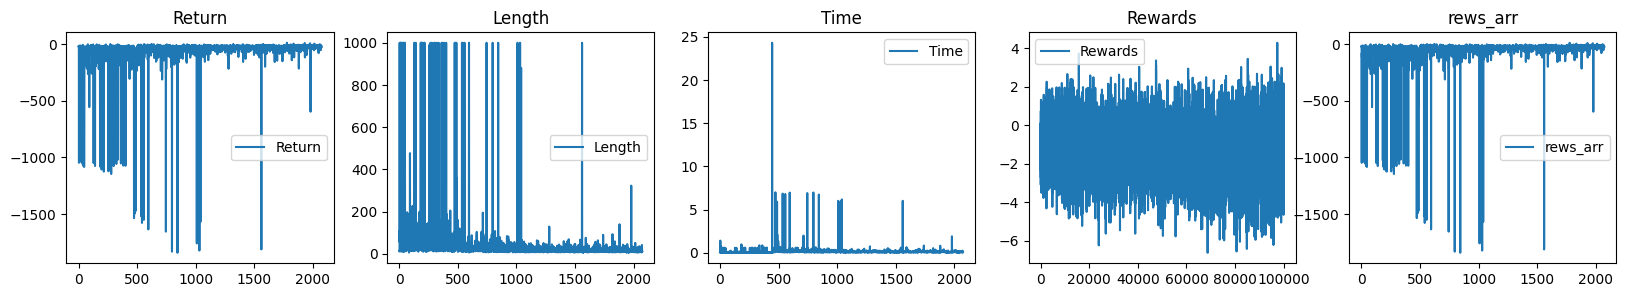

In [51]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 3))

ax1.plot(rs, label='Return')
ax1.legend()
ax1.set_title("Return")

ax2.plot(ls, label='Length')
ax2.legend()
ax2.set_title("Length")

ax3.plot(ts, label='Time')
ax3.legend()
ax3.set_title("Time")

ax4.plot(rewards, label='Rewards')
ax4.legend()
ax4.set_title("Rewards")

ax5.plot(rews_arr, label='rews_arr')
ax5.legend()
ax5.set_title("rews_arr")

plt.show()


In [ ]:
eval_env = gym.make("Ant-v5", render_mode="rgb_array") #
eval_env = wrap_gym(eval_env, rescale_actions=True)
eval_env = gym.wrappers.RecordVideo(eval_env, 'Ant-v5')
eval_env = gym.wrappers.RecordEpisodeStatistics(eval_env, buffer_length=1)
evaluate(agent, eval_env, num_episodes=1)
eval_env.close()
